In [1]:
from numpy import array,load,where,arange,copy,linspace,append
import numpy as np
from matplotlib.pyplot import plot,title,show,figure,legend,xticks,xlabel,ylabel,xlim
import keras
from keras.utils import np_utils
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten,    \
                         Conv2D, MaxPooling2D, ZeroPadding2D,    \
                         AveragePooling2D, Conv3D, MaxPooling3D, \
                         Convolution3D, Dense, Activation,       \
                         Convolution2D, MaxPooling2D, Flatten,   \
                         BatchNormalization, Input
from keras.optimizers import adam


from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
train_data_path = '../20191127_after_t=05/20200512_G_eigenvector_ver8_test/train/'
test_data_path = '../20191127_after_t=05/20200512_G_eigenvector_ver8_test/test/'

date = '20200512'
N = 8
NN = N
N = 'N={}'.format(N)
delta = 0.5
delta = 'delta={}'.format(delta)

print(NN,N,delta)

8 N=8 delta=0.5


get_train_data / get_test_data 獲取資料的函數並將資料照data的dictionary回覆  
transform_phase_into_onehot 將資料的label轉為keras可以使用的向量（詳細可參考to_categorical的說明）  
將[5, 1, 3, 7] 轉成[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]

In [3]:
def get_train_data(train_data_path, date, N, delta):
    
    path = train_data_path + '{},G_eigenvector_train,{},{}.npz'.format(date, N, delta)
    
    train_data = load(path)
    label = train_data.files
    
    phase = train_data['phase']
    delta = train_data['delta']
    mu = train_data['mu']
    eigenvector_r_theta_4D = train_data['eigenvector_r_theta_4D']
    eigenvector_r_3D = train_data['eigenvector_r_3D']
    eigenvector_r_theta_3D = train_data['eigenvector_r_theta_3D']

    return label, phase, delta, mu, eigenvector_r_theta_4D, eigenvector_r_3D, eigenvector_r_theta_3D

def get_test_data(test_data_path, date, N, delta):
    
    path = test_data_path + '{},G_eigenvector_test,{},{}.npz'.format(date, N, delta)
    
    test_data = load(path)
    label = test_data.files
    
    phase = test_data['phase']
    delta = test_data['delta']
    mu = test_data['mu']
    eigenvector_r_theta_4D = test_data['eigenvector_r_theta_4D']
    eigenvector_r_3D = test_data['eigenvector_r_3D']
    eigenvector_r_theta_3D = test_data['eigenvector_r_theta_3D']

    return label, phase, delta, mu, eigenvector_r_theta_4D, eigenvector_r_3D, eigenvector_r_theta_3D

def transform_phase_into_onehot(phase):
    
    phase[phase == 5] = 0
    phase[phase == 1] = 1
    phase[phase == 3] = 2
    phase[phase == 7] = 3
    #phase[phase == 6] = 0
    #phase[phase == 2] = 1
    #phase[phase == 4] = 2
    #phase[phase == 8] = 3
    
    phase = np_utils.to_categorical(phase,4)
    
    return phase

# eigenvector_r_theta_3D

開始獲取eigenvector_r_theta_3D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [4]:
train_data = get_train_data(train_data_path, date, N, delta)[6]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 384, 8, 8)
(4000,)
(4000, 4)
(28001, 384, 8, 8)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [5]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [6]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 384, 8, 8)
(4000, 4)
Number of real trian data = 
(3200, 384, 8, 8)
(3200, 4)
Number validation data = 
(800, 384, 8, 8)
(800, 4)


開始架構網路

In [7]:
channel = 2*(NN**2)*3

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 2*channel,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 3*channel, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 768, 8, 8)         2654976   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 768, 4, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1152, 4, 4)        7963776   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1152, 2, 2)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                

In [8]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [9]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 3s 1ms/step - loss: 0.0395 - accuracy: 0.9859 - val_loss: 5.9469e-06 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 436us/step - loss: 4.4251e-06 - accuracy: 1.0000 - val_loss: 4.0047e-06 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 441us/step - loss: 3.4610e-06 - accuracy: 1.0000 - val_loss: 3.2629e-06 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 438us/step - loss: 2.8384e-06 - accuracy: 1.0000 - val_loss: 2.6710e-06 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 440us/step - loss: 2.3256e-06 - accuracy: 1.0000 - val_loss: 2.1793e-06 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 438us/step - loss: 1.9083e-06 - accuracy: 1.0000 - val_loss: 1.7919e-06 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [=============

訓練完成  
開始提取模型資料

In [10]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


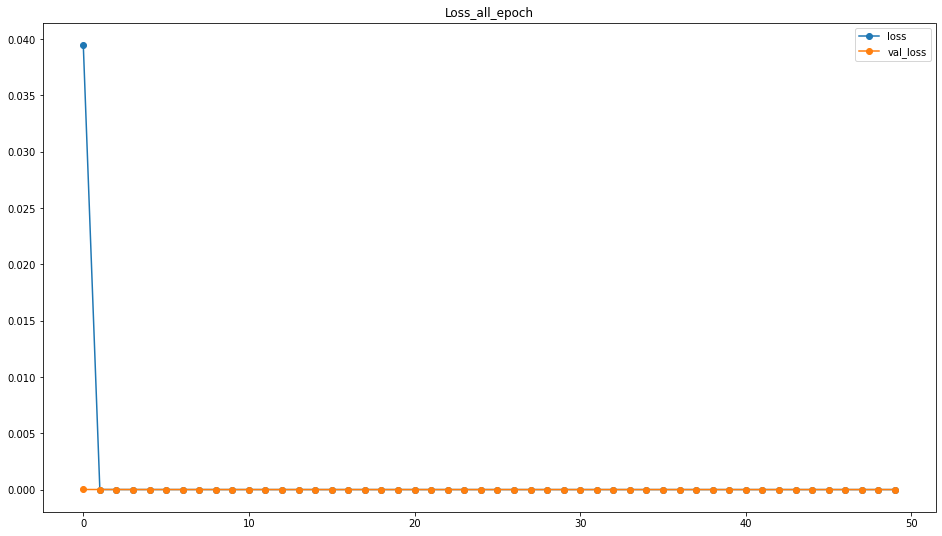

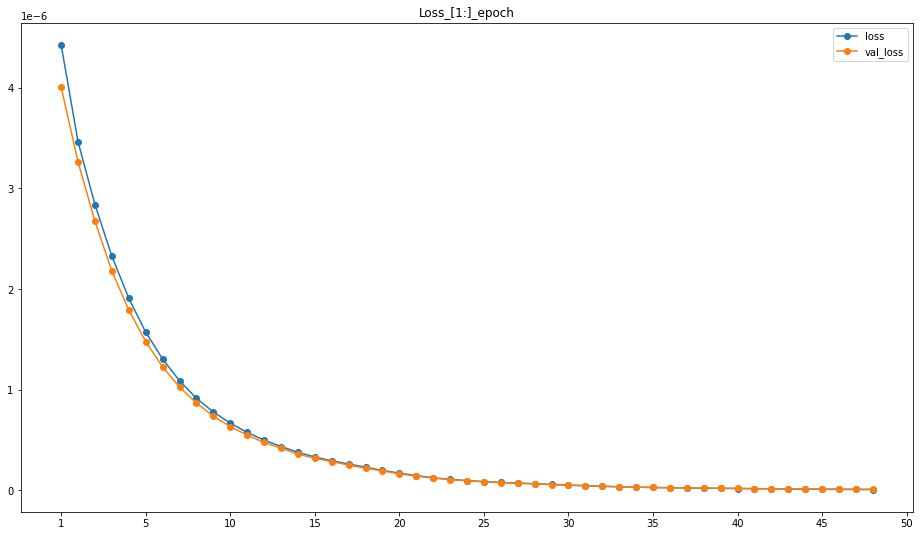

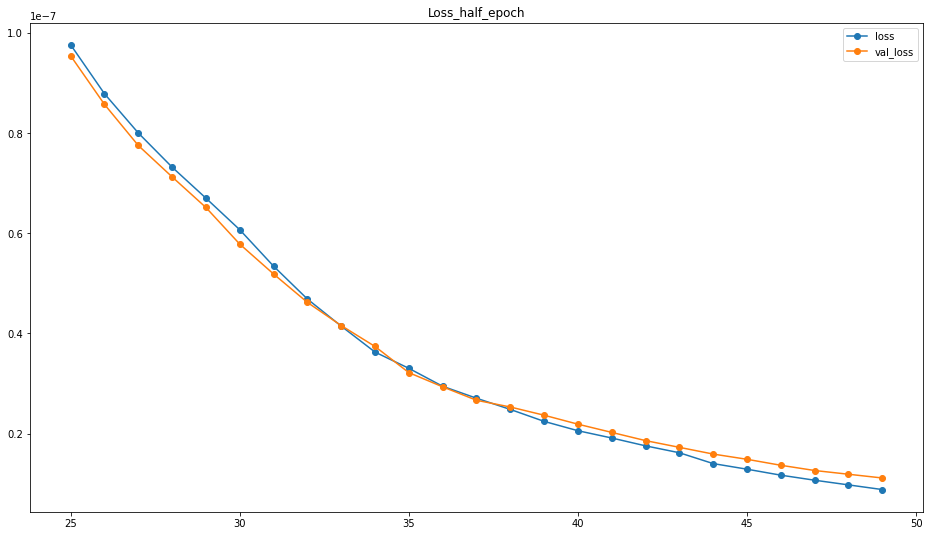

In [11]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [12]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 6s 227us/step


In [13]:
print (scores)

[0.07548693441303891, 0.9820363521575928]


In [14]:
prediction = model.predict(test_data)

In [15]:
print(prediction)

[[9.99999762e-01 8.46638883e-08 7.99142086e-08 5.99043730e-08]
 [9.99999762e-01 1.16214068e-07 9.62342028e-08 4.21137578e-08]
 [9.99999762e-01 6.74424072e-08 6.52411245e-08 4.59763783e-08]
 ...
 [1.05783741e-07 1.50852841e-07 1.14653396e-07 9.99999642e-01]
 [1.65278536e-07 1.50129765e-07 2.73349883e-07 9.99999404e-01]
 [2.06669711e-07 1.93606468e-07 3.12715855e-07 9.99999285e-01]]


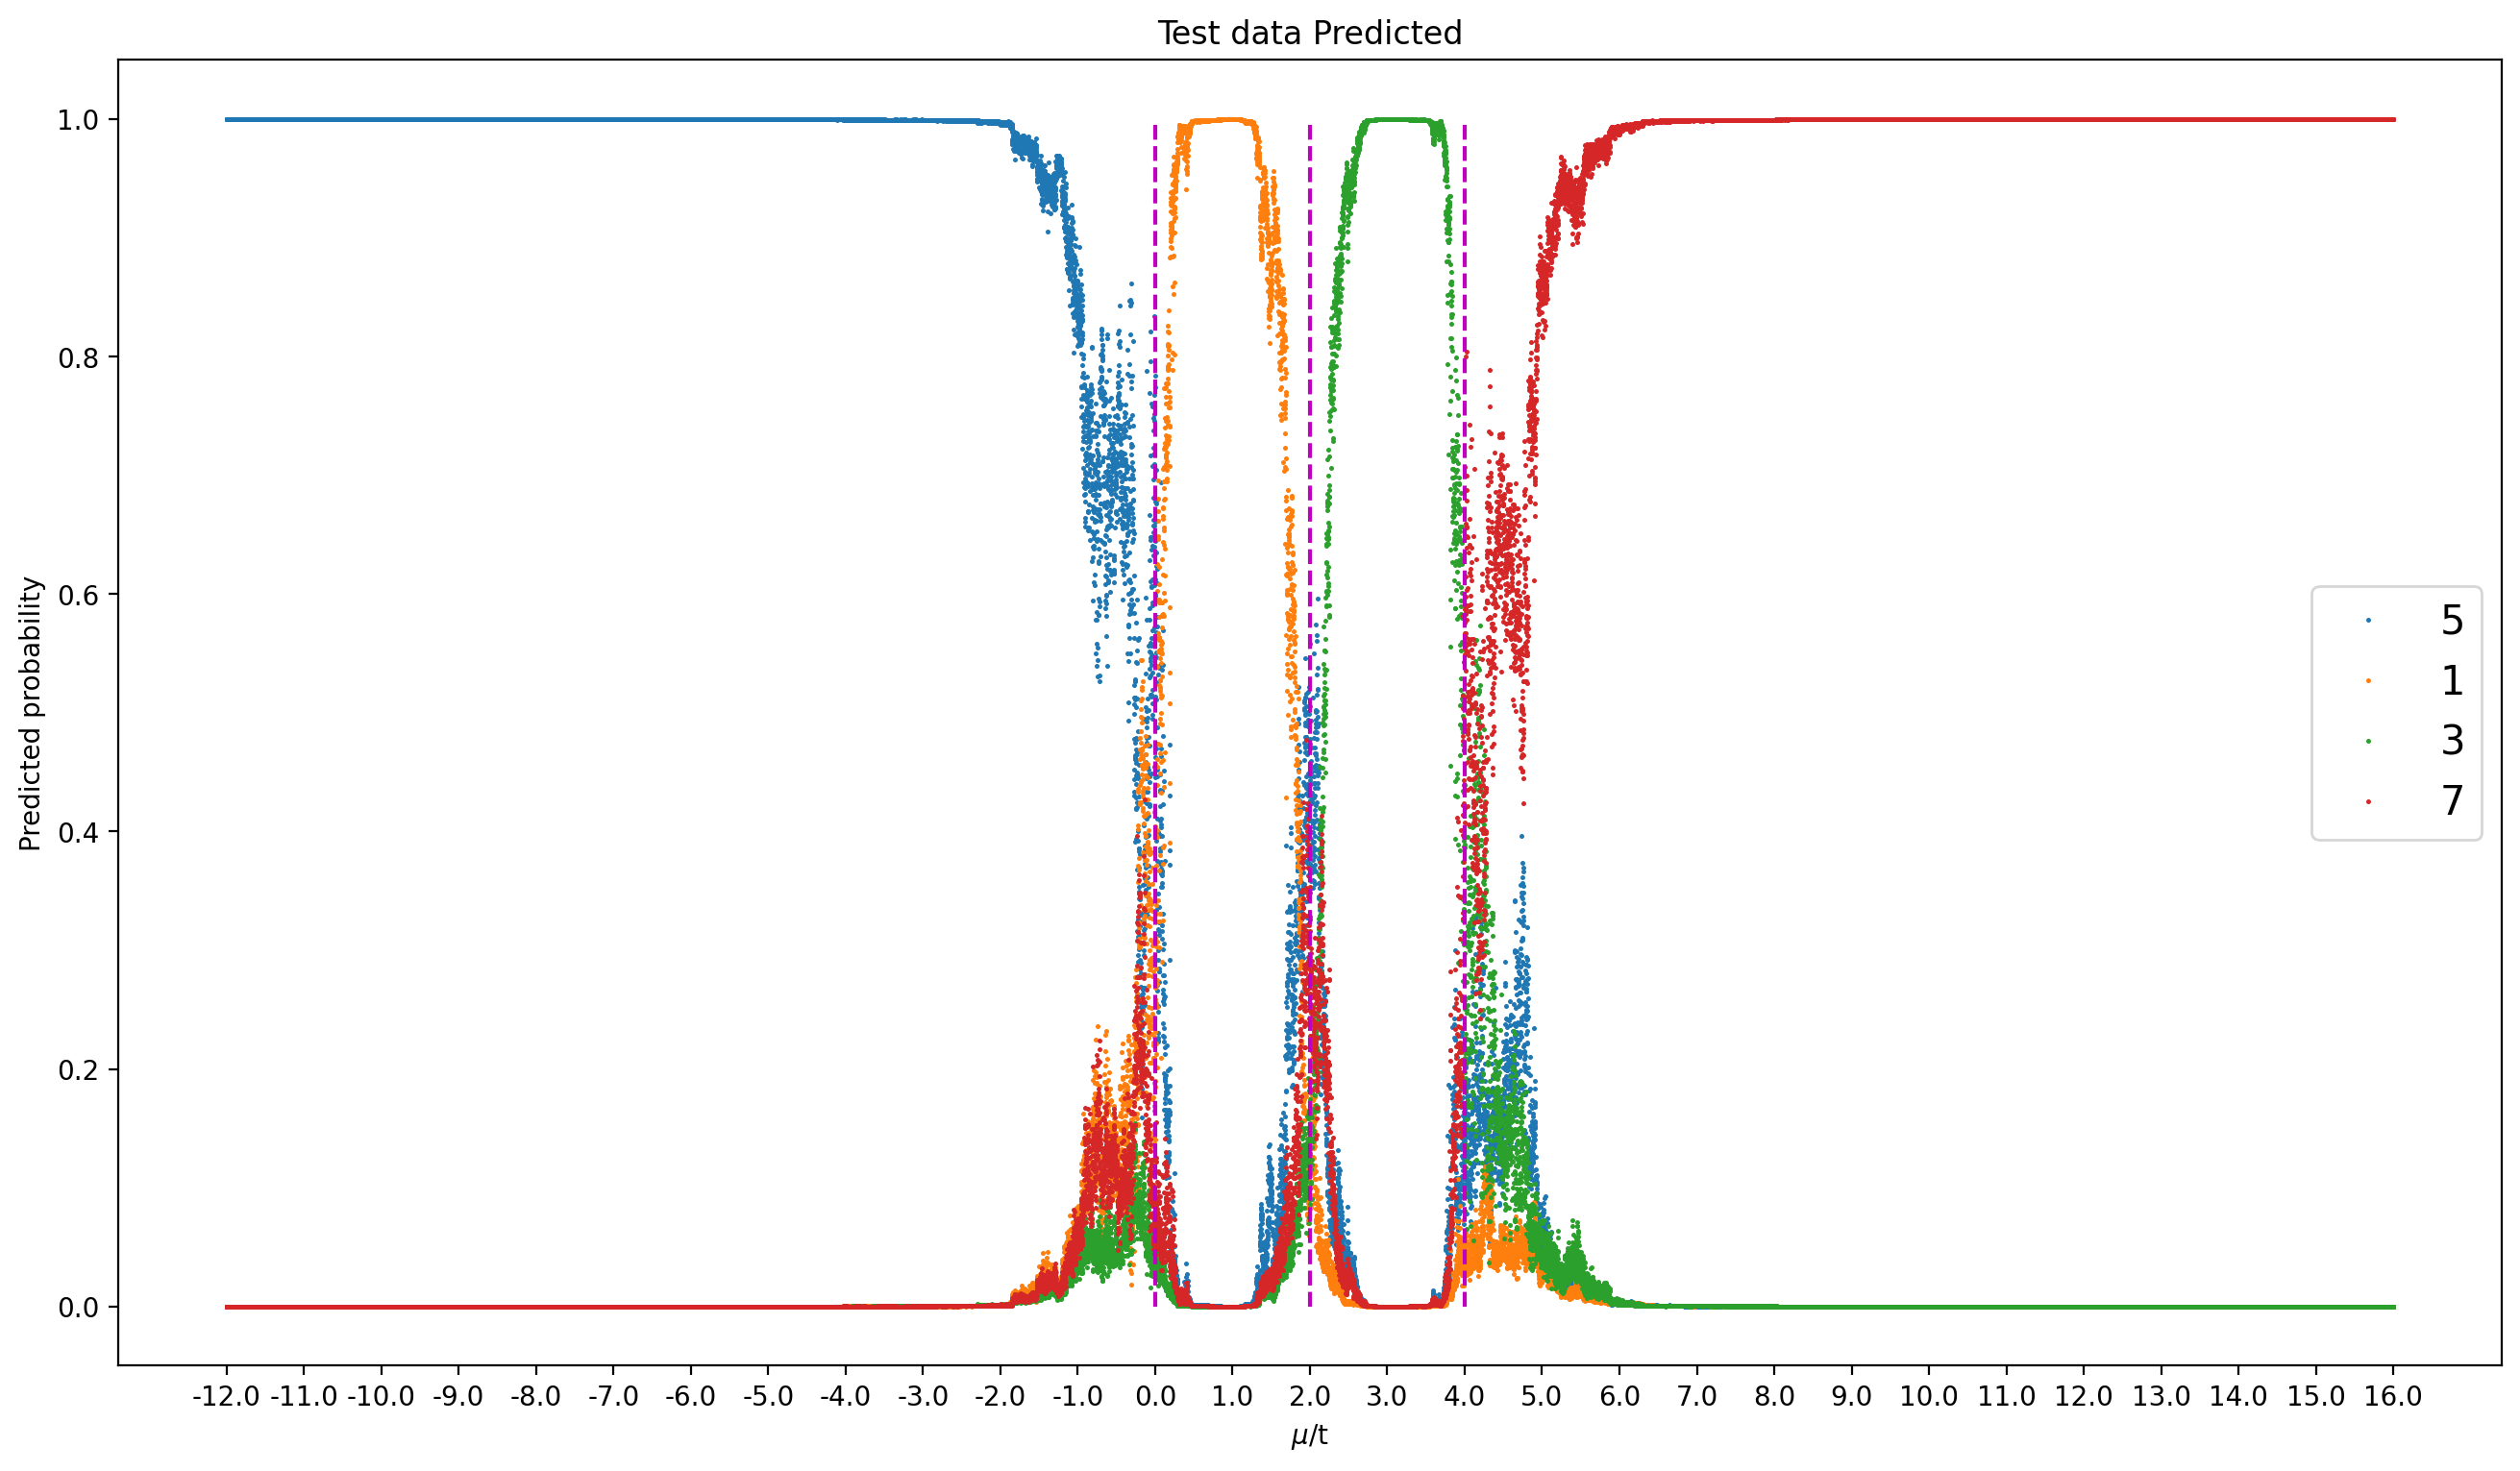

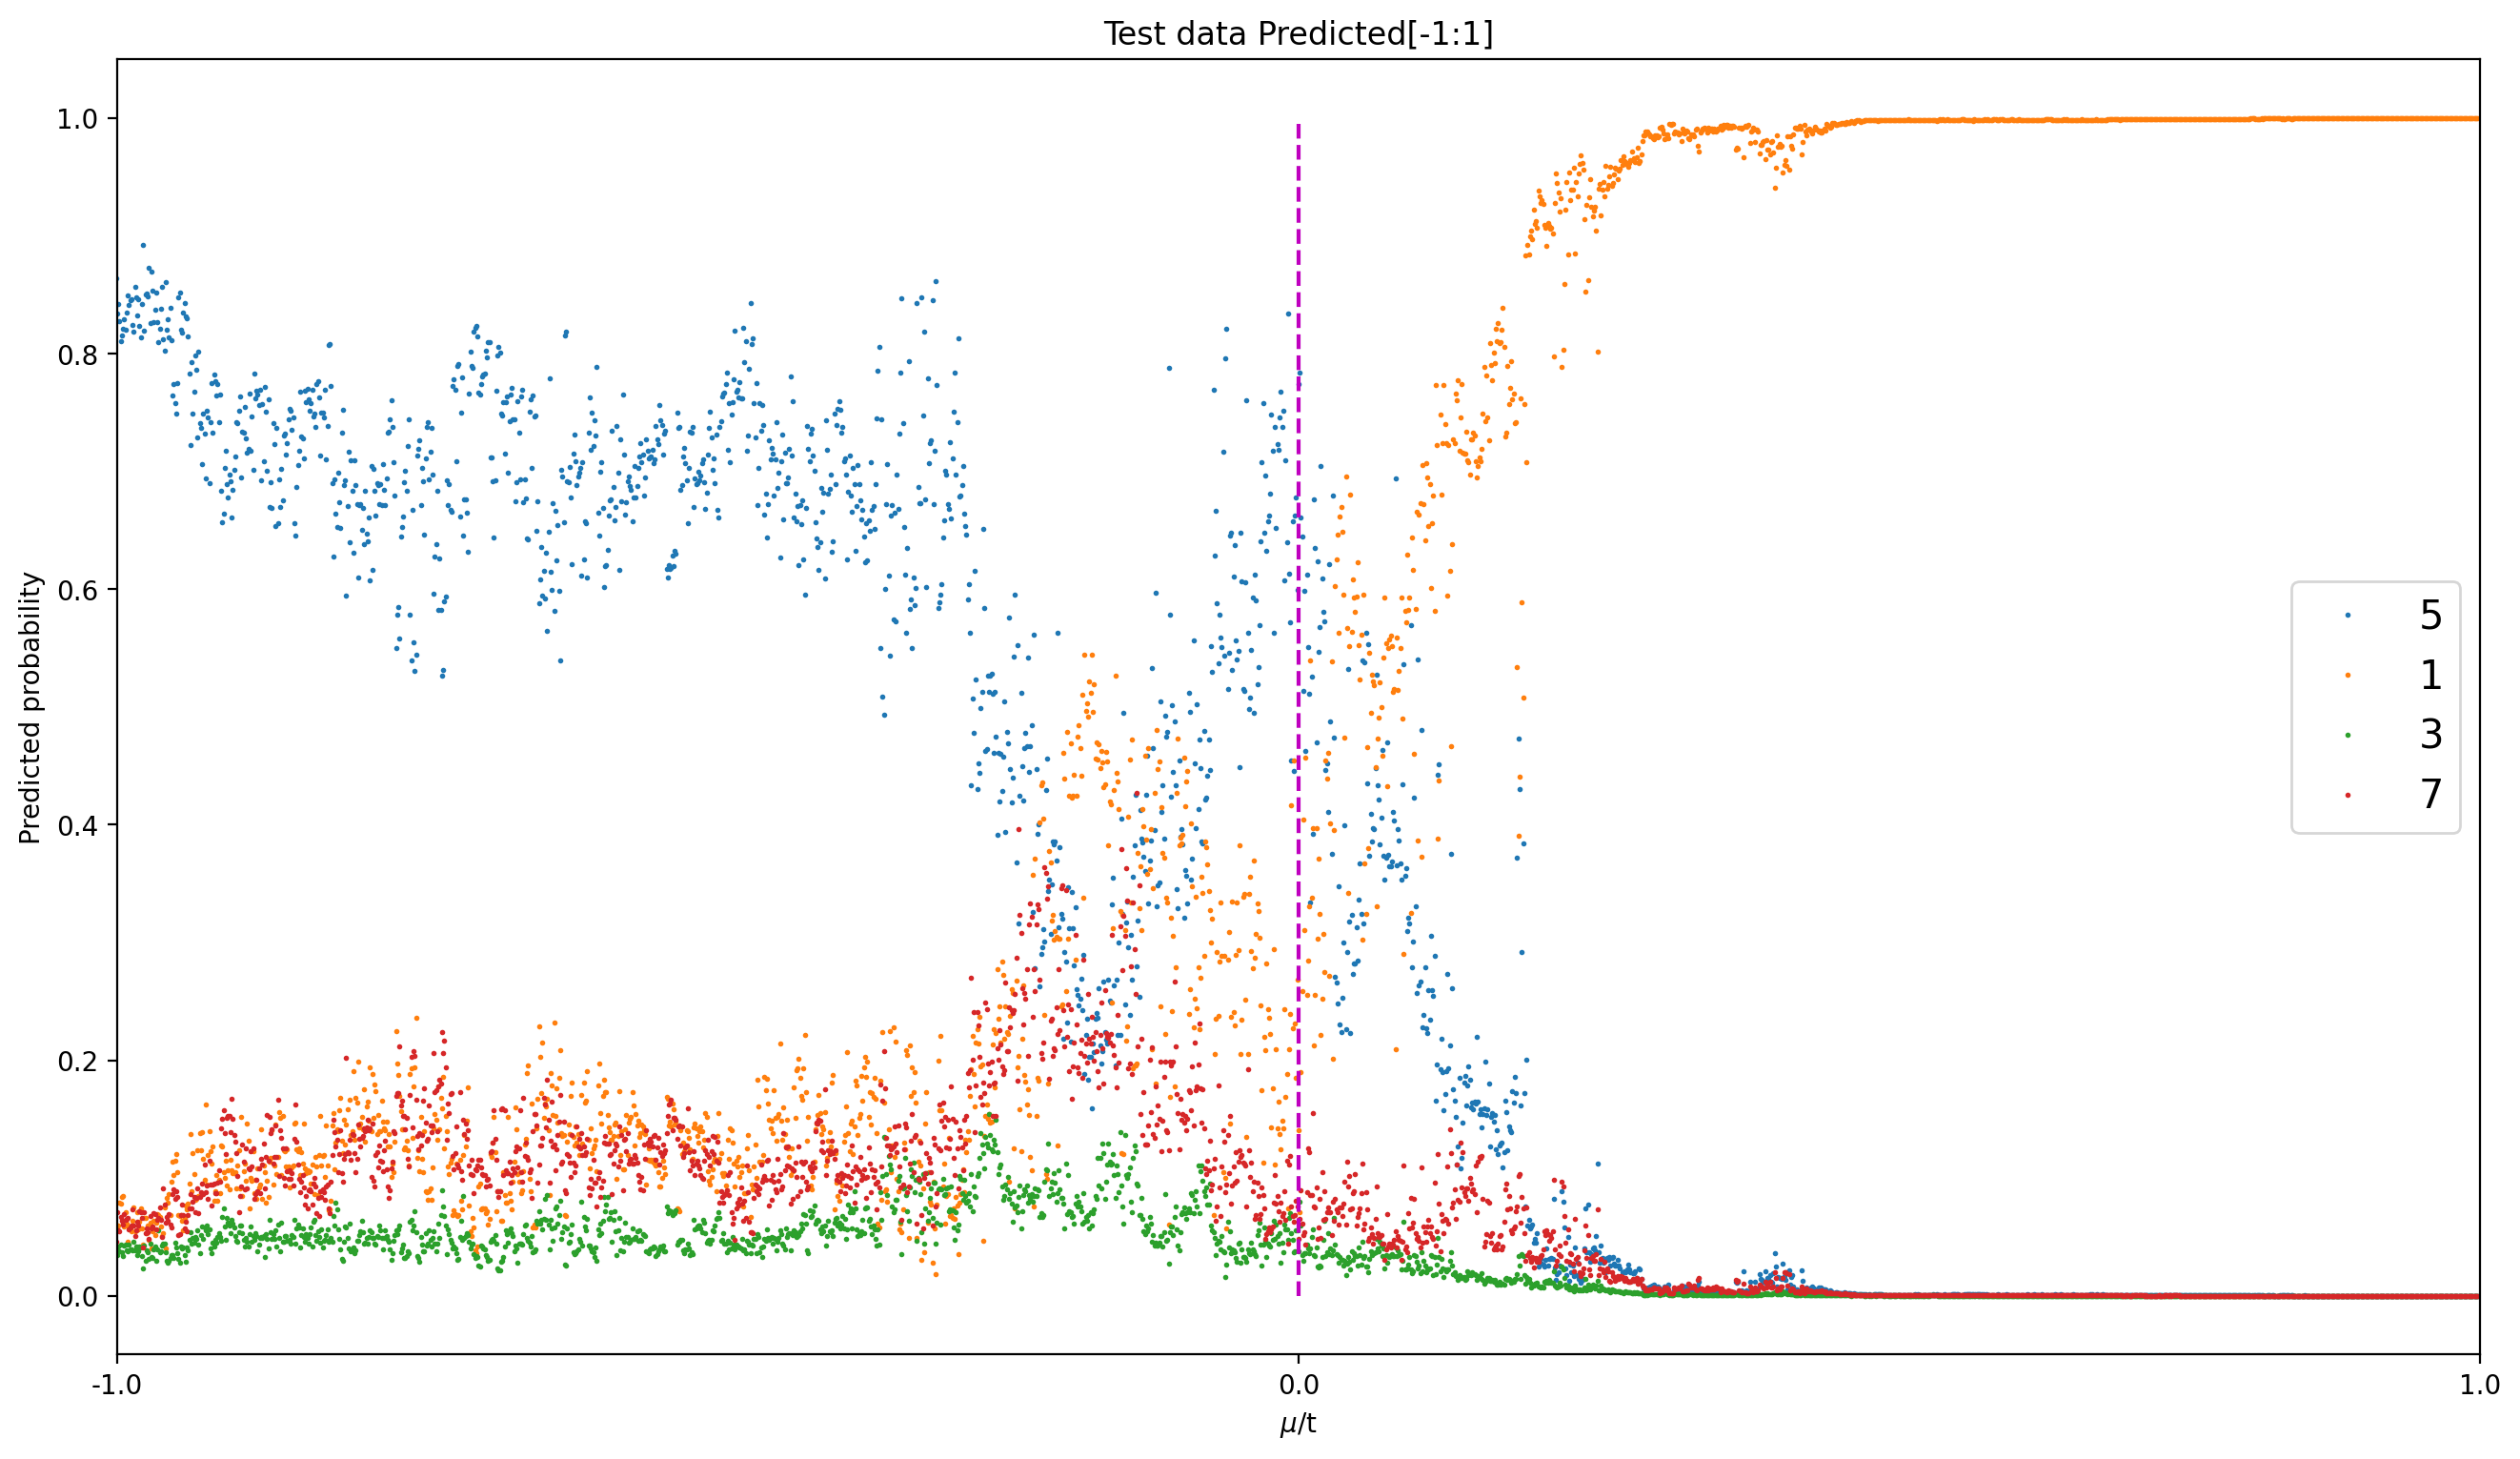

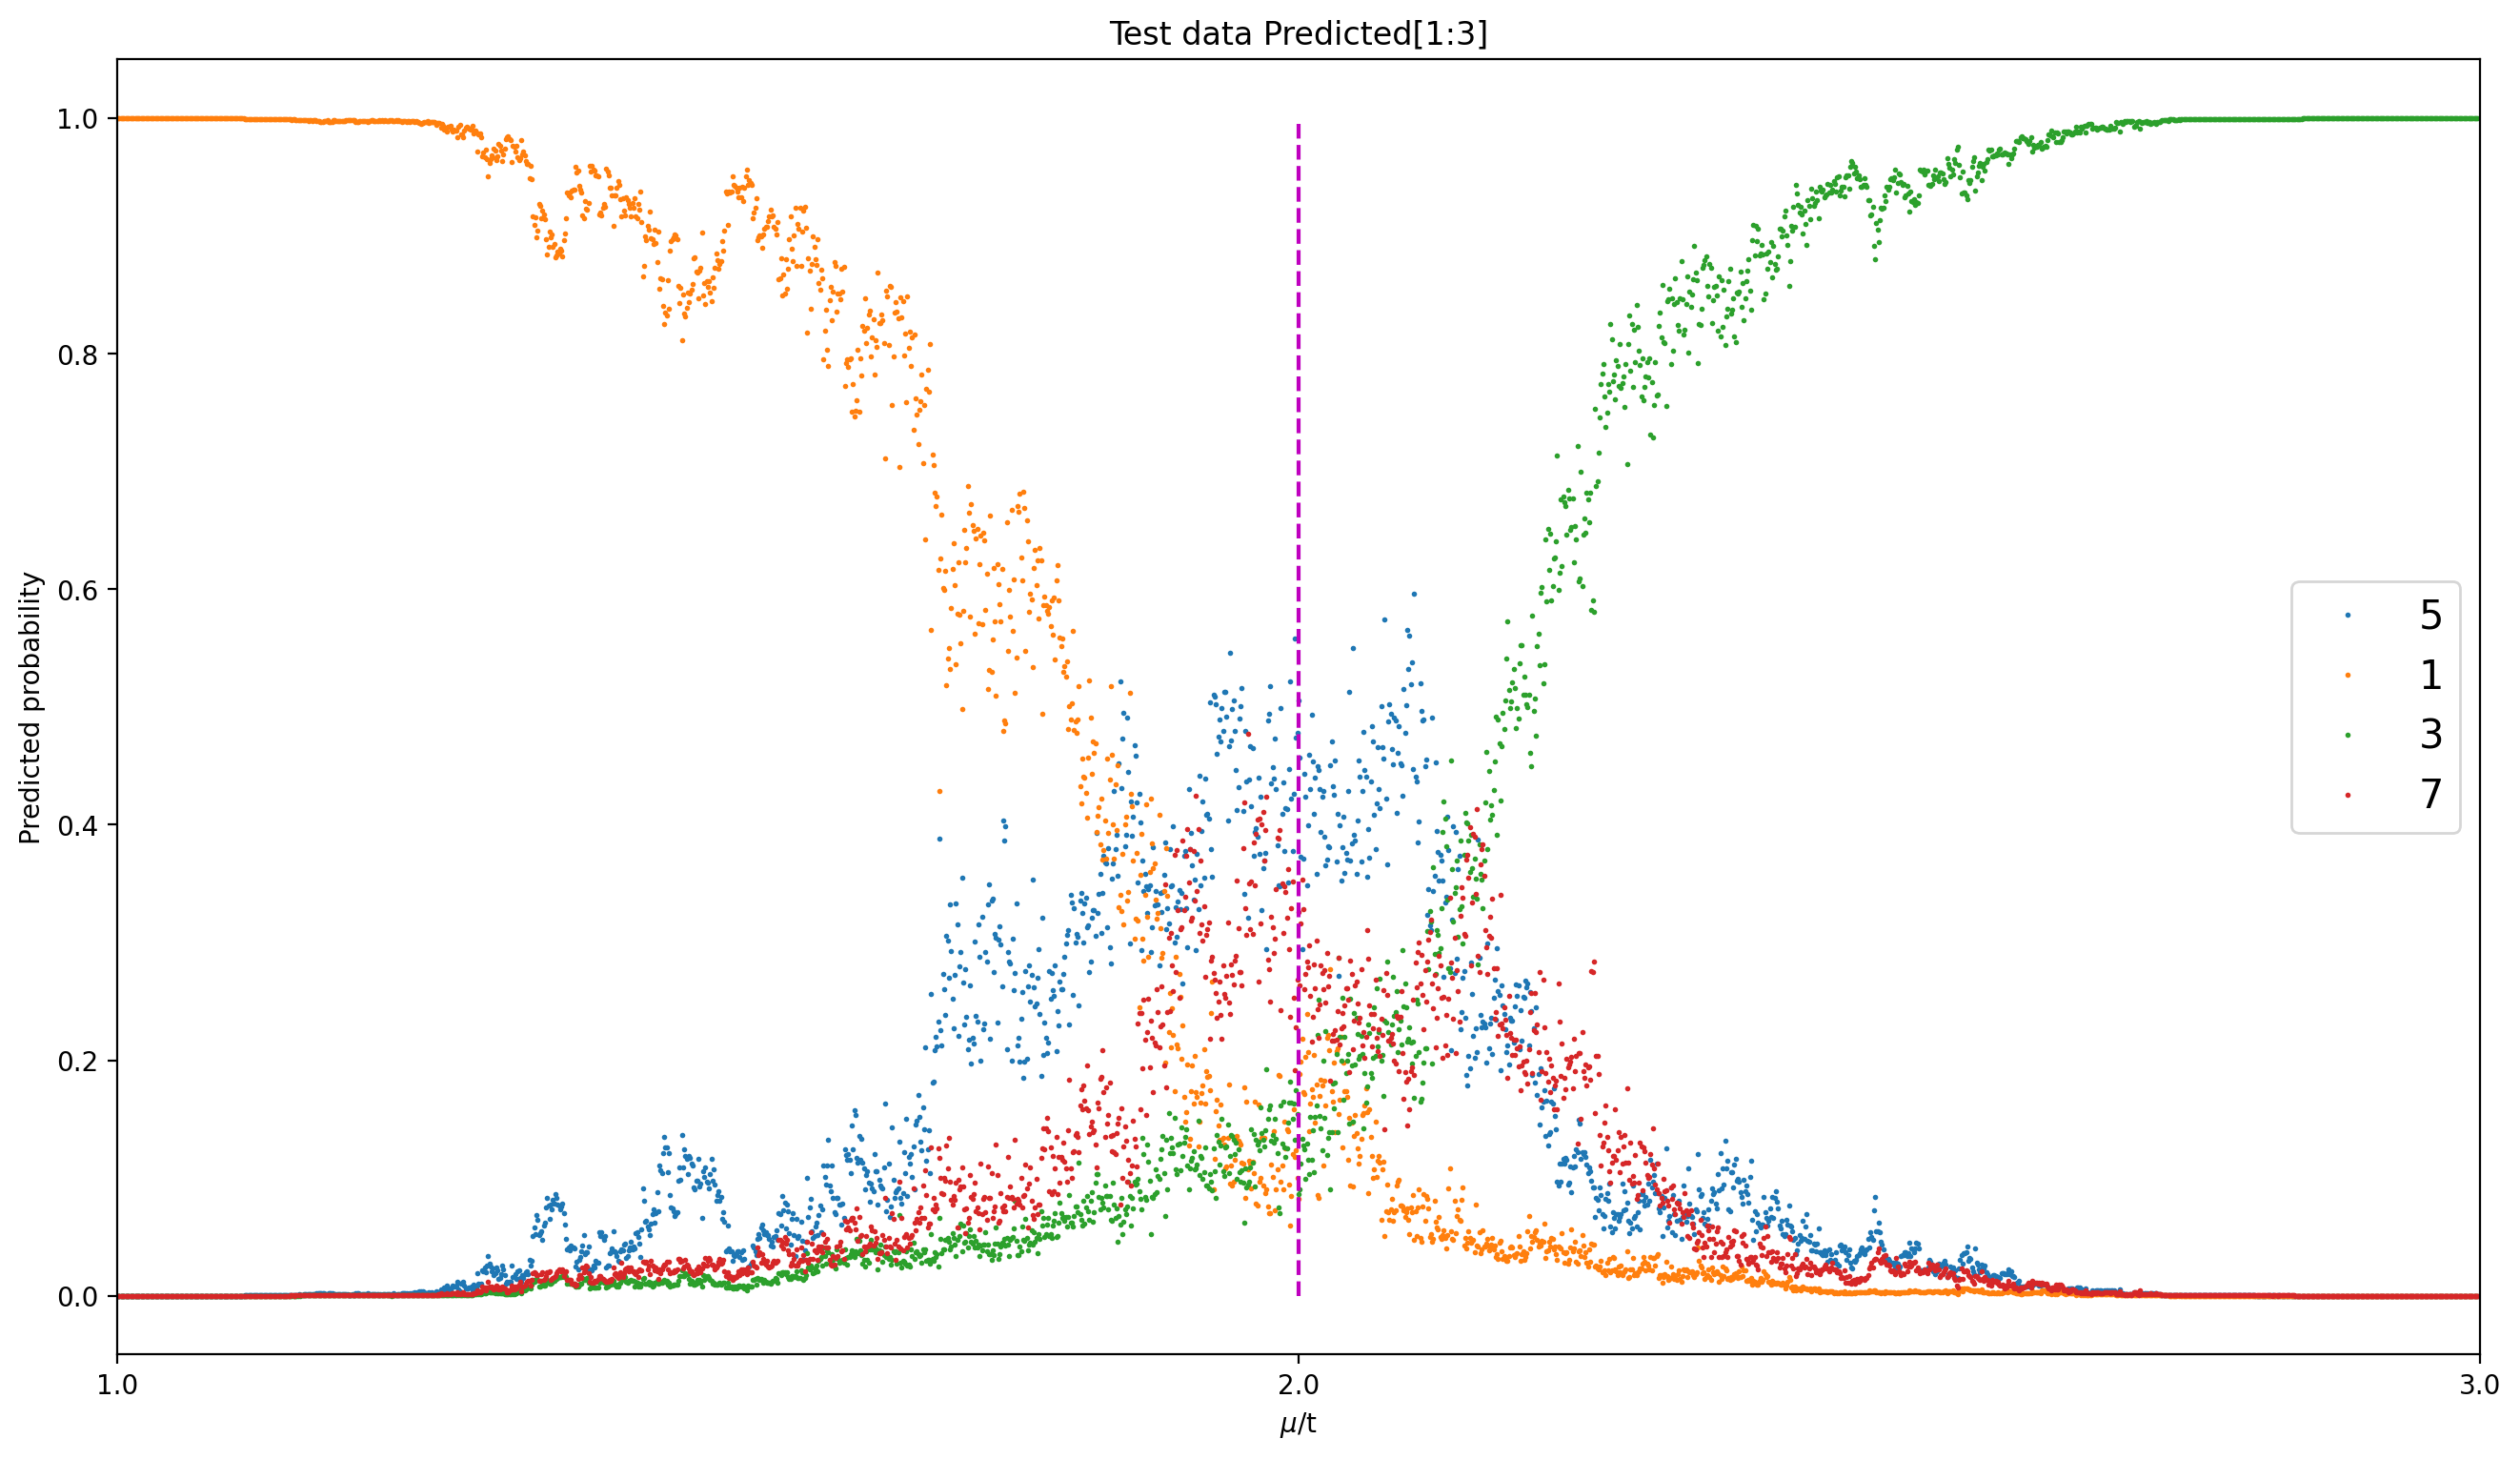

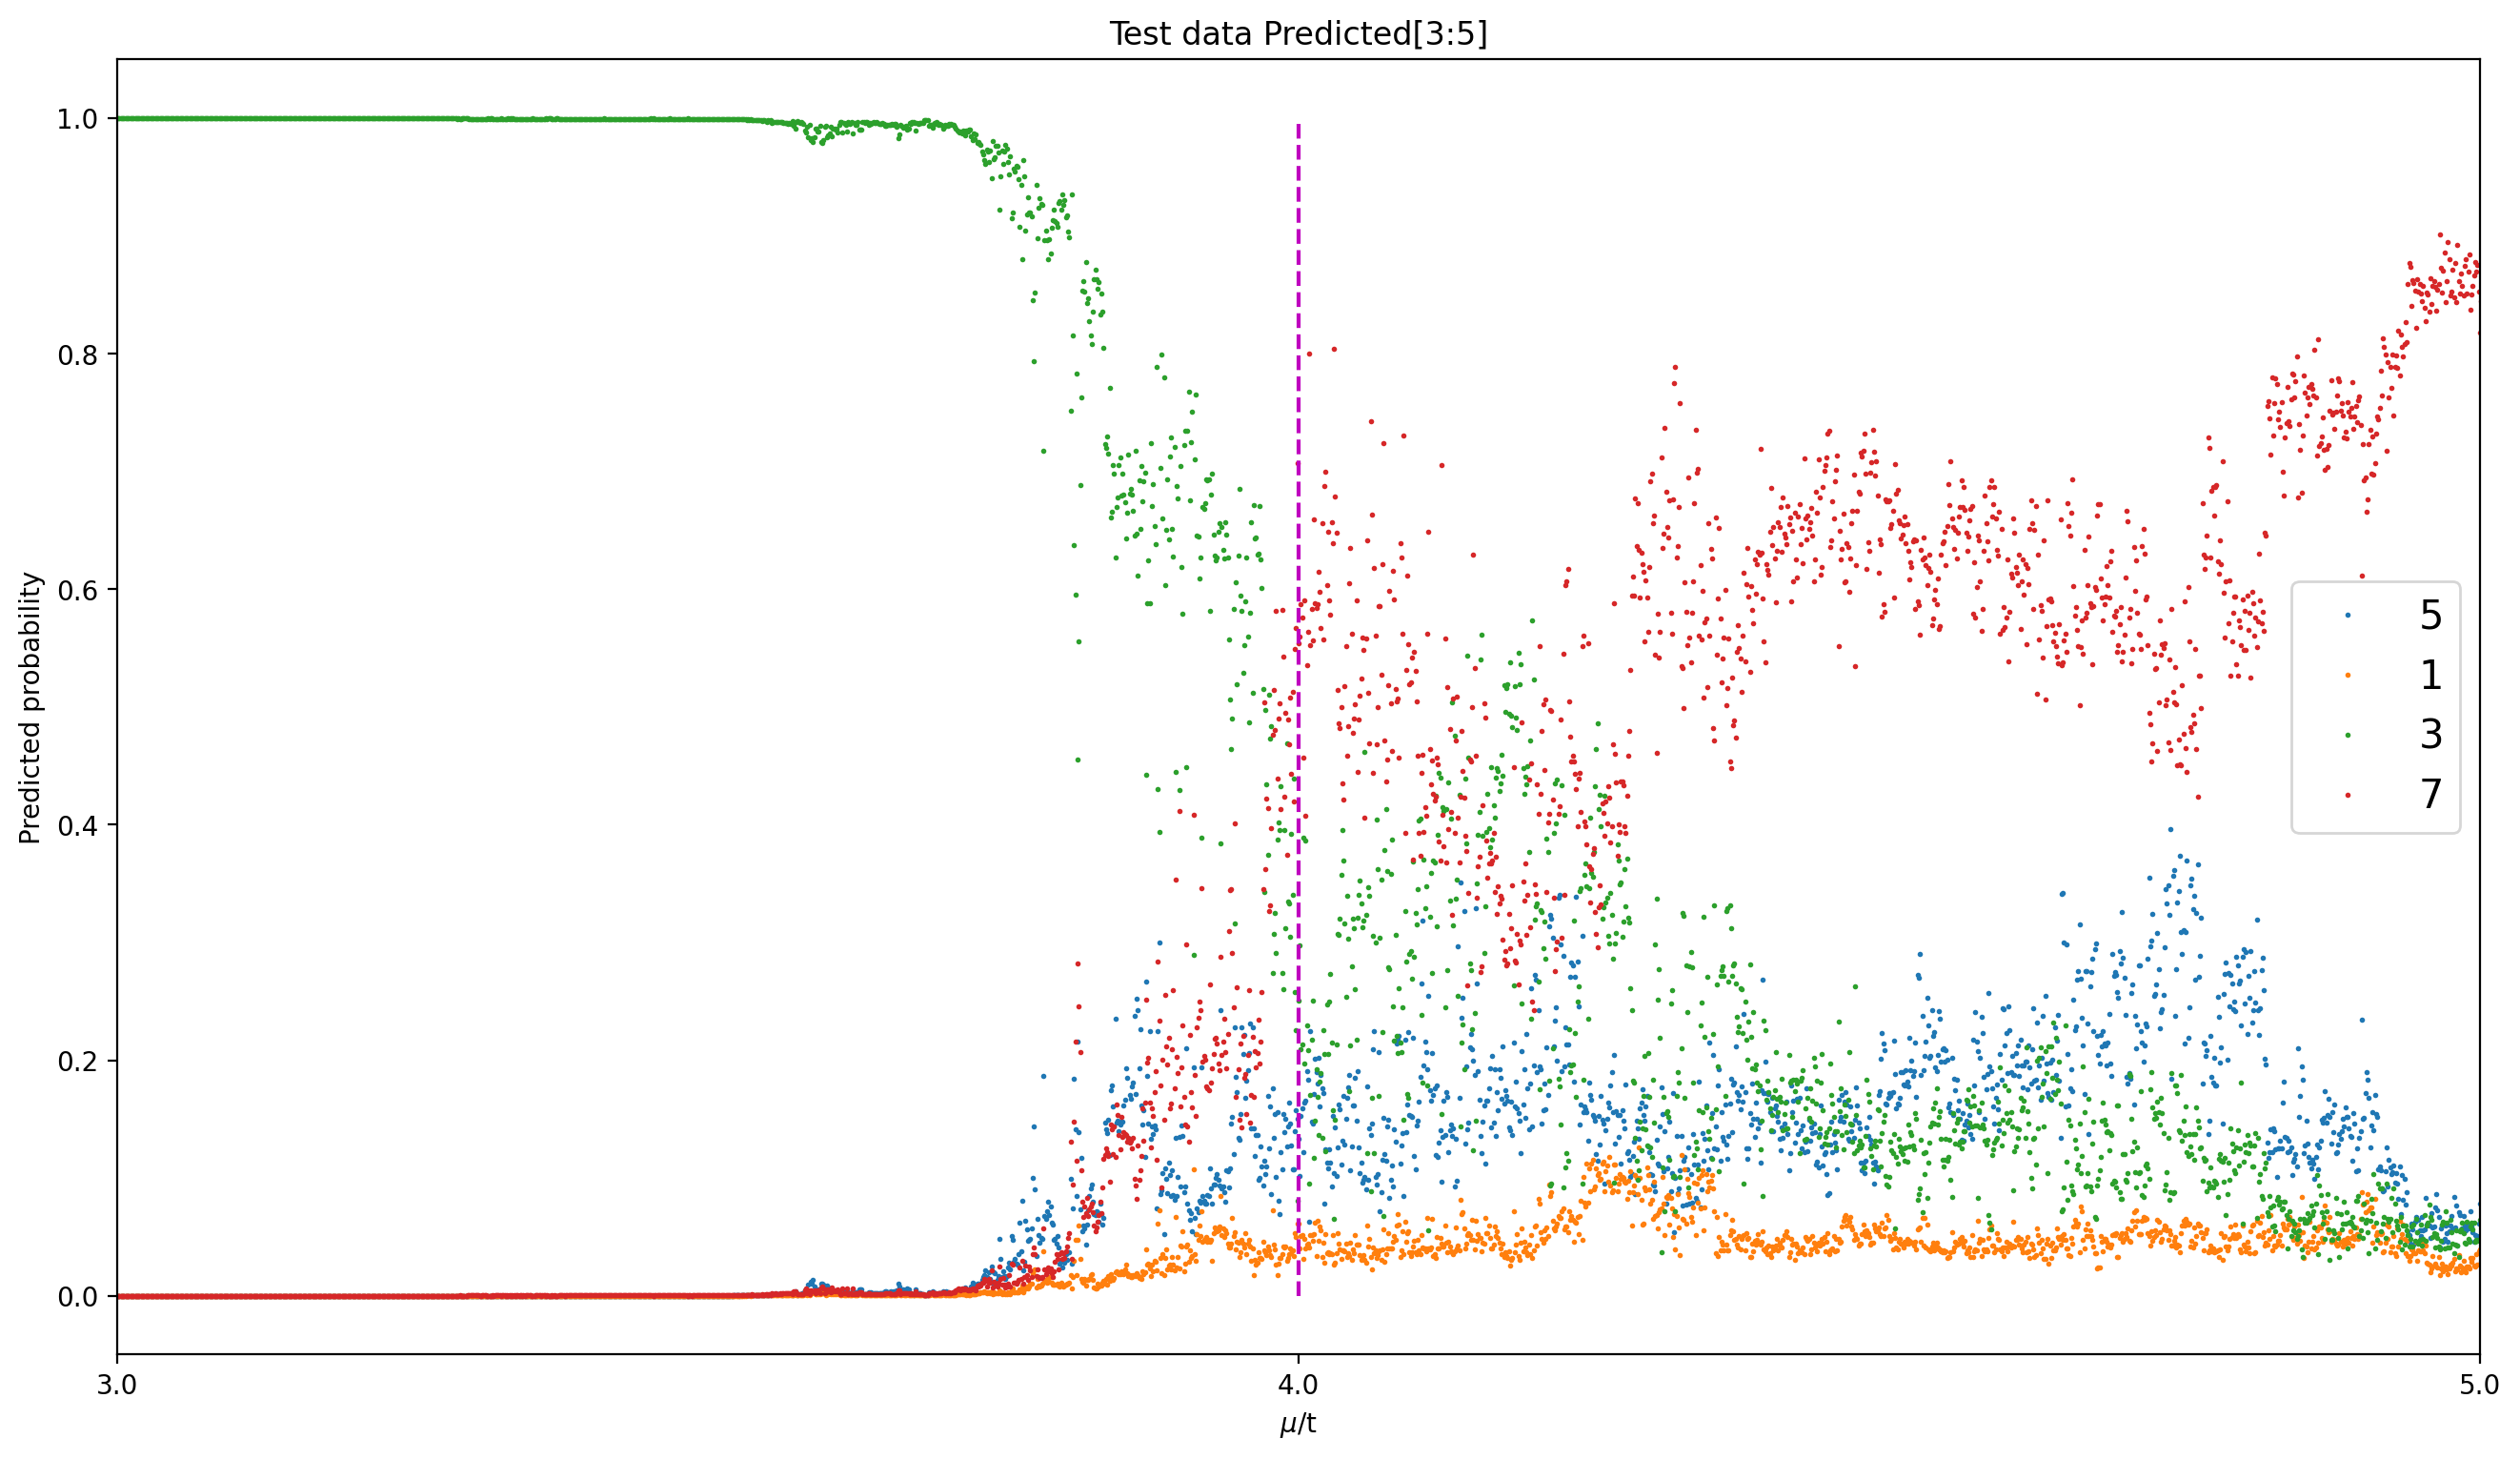

In [16]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_3D

開始獲取eigenvector_r_3D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [17]:
train_data = get_train_data(train_data_path, date, N, delta)[5]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[5]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 128, 8, 8)
(4000,)
(4000, 4)
(28001, 128, 8, 8)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [18]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [19]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 128, 8, 8)
(4000, 4)
Number of real trian data = 
(3200, 128, 8, 8)
(3200, 4)
Number validation data = 
(800, 128, 8, 8)
(800, 4)


開始架構網路

In [20]:
channel = 2*(NN**2)

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 2*channel,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 3*channel, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 8, 8)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 256, 4, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 384, 4, 4)         885120    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 384, 2, 2)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

In [21]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [22]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 244us/step - loss: 0.9816 - accuracy: 0.4484 - val_loss: 0.7195 - val_accuracy: 0.5088
Epoch 2/50
3200/3200 [==============================] - 1s 165us/step - loss: 0.6795 - accuracy: 0.5856 - val_loss: 0.6453 - val_accuracy: 0.6950
Epoch 3/50
3200/3200 [==============================] - 1s 165us/step - loss: 0.6026 - accuracy: 0.6644 - val_loss: 0.5395 - val_accuracy: 0.7113
Epoch 4/50
3200/3200 [==============================] - 1s 167us/step - loss: 0.5028 - accuracy: 0.7025 - val_loss: 0.4592 - val_accuracy: 0.7300
Epoch 5/50
3200/3200 [==============================] - 1s 164us/step - loss: 0.4362 - accuracy: 0.7269 - val_loss: 0.4135 - val_accuracy: 0.7462
Epoch 6/50
3200/3200 [==============================] - 1s 166us/step - loss: 0.4000 - accuracy: 0.7409 - val_loss: 0.3750 - val_accuracy: 0.7550
Epoch 7/50
3200/3200 [==============================] - 1s 166us/step - loss:

訓練完成  
開始提取模型資料

In [23]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


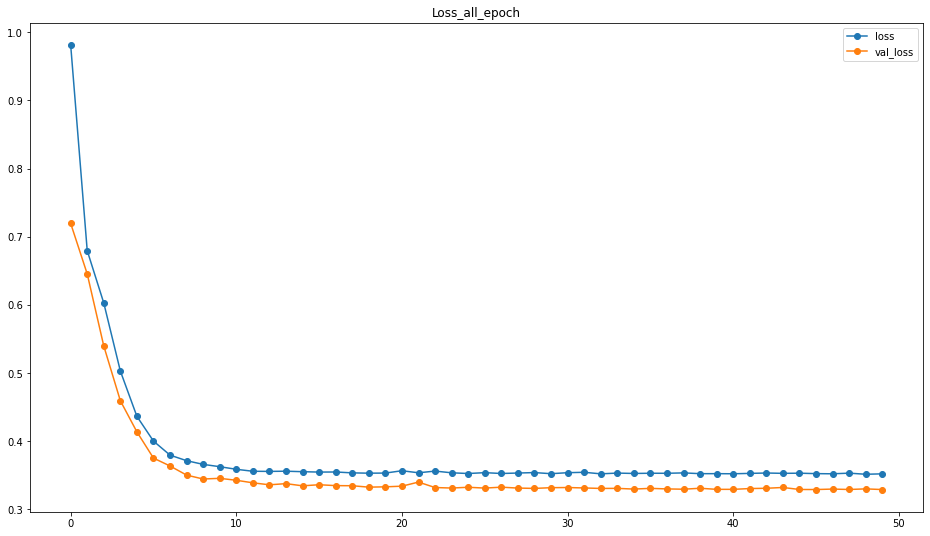

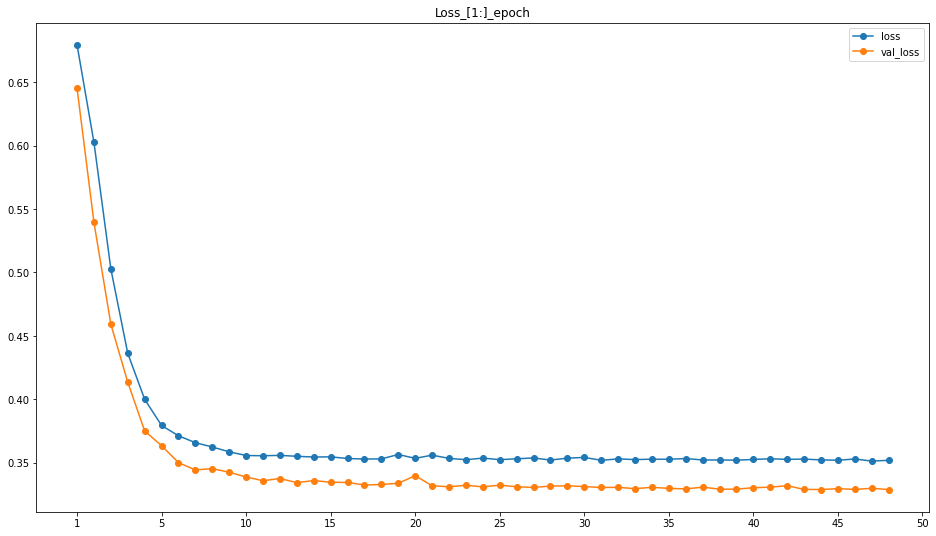

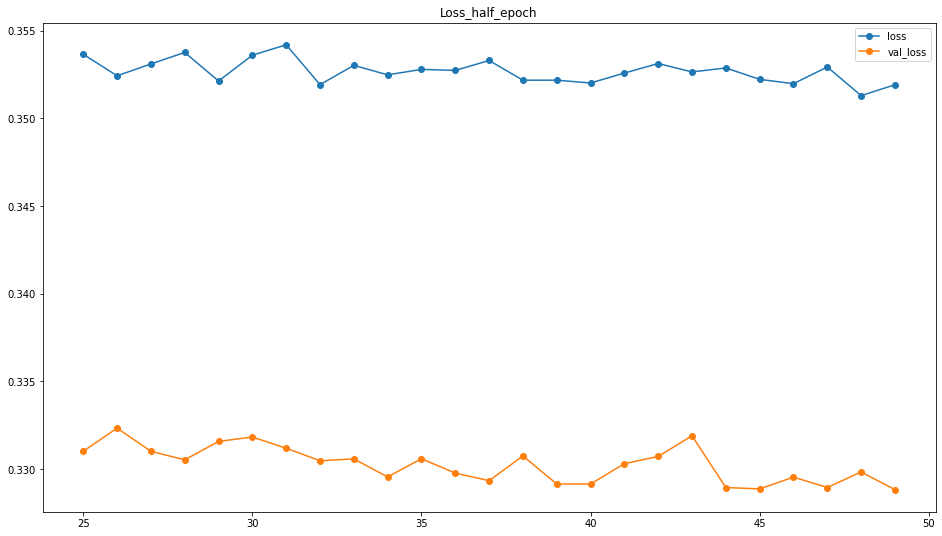

In [24]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [25]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 3s 95us/step


In [26]:
print (scores)

[2.0598309146553317, 0.5899075269699097]


In [27]:
prediction = model.predict(test_data)

In [28]:
print(prediction)

[[9.9999702e-01 4.2560134e-07 7.2636516e-07 1.7619232e-06]
 [9.9992847e-01 4.0641798e-06 6.0233965e-06 6.1451712e-05]
 [9.9989808e-01 2.9724144e-06 4.4329104e-06 9.4558258e-05]
 ...
 [1.9830698e-04 3.4317904e-06 2.7045160e-06 9.9979550e-01]
 [9.6265765e-05 1.5937139e-06 1.2743913e-06 9.9990082e-01]
 [1.4941347e-05 9.9223621e-07 7.1272069e-07 9.9998331e-01]]


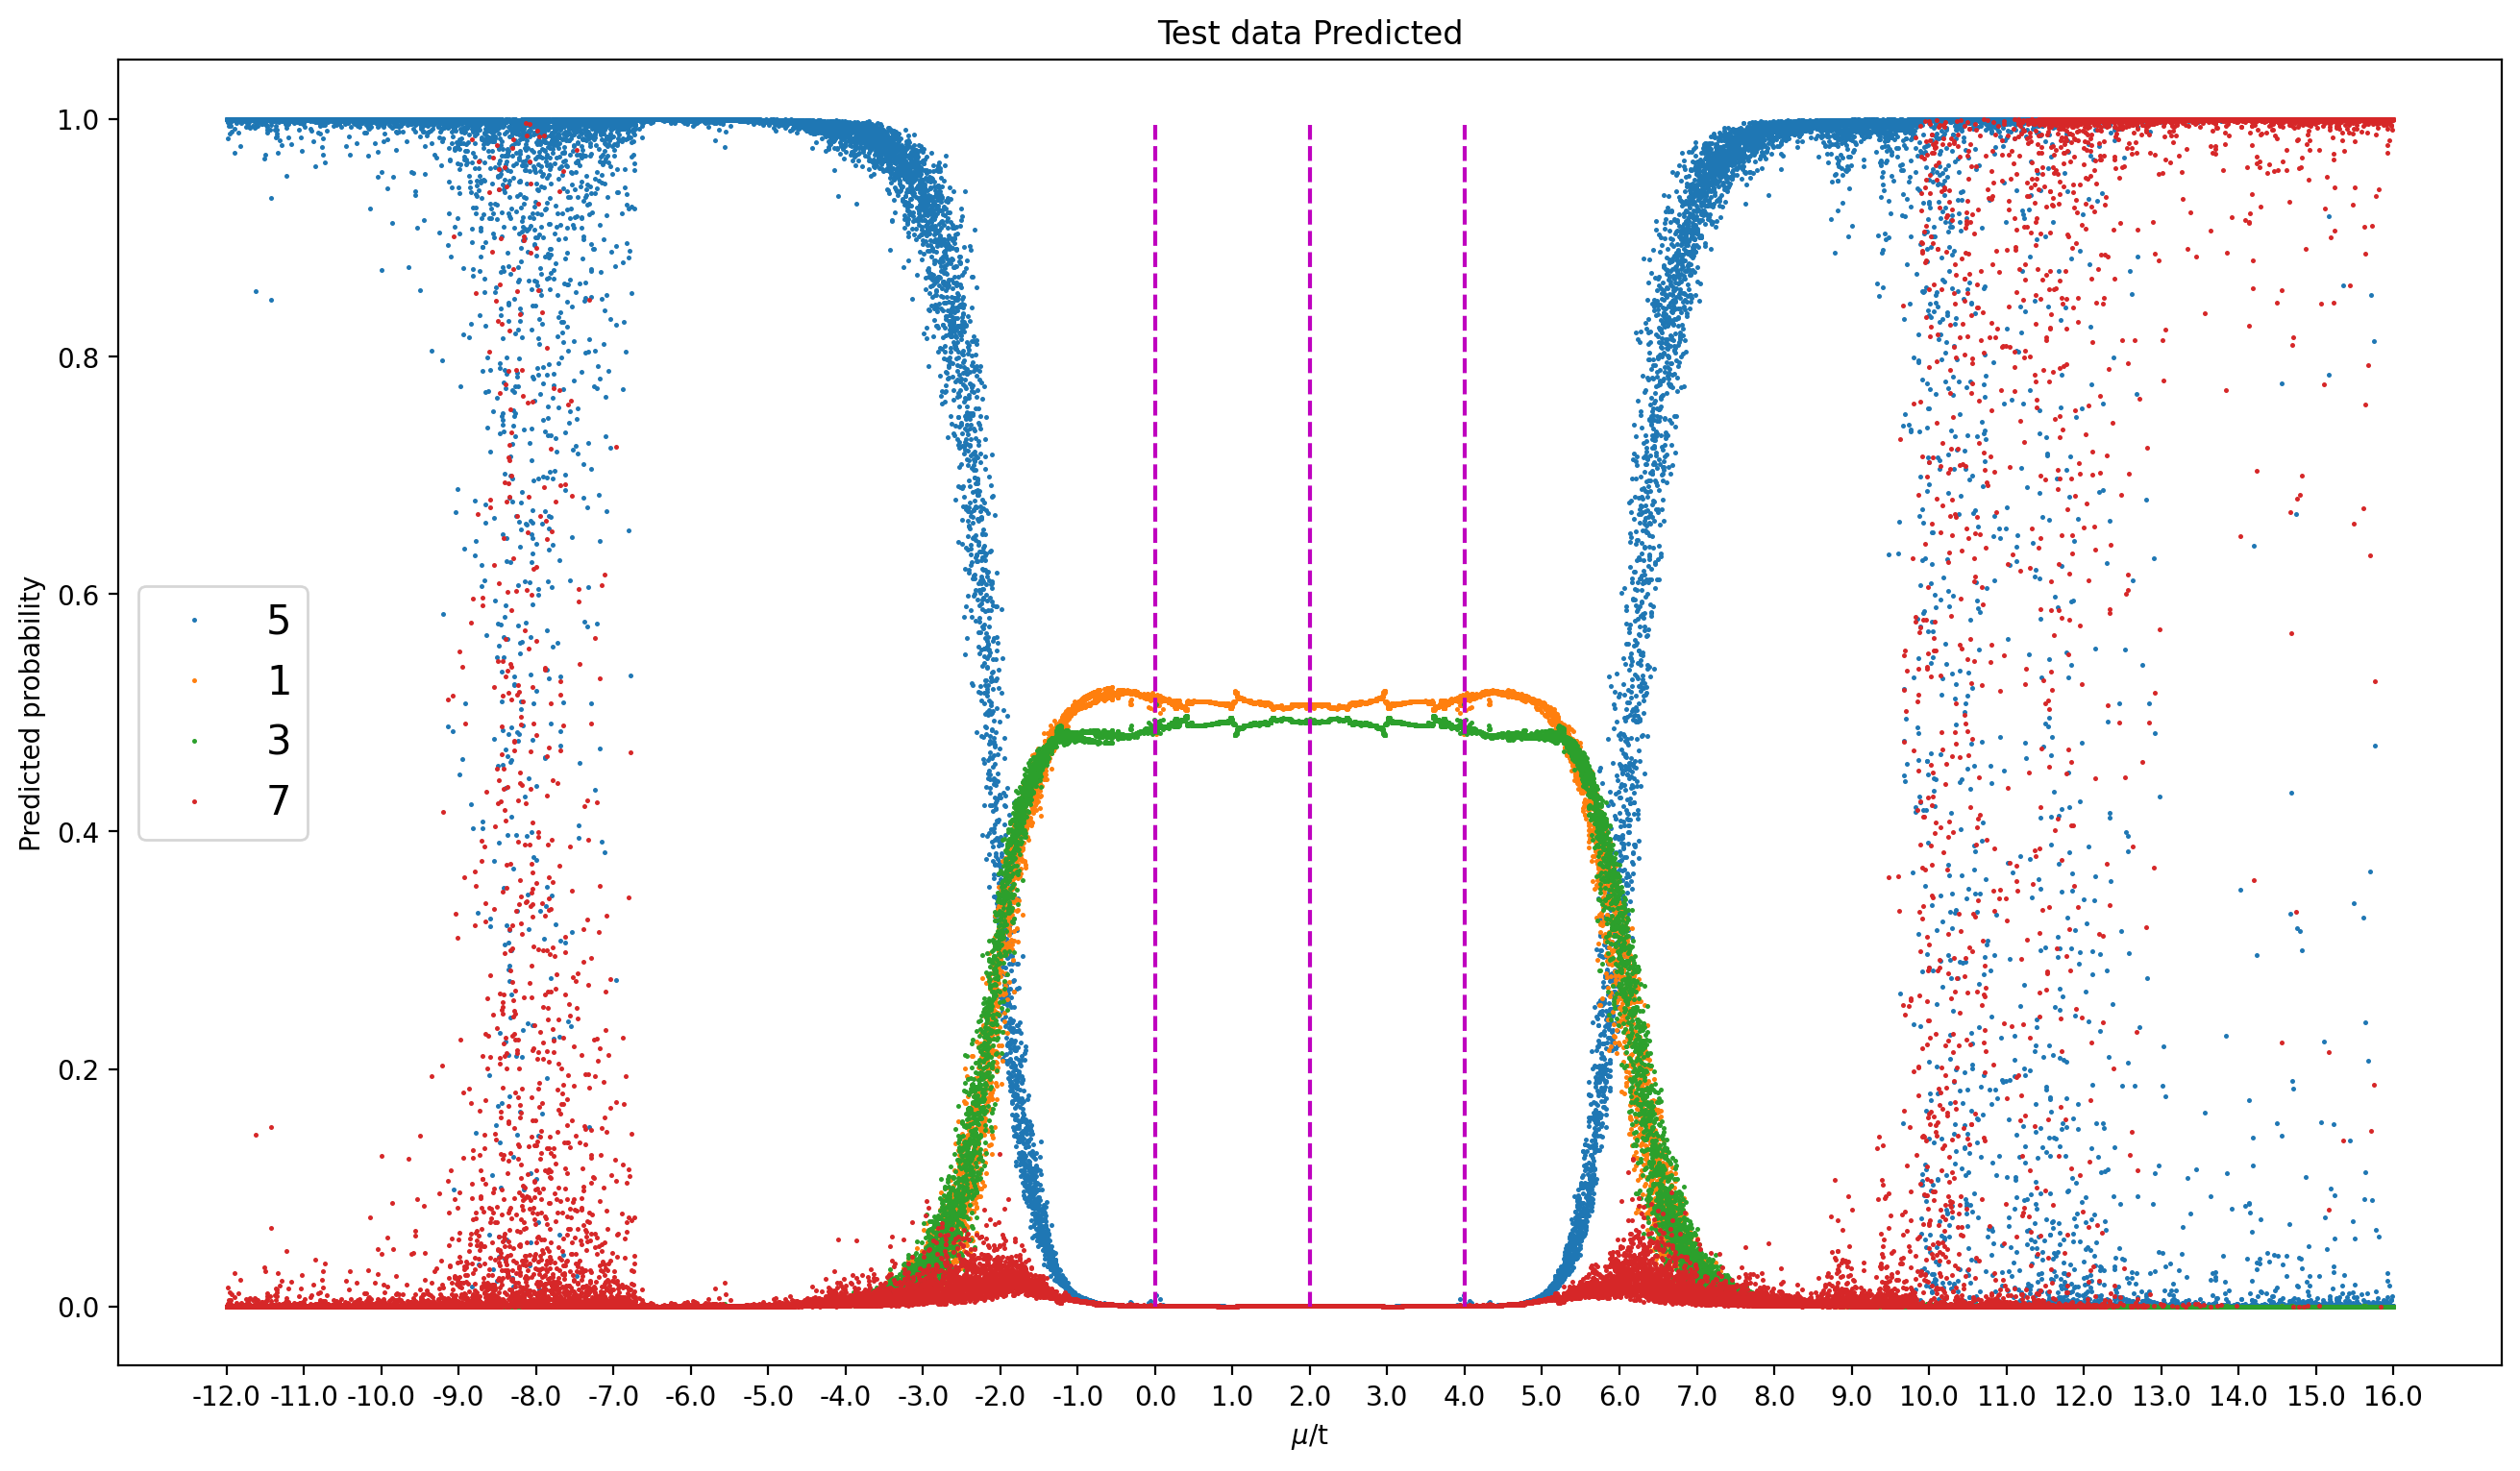

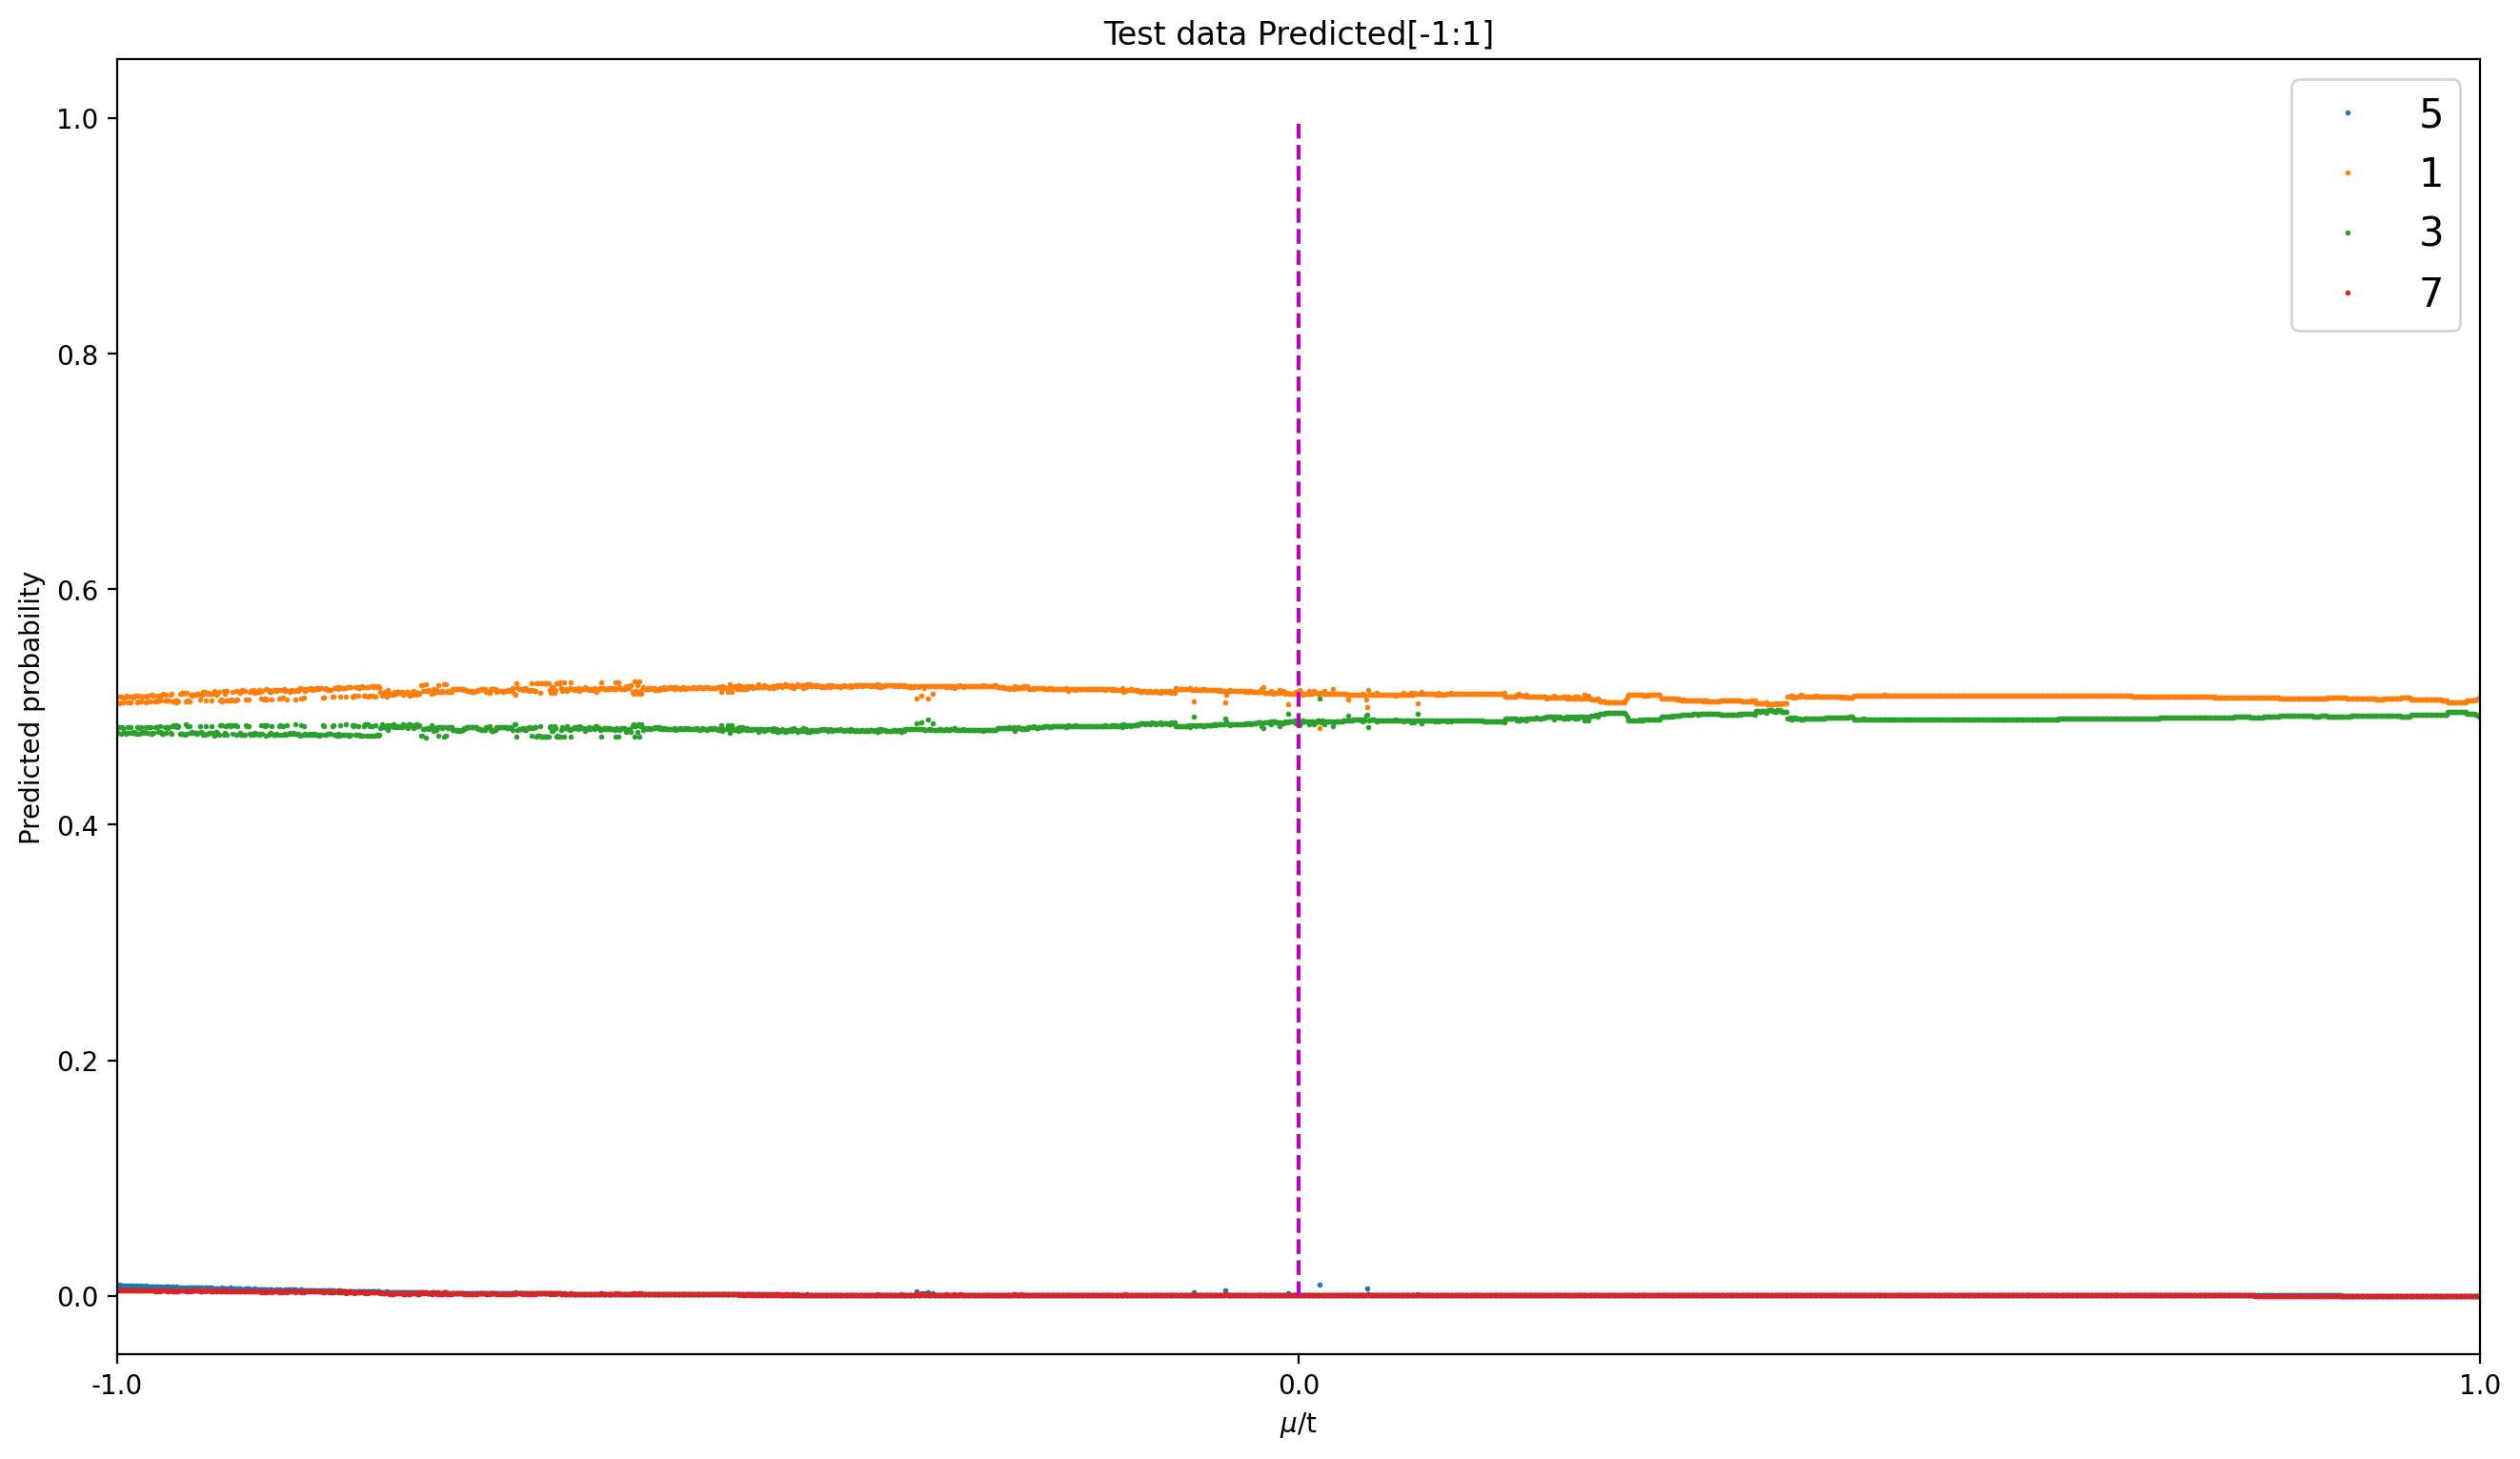

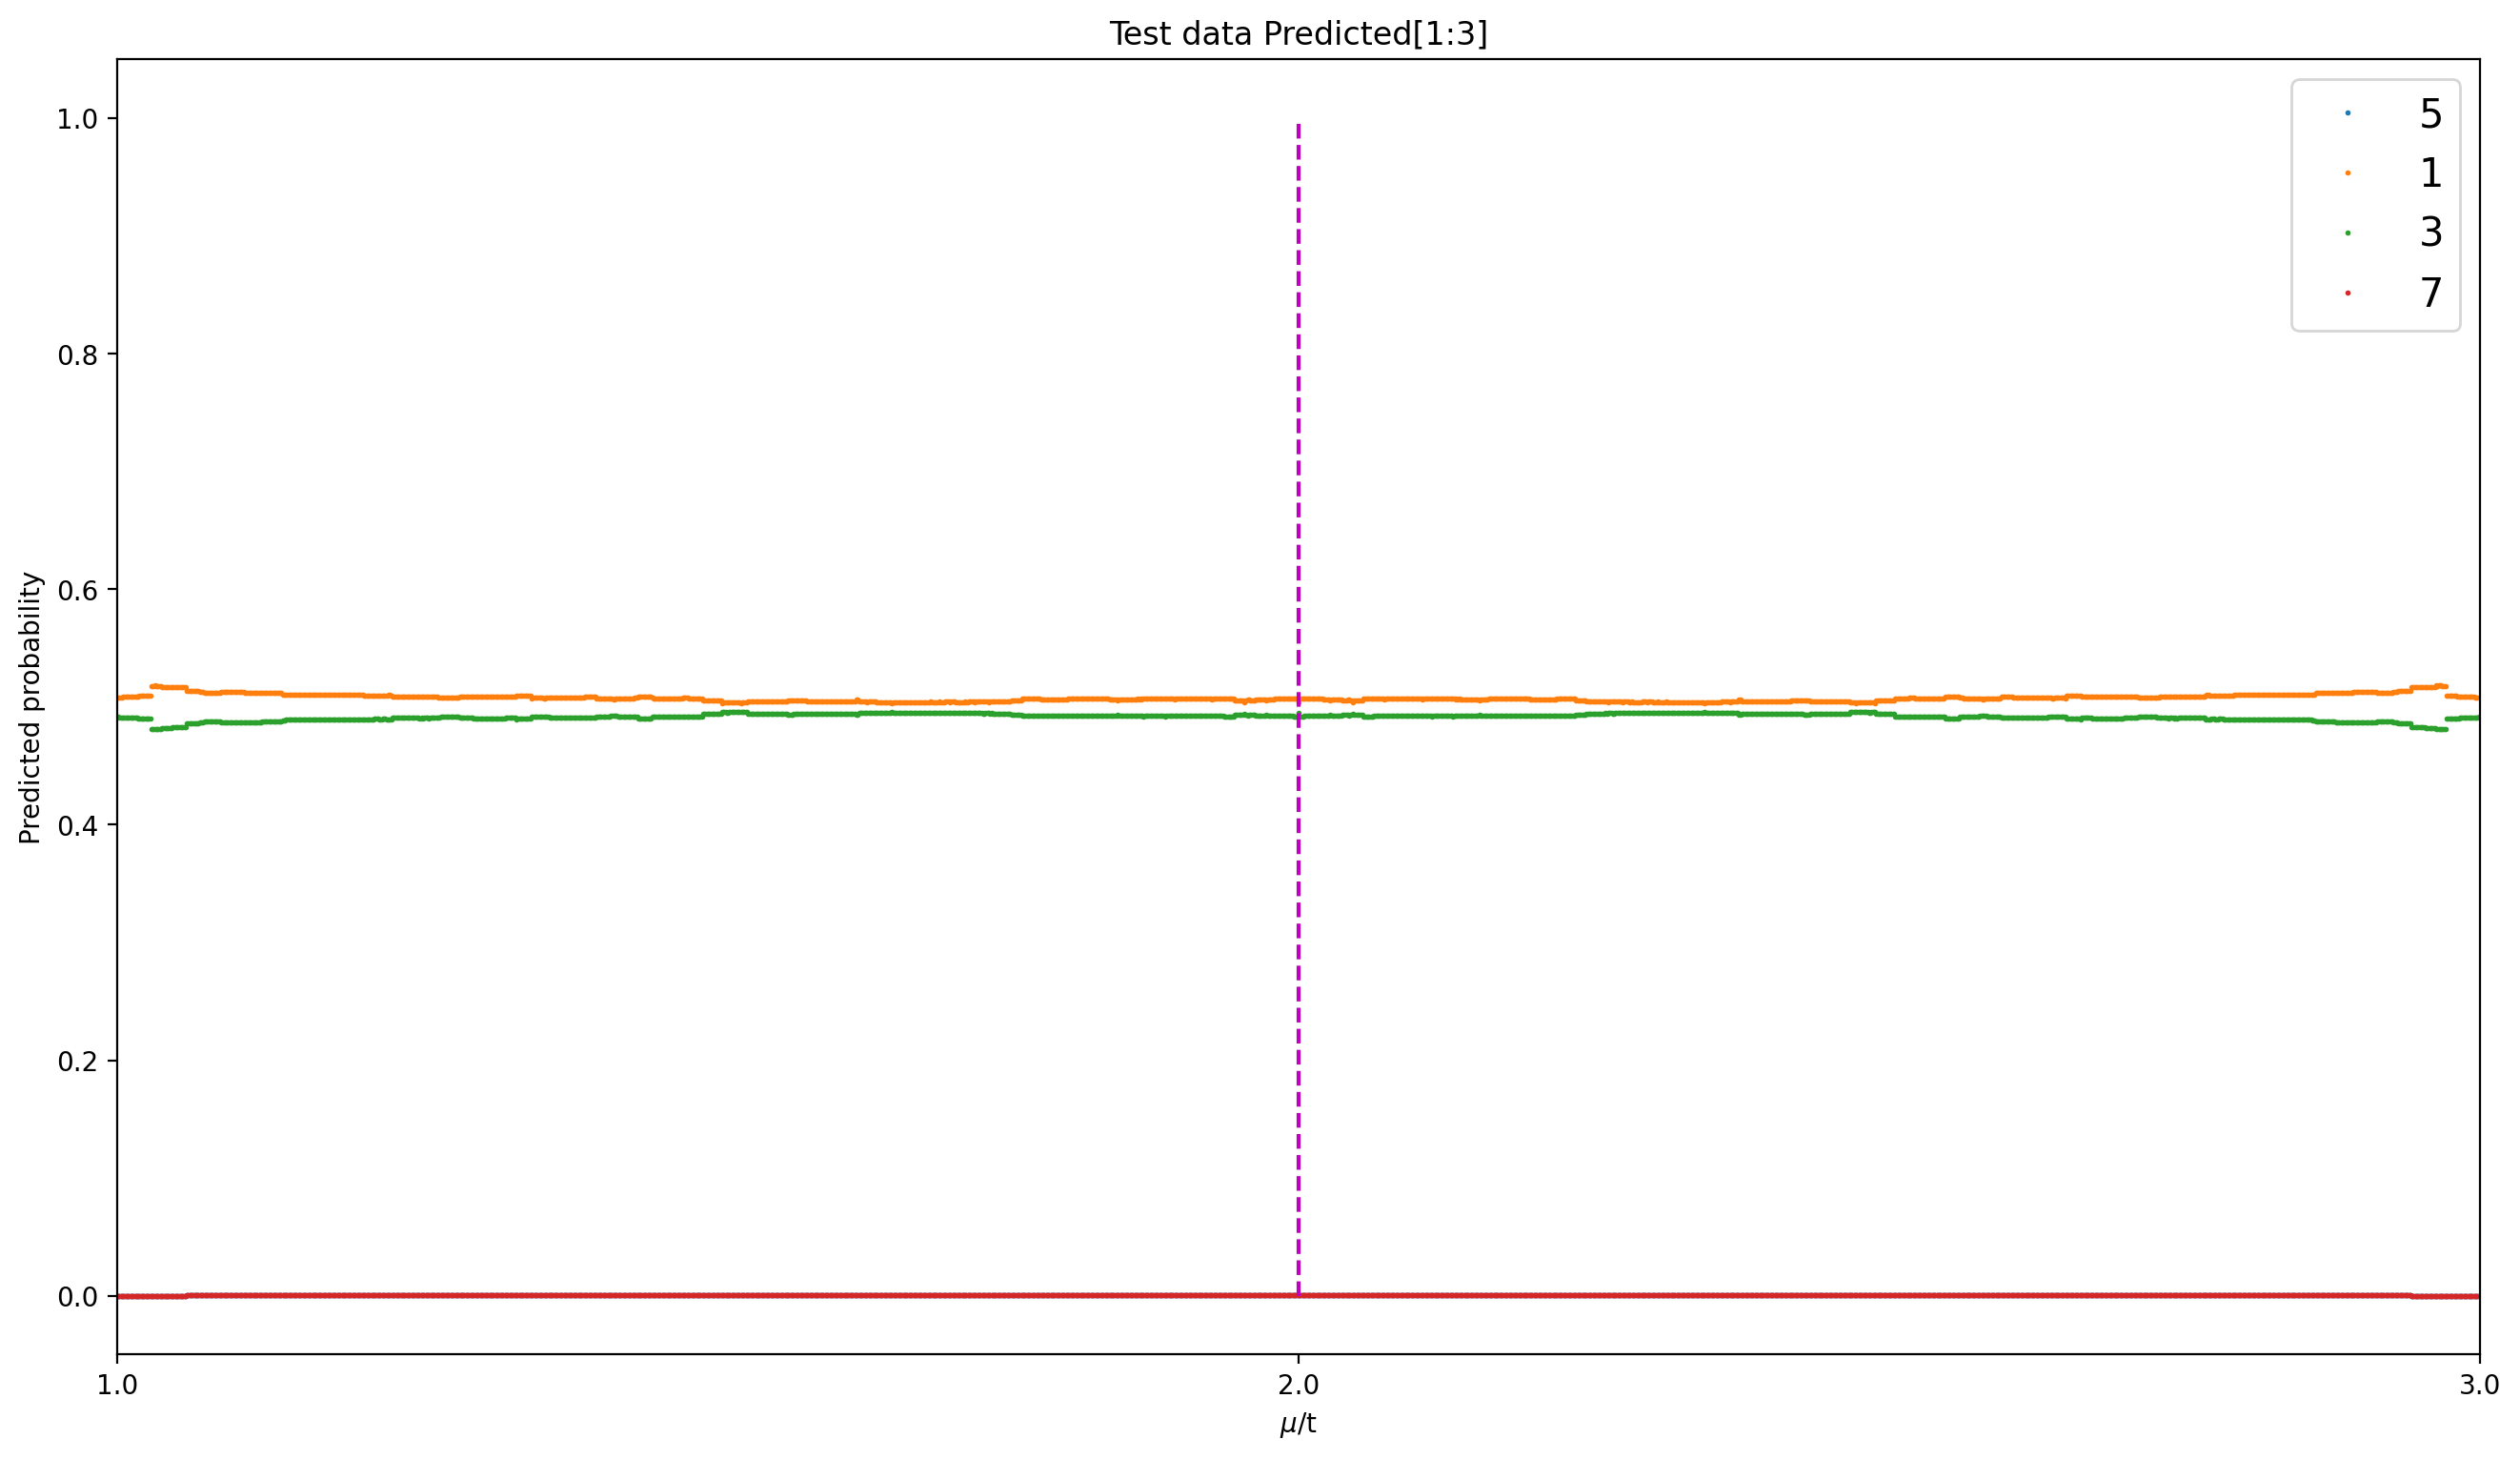

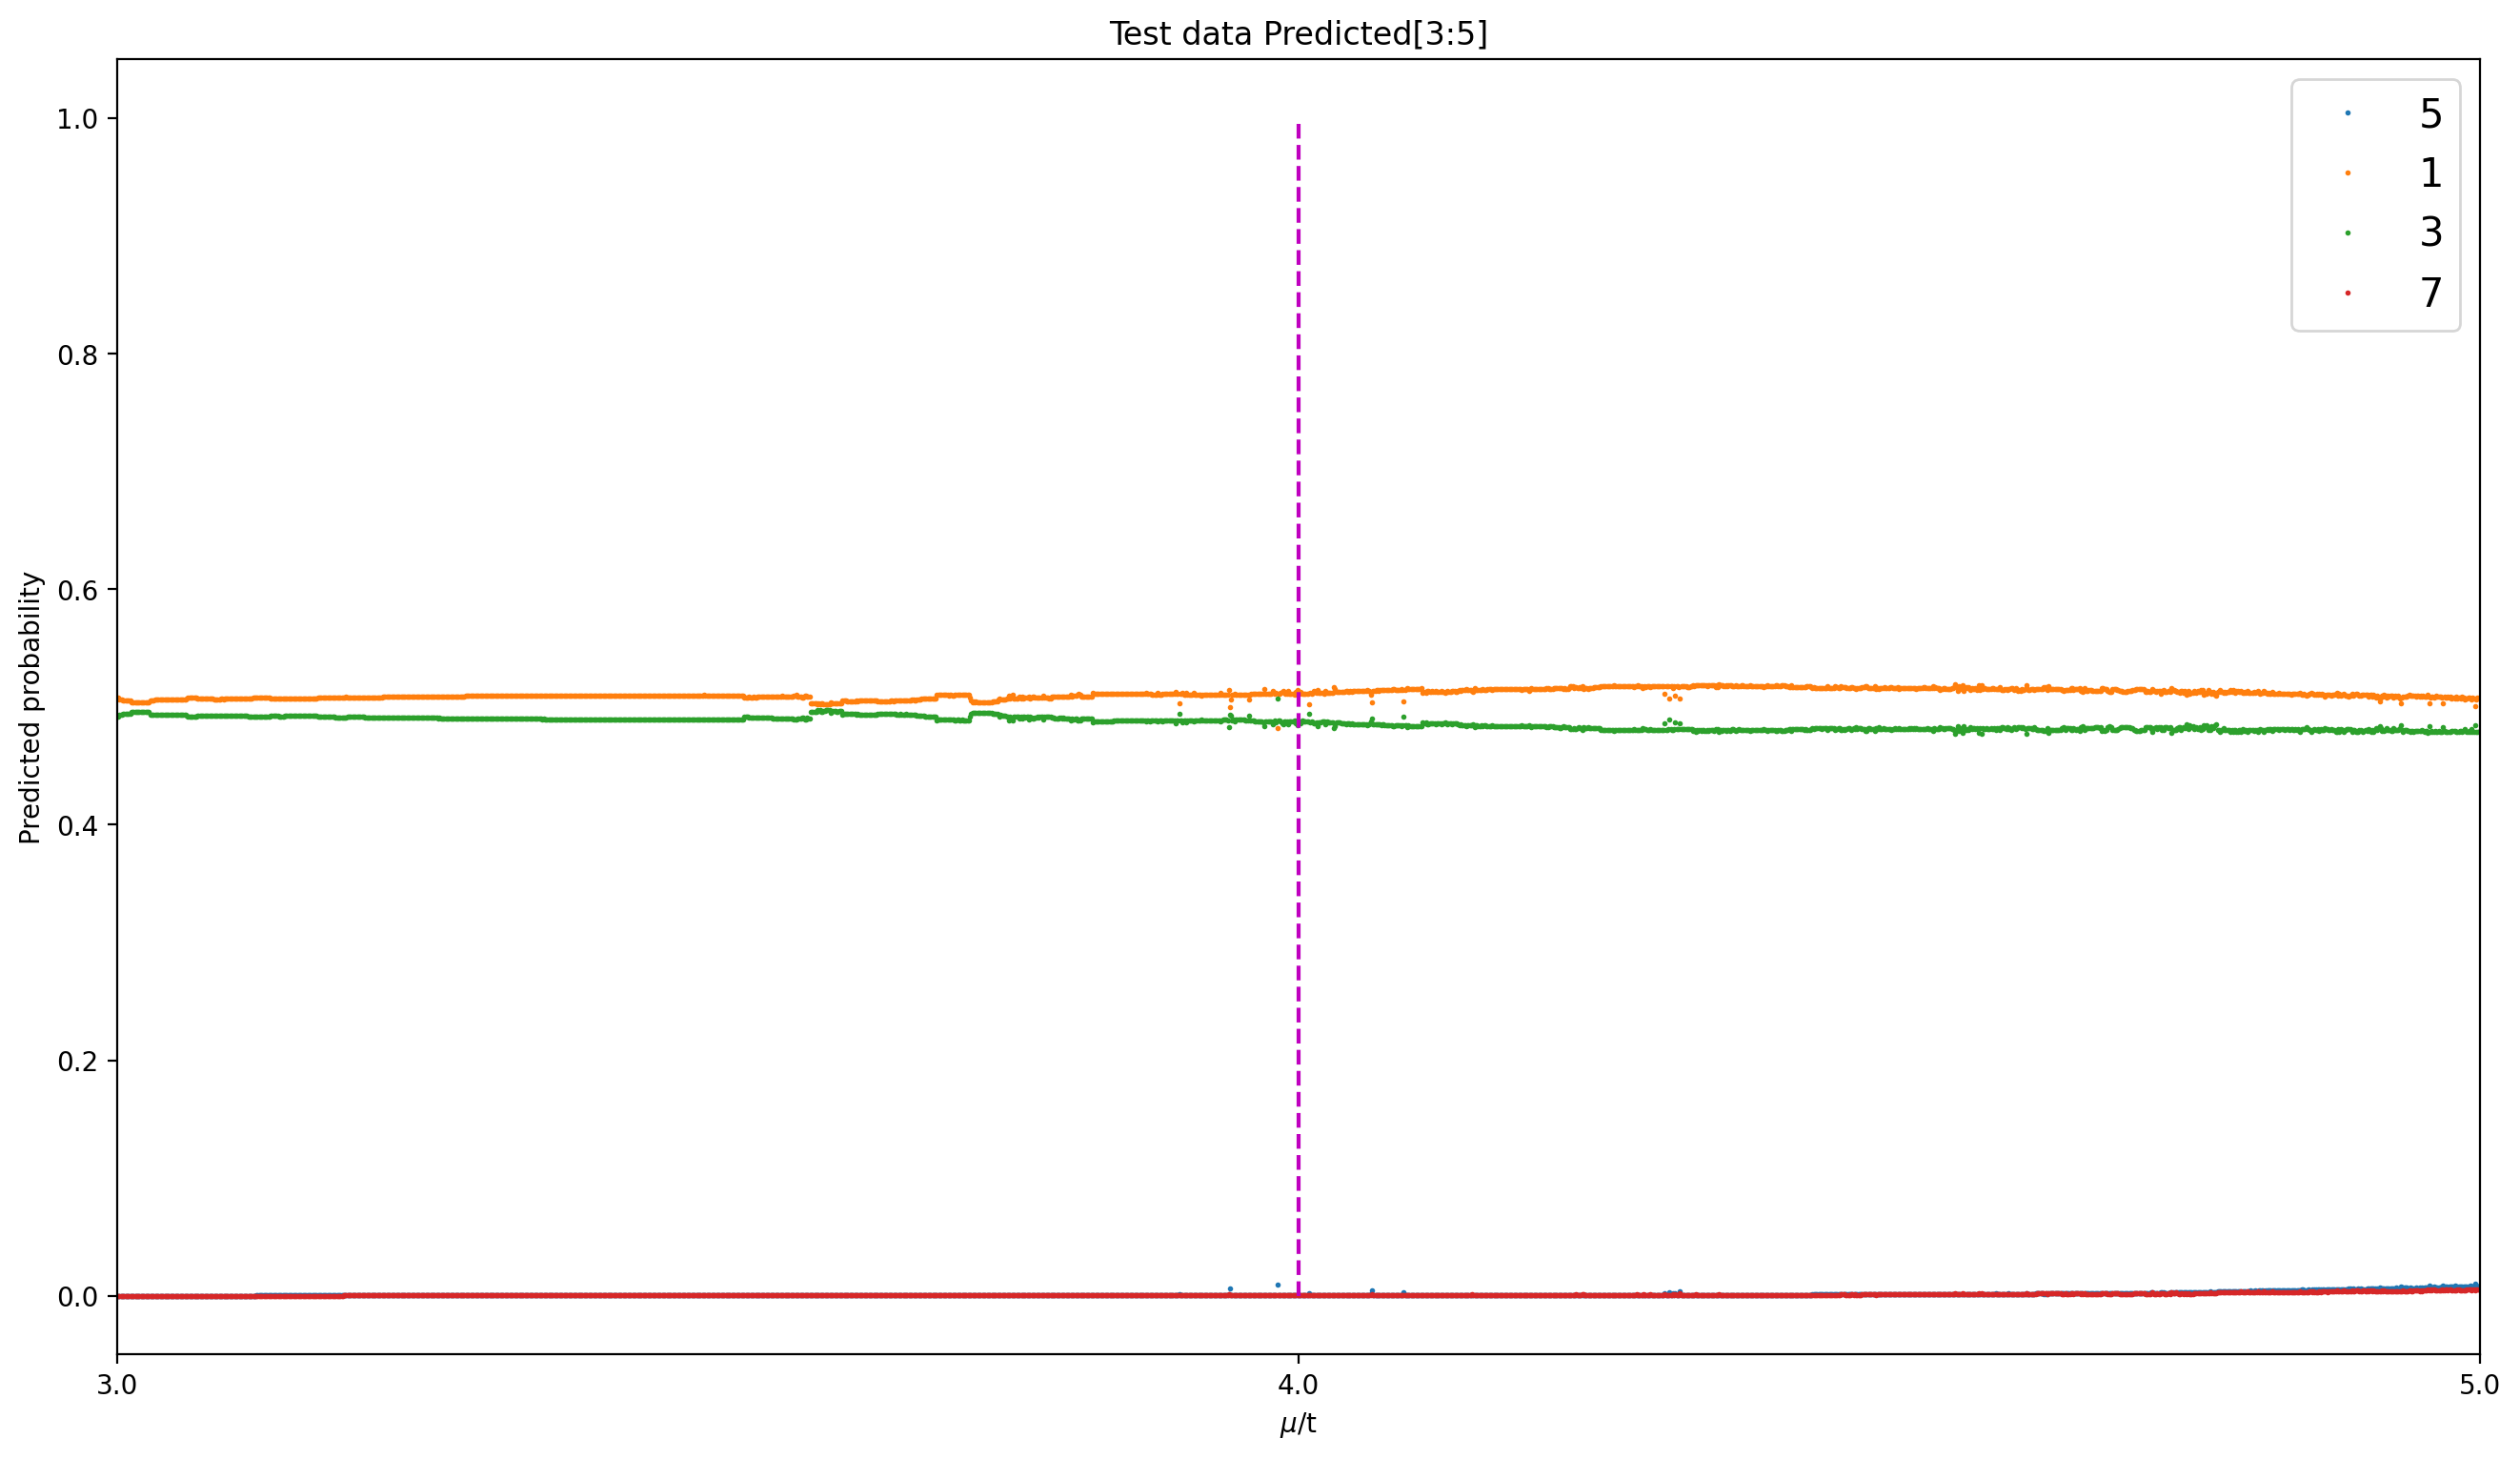

In [29]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_4D

開始獲取eigenvector_r_theta_4D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [30]:
train_data = get_train_data(train_data_path, date, N, delta)[4]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[4]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 128, 8, 8, 3)
(4000,)
(4000, 4)
(28001, 128, 8, 8, 3)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [31]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [32]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 128, 8, 8, 3)
(4000, 4)
Number of real trian data = 
(3200, 128, 8, 8, 3)
(3200, 4)
Number validation data = 
(800, 128, 8, 8, 3)
(800, 4)


開始架構網路

In [33]:
channel = 2*(NN**2)

model = Sequential()

model.add(Conv3D(batch_input_shape = (None, channel, NN, NN, 3),
                 filters = 2*channel,
                 kernel_size = (3,3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size = (2,2,2),
                       data_format = 'channels_first',
                       padding = 'same')
         )

model.add(Conv3D(filters = 3*channel, 
                 kernel_size = (3,3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size=(2,2,2),
                       data_format='channels_first',
                       padding = 'same')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 256, 8, 8, 3)      884992    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 256, 4, 4, 2)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 384, 4, 4, 2)      2654592   
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 384, 2, 2, 1)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [34]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [35]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 439us/step - loss: 0.0733 - accuracy: 0.9806 - val_loss: 1.1978e-04 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 349us/step - loss: 8.7138e-05 - accuracy: 1.0000 - val_loss: 6.8717e-05 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 352us/step - loss: 5.3696e-05 - accuracy: 1.0000 - val_loss: 4.4349e-05 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 353us/step - loss: 3.5566e-05 - accuracy: 1.0000 - val_loss: 3.0182e-05 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 352us/step - loss: 2.4739e-05 - accuracy: 1.0000 - val_loss: 2.1459e-05 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 349us/step - loss: 1.7914e-05 - accuracy: 1.0000 - val_loss: 1.5833e-05 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [===========

訓練完成  
開始提取模型資料

In [36]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


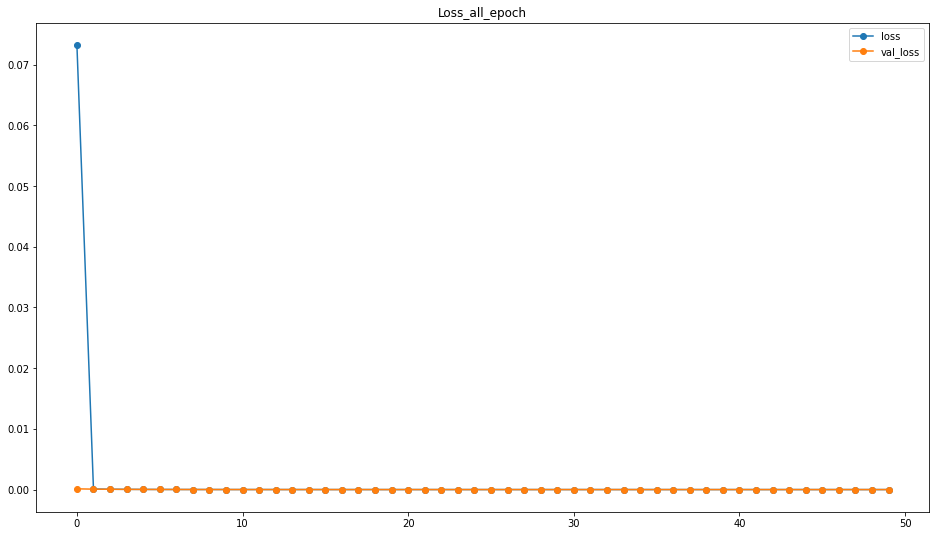

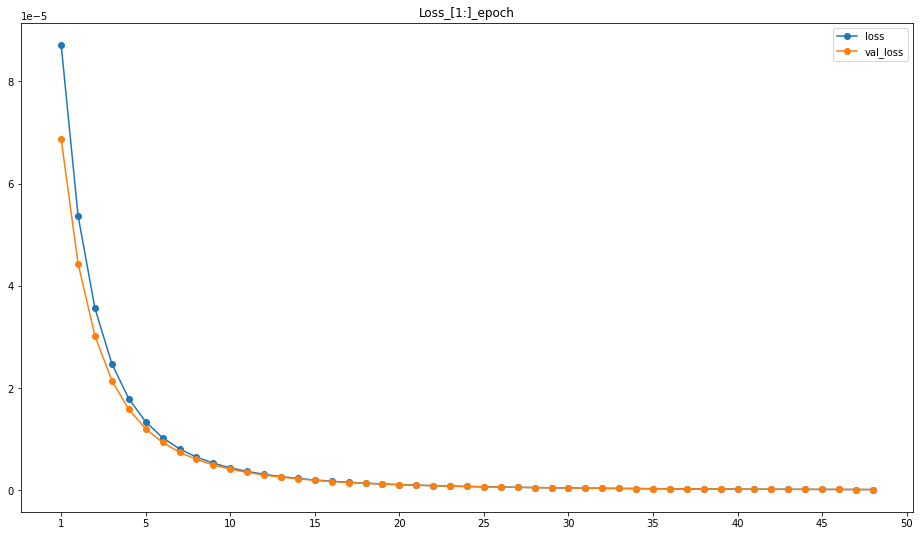

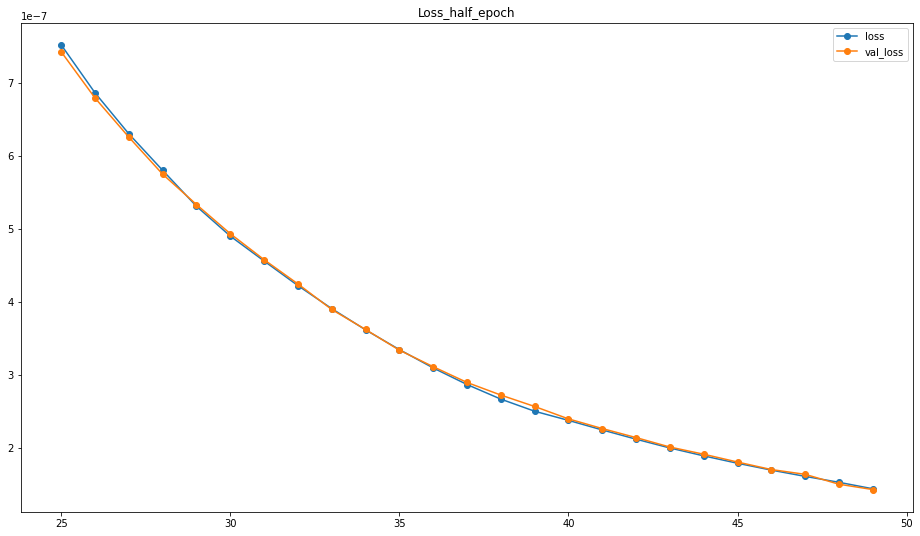

In [37]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [38]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 6s 226us/step


In [39]:
print (scores)

[0.07557084761426718, 0.9857504963874817]


In [40]:
prediction = model.predict(test_data)

In [41]:
print(prediction)

[[9.9999928e-01 2.6323923e-07 2.7889516e-07 1.9442558e-07]
 [9.9999905e-01 4.9303344e-07 3.6127418e-07 1.2997263e-07]
 [9.9999928e-01 2.4378016e-07 2.9912781e-07 1.3010549e-07]
 ...
 [5.7320915e-07 3.6973501e-07 1.3466833e-07 9.9999893e-01]
 [5.5050782e-07 6.2078698e-07 1.8352442e-07 9.9999857e-01]
 [8.9912209e-07 4.6338798e-07 2.4240171e-07 9.9999845e-01]]


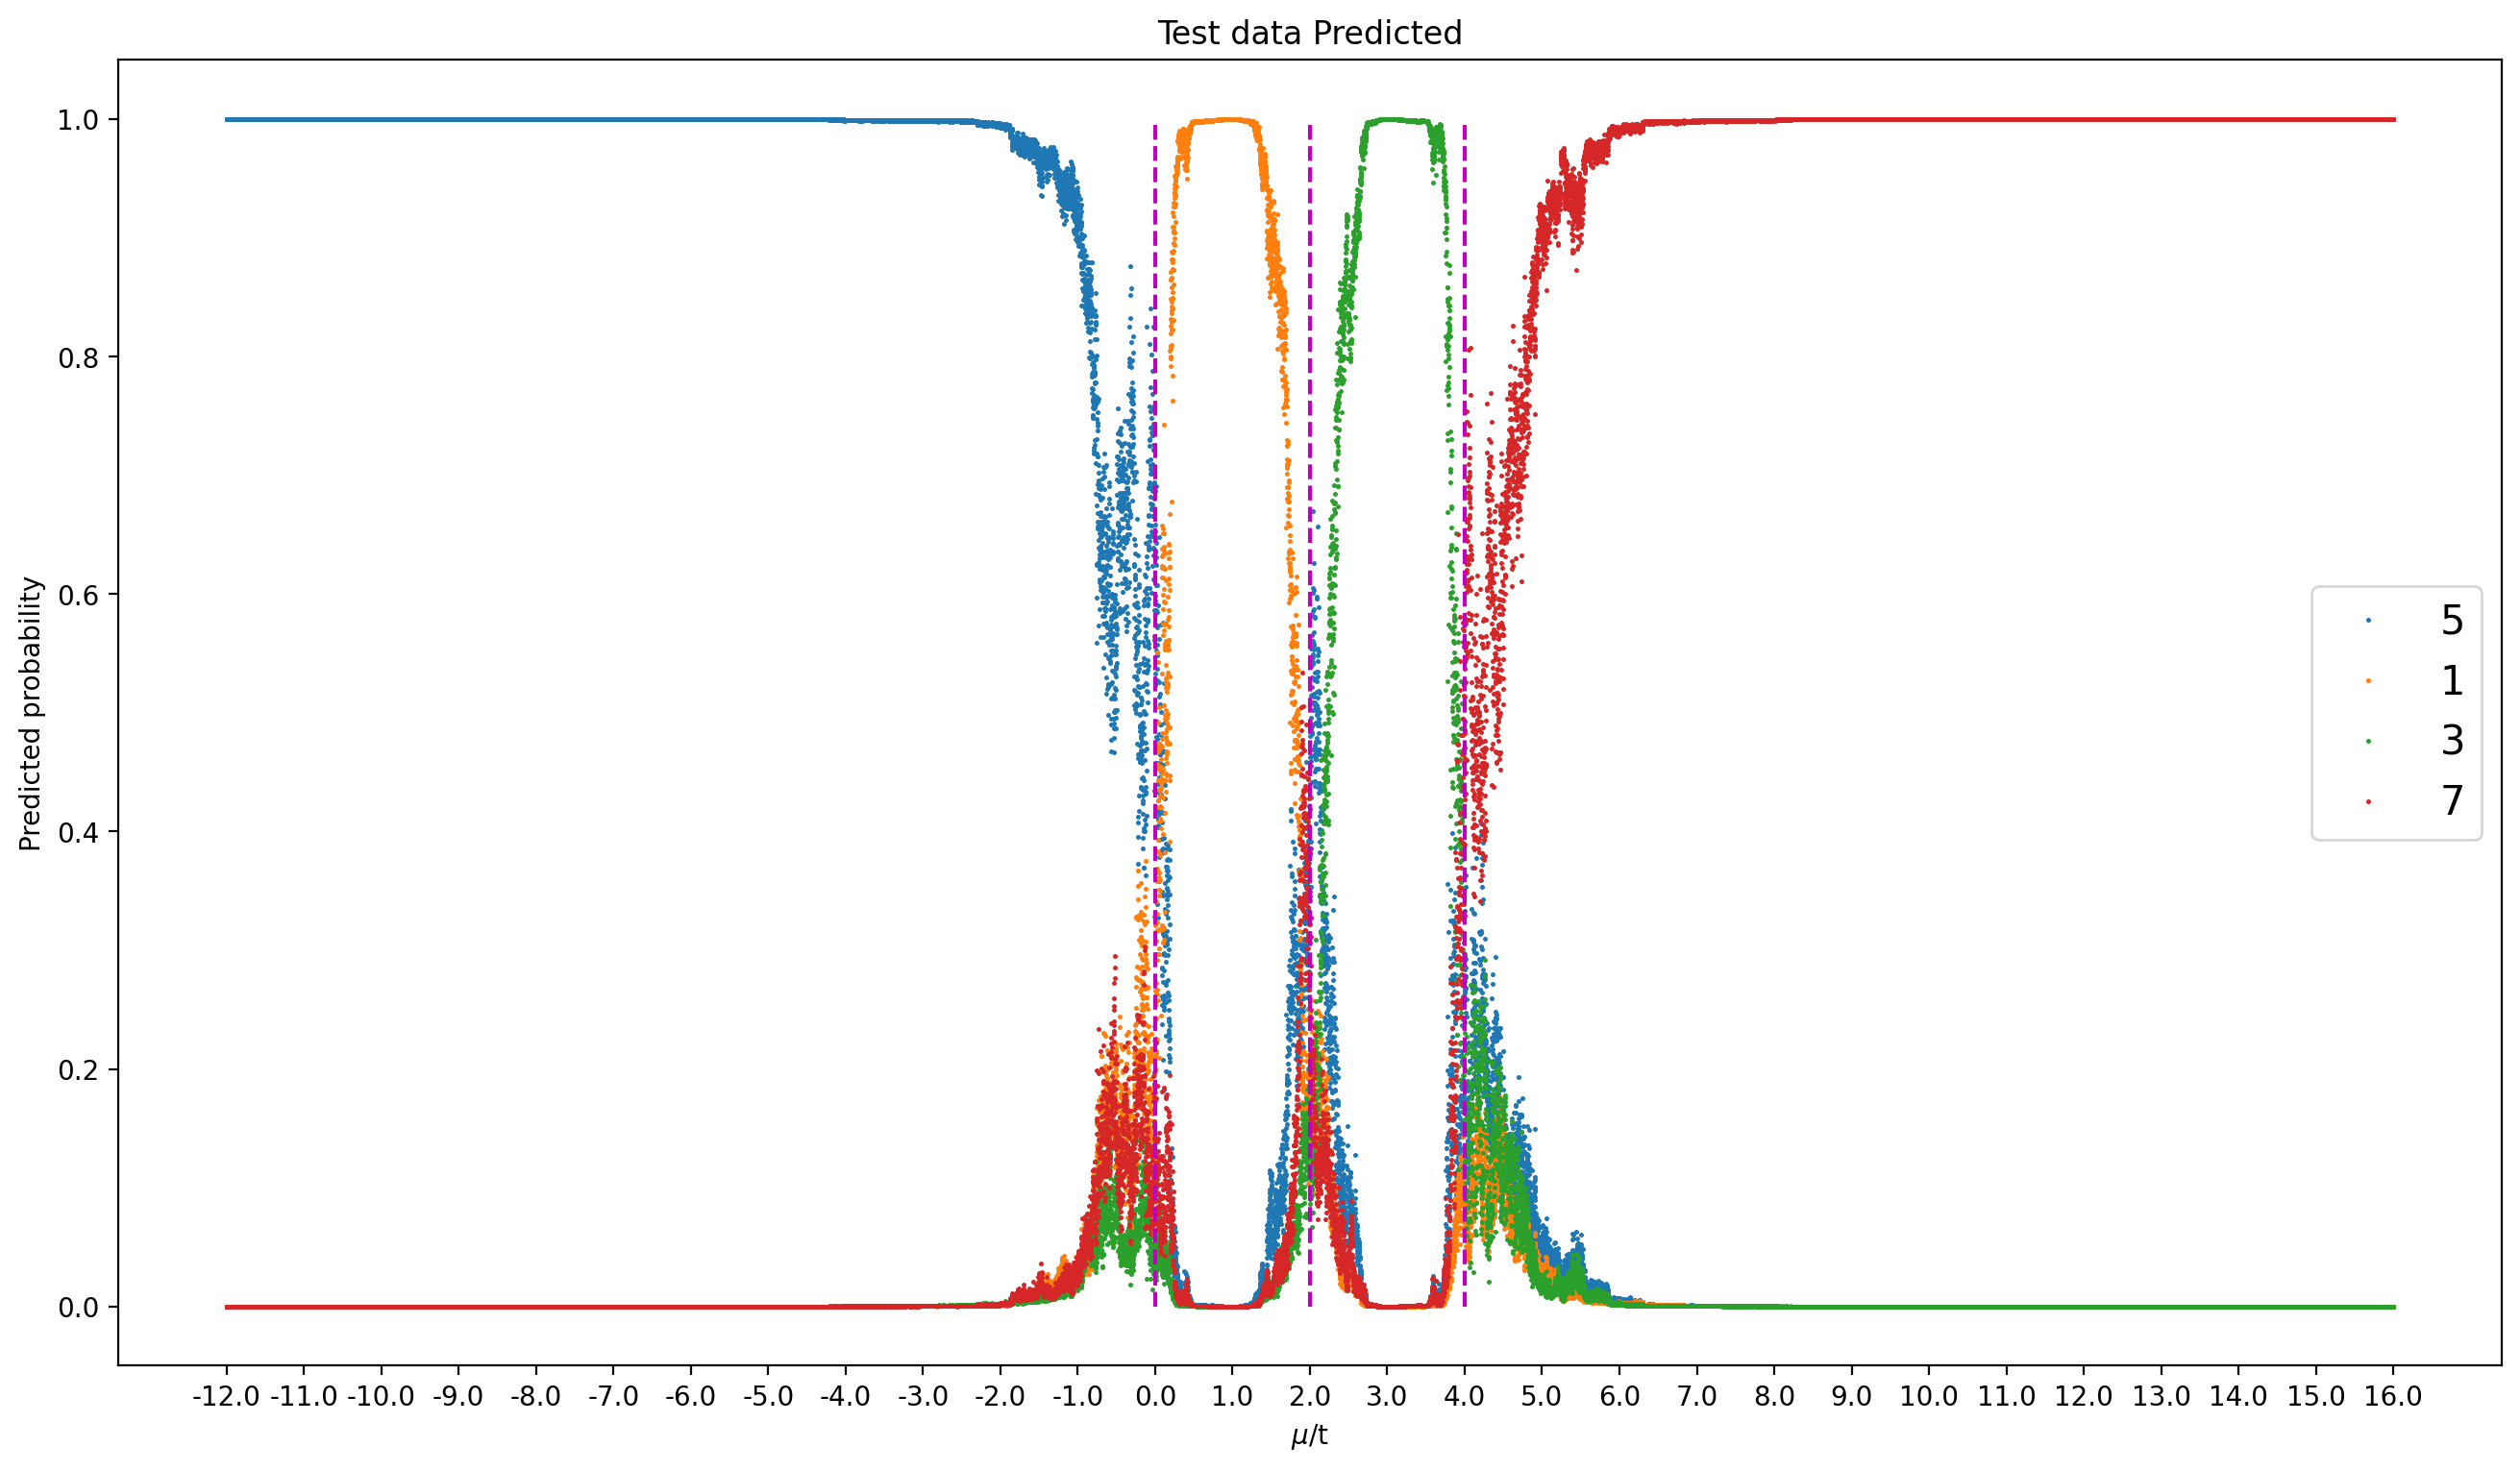

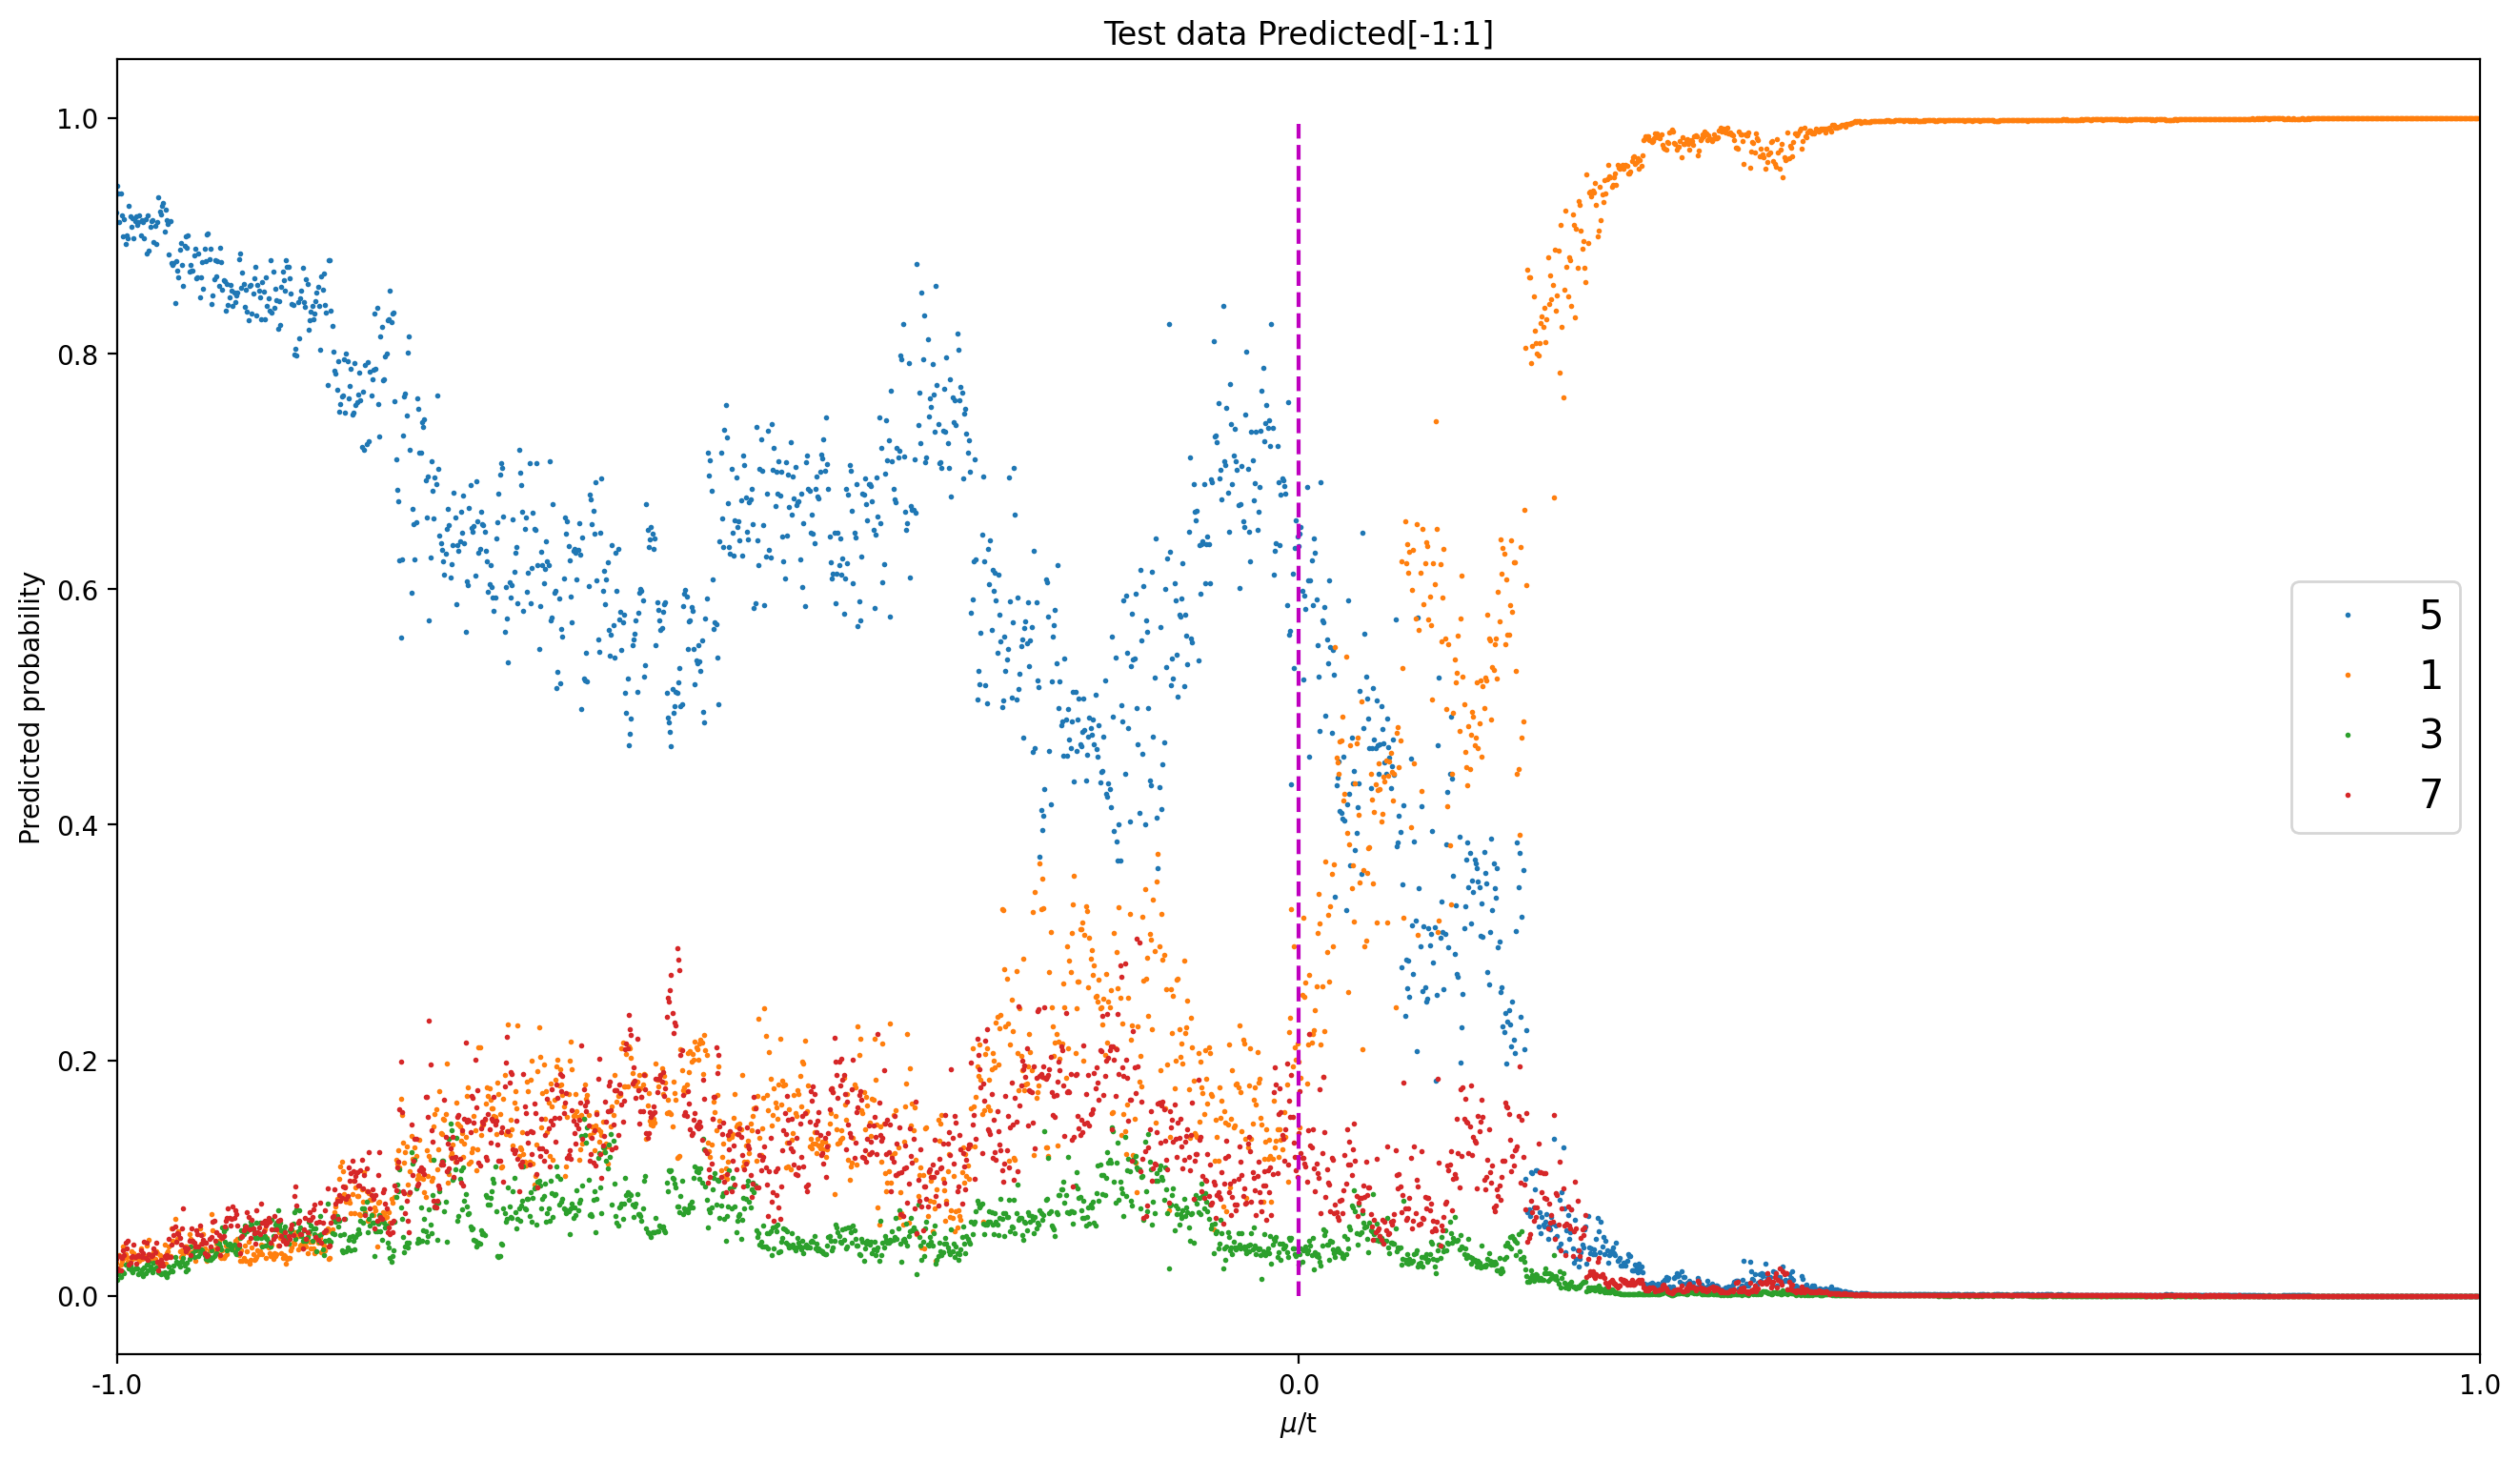

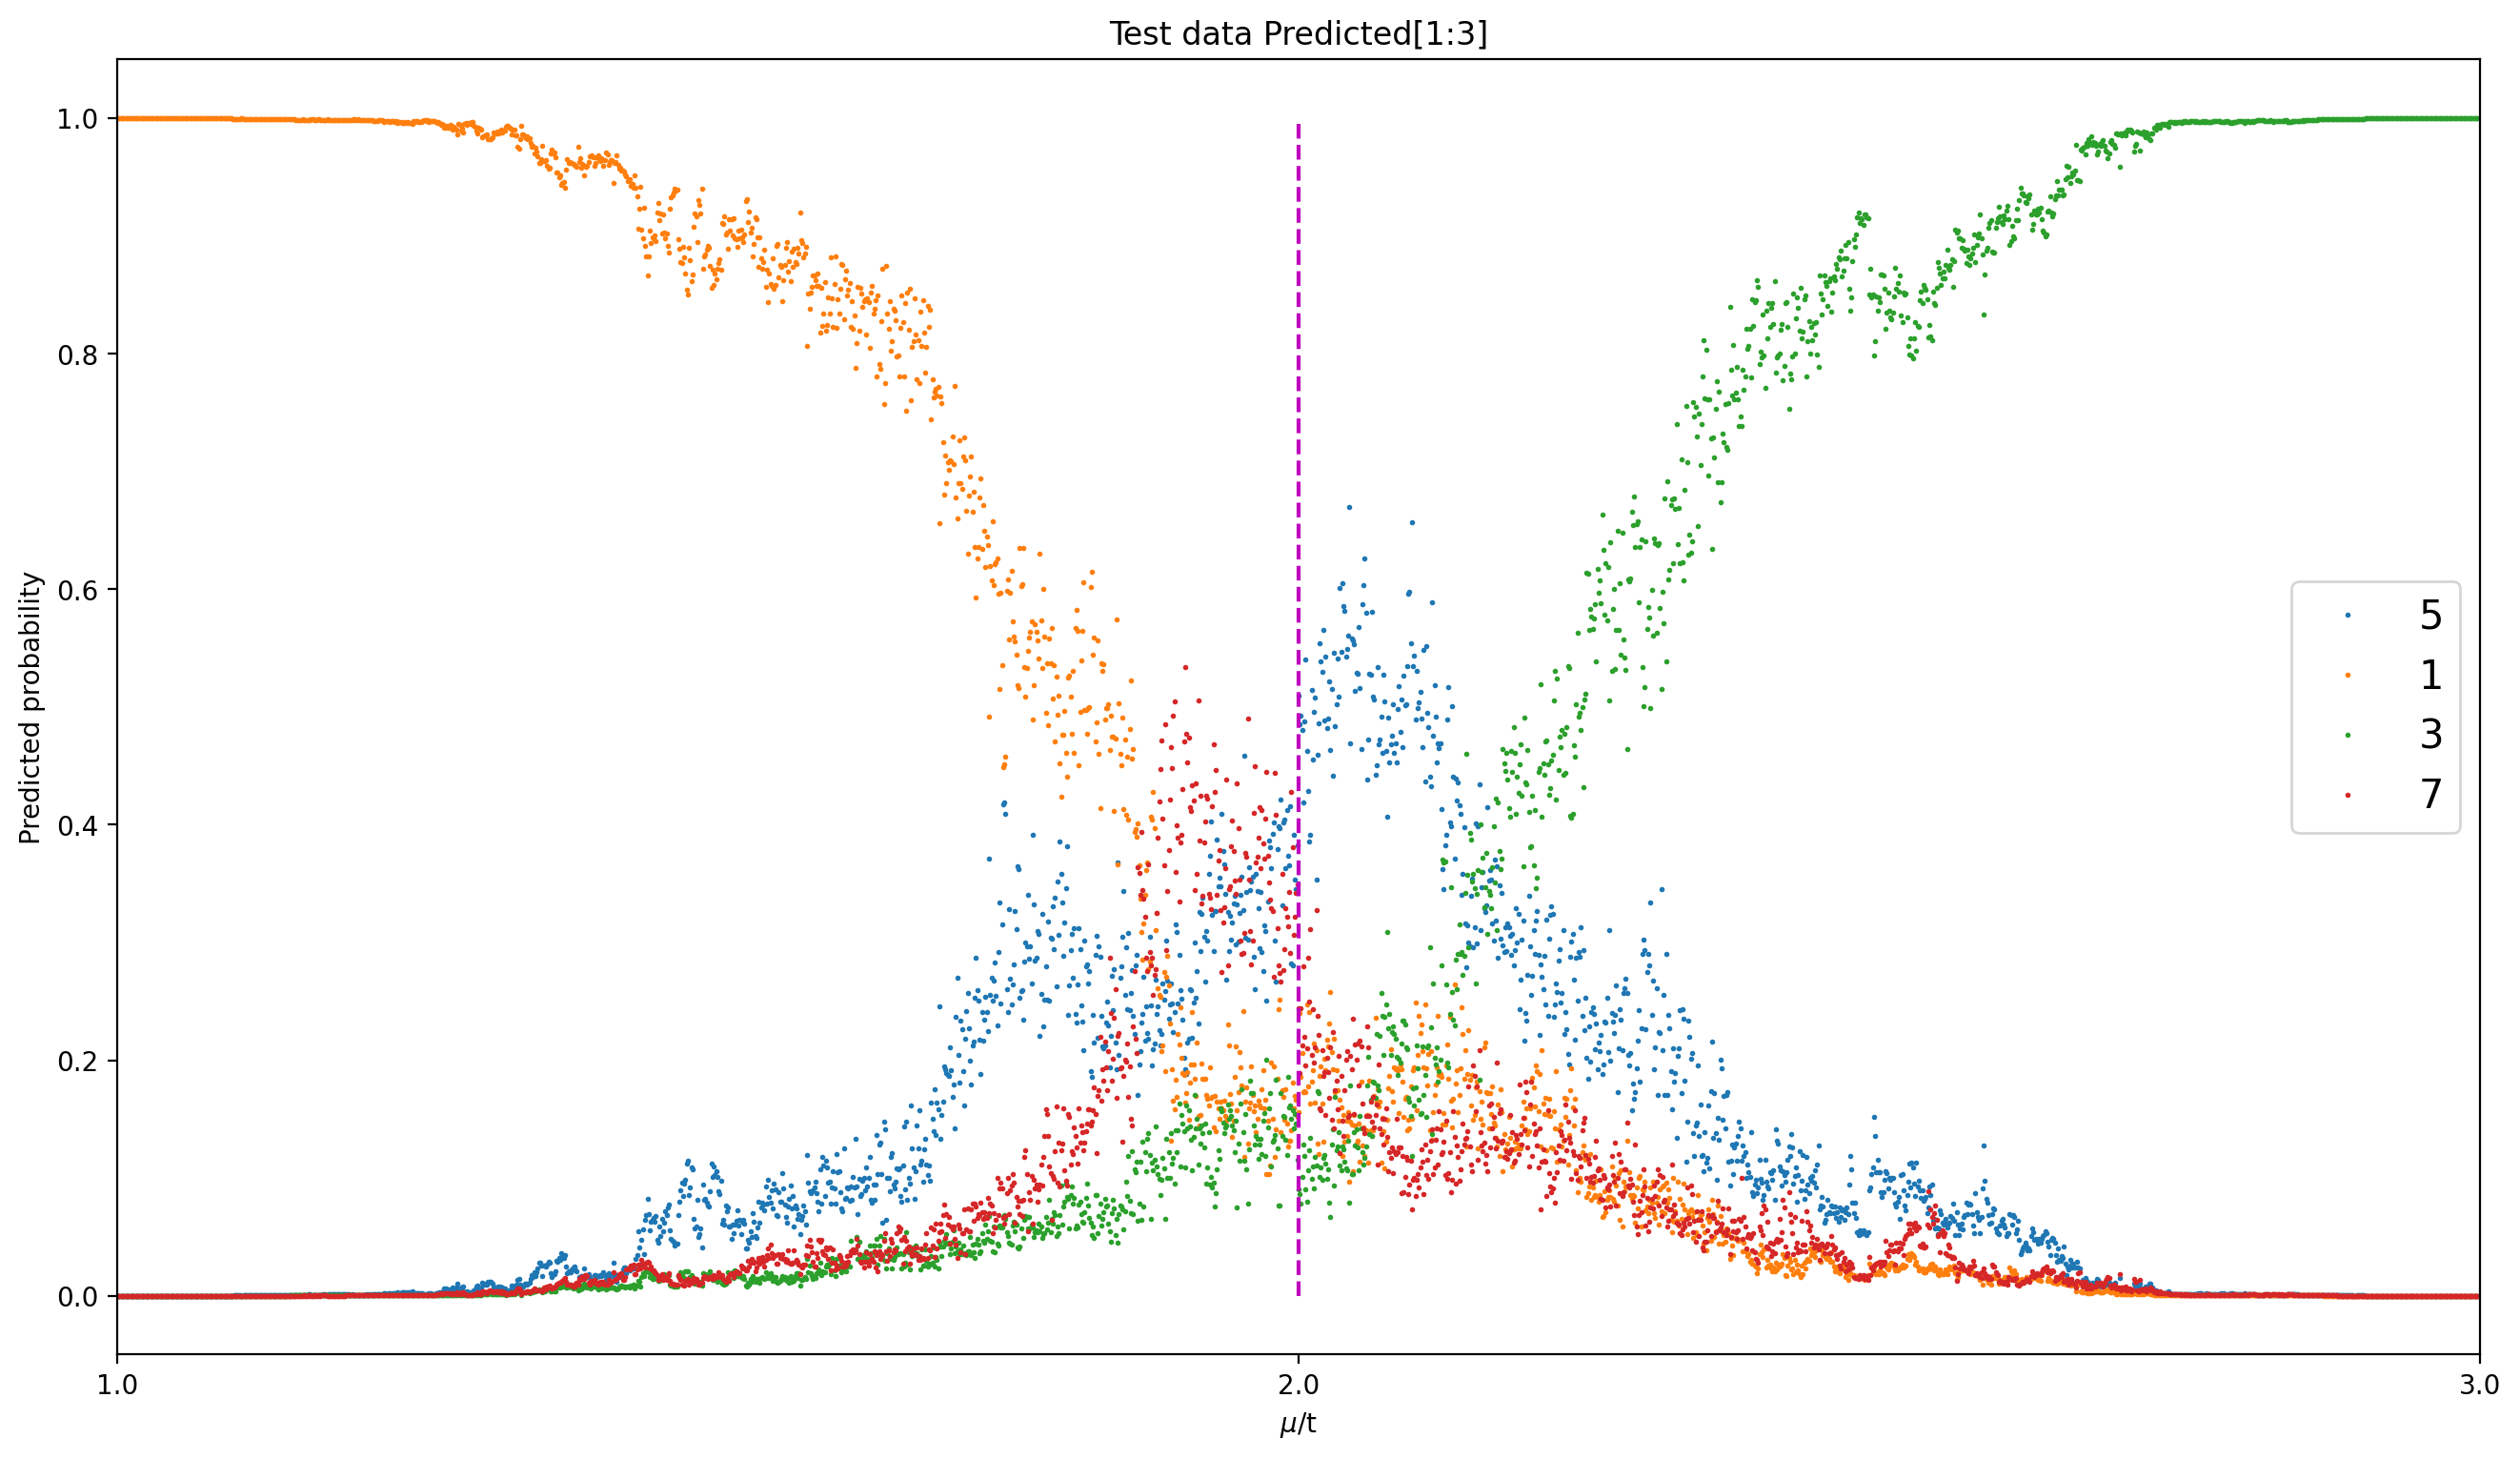

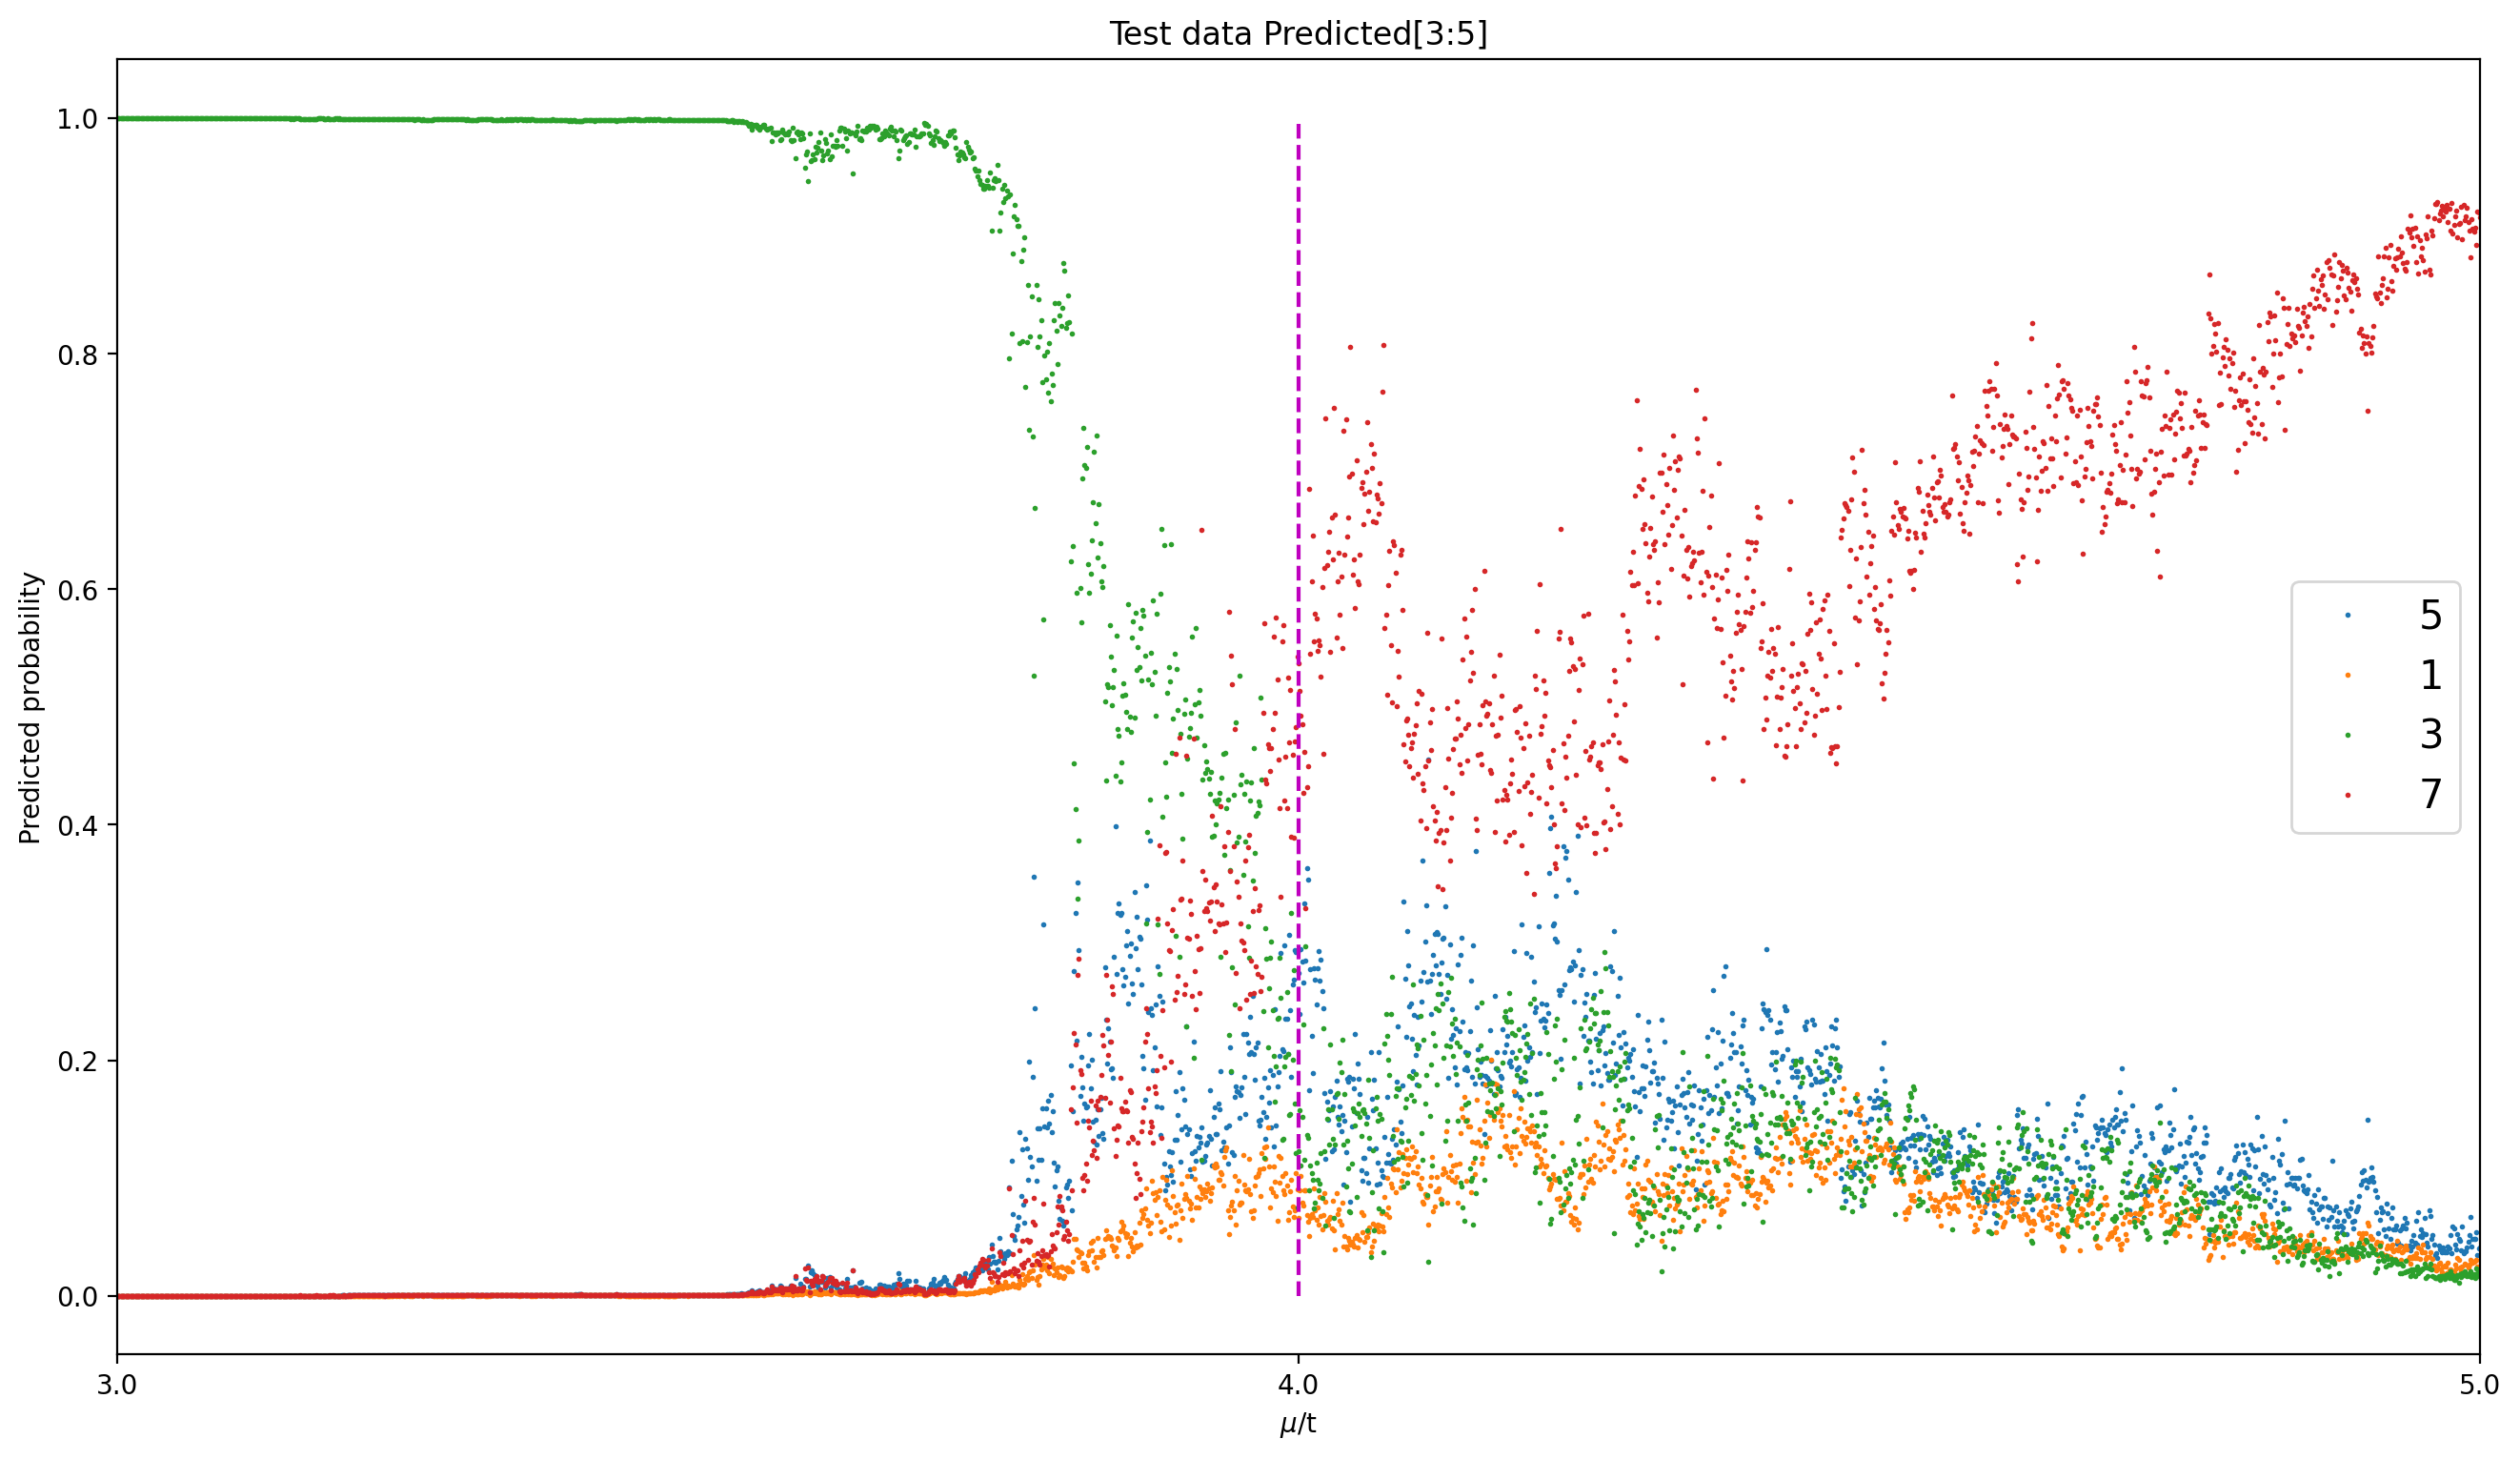

In [42]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_3D 抽中間兩根eigenvector

開始獲取eigenvector_r_theta_3D的資料，並抽出中間兩根eigenvector，並將phase轉成label  
並印出形狀確認是否正確

In [43]:
draw_out_parameters = int(((2*(NN**2)/2)-1)*3)

train_data = get_train_data(train_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)
print('draw_out_parameters = ' + str(draw_out_parameters))

(4000, 6, 8, 8)
(4000,)
(4000, 4)
(28001, 6, 8, 8)
(28001,)
(28001, 4)
draw_out_parameters = 189


將train data, train_one_hot_label 同步打亂

In [44]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [45]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 6, 8, 8)
(4000, 4)
Number of real trian data = 
(3200, 6, 8, 8)
(3200, 4)
Number validation data = 
(800, 6, 8, 8)
(800, 4)


開始架構網路

In [46]:
channel = 6

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 32,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 8, 8)          1760      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 4, 4)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 4, 4)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 2, 2)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

In [47]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [48]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 179us/step - loss: 0.8867 - accuracy: 0.9059 - val_loss: 0.3875 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 0s 110us/step - loss: 0.1584 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 0s 112us/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 0s 112us/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 0s 110us/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 0s 108us/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [==============================] - 0s 109us/step - loss:

訓練完成  
開始提取模型資料

In [49]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


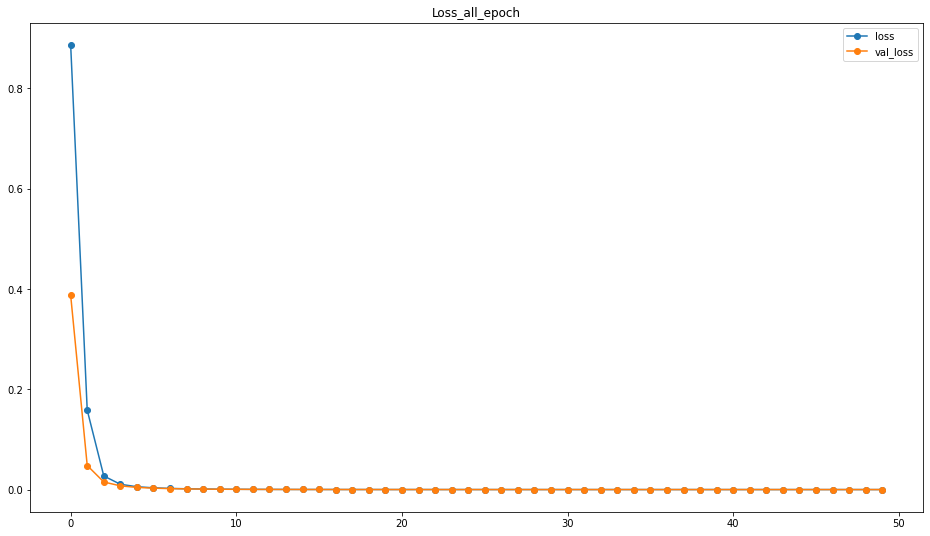

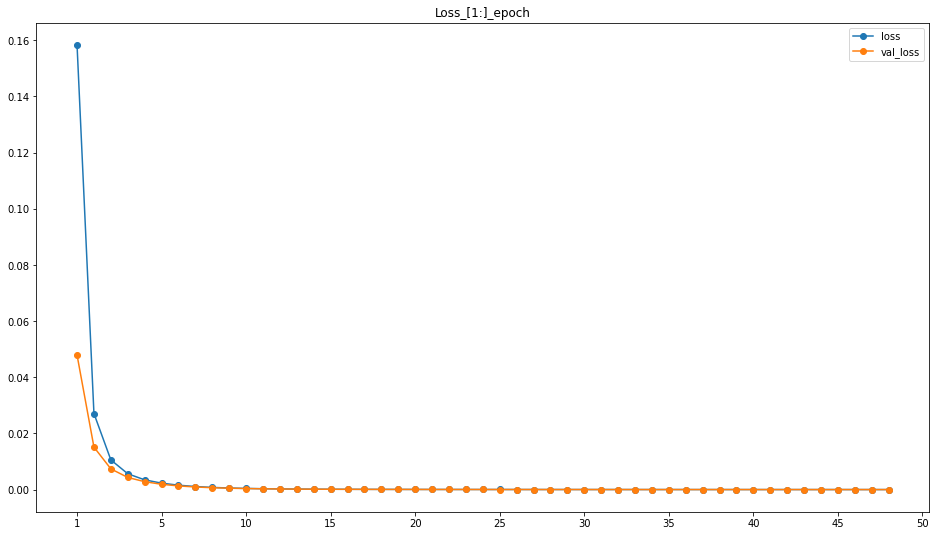

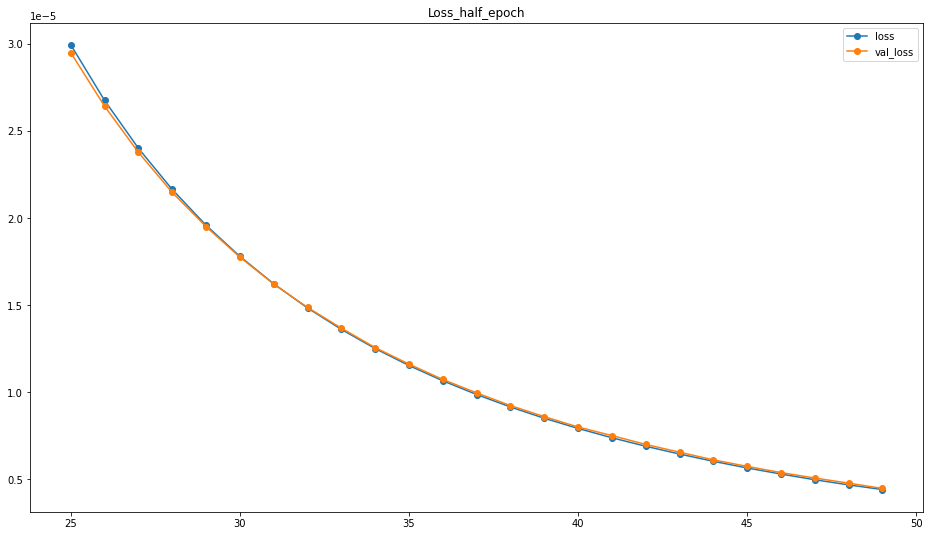

In [50]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [51]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 59us/step


In [52]:
print (scores)

[0.3174235117688308, 0.935752272605896]


In [53]:
prediction = model.predict(test_data)

In [54]:
print(prediction)

[[9.9999440e-01 1.4036032e-06 1.9000967e-06 2.2250783e-06]
 [9.9999440e-01 1.4035710e-06 1.9000457e-06 2.2250656e-06]
 [9.9999440e-01 1.4035377e-06 1.8999879e-06 2.2250465e-06]
 ...
 [1.7966402e-06 1.7858371e-06 1.0455481e-06 9.9999535e-01]
 [1.7966574e-06 1.7858337e-06 1.0455371e-06 9.9999535e-01]
 [9.5906455e-07 1.1951653e-06 1.6507049e-06 9.9999619e-01]]


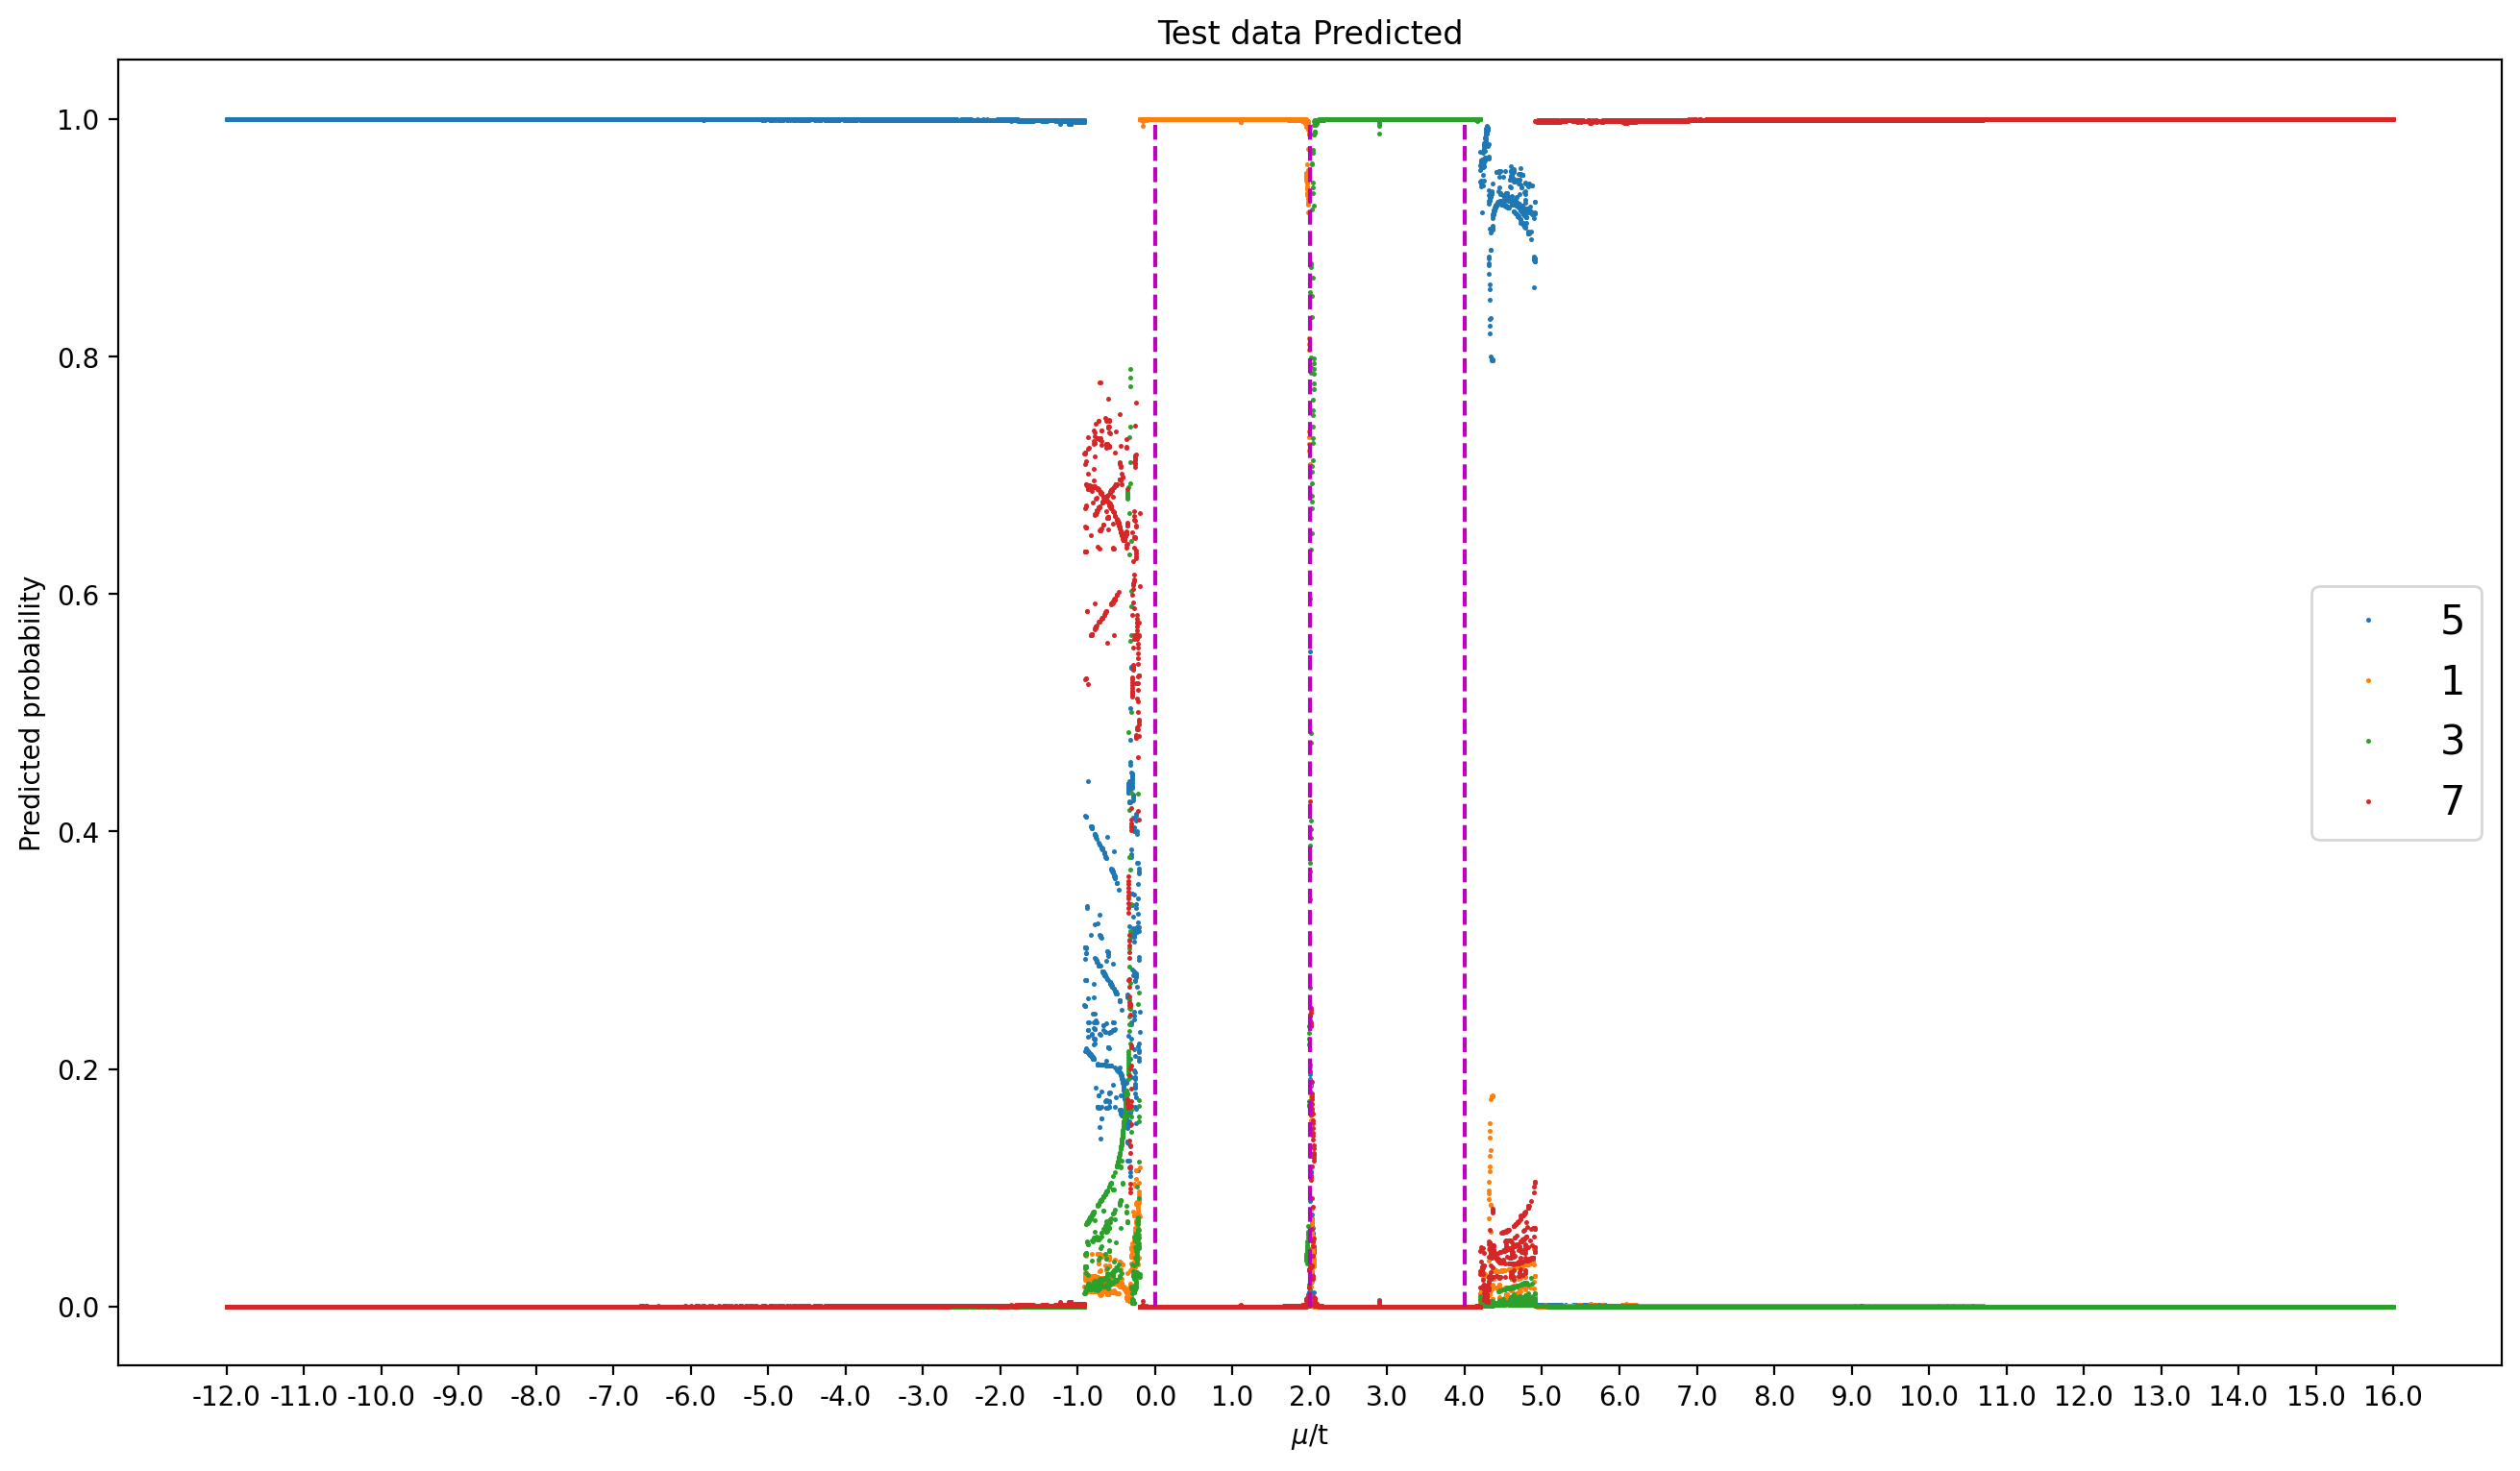

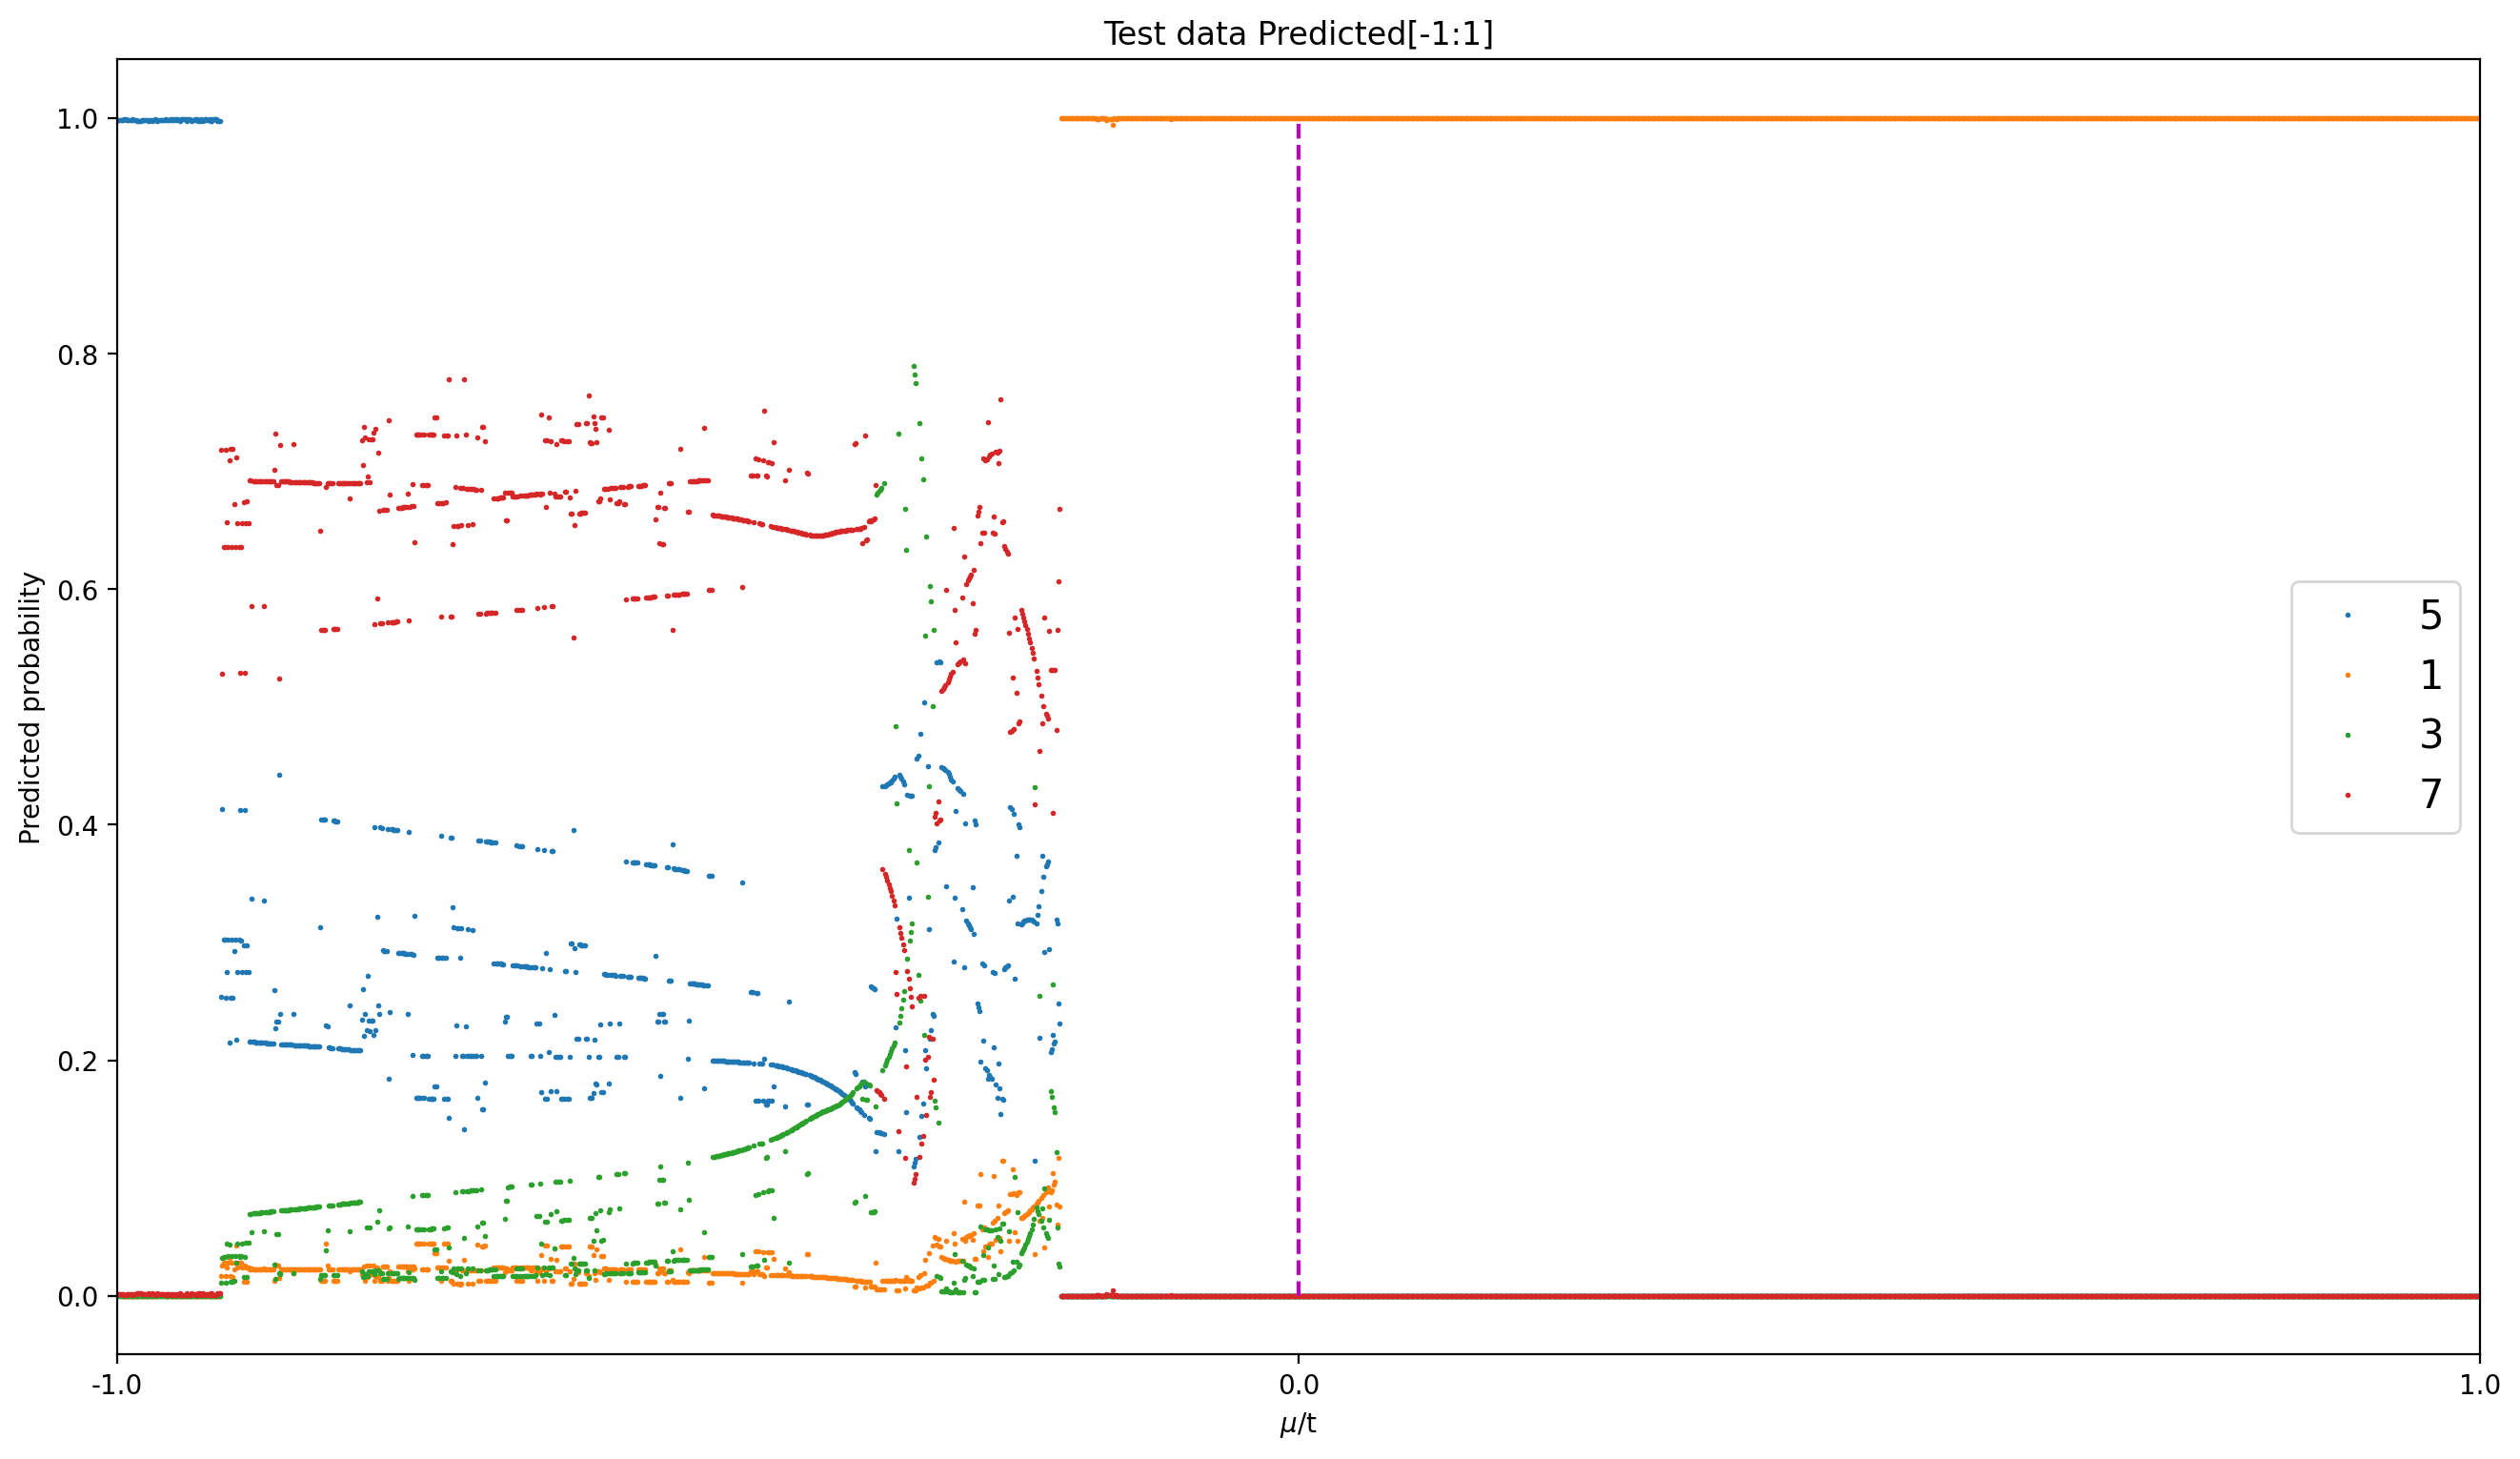

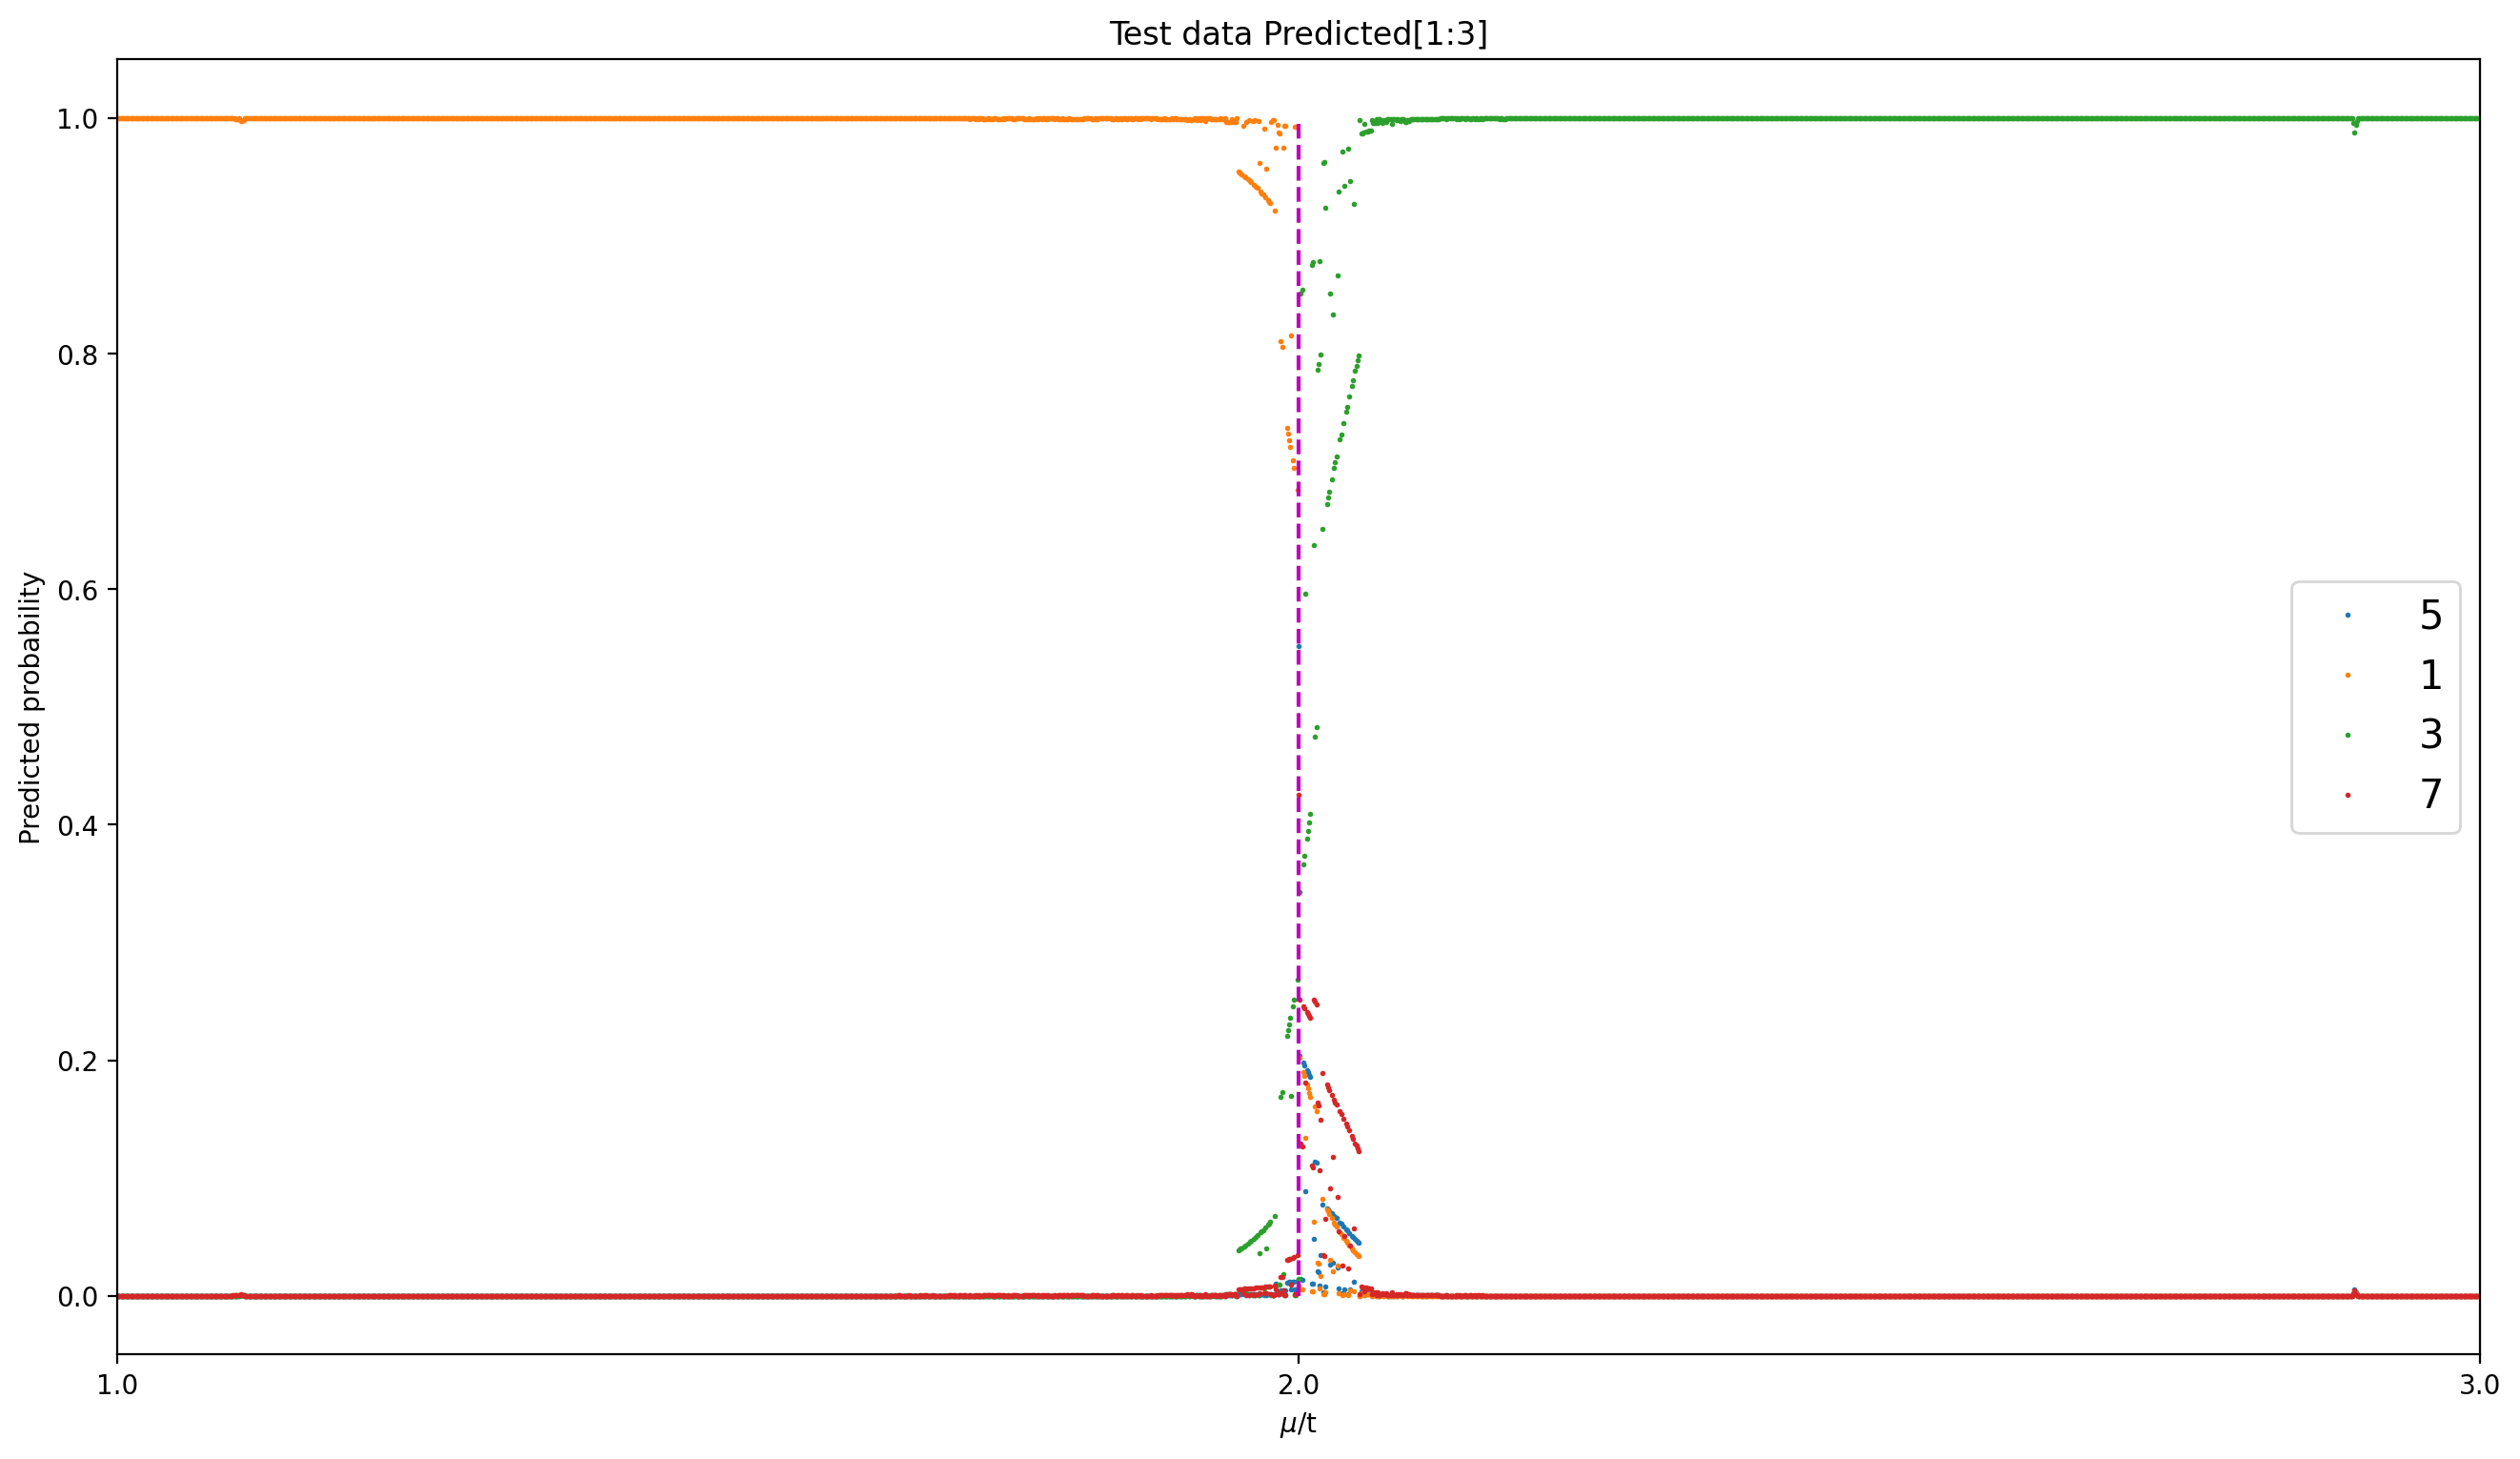

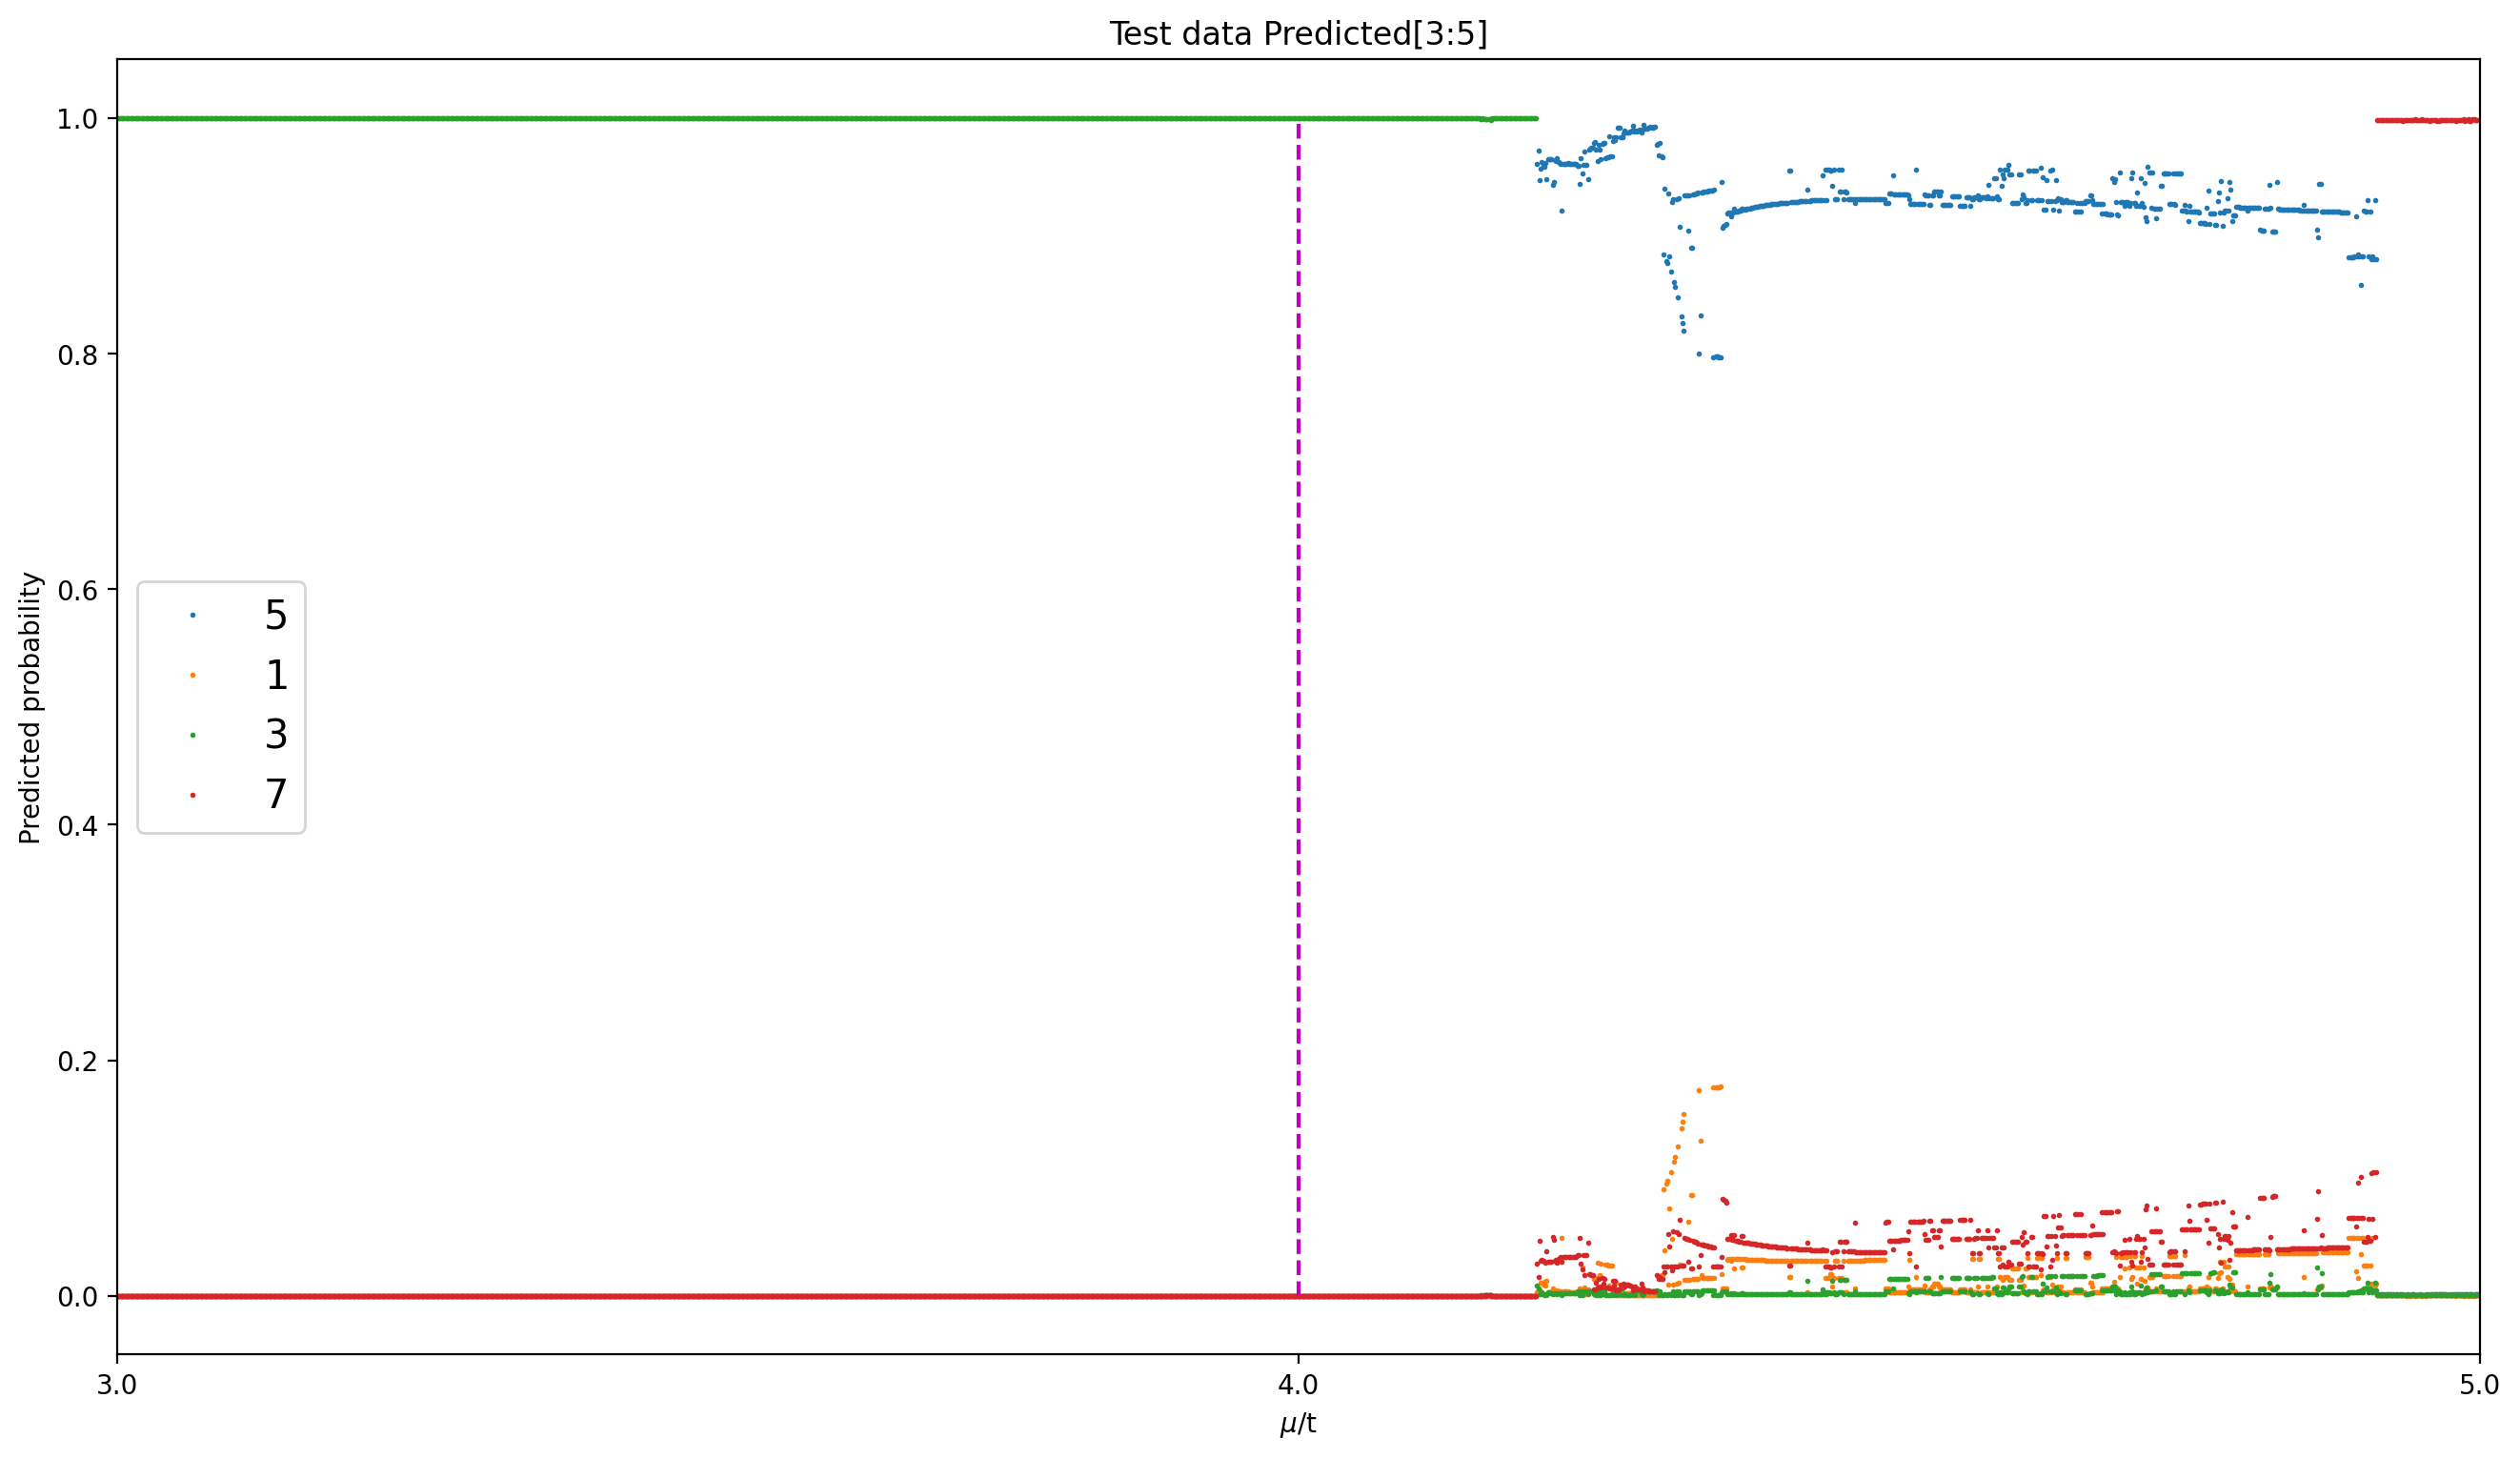

In [55]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_4D  抽中間兩包eigenvector

開始獲取eigenvector_r_theta_4D的資料，並抽出中間兩包eigenvector，並將phase轉成label  
並印出形狀確認是否正確

In [56]:
draw_out_parameters = int(((2*(NN**2)/2)-1))

train_data = get_train_data(train_data_path, date, N, delta)[4][:,draw_out_parameters:draw_out_parameters+6,:,:]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[4][:,draw_out_parameters:draw_out_parameters+6,:,:]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 6, 8, 8, 3)
(4000,)
(4000, 4)
(28001, 6, 8, 8, 3)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [57]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [58]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 6, 8, 8, 3)
(4000, 4)
Number of real trian data = 
(3200, 6, 8, 8, 3)
(3200, 4)
Number validation data = 
(800, 6, 8, 8, 3)
(800, 4)


開始架構網路

In [59]:
channel = 6

model = Sequential()

model.add(Conv3D(batch_input_shape = (None, channel, NN, NN, 3),
                 filters = 32,
                 kernel_size = (3,3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size = (2,2,2),
                       data_format = 'channels_first',
                       padding = 'same')
         )

model.add(Conv3D(filters = 64, 
                 kernel_size = (3,3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size=(2,2,2),
                       data_format='channels_first',
                       padding = 'same')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 32, 8, 8, 3)       5216      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 32, 4, 4, 2)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 64, 4, 4, 2)       55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 64, 2, 2, 1)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

In [60]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [61]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 180us/step - loss: 0.7729 - accuracy: 0.9406 - val_loss: 0.2325 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 0s 117us/step - loss: 0.0856 - accuracy: 1.0000 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 0s 117us/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 0s 115us/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 0s 116us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 0s 115us/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [==============================] - 0s 115us/step - loss:

訓練完成  
開始提取模型資料

In [62]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


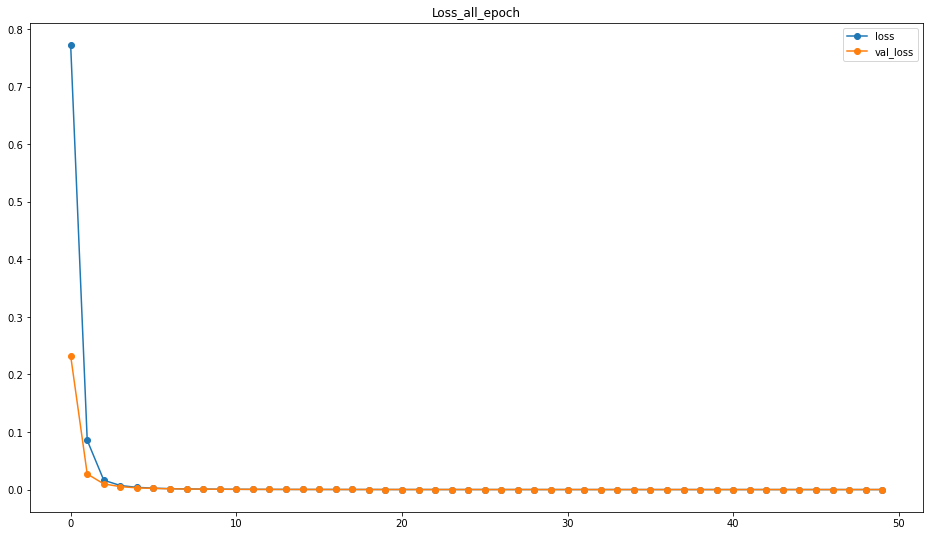

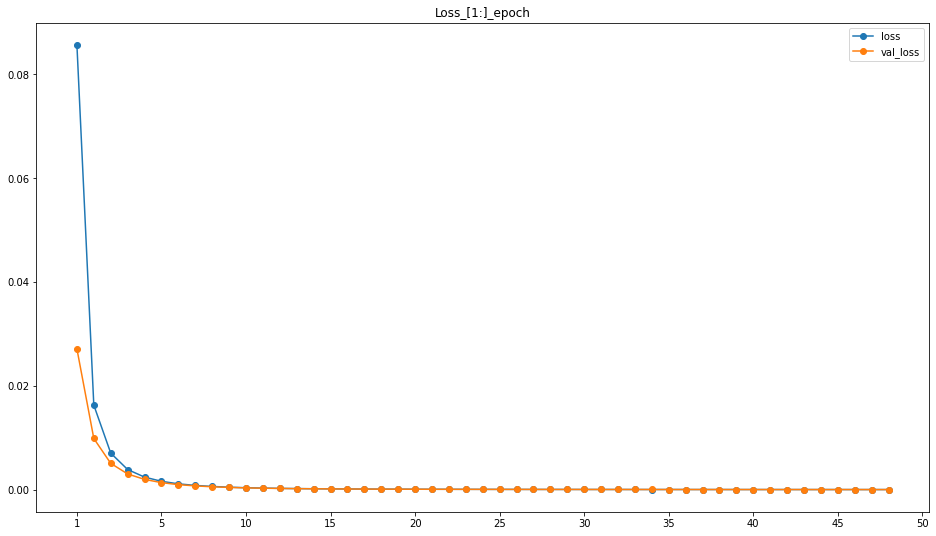

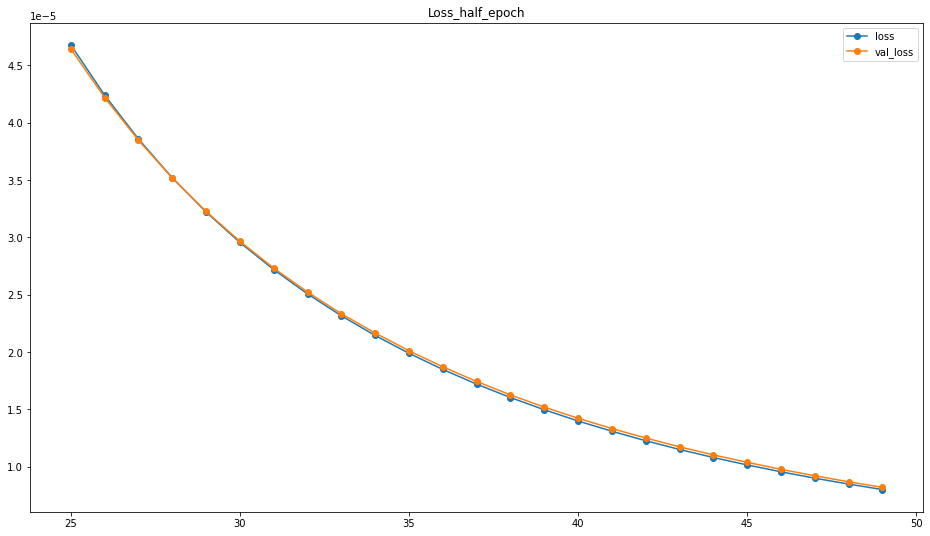

In [63]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [64]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 61us/step


In [65]:
print (scores)

[0.3074108641420168, 0.9348951578140259]


In [66]:
prediction = model.predict(test_data)

In [67]:
print(prediction)

[[9.99980211e-01 3.40667475e-06 1.23818145e-05 3.92767879e-06]
 [9.99977827e-01 4.03821196e-06 1.13499691e-05 6.73623890e-06]
 [9.99981284e-01 3.55469979e-06 1.11348427e-05 4.00337012e-06]
 ...
 [5.56711529e-06 2.05946367e-06 1.70579597e-06 9.99990702e-01]
 [5.56726354e-06 2.05953415e-06 1.70583996e-06 9.99990702e-01]
 [4.93205971e-06 1.27694170e-06 2.06289974e-06 9.99991775e-01]]


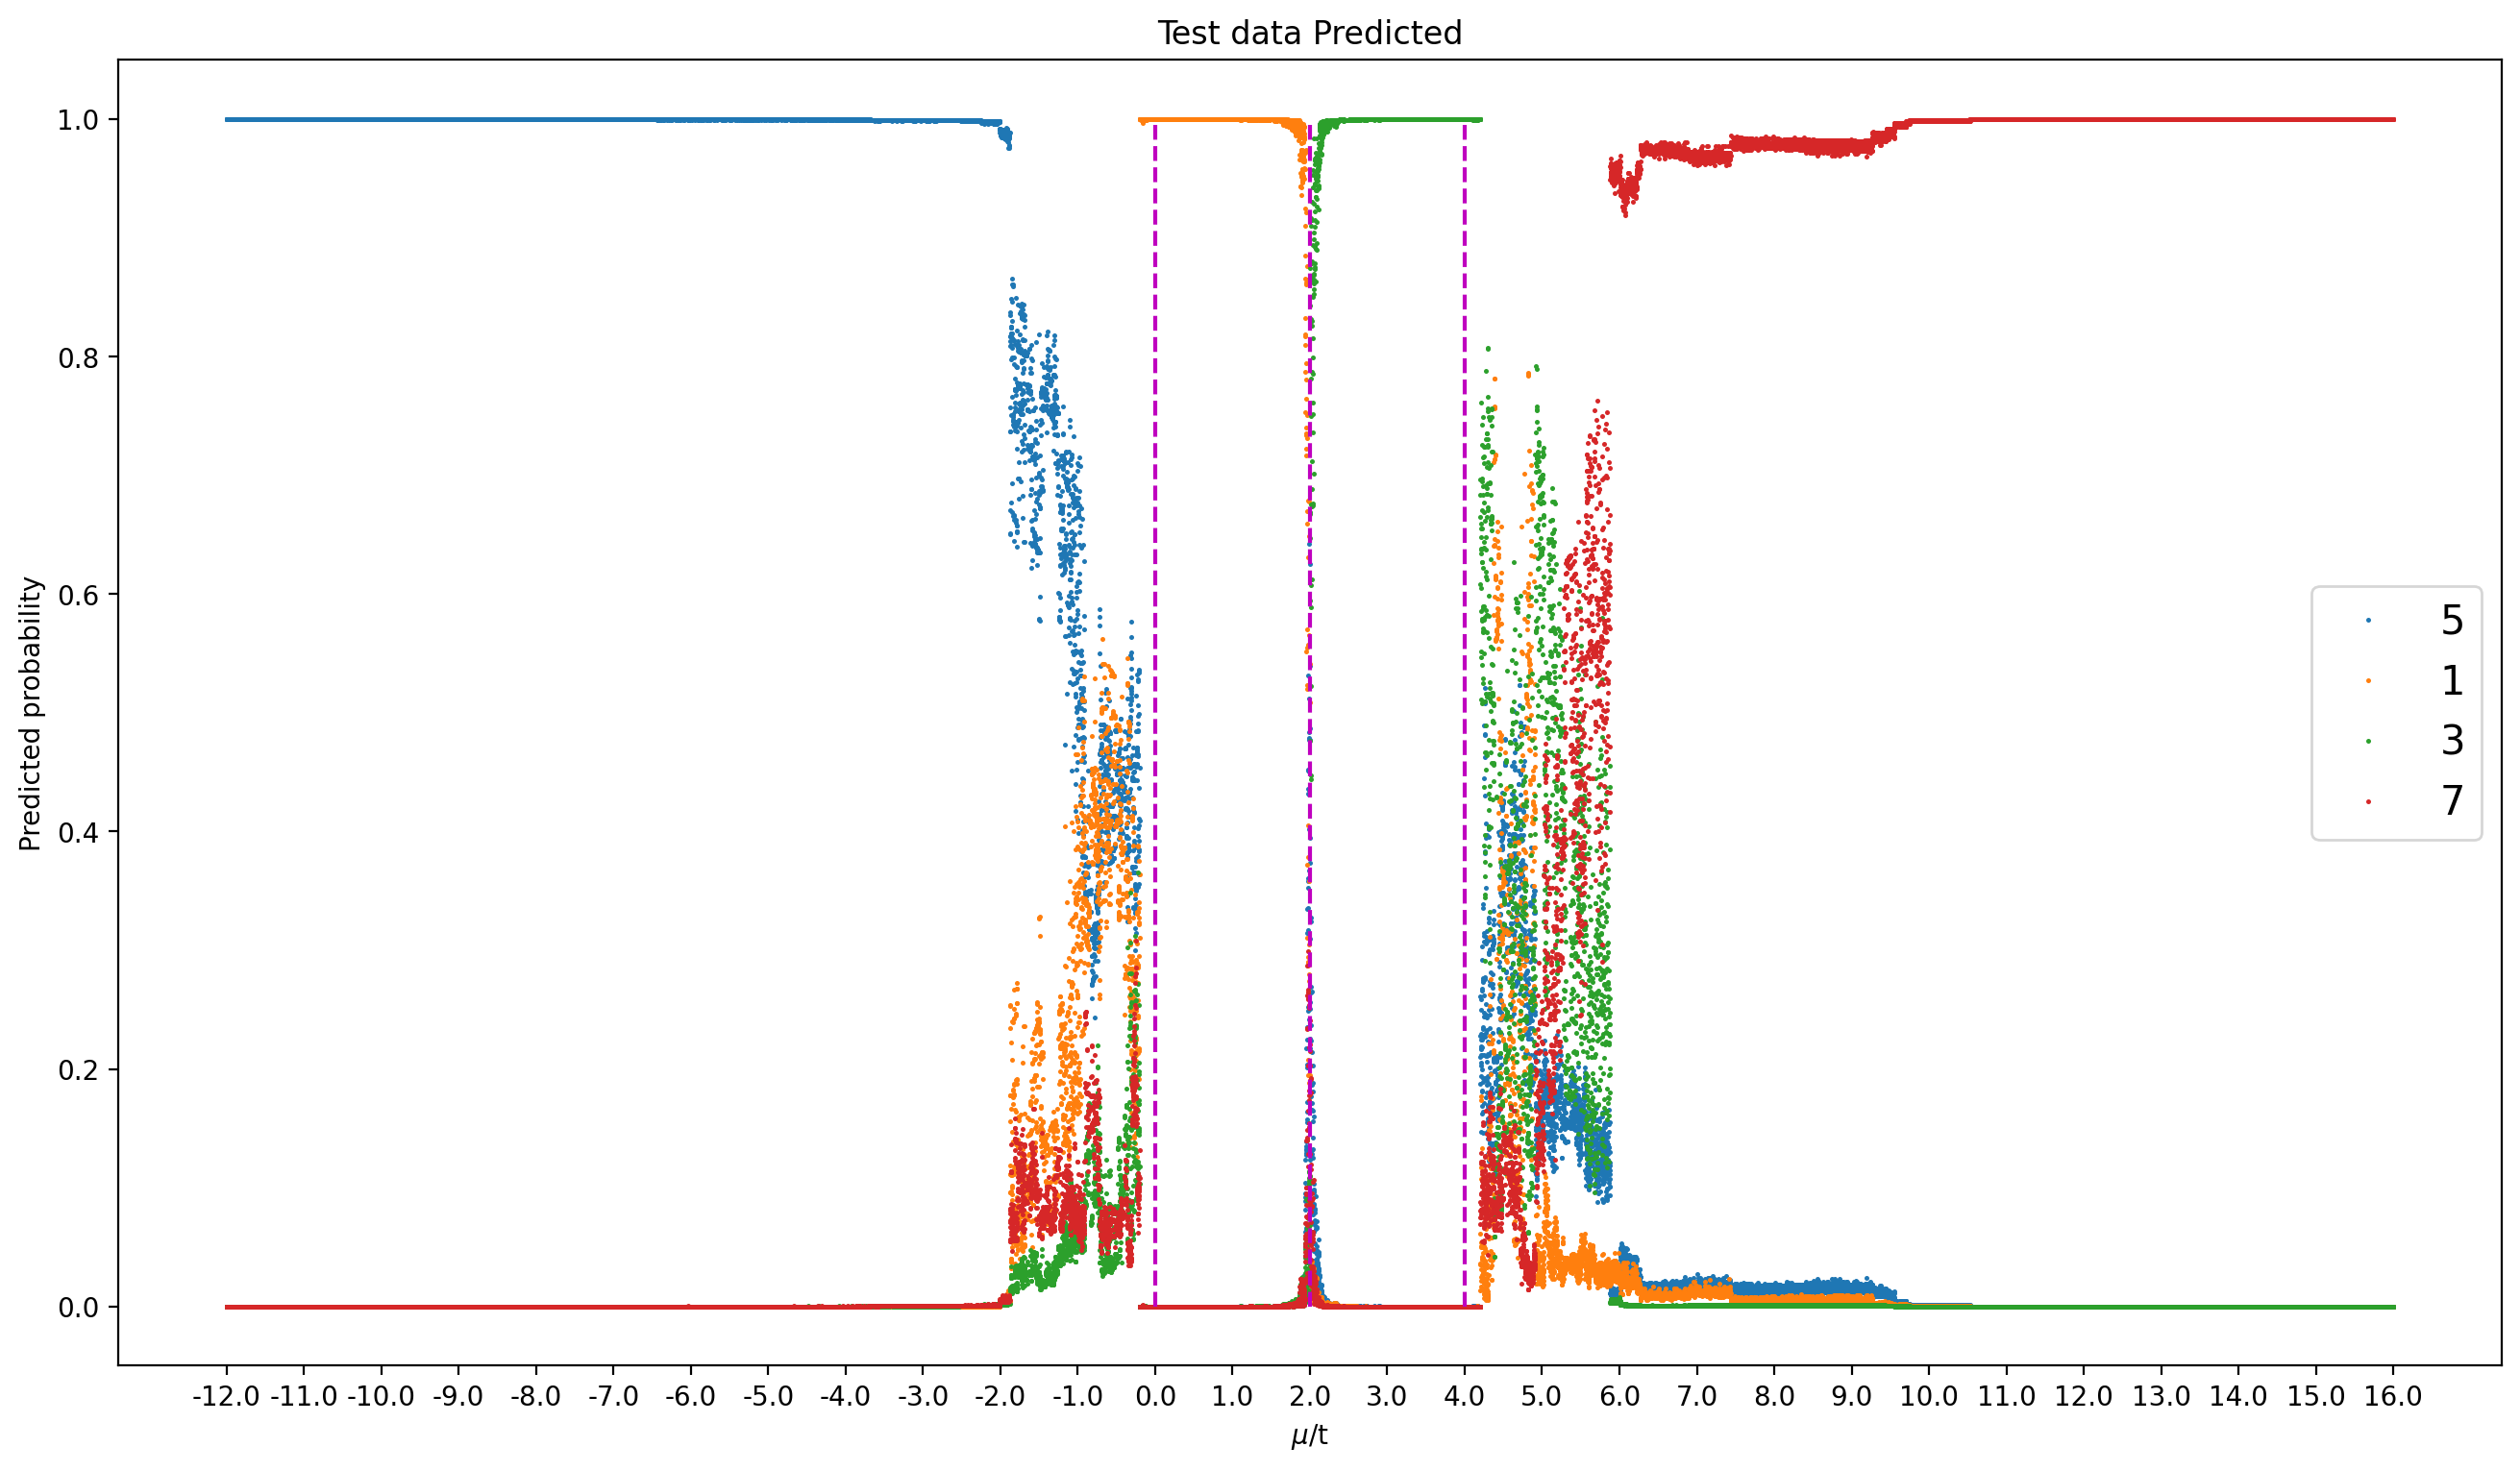

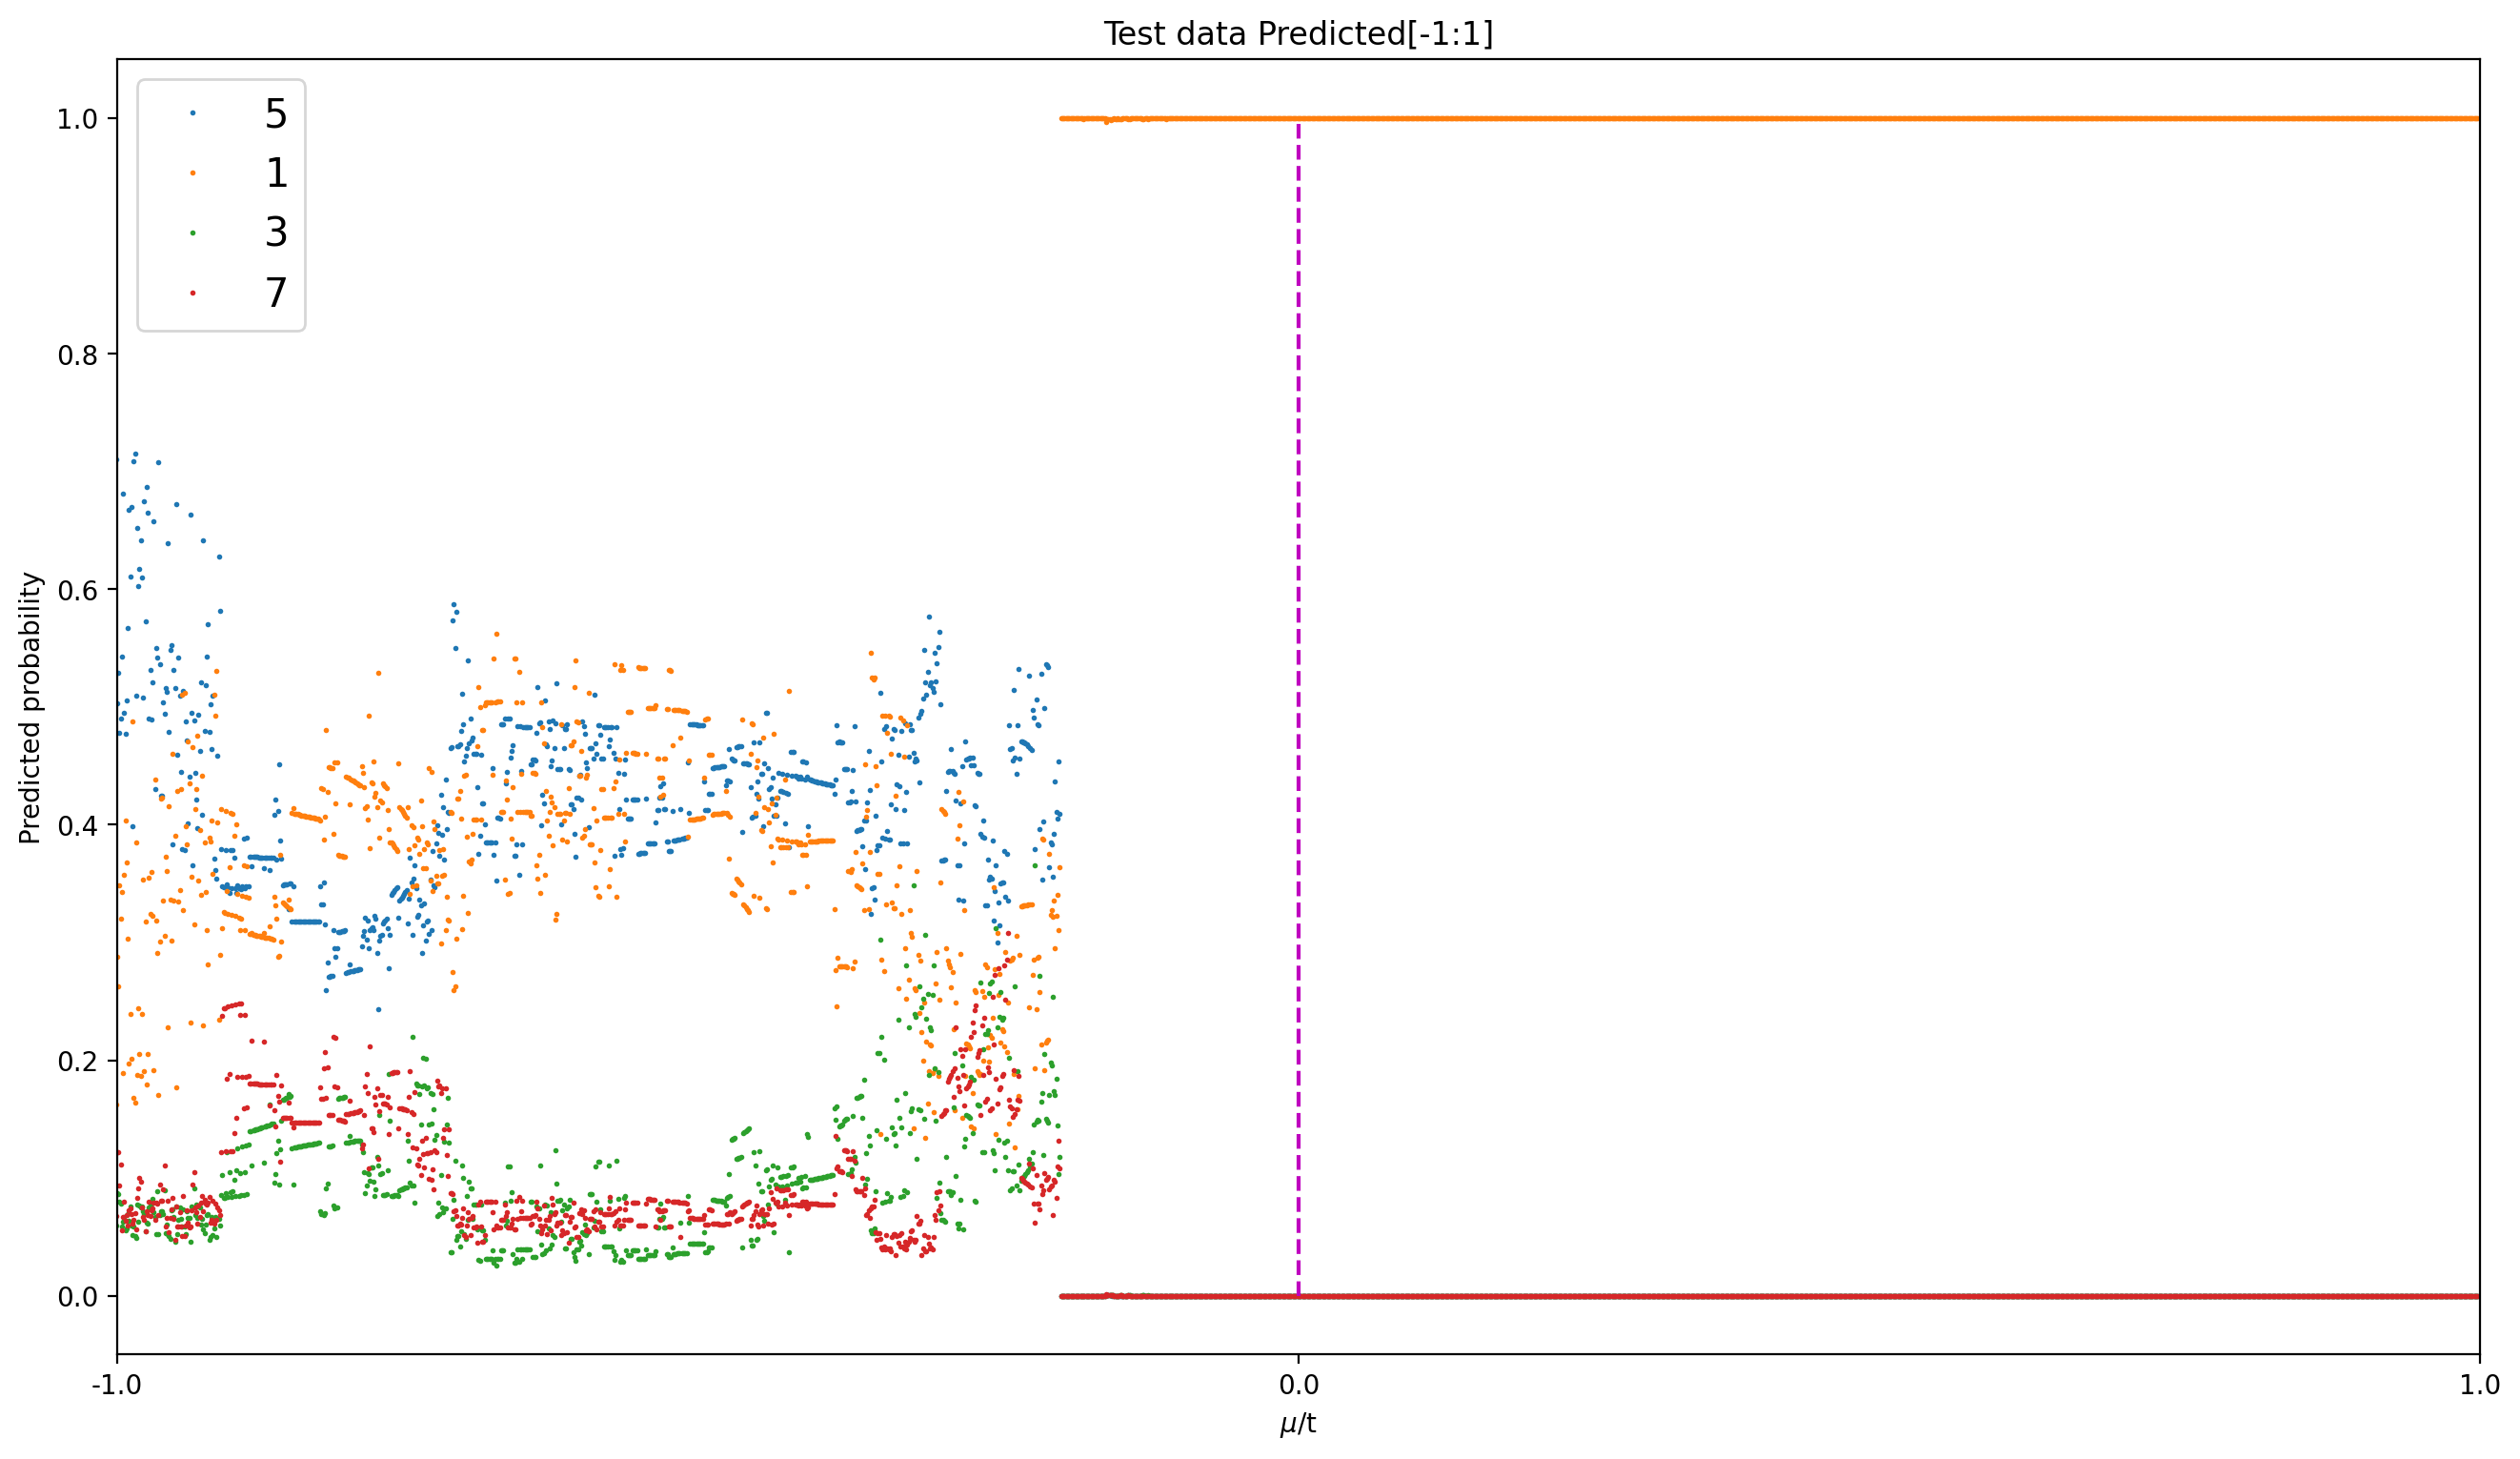

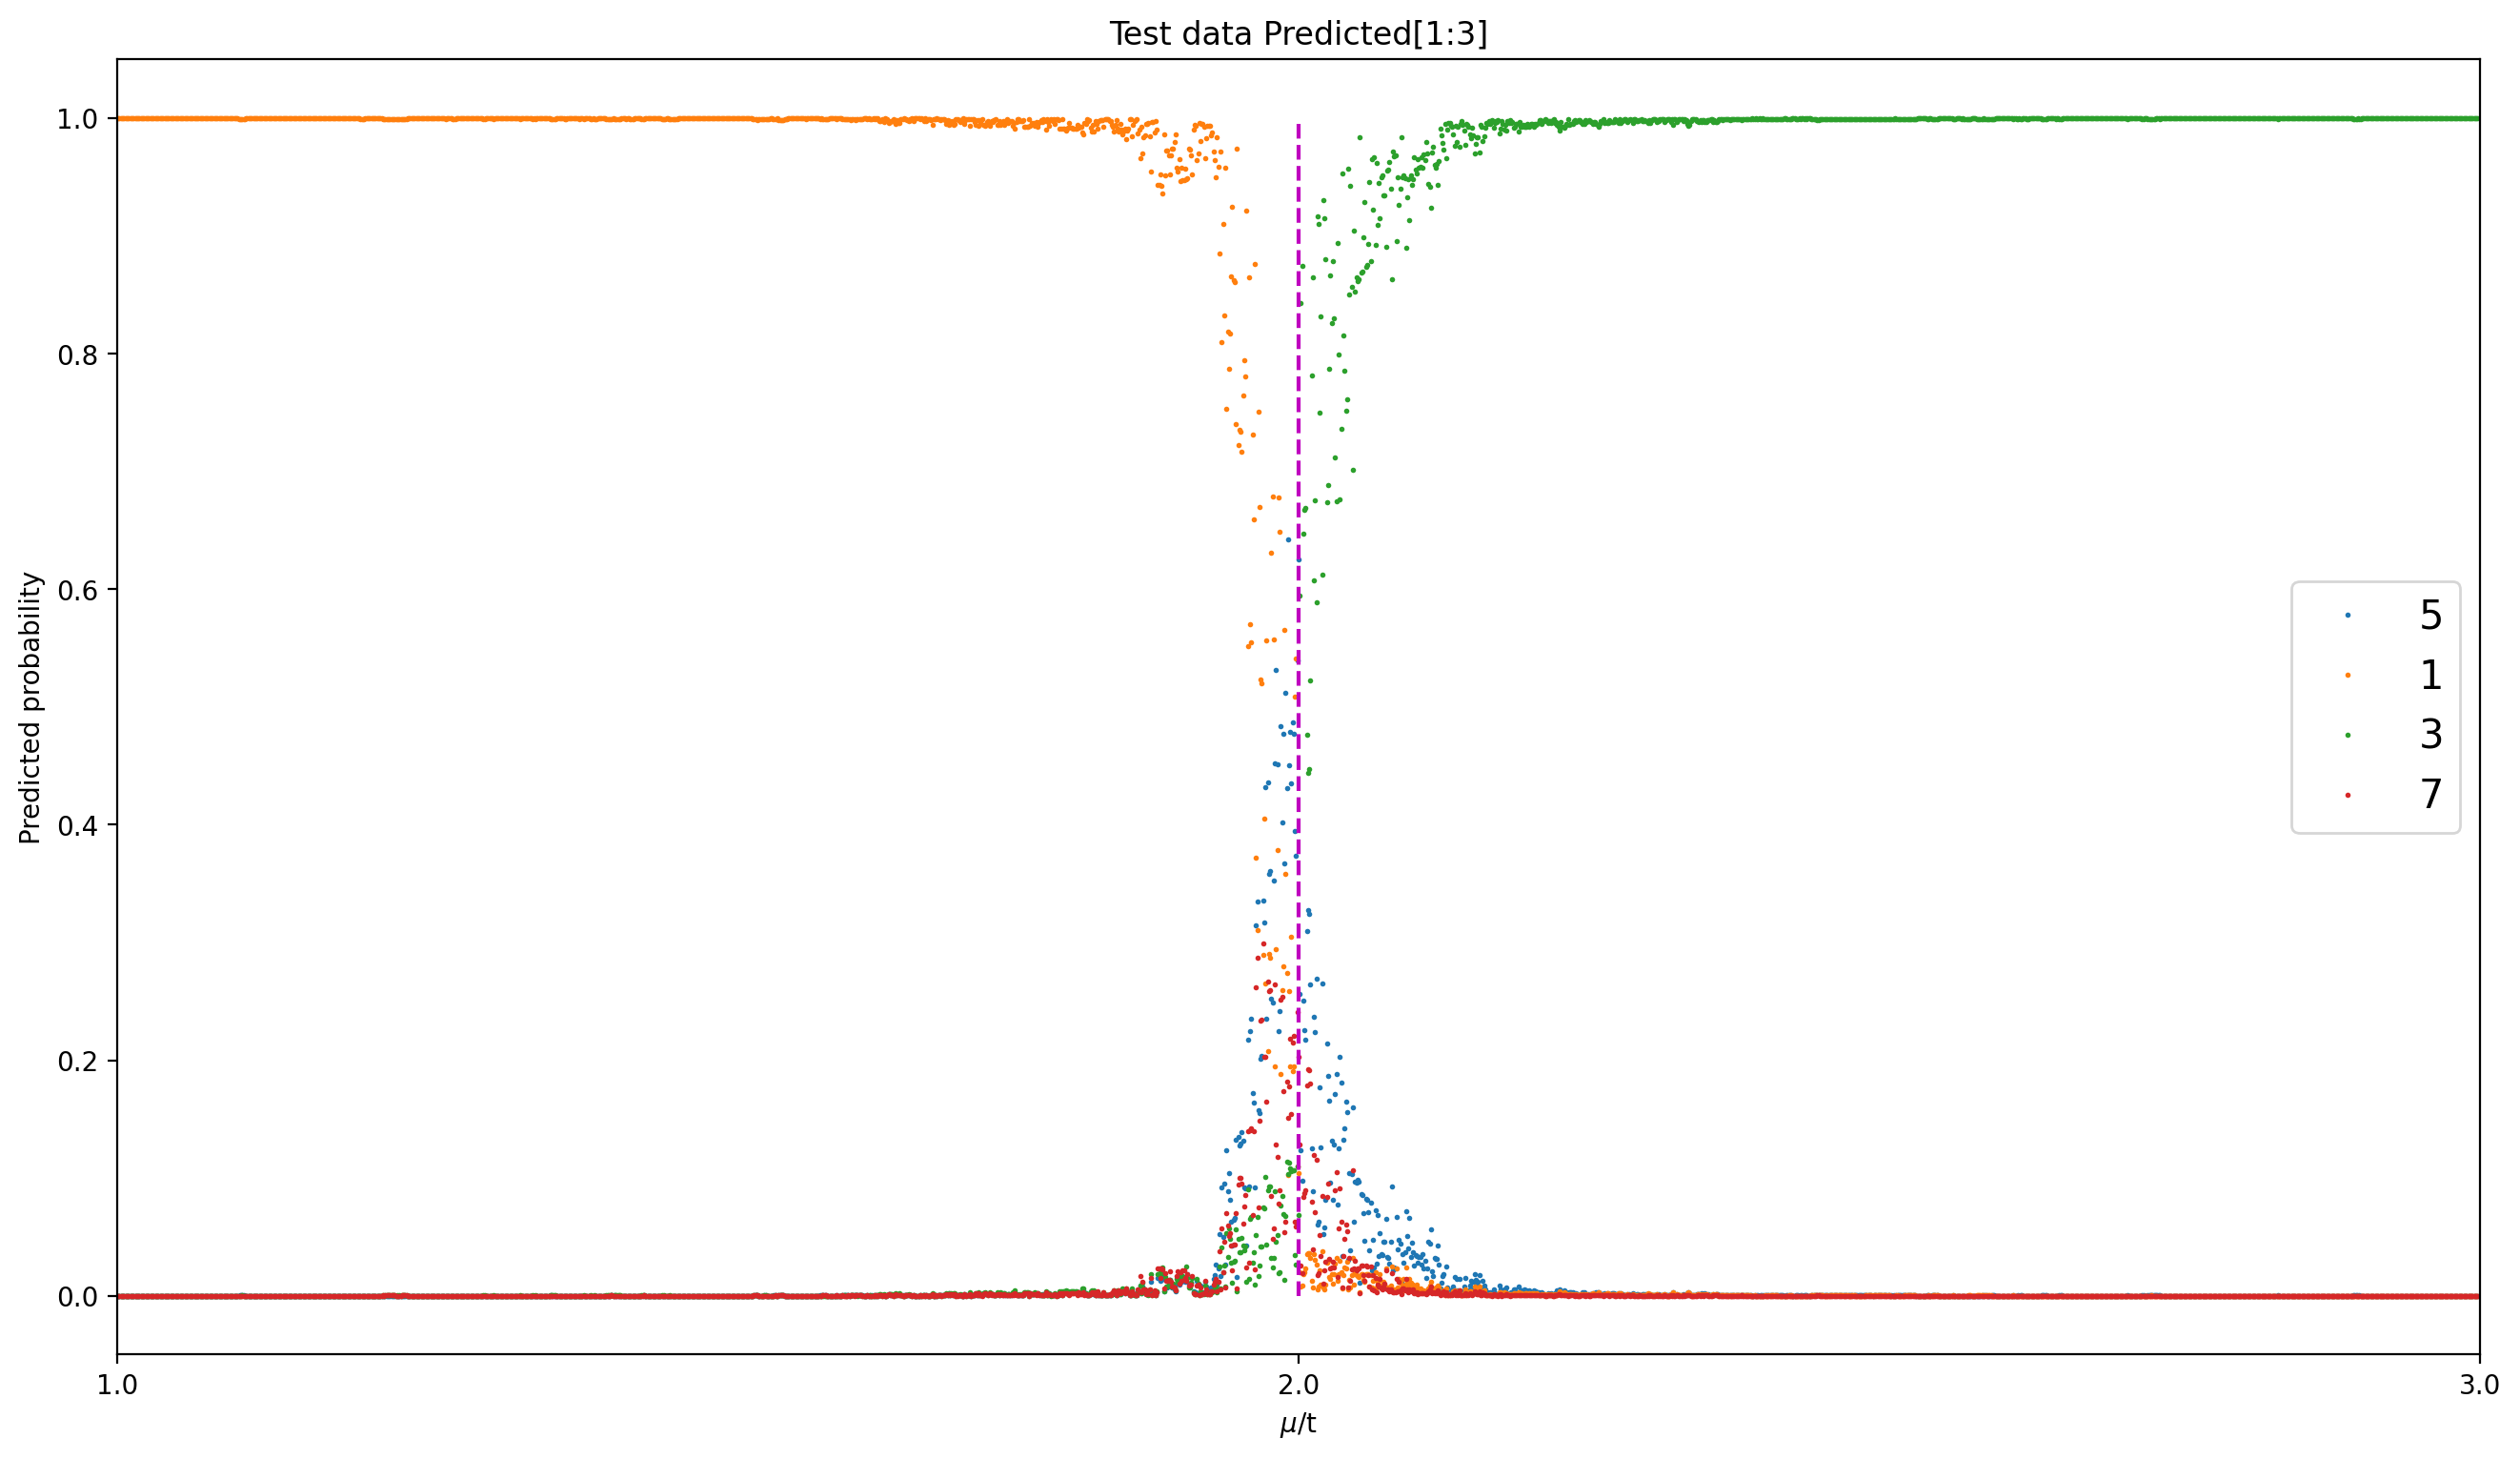

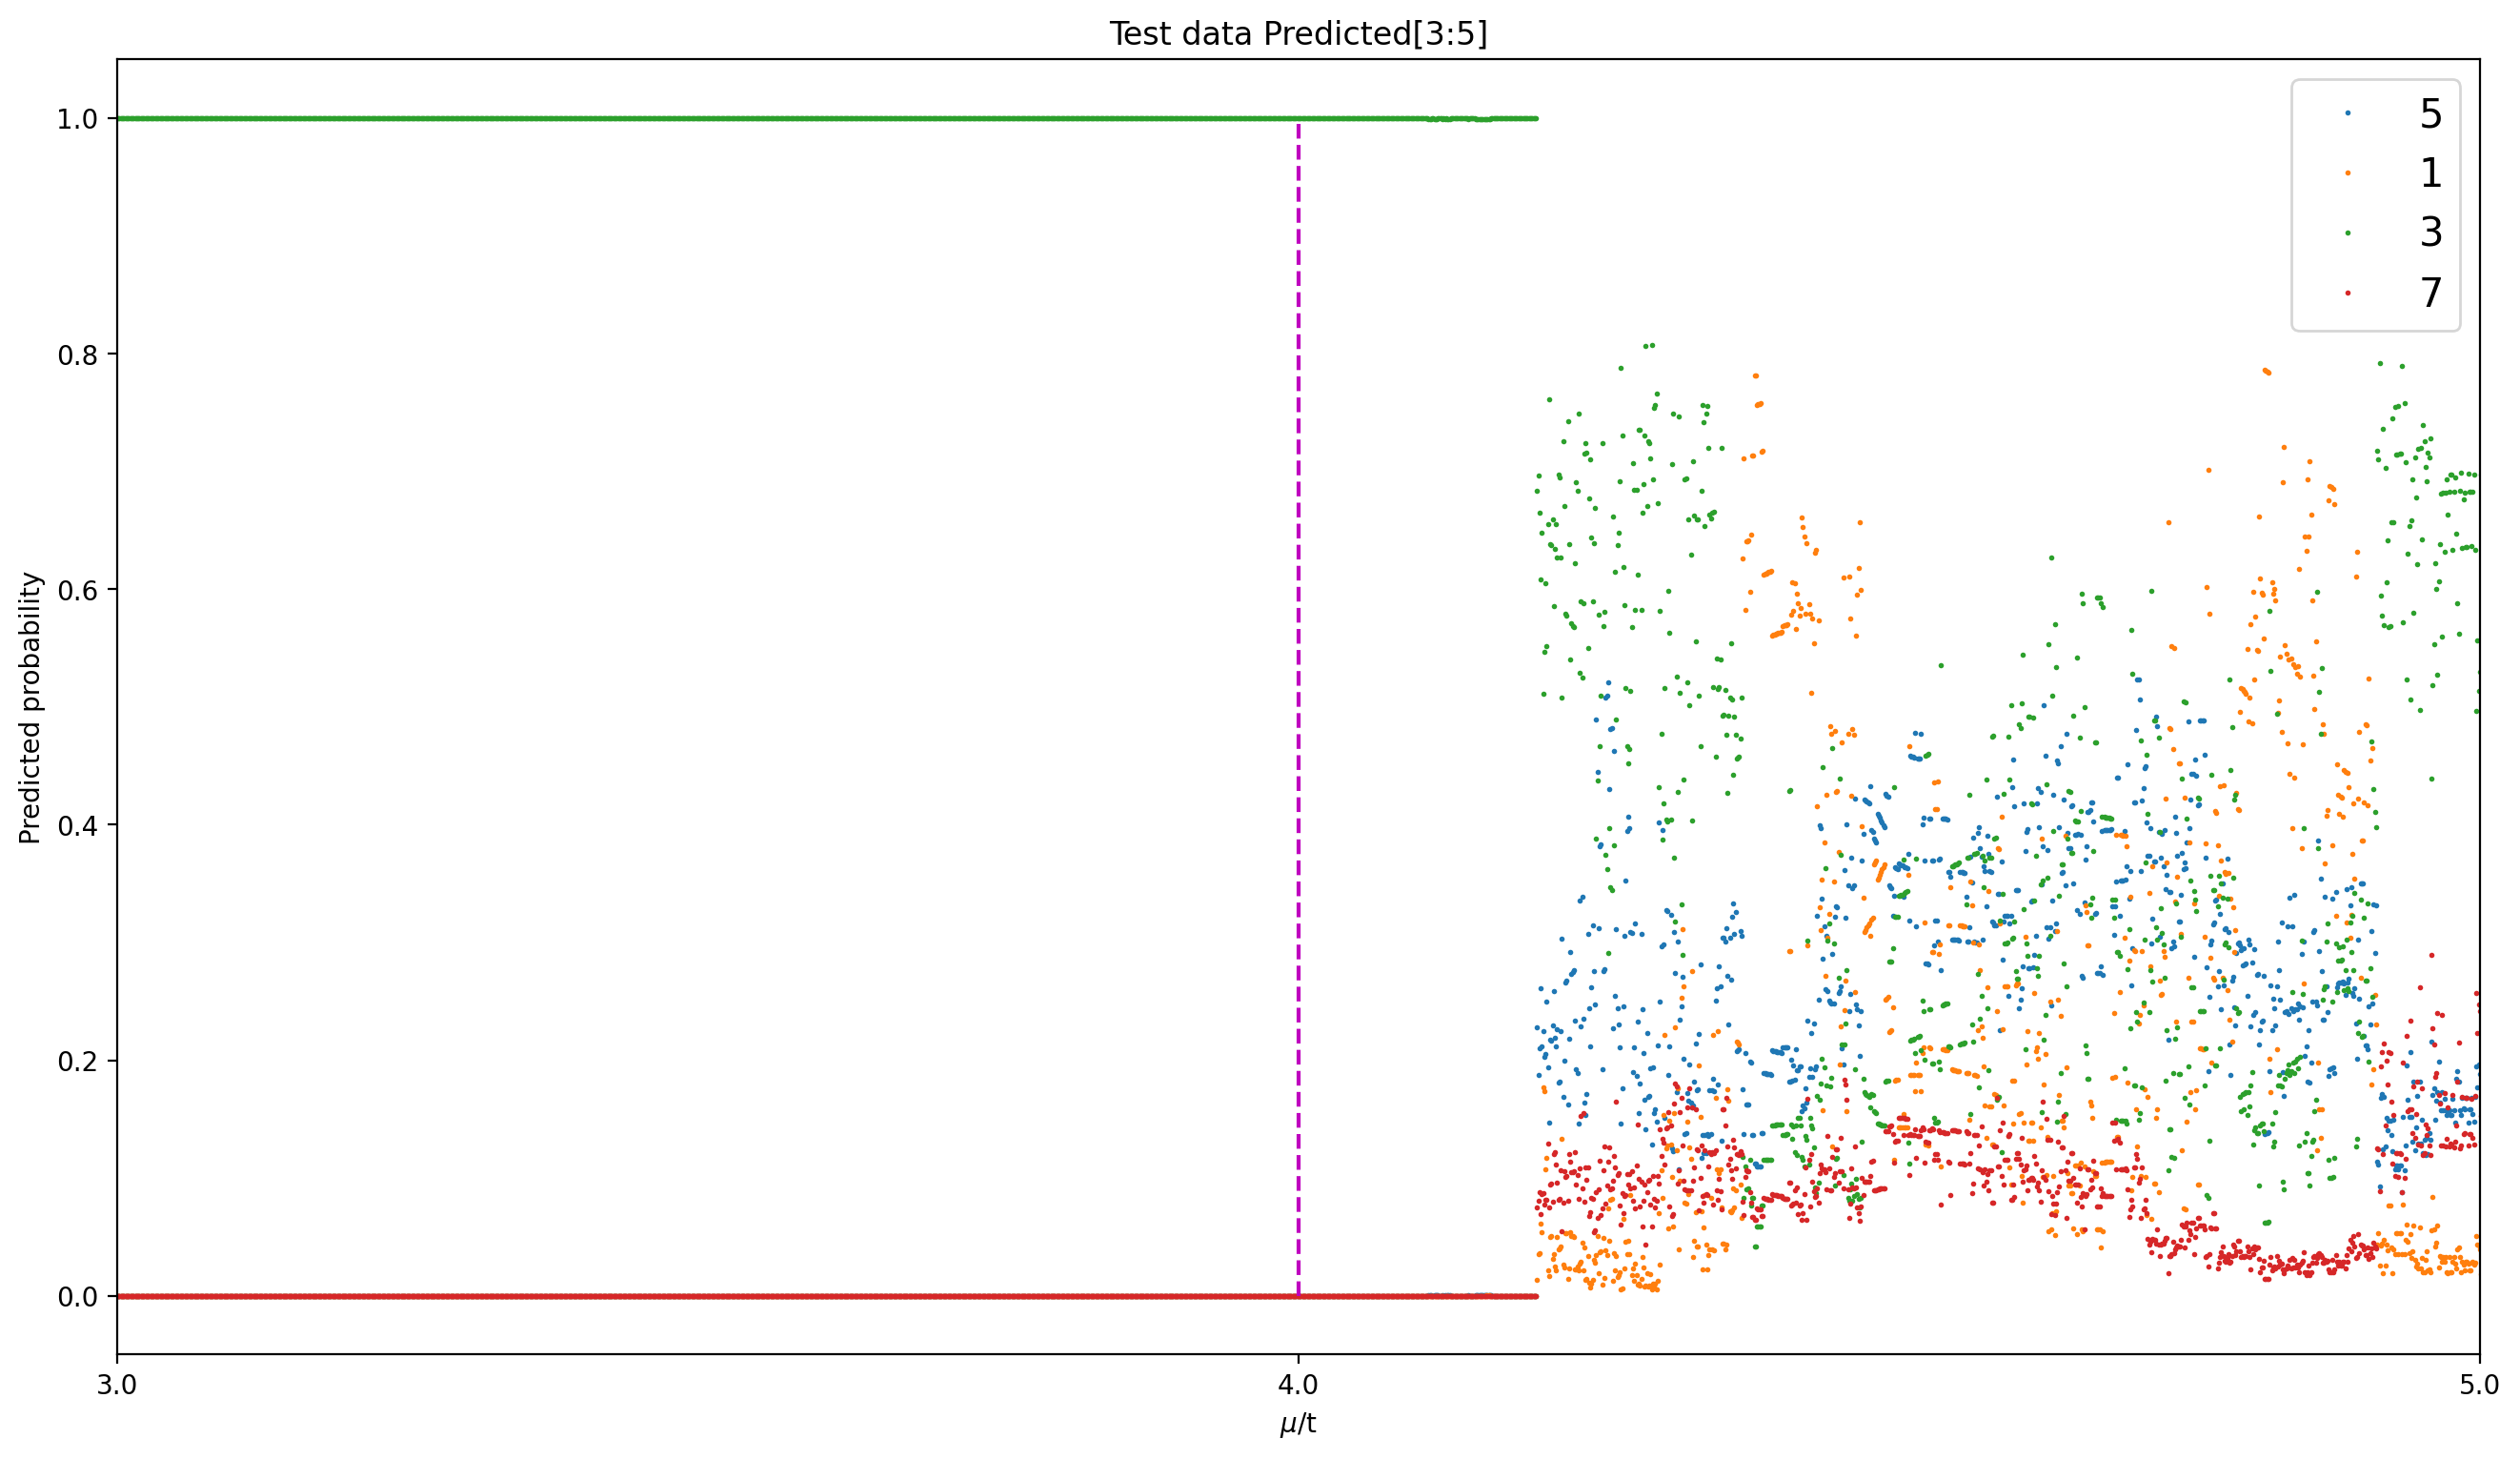

In [68]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_3D 添加濾波器

開始獲取eigenvector_r_theta_3D的資料，並將phase轉成label  
並印出形狀確認是否正確
在這版本，為資料添加了濾波器，作法為保留-0.2~0.2的資料其餘的轉為1

In [69]:
train_data = get_train_data(train_data_path, date, N, delta)[6]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

for k in arange(4000):
    for i in (arange(0,(2*NN**2)*3,3)):
        train_data[k,i][train_data[k,i] > 0.2] = 1
        train_data[k,i][train_data[k,i] < -0.2] = 1

for k in arange(28001):
    for i in (arange(0,(2*NN**2)*3,3)):
        test_data[k,i][test_data[k,i] > 0.2] = 1
        test_data[k,i][test_data[k,i] < -0.2] = 1       
        

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 384, 8, 8)
(4000,)
(4000, 4)
(28001, 384, 8, 8)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [70]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [71]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 384, 8, 8)
(4000, 4)
Number of real trian data = 
(3200, 384, 8, 8)
(3200, 4)
Number validation data = 
(800, 384, 8, 8)
(800, 4)


開始架構網路

In [72]:
channel = 2*(NN**2)*3

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 2*channel,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 3*channel, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 768, 8, 8)         2654976   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 768, 4, 4)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1152, 4, 4)        7963776   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1152, 2, 2)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_12 (Dense)             (None, 4)                

In [73]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [74]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 2s 493us/step - loss: 0.0688 - accuracy: 0.9753 - val_loss: 4.2225e-05 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 430us/step - loss: 3.0479e-05 - accuracy: 1.0000 - val_loss: 2.2547e-05 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 433us/step - loss: 1.5462e-05 - accuracy: 1.0000 - val_loss: 1.0515e-05 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 430us/step - loss: 7.1181e-06 - accuracy: 1.0000 - val_loss: 5.0317e-06 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 429us/step - loss: 3.7331e-06 - accuracy: 1.0000 - val_loss: 2.9547e-06 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 428us/step - loss: 2.2730e-06 - accuracy: 1.0000 - val_loss: 1.8886e-06 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [===========

訓練完成  
開始提取模型資料

In [75]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


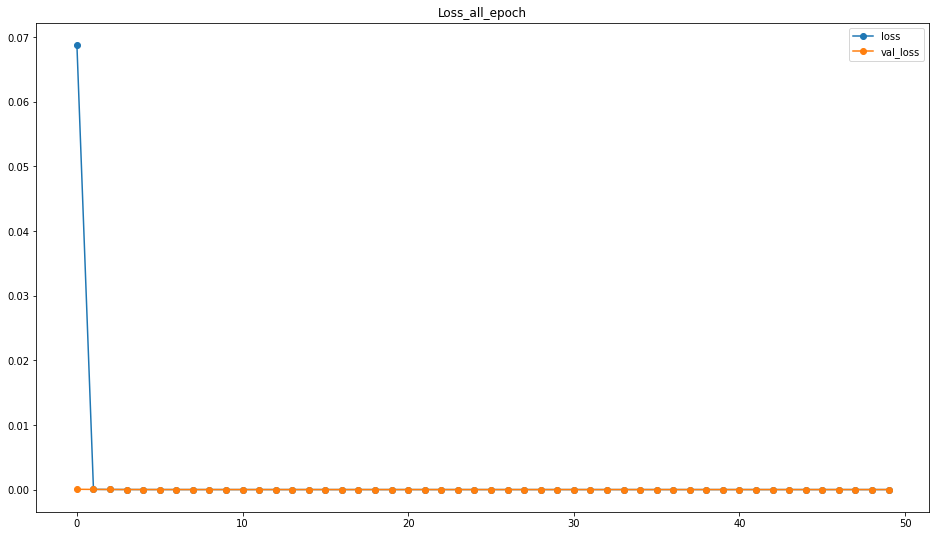

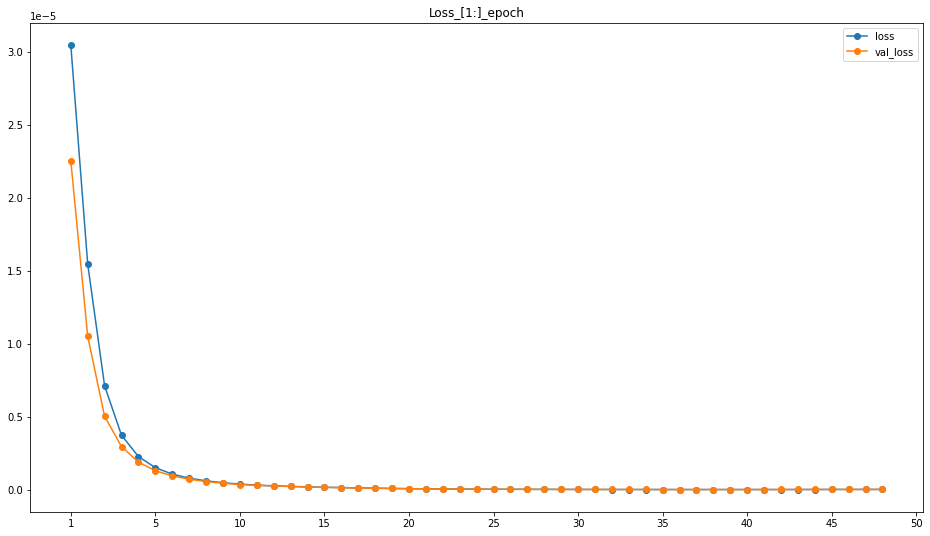

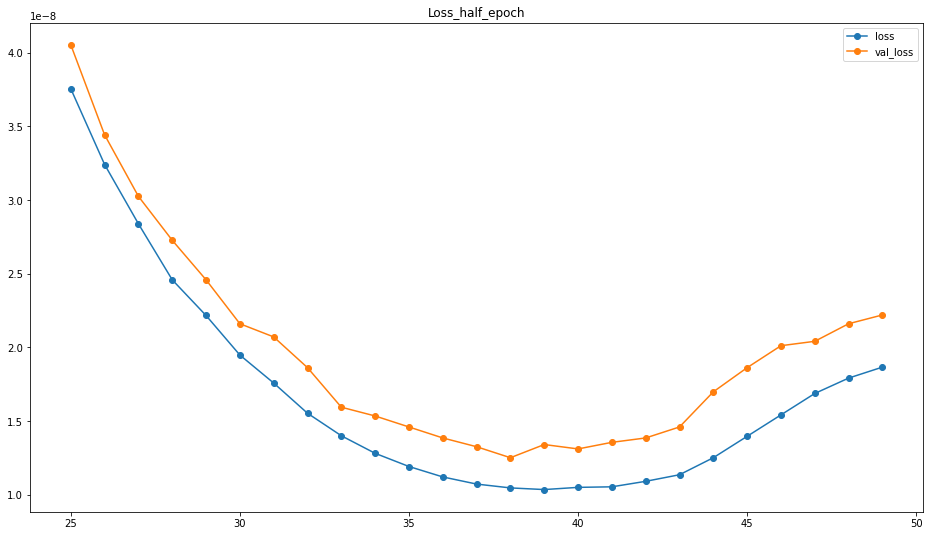

In [76]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [77]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 6s 228us/step


In [78]:
print (scores)

[0.07964377377007076, 0.9811435341835022]


In [79]:
prediction = model.predict(test_data)

In [80]:
print(prediction)

[[9.99999642e-01 8.81855726e-08 1.13077327e-07 7.95088724e-08]
 [9.99999523e-01 1.23540019e-07 2.29053995e-07 1.54692273e-07]
 [9.99999642e-01 7.99909117e-08 1.27485080e-07 9.76019194e-08]
 ...
 [1.51024693e-07 2.22270288e-07 1.23113097e-07 9.99999523e-01]
 [1.93168702e-07 1.16680795e-07 1.49465492e-07 9.99999523e-01]
 [2.31580117e-07 1.30652381e-07 9.14937246e-08 9.99999523e-01]]


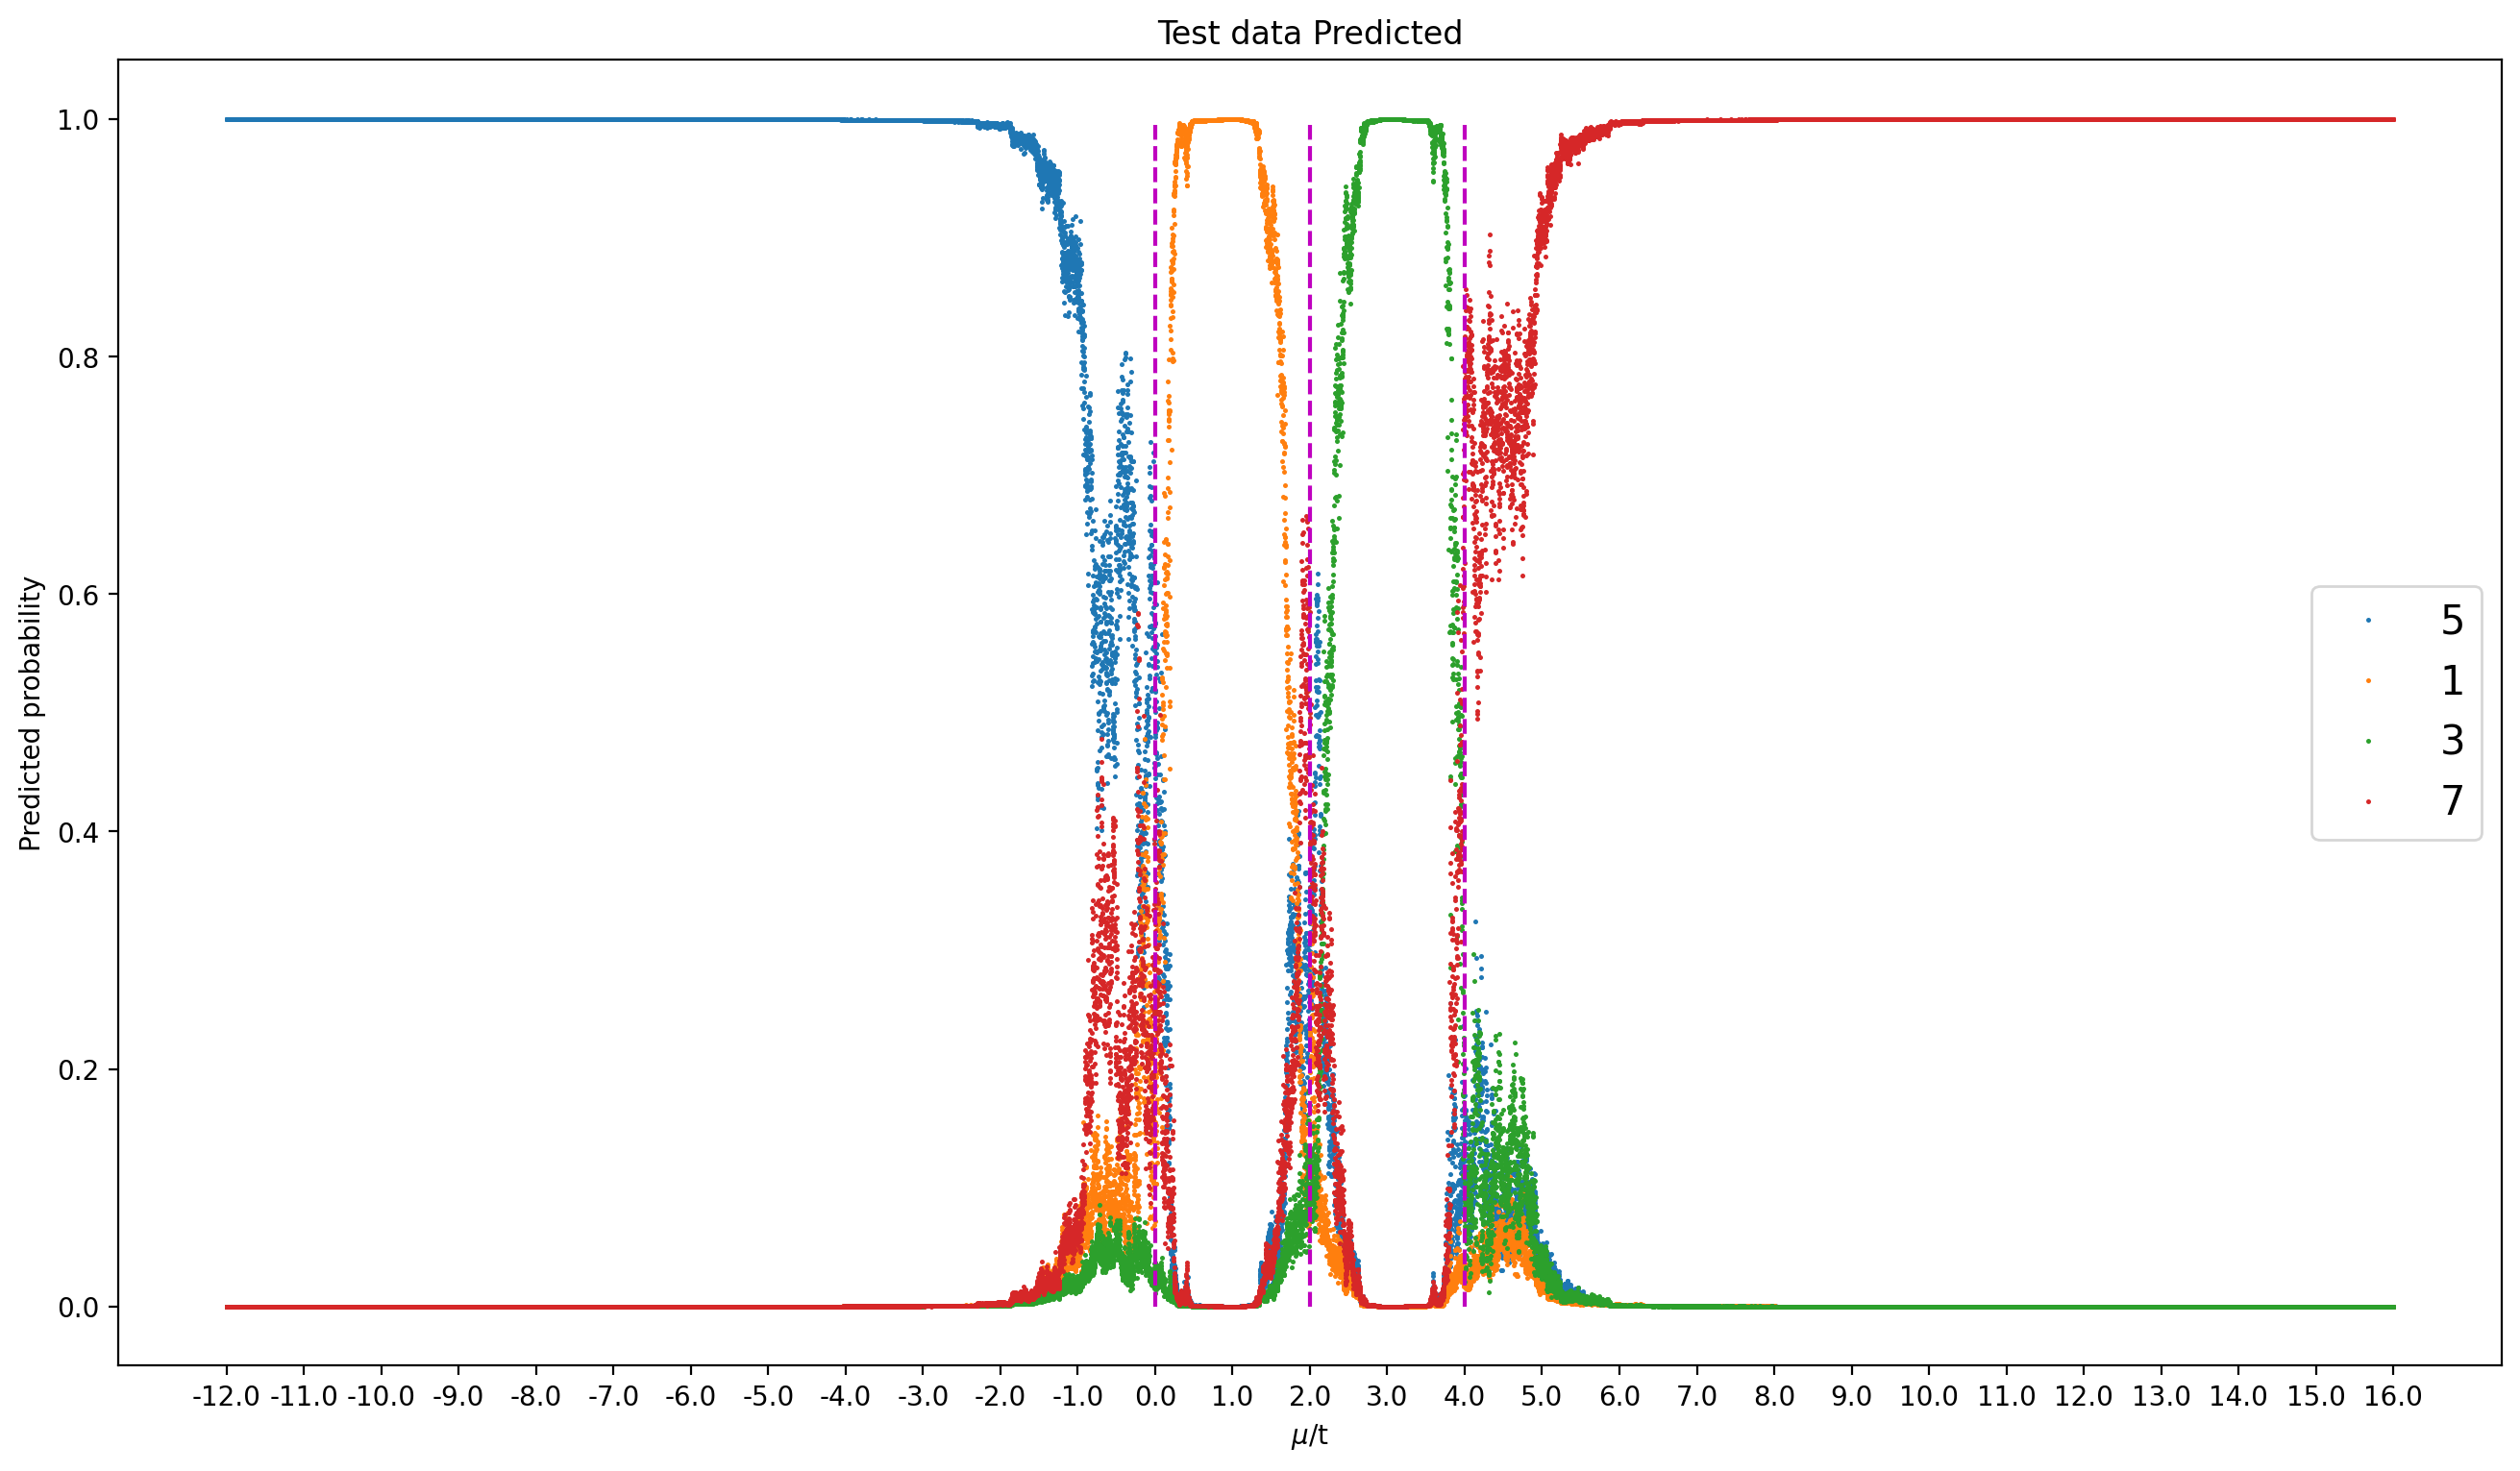

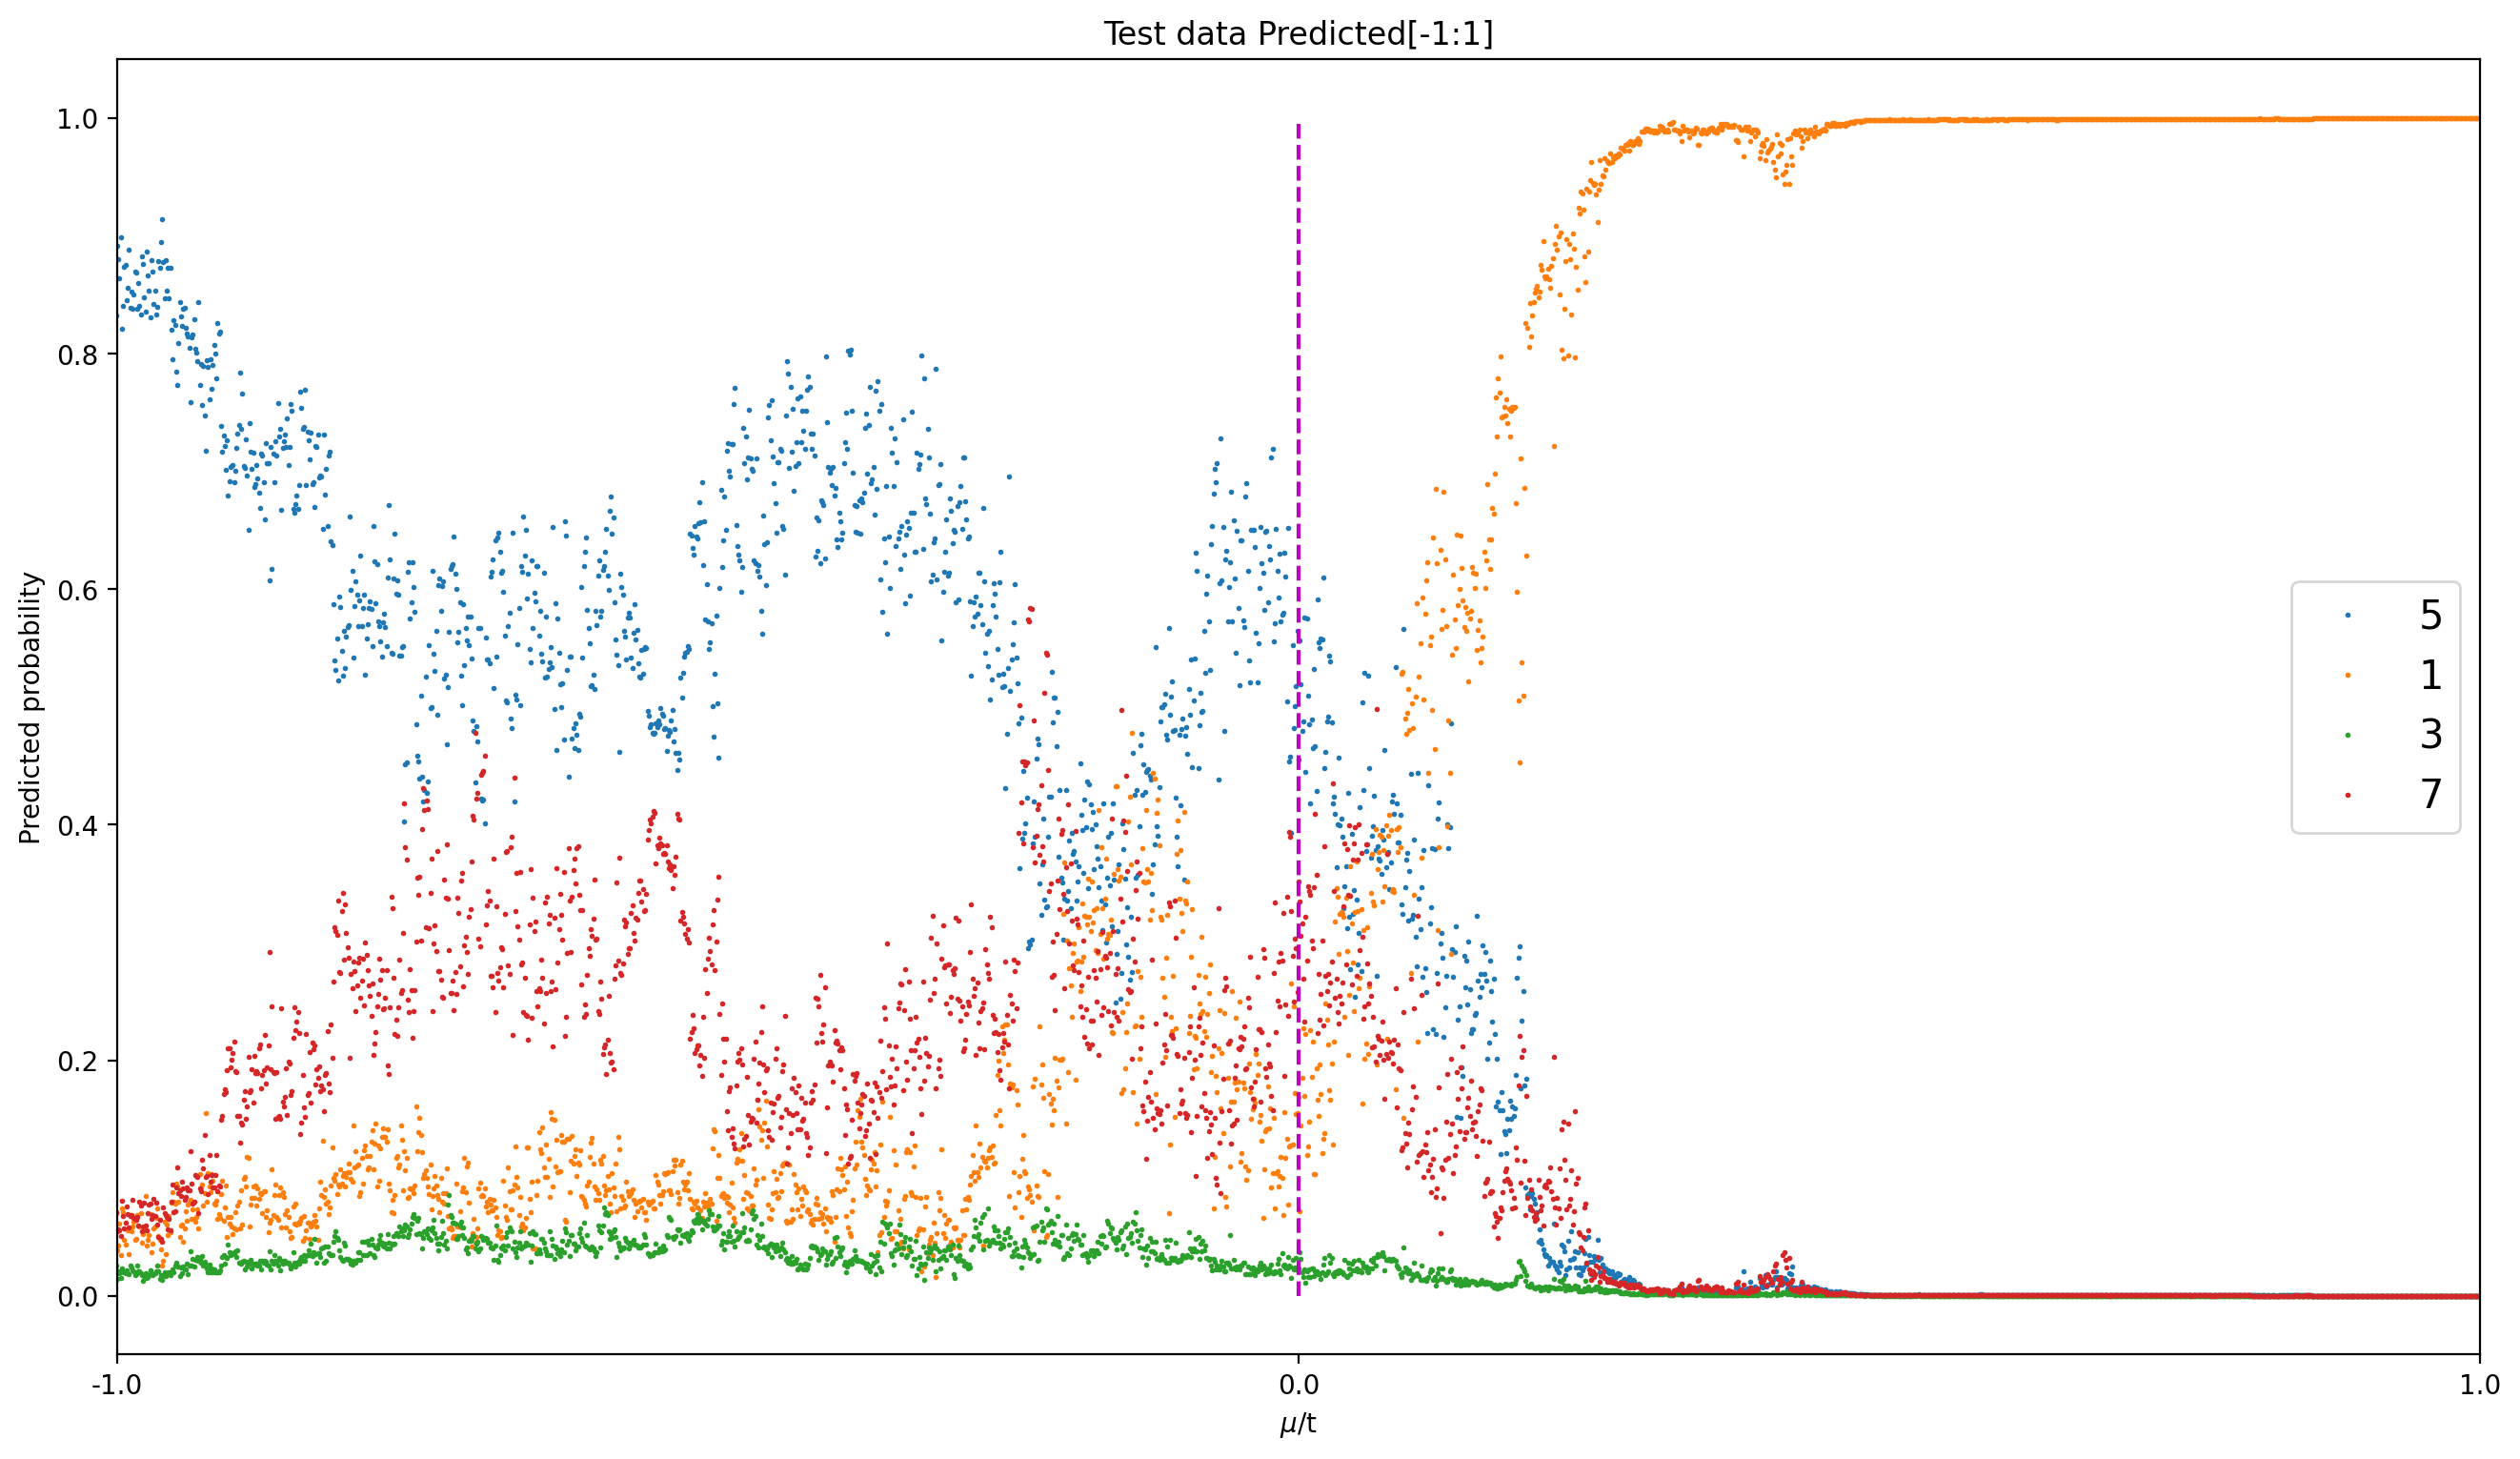

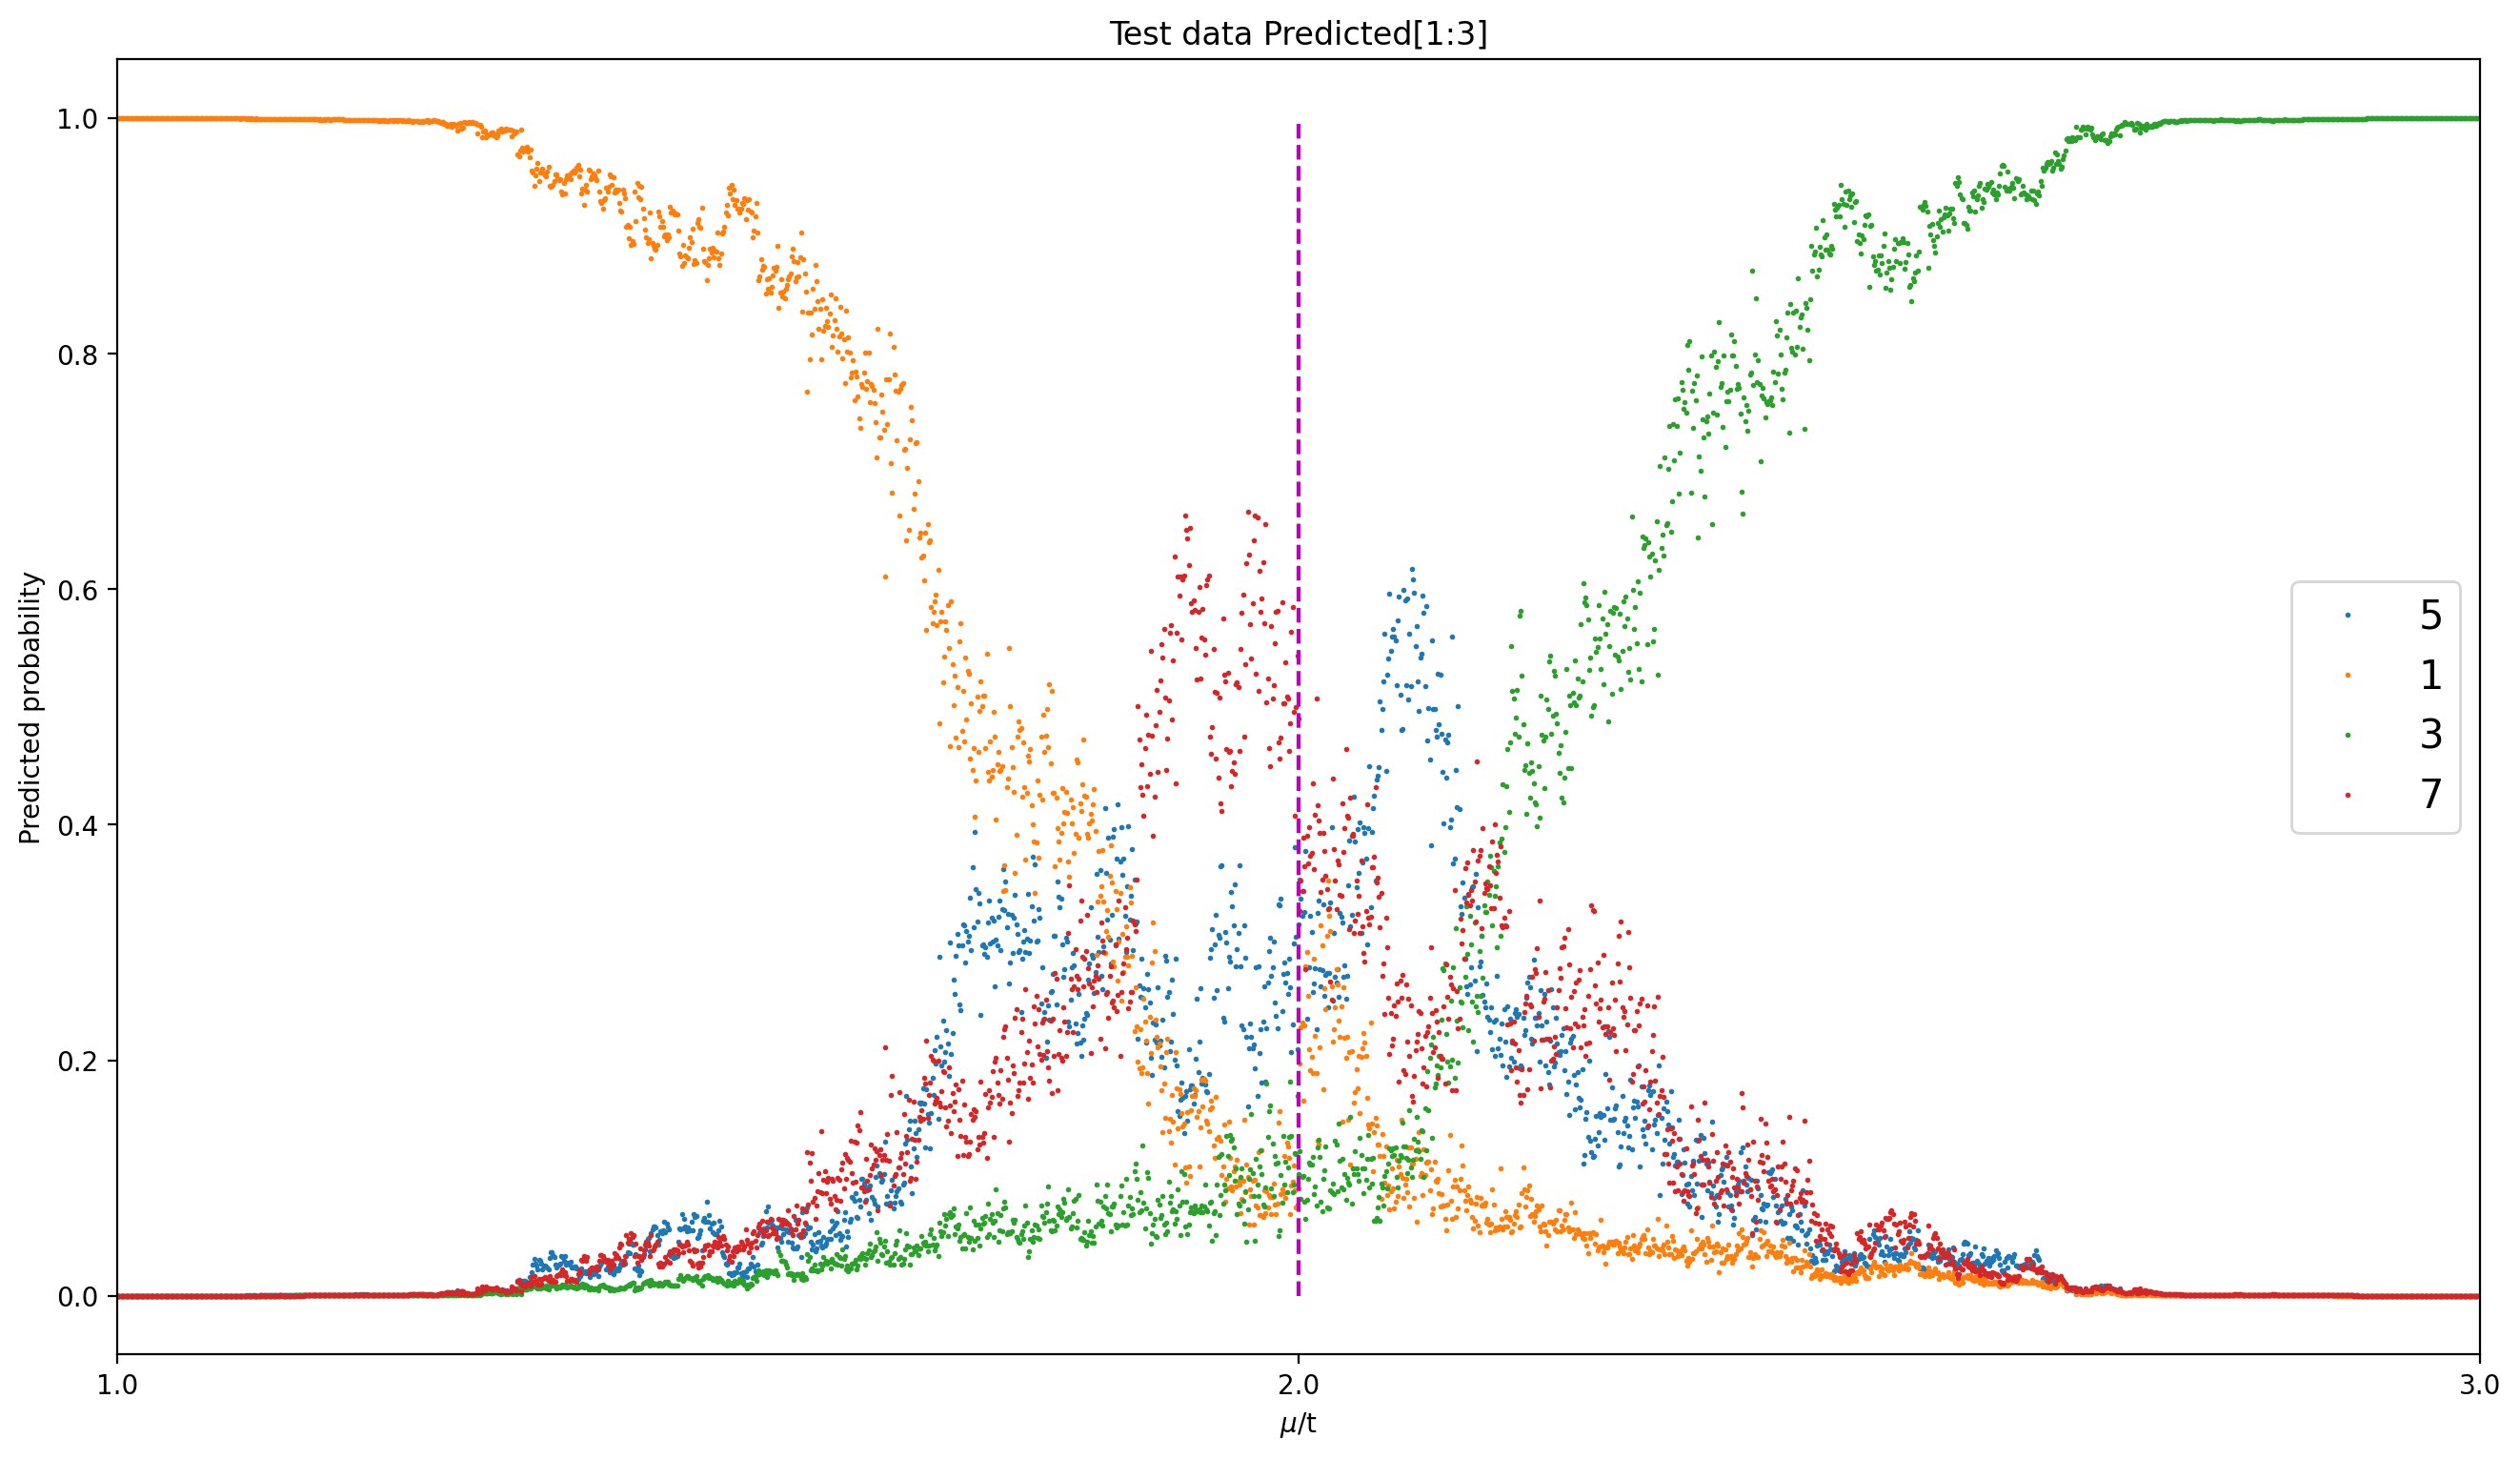

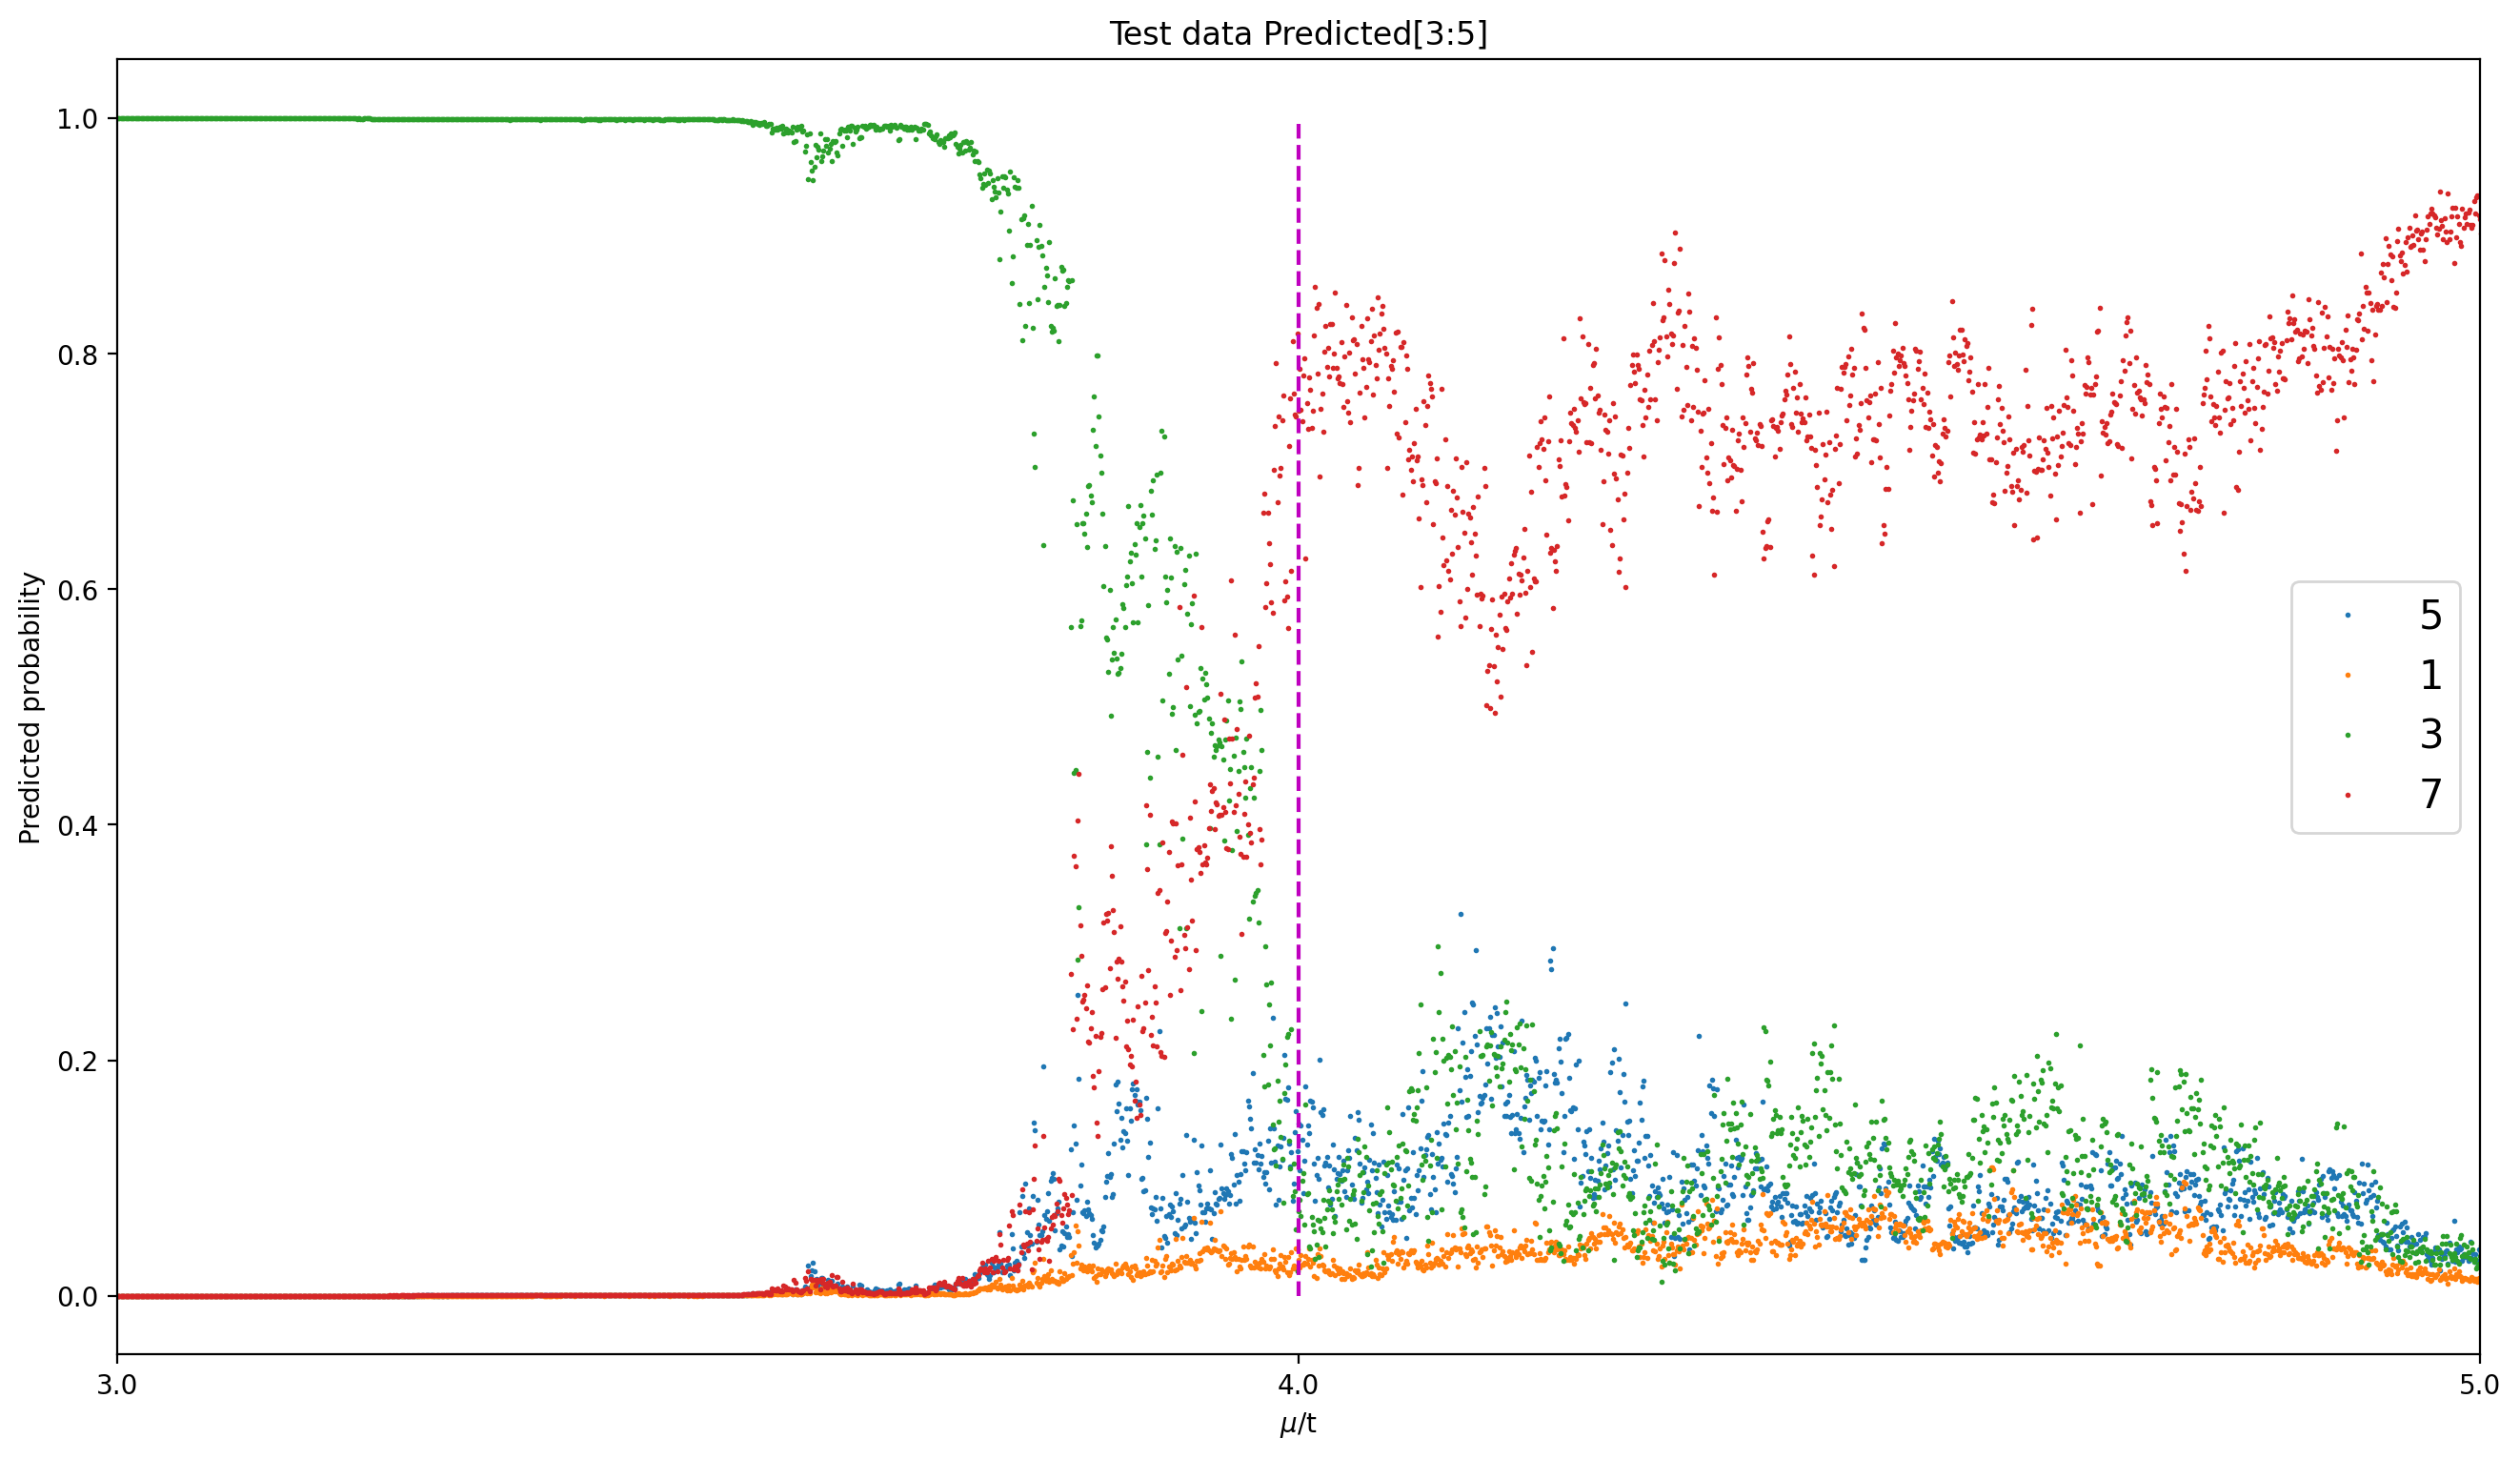

In [81]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# Test resnet

# eigenvector_r_theta_3D_resnet

開始獲取eigenvector_r_theta_3D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [82]:
train_data = get_train_data(train_data_path, date, N, delta)[6]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 384, 8, 8)
(4000,)
(4000, 4)
(28001, 384, 8, 8)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [83]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [84]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 384, 8, 8)
(4000, 4)
Number of real trian data = 
(3200, 384, 8, 8)
(3200, 4)
Number validation data = 
(800, 384, 8, 8)
(800, 4)


開始架構網路

In [85]:
def resnet(input_shape):
    
    channel = 2*(NN**2)*3
    
    inputs = Input(shape=input_shape)
    
    x = Convolution2D(batch_input_shape = (None, channel, NN, NN), 
                      filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(inputs)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = Convolution2D(filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(x)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = keras.layers.add([x,inputs])
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(4)(x)
    
    outputs = Activation('softmax')(x)
    
    return Model(inputs=inputs,outputs=outputs)

channel = 2*(NN**2)*3
model = resnet((channel, NN, NN))

In [86]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 8, 8)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 384, 8, 8)    1327488     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 384, 8, 8)    32          conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 384, 8, 8)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [87]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [88]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 2s 569us/step - loss: 0.7288 - accuracy: 0.9659 - val_loss: 1.2208e-06 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 356us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.5646e-08 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 358us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 359us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 359us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 365us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [===========

訓練完成  
開始提取模型資料

In [89]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


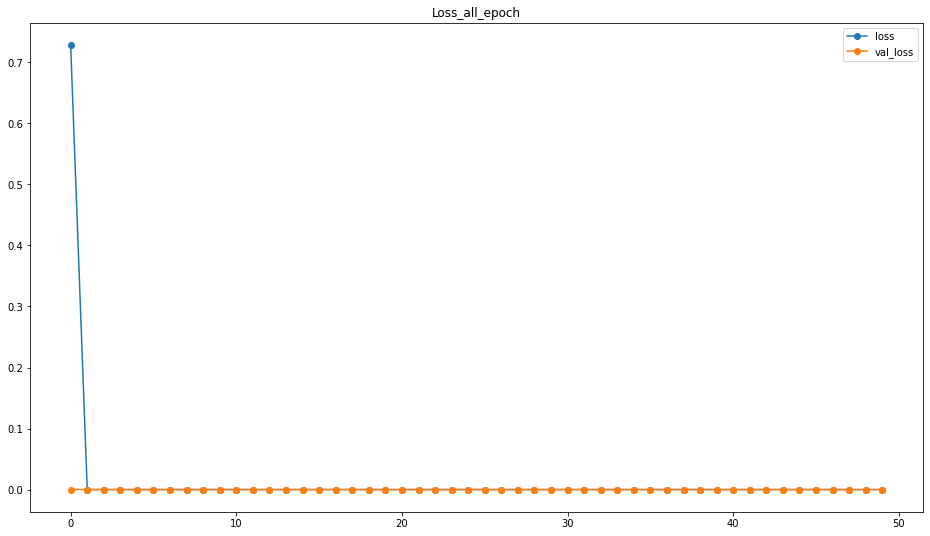

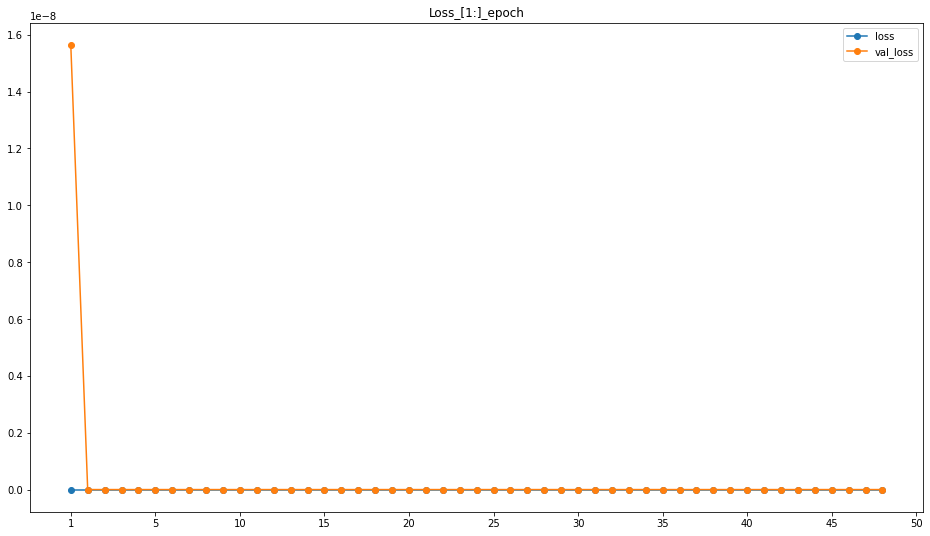

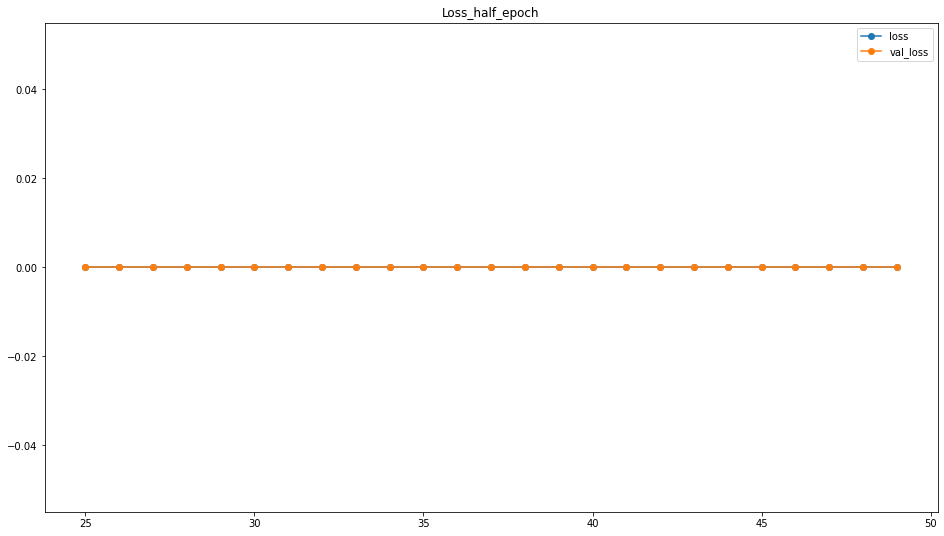

In [90]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [91]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 6s 198us/step


In [92]:
print (scores)

[3.4481876854532967, 0.8478268384933472]


In [93]:
prediction = model.predict(test_data)

In [94]:
print(prediction)

[[1.0000000e+00 3.7912314e-23 0.0000000e+00 4.7345555e-26]
 [1.0000000e+00 5.9424608e-23 0.0000000e+00 3.0811952e-28]
 [1.0000000e+00 2.3317639e-25 0.0000000e+00 2.6799562e-25]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]]


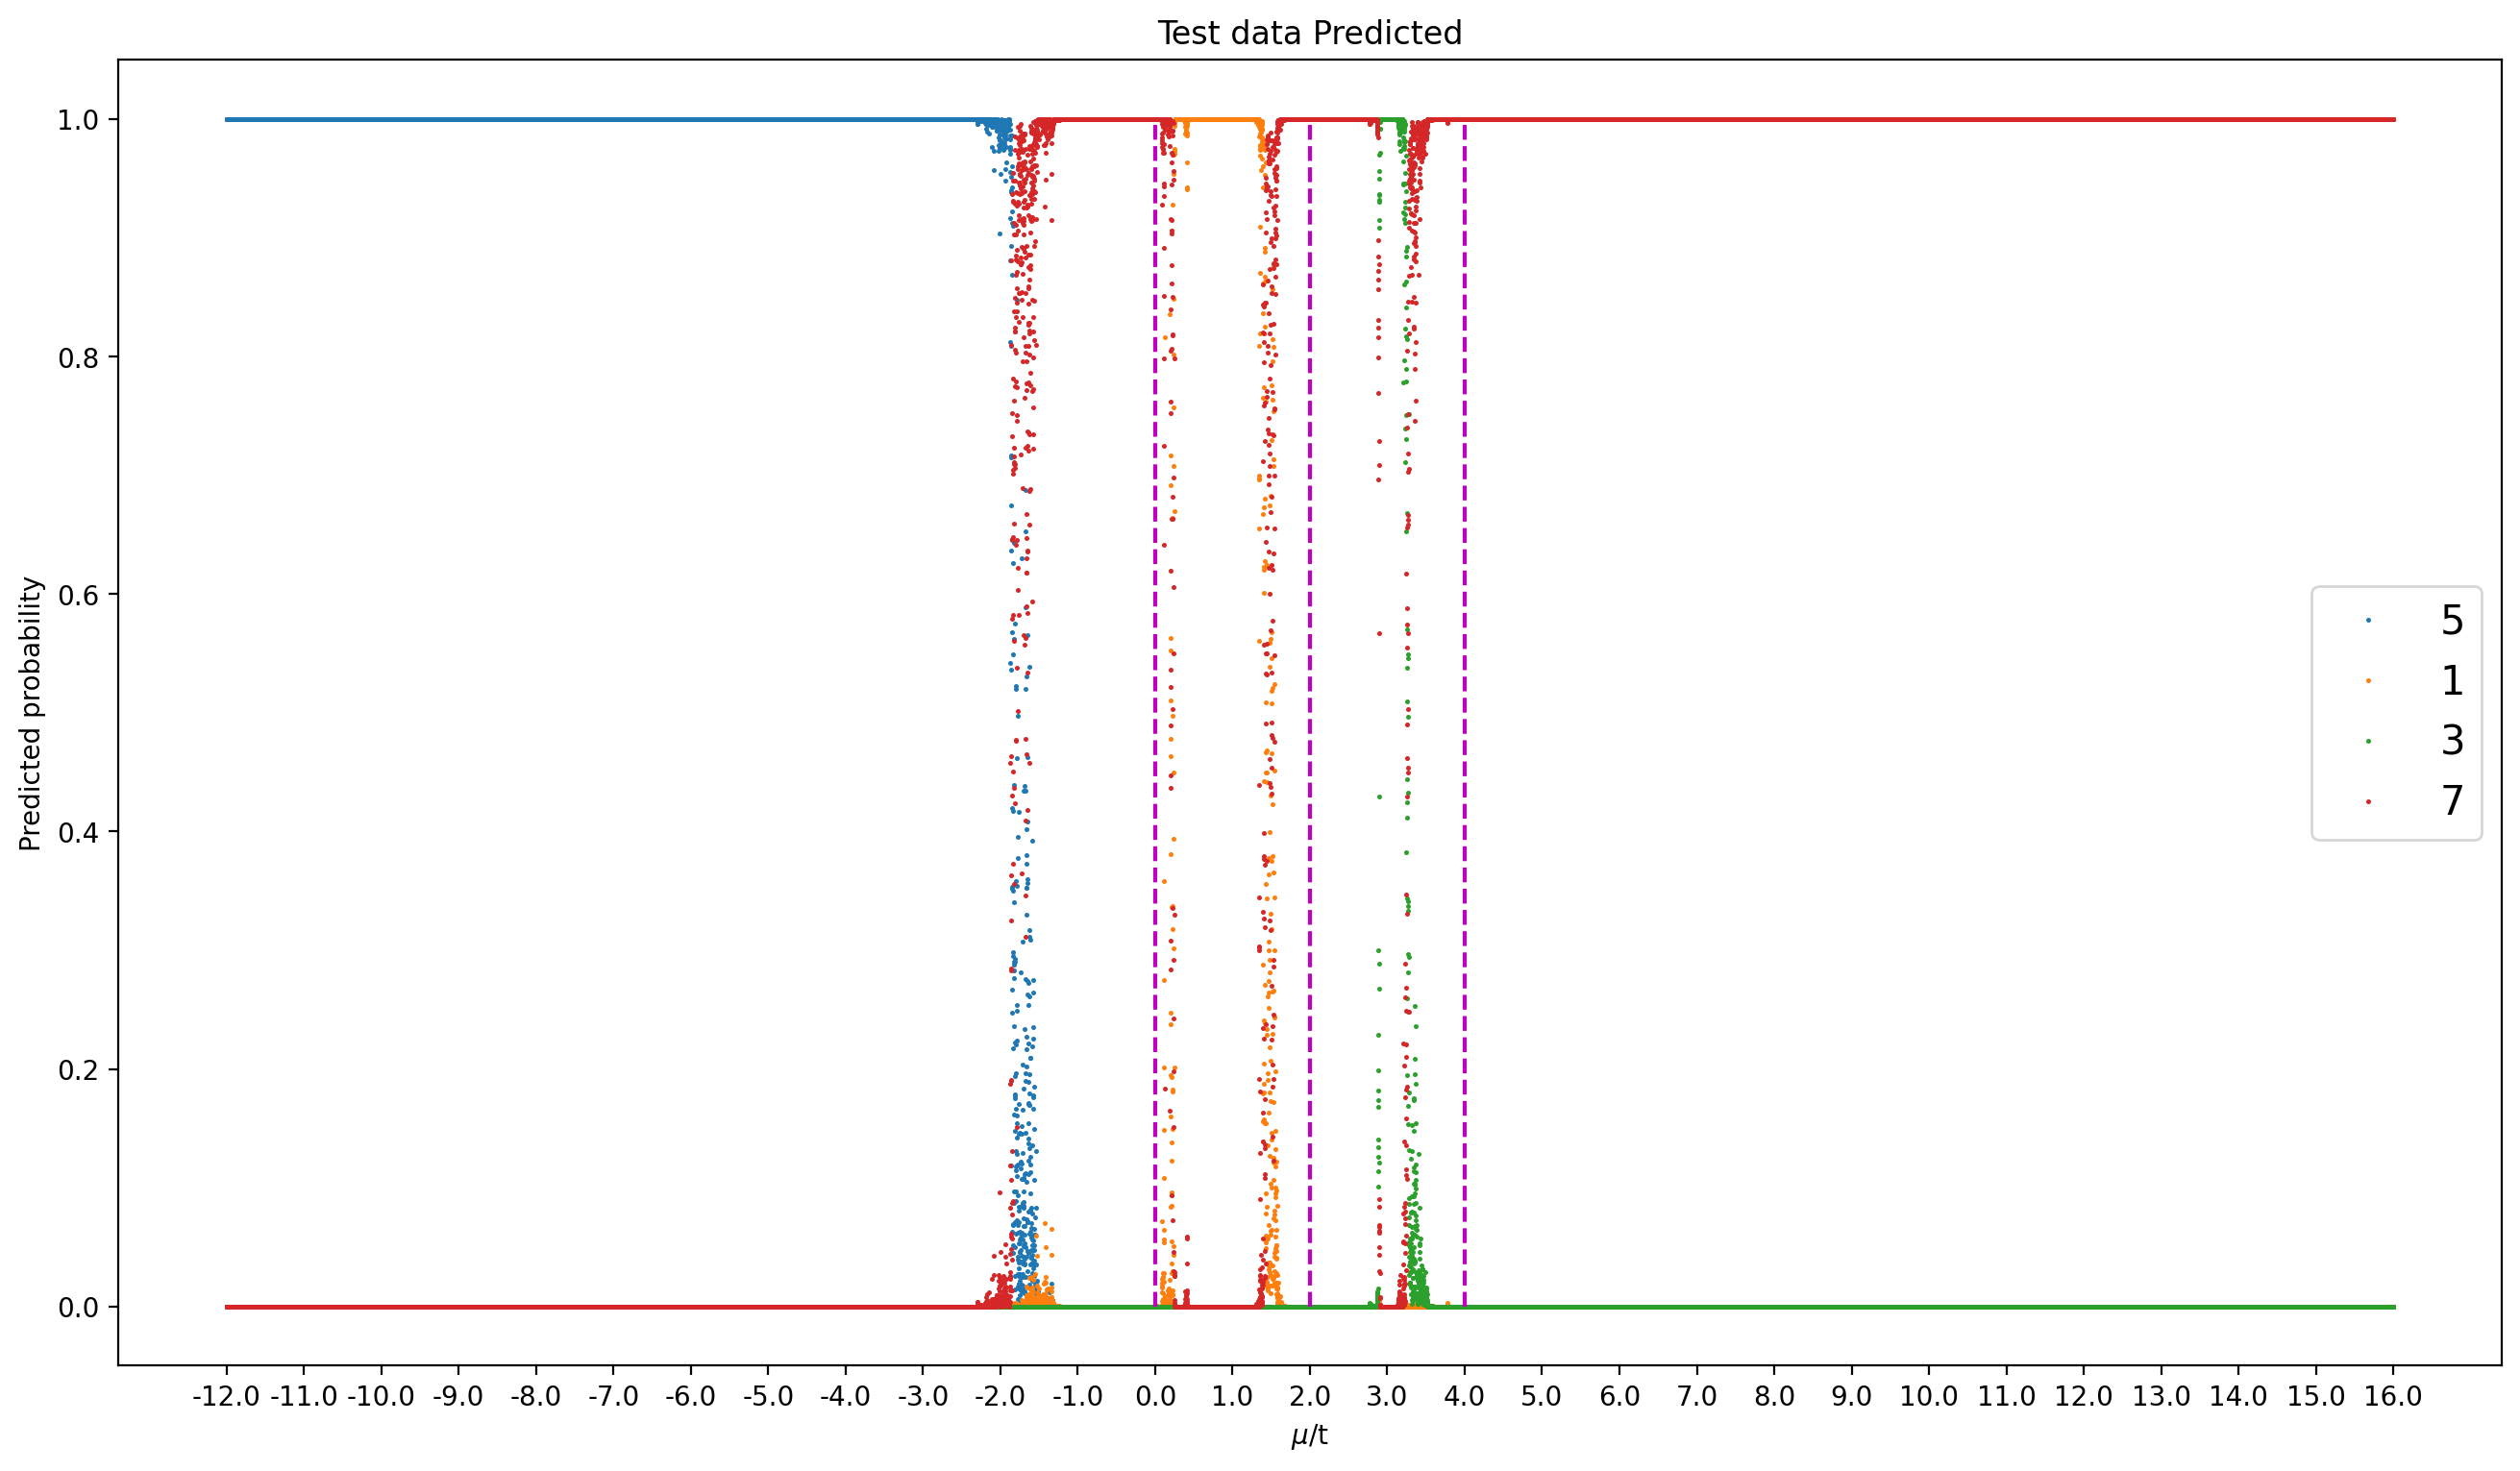

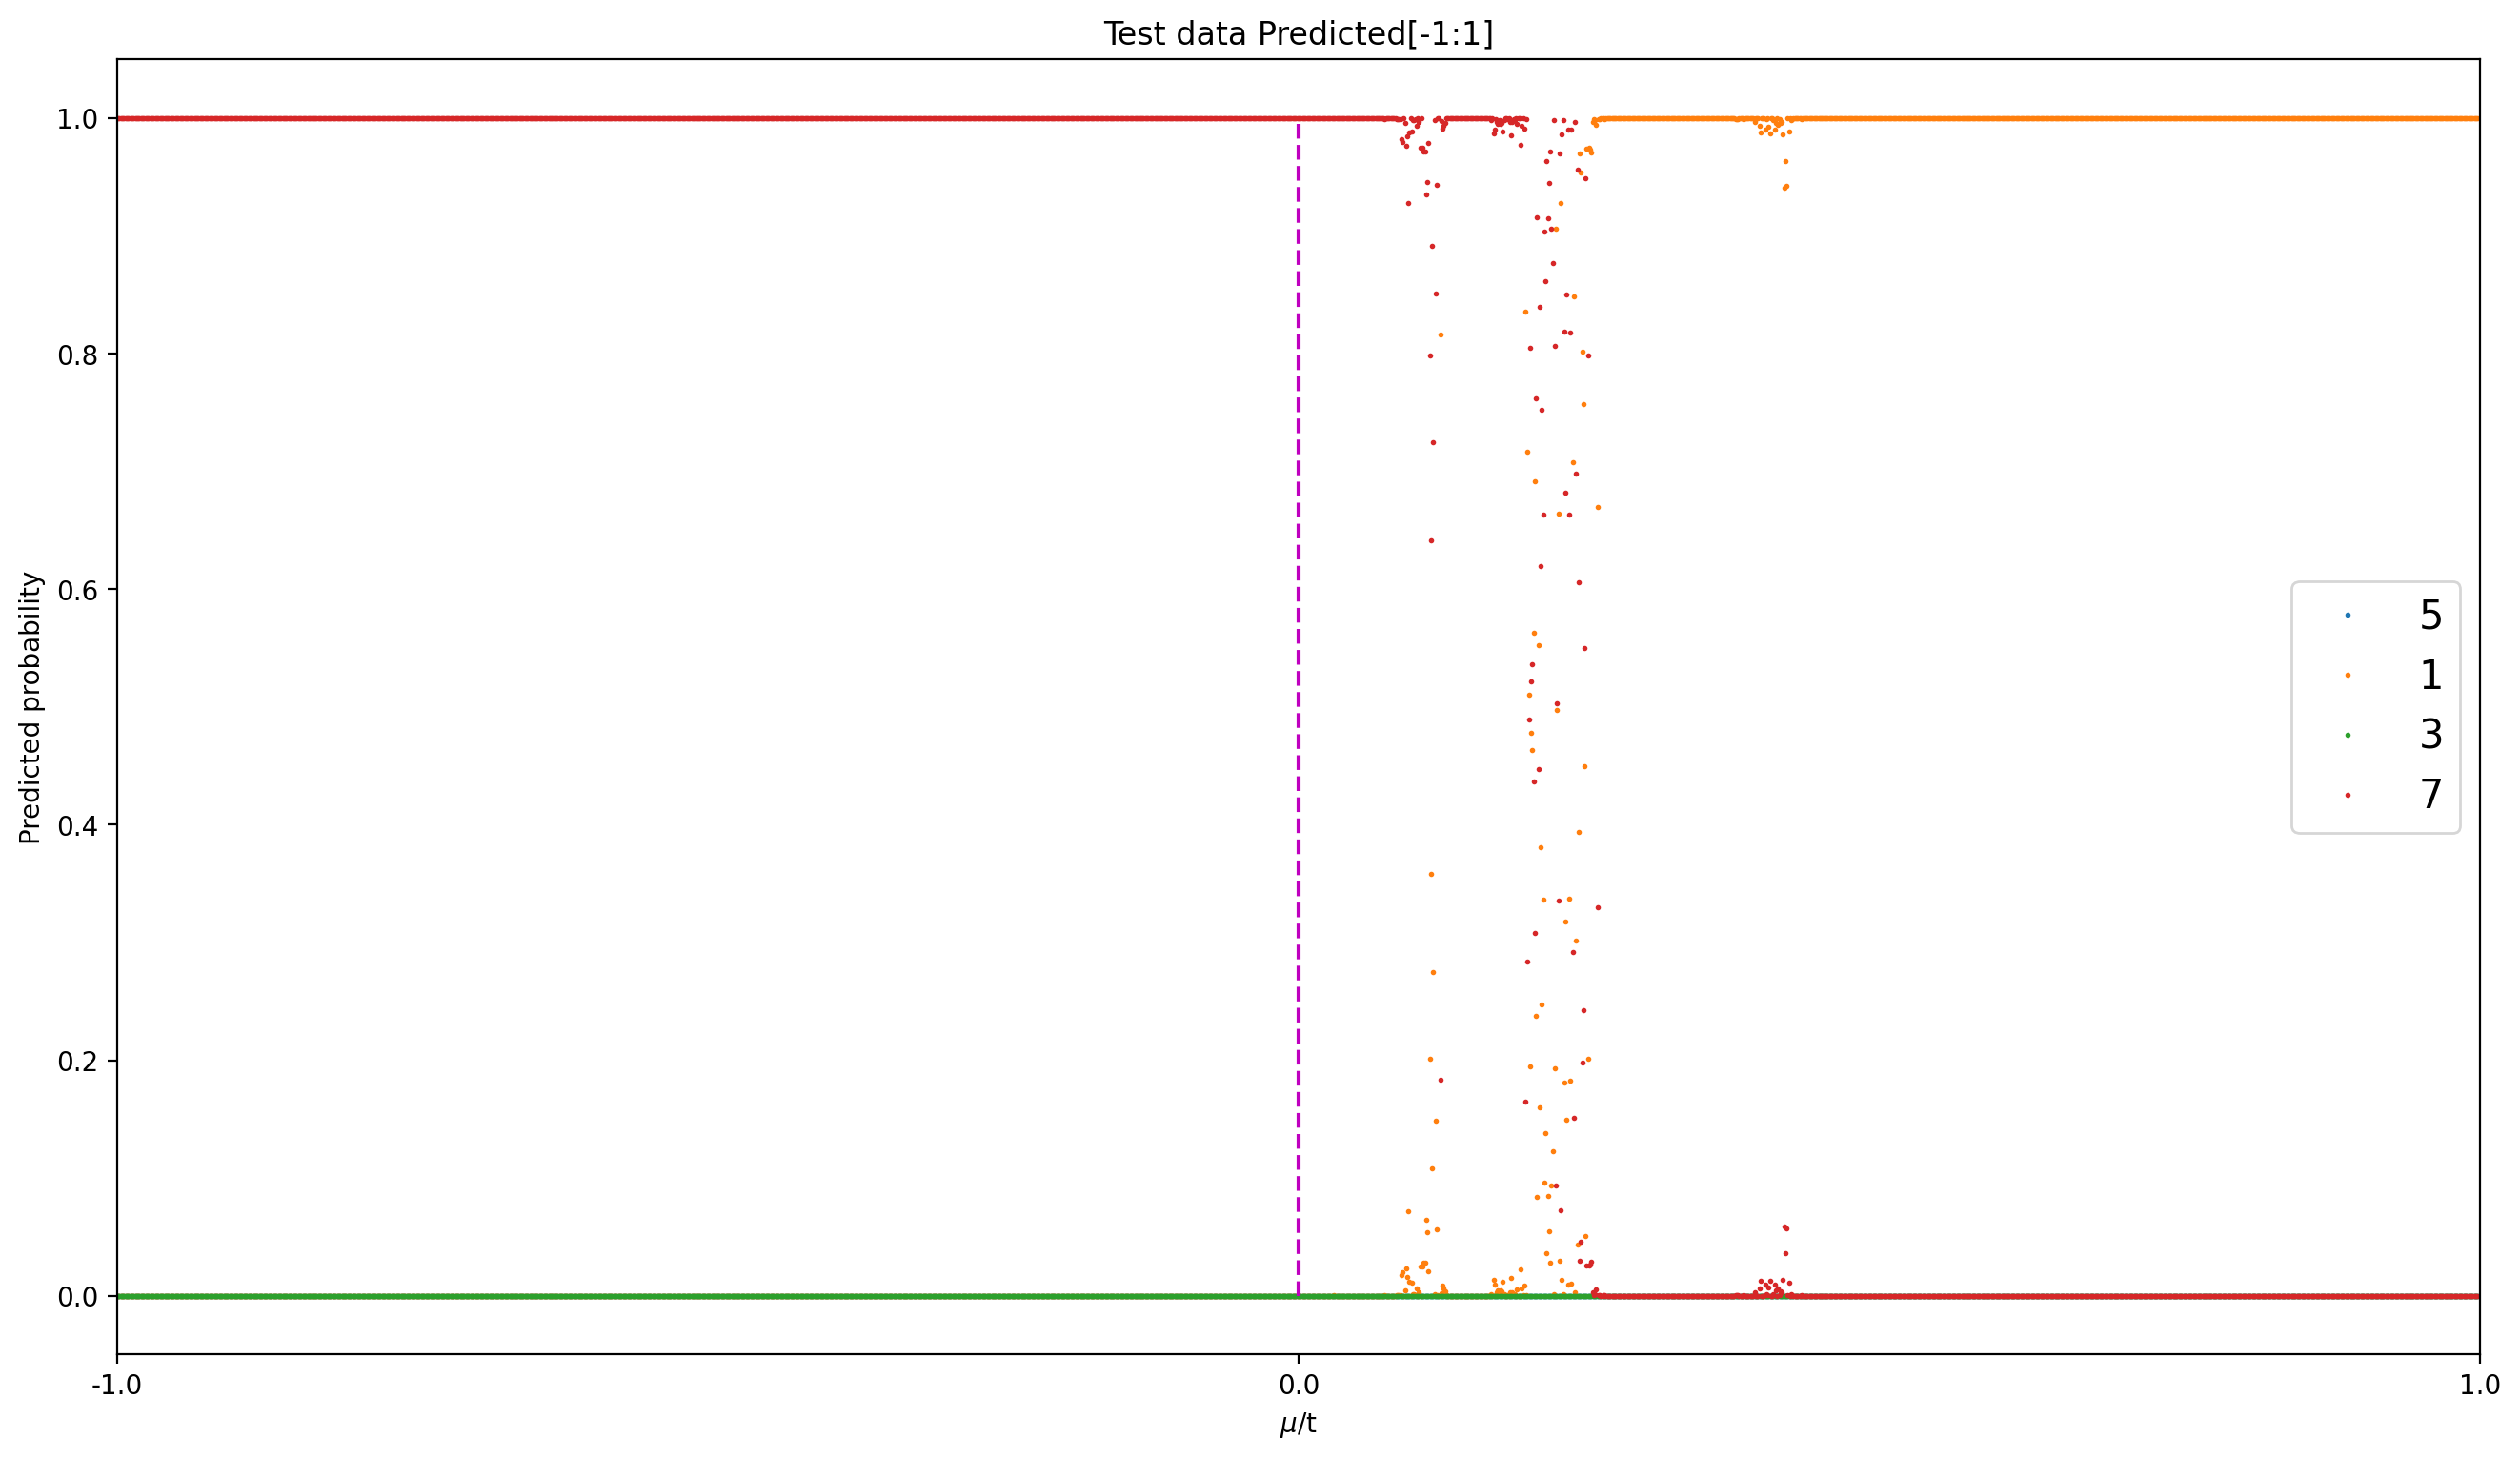

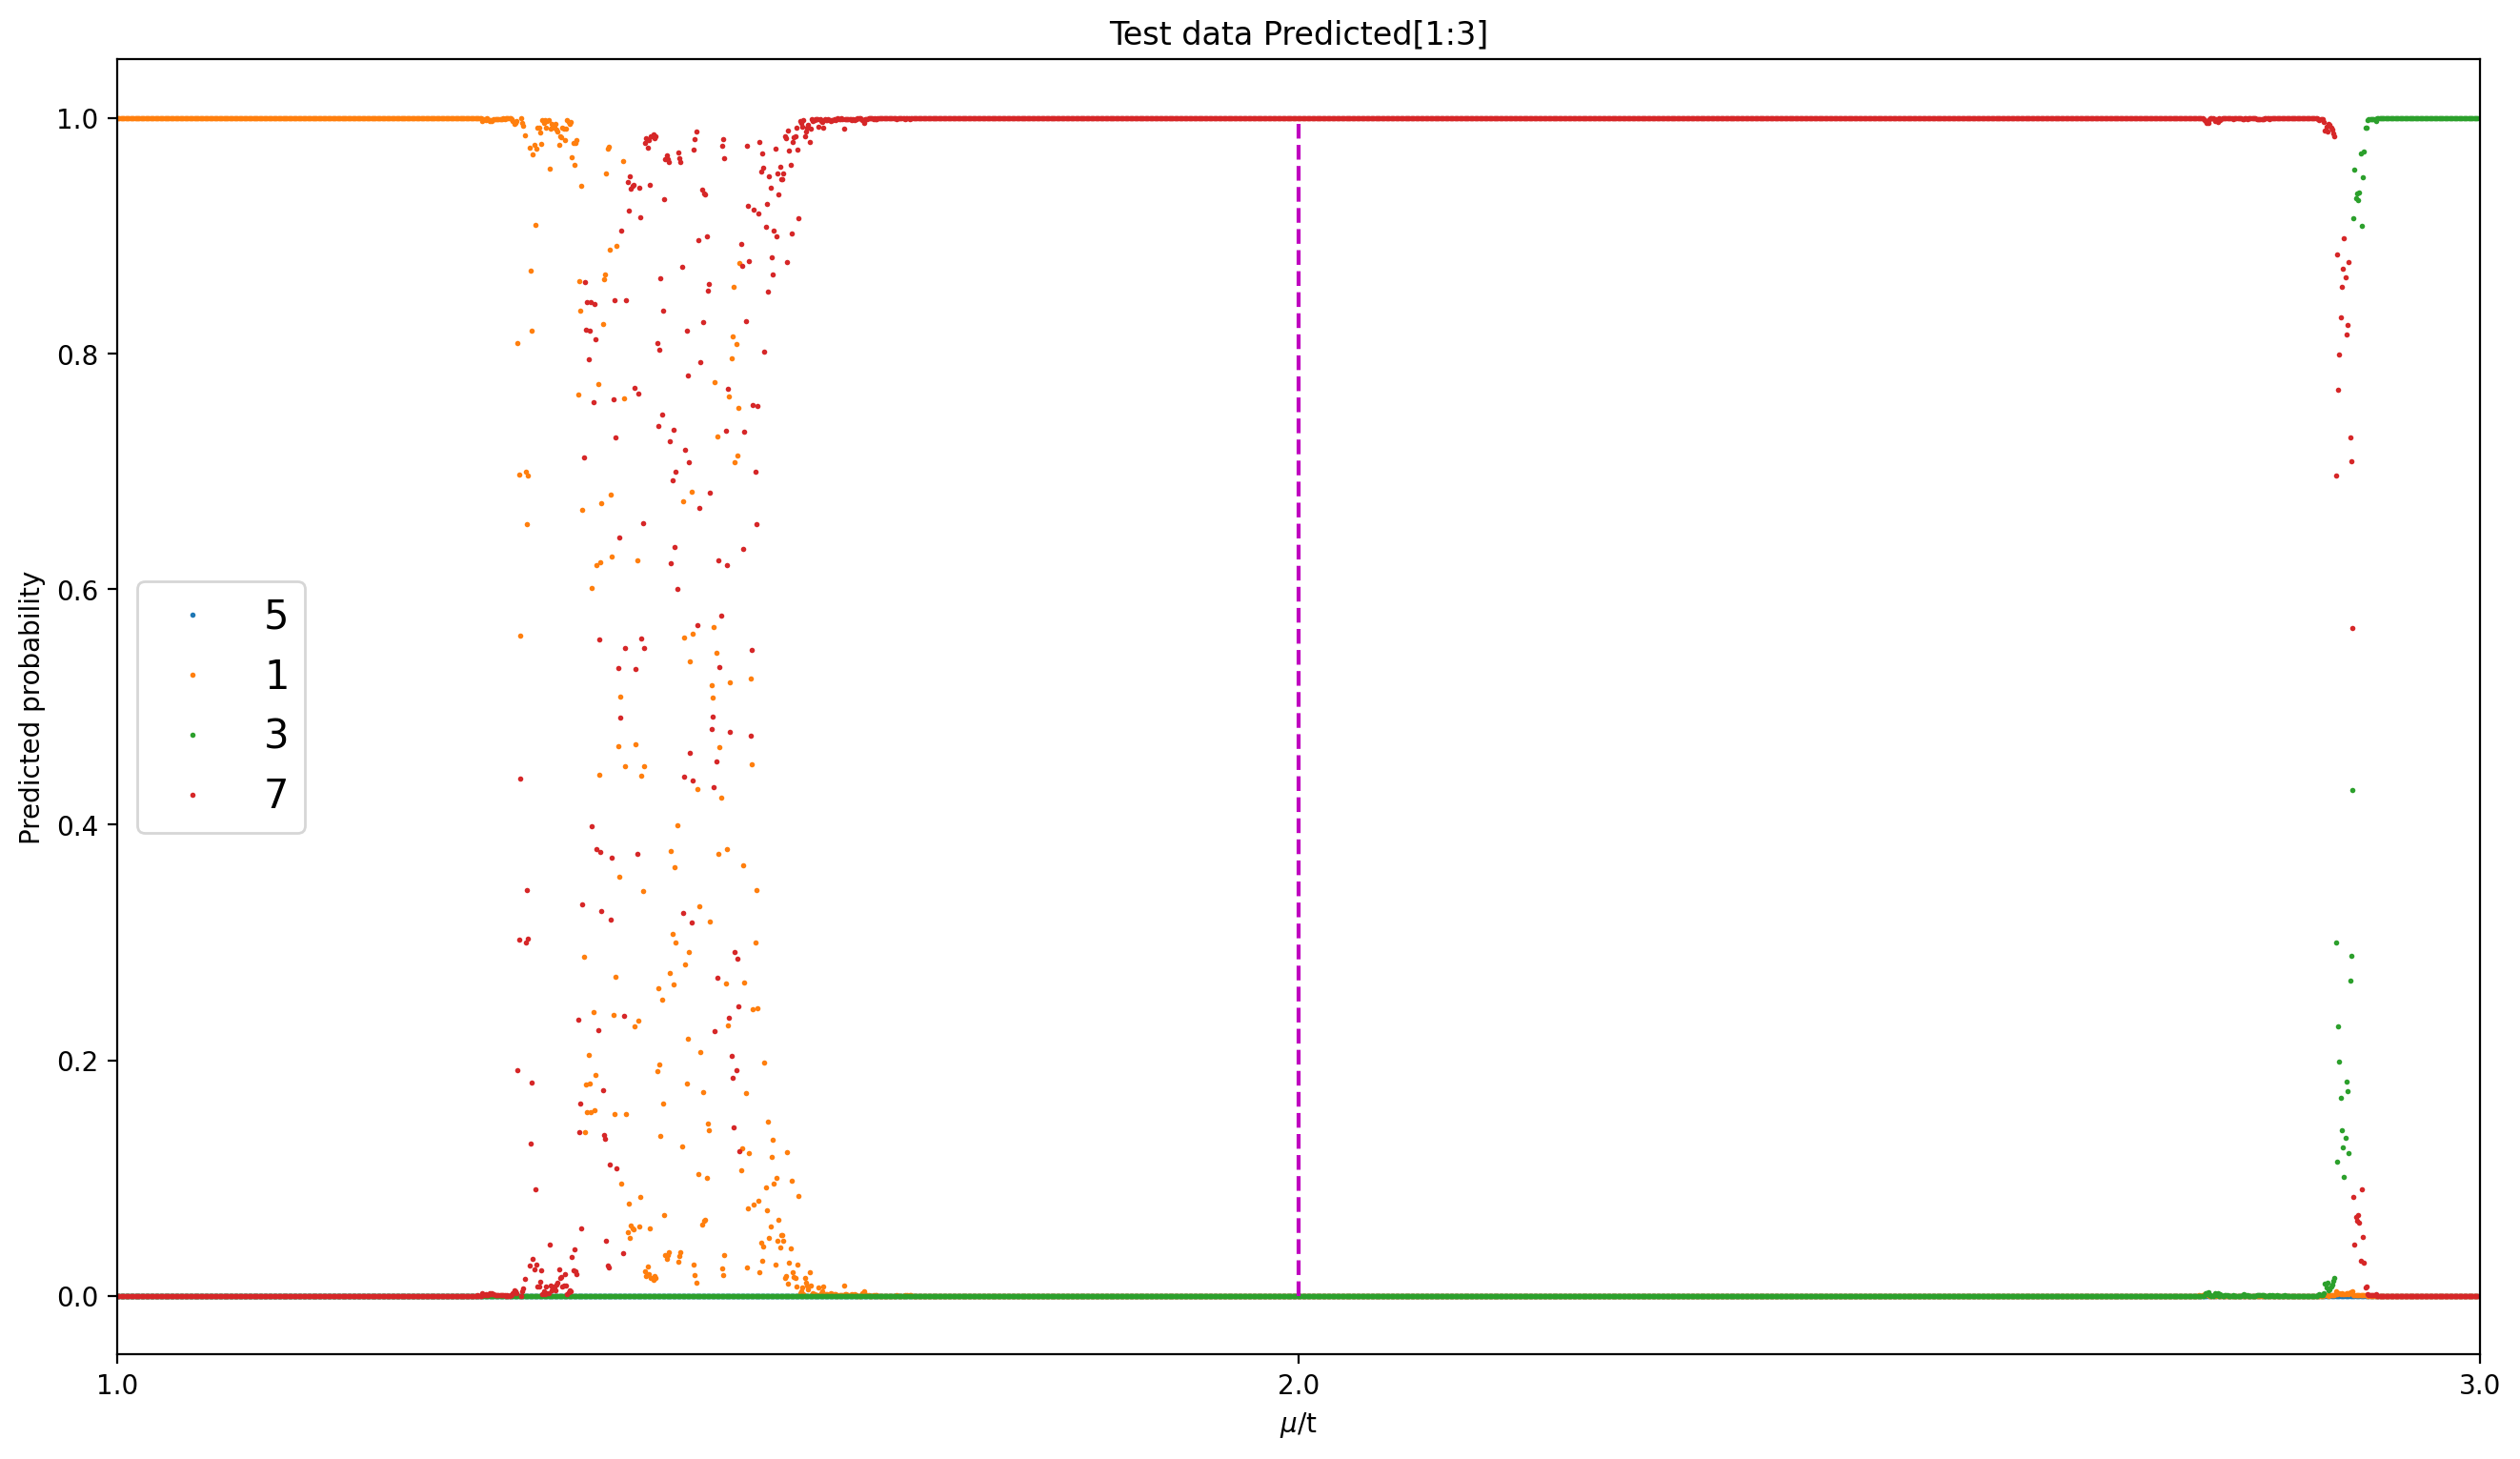

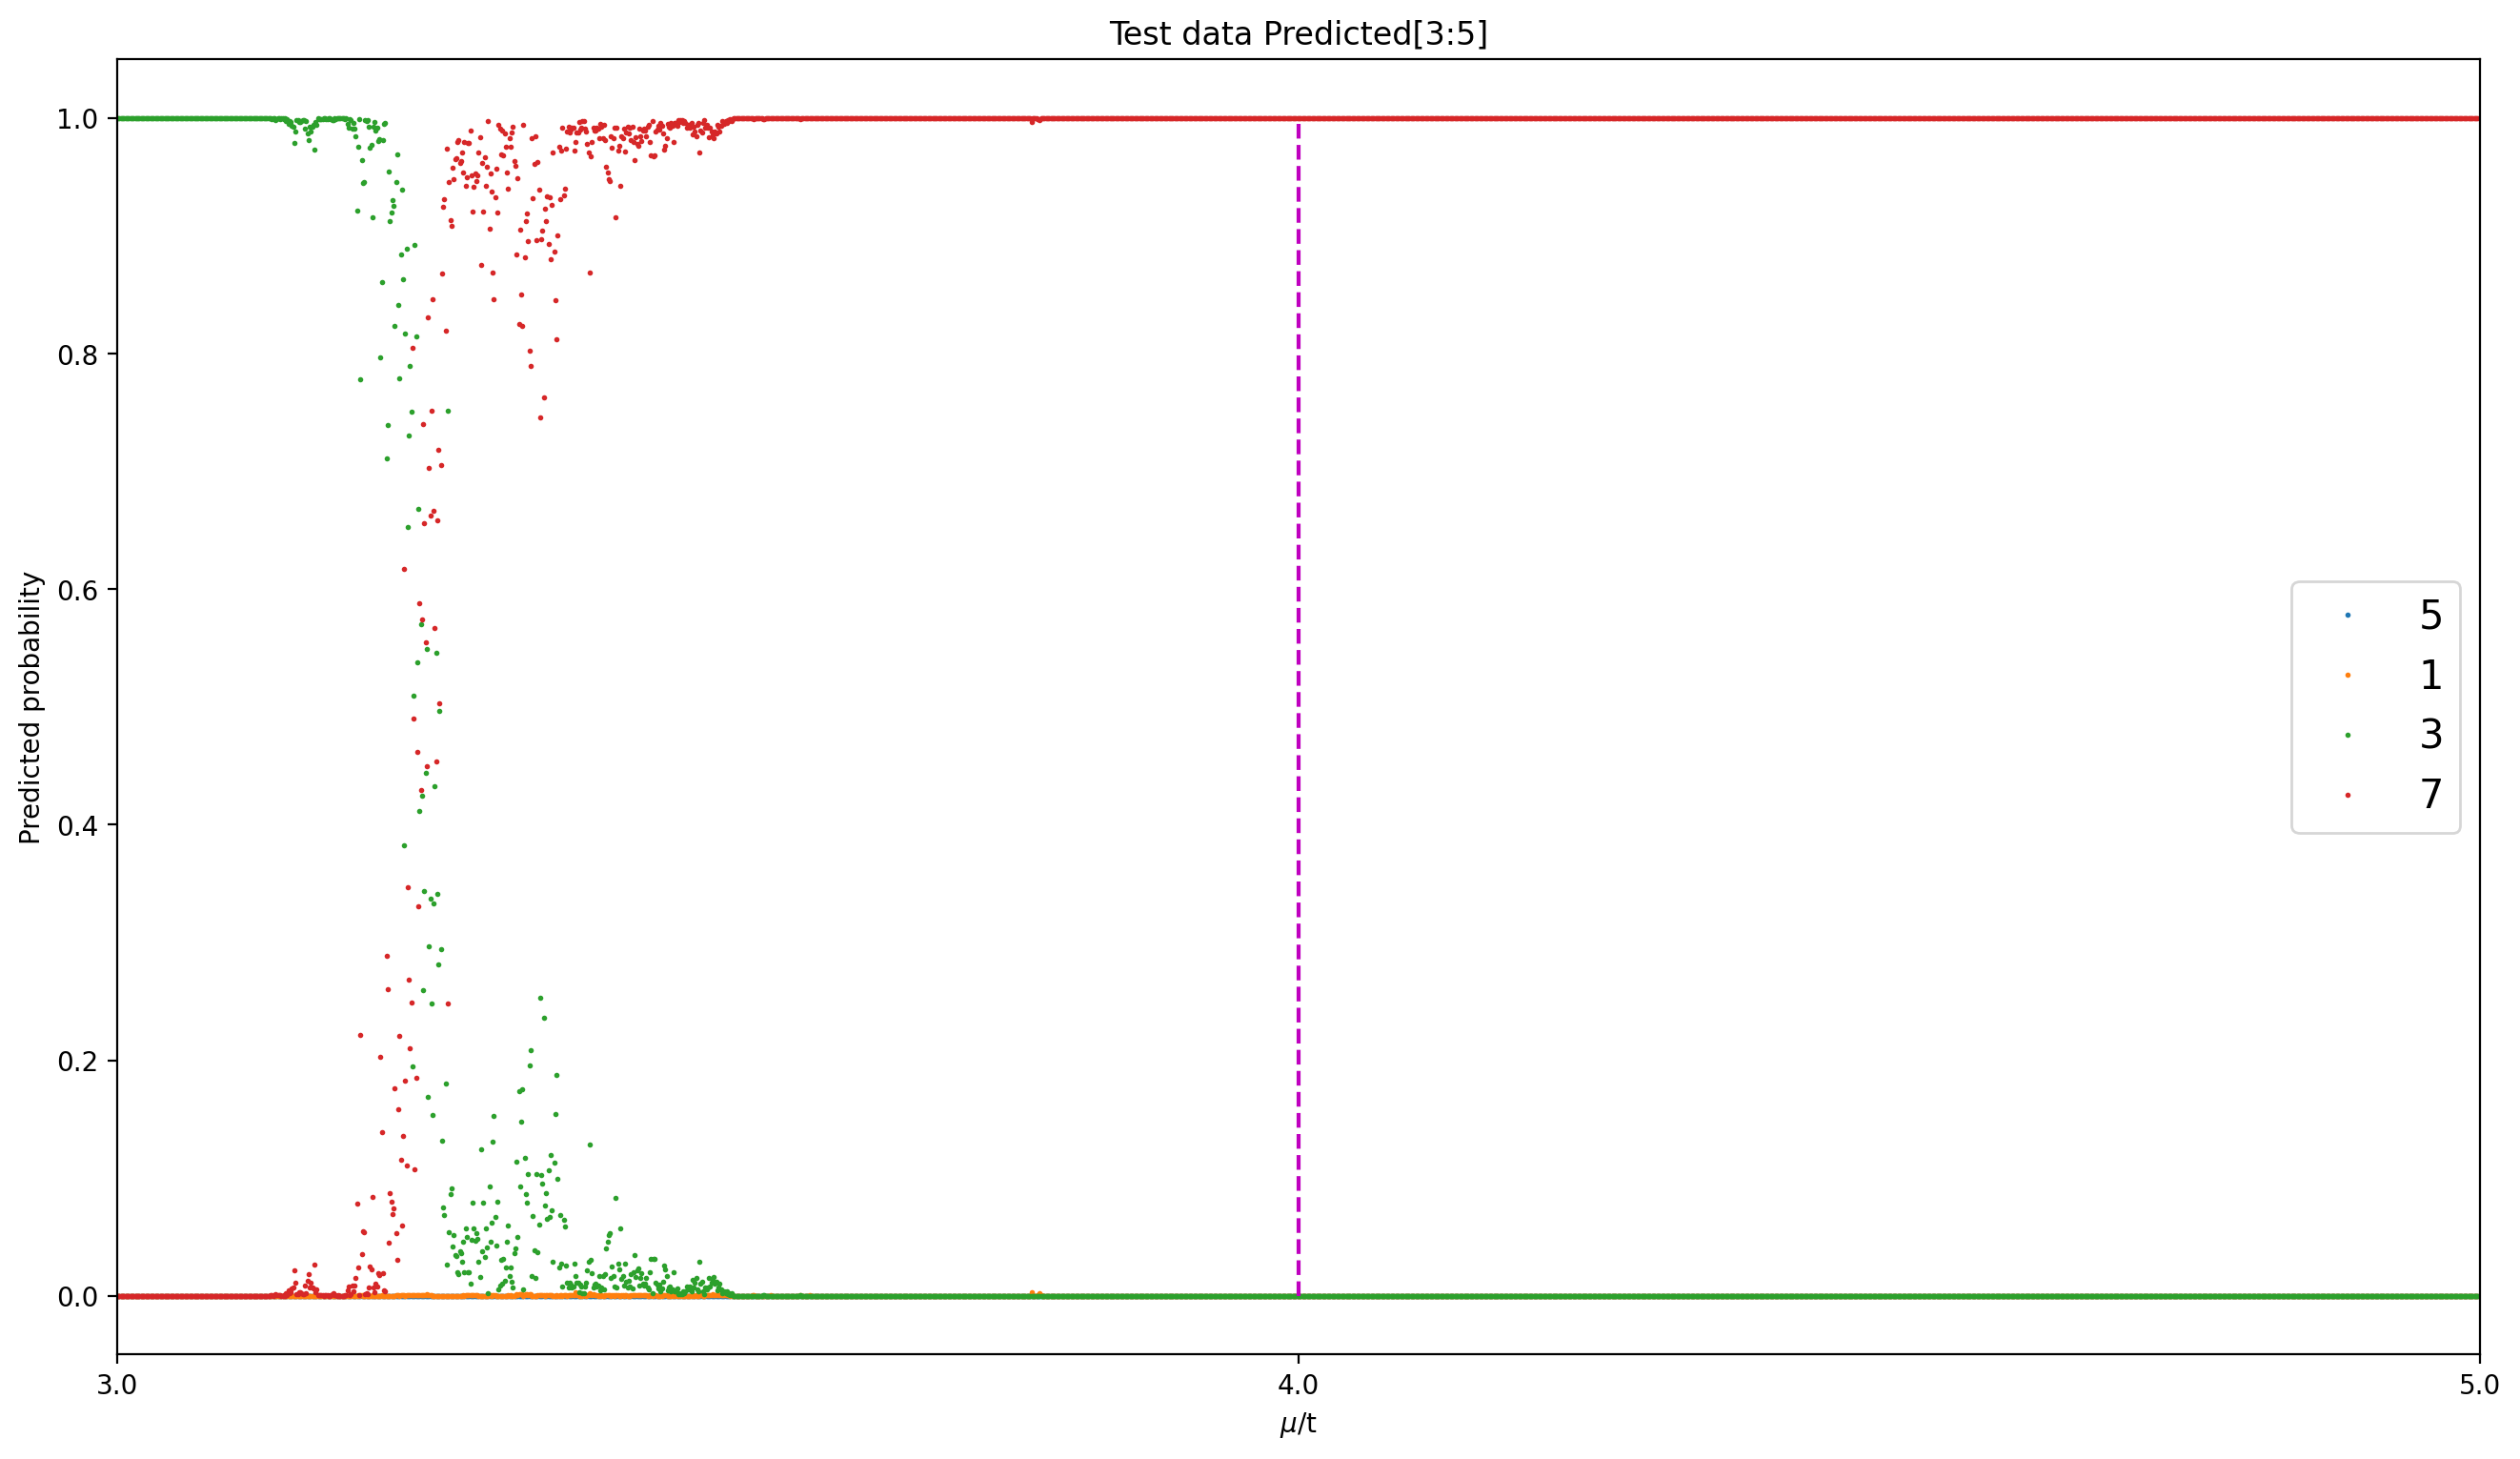

In [95]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_4D_resnet

開始獲取eigenvector_r_theta_4D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [96]:
train_data = get_train_data(train_data_path, date, N, delta)[4]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[4]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 128, 8, 8, 3)
(4000,)
(4000, 4)
(28001, 128, 8, 8, 3)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [97]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [98]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 128, 8, 8, 3)
(4000, 4)
Number of real trian data = 
(3200, 128, 8, 8, 3)
(3200, 4)
Number validation data = 
(800, 128, 8, 8, 3)
(800, 4)


開始架構網路

In [99]:
def resnet(input_shape):
    
    channel = 2*(NN**2)
    
    inputs = Input(shape=input_shape)
    
    x = Convolution3D(batch_input_shape = (None, channel, NN, NN, 3), 
                      filters = channel,
                      kernel_size = (3,3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(inputs)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = Convolution3D(filters = channel,
                      kernel_size = (3,3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(x)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = keras.layers.add([x,inputs])
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(4)(x)
    
    outputs = Activation('softmax')(x)
    
    return Model(inputs=inputs,outputs=outputs)

channel = 2*(NN**2)
model = resnet((channel, NN, NN, 3))

In [100]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 8, 8, 3) 0                                            
__________________________________________________________________________________________________
conv3d_5 (Conv3D)               (None, 128, 8, 8, 3) 442496      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 8, 8, 3) 12          conv3d_5[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 128, 8, 8, 3) 0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [101]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [102]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 2s 556us/step - loss: 0.7621 - accuracy: 0.9688 - val_loss: 7.2084e-06 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 378us/step - loss: 1.1176e-10 - accuracy: 1.0000 - val_loss: 1.6677e-06 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 378us/step - loss: 7.4506e-11 - accuracy: 1.0000 - val_loss: 3.0041e-07 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 378us/step - loss: 7.4506e-11 - accuracy: 1.0000 - val_loss: 4.6939e-08 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 377us/step - loss: 7.4506e-11 - accuracy: 1.0000 - val_loss: 7.8976e-09 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 376us/step - loss: 7.4506e-11 - accuracy: 1.0000 - val_loss: 1.6391e-09 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [===========

訓練完成  
開始提取模型資料

In [103]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


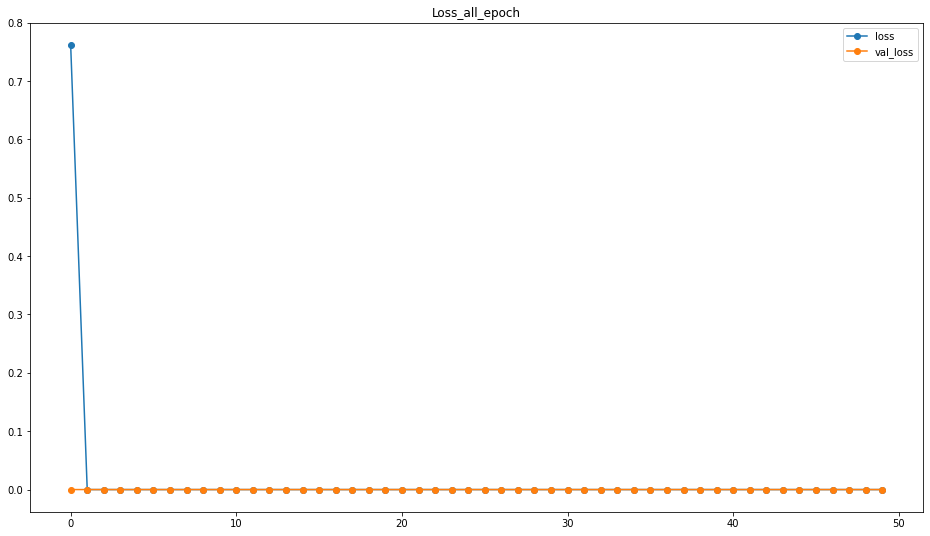

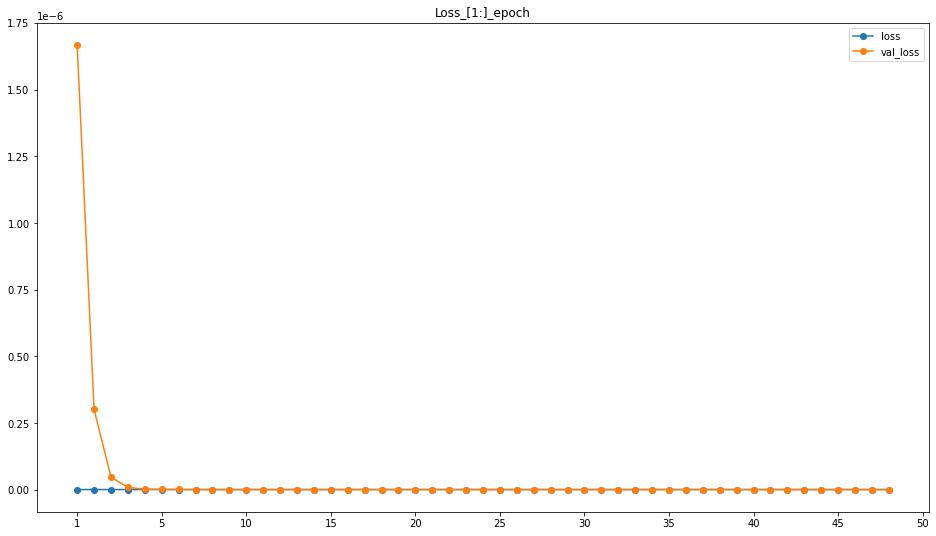

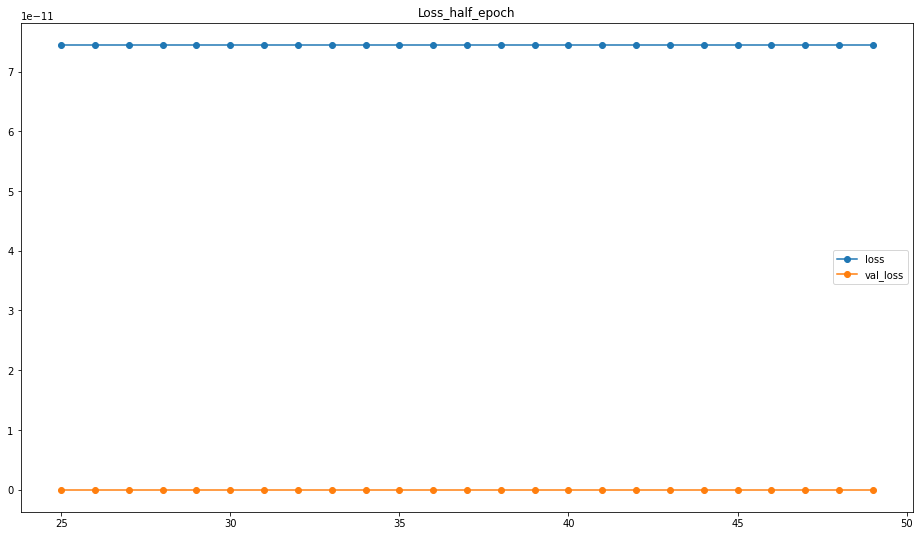

In [104]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [105]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 6s 227us/step


In [106]:
print (scores)

[8.934997912015563, 0.7361165881156921]


In [107]:
prediction = model.predict(test_data)

In [108]:
print(prediction)

[[1.0000000e+00 6.1610732e-18 1.7288647e-25 1.7325471e-08]
 [9.9999952e-01 4.1456806e-19 2.9327164e-26 4.6749076e-07]
 [9.9999976e-01 4.4371076e-20 1.3827880e-27 2.0120343e-07]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]]


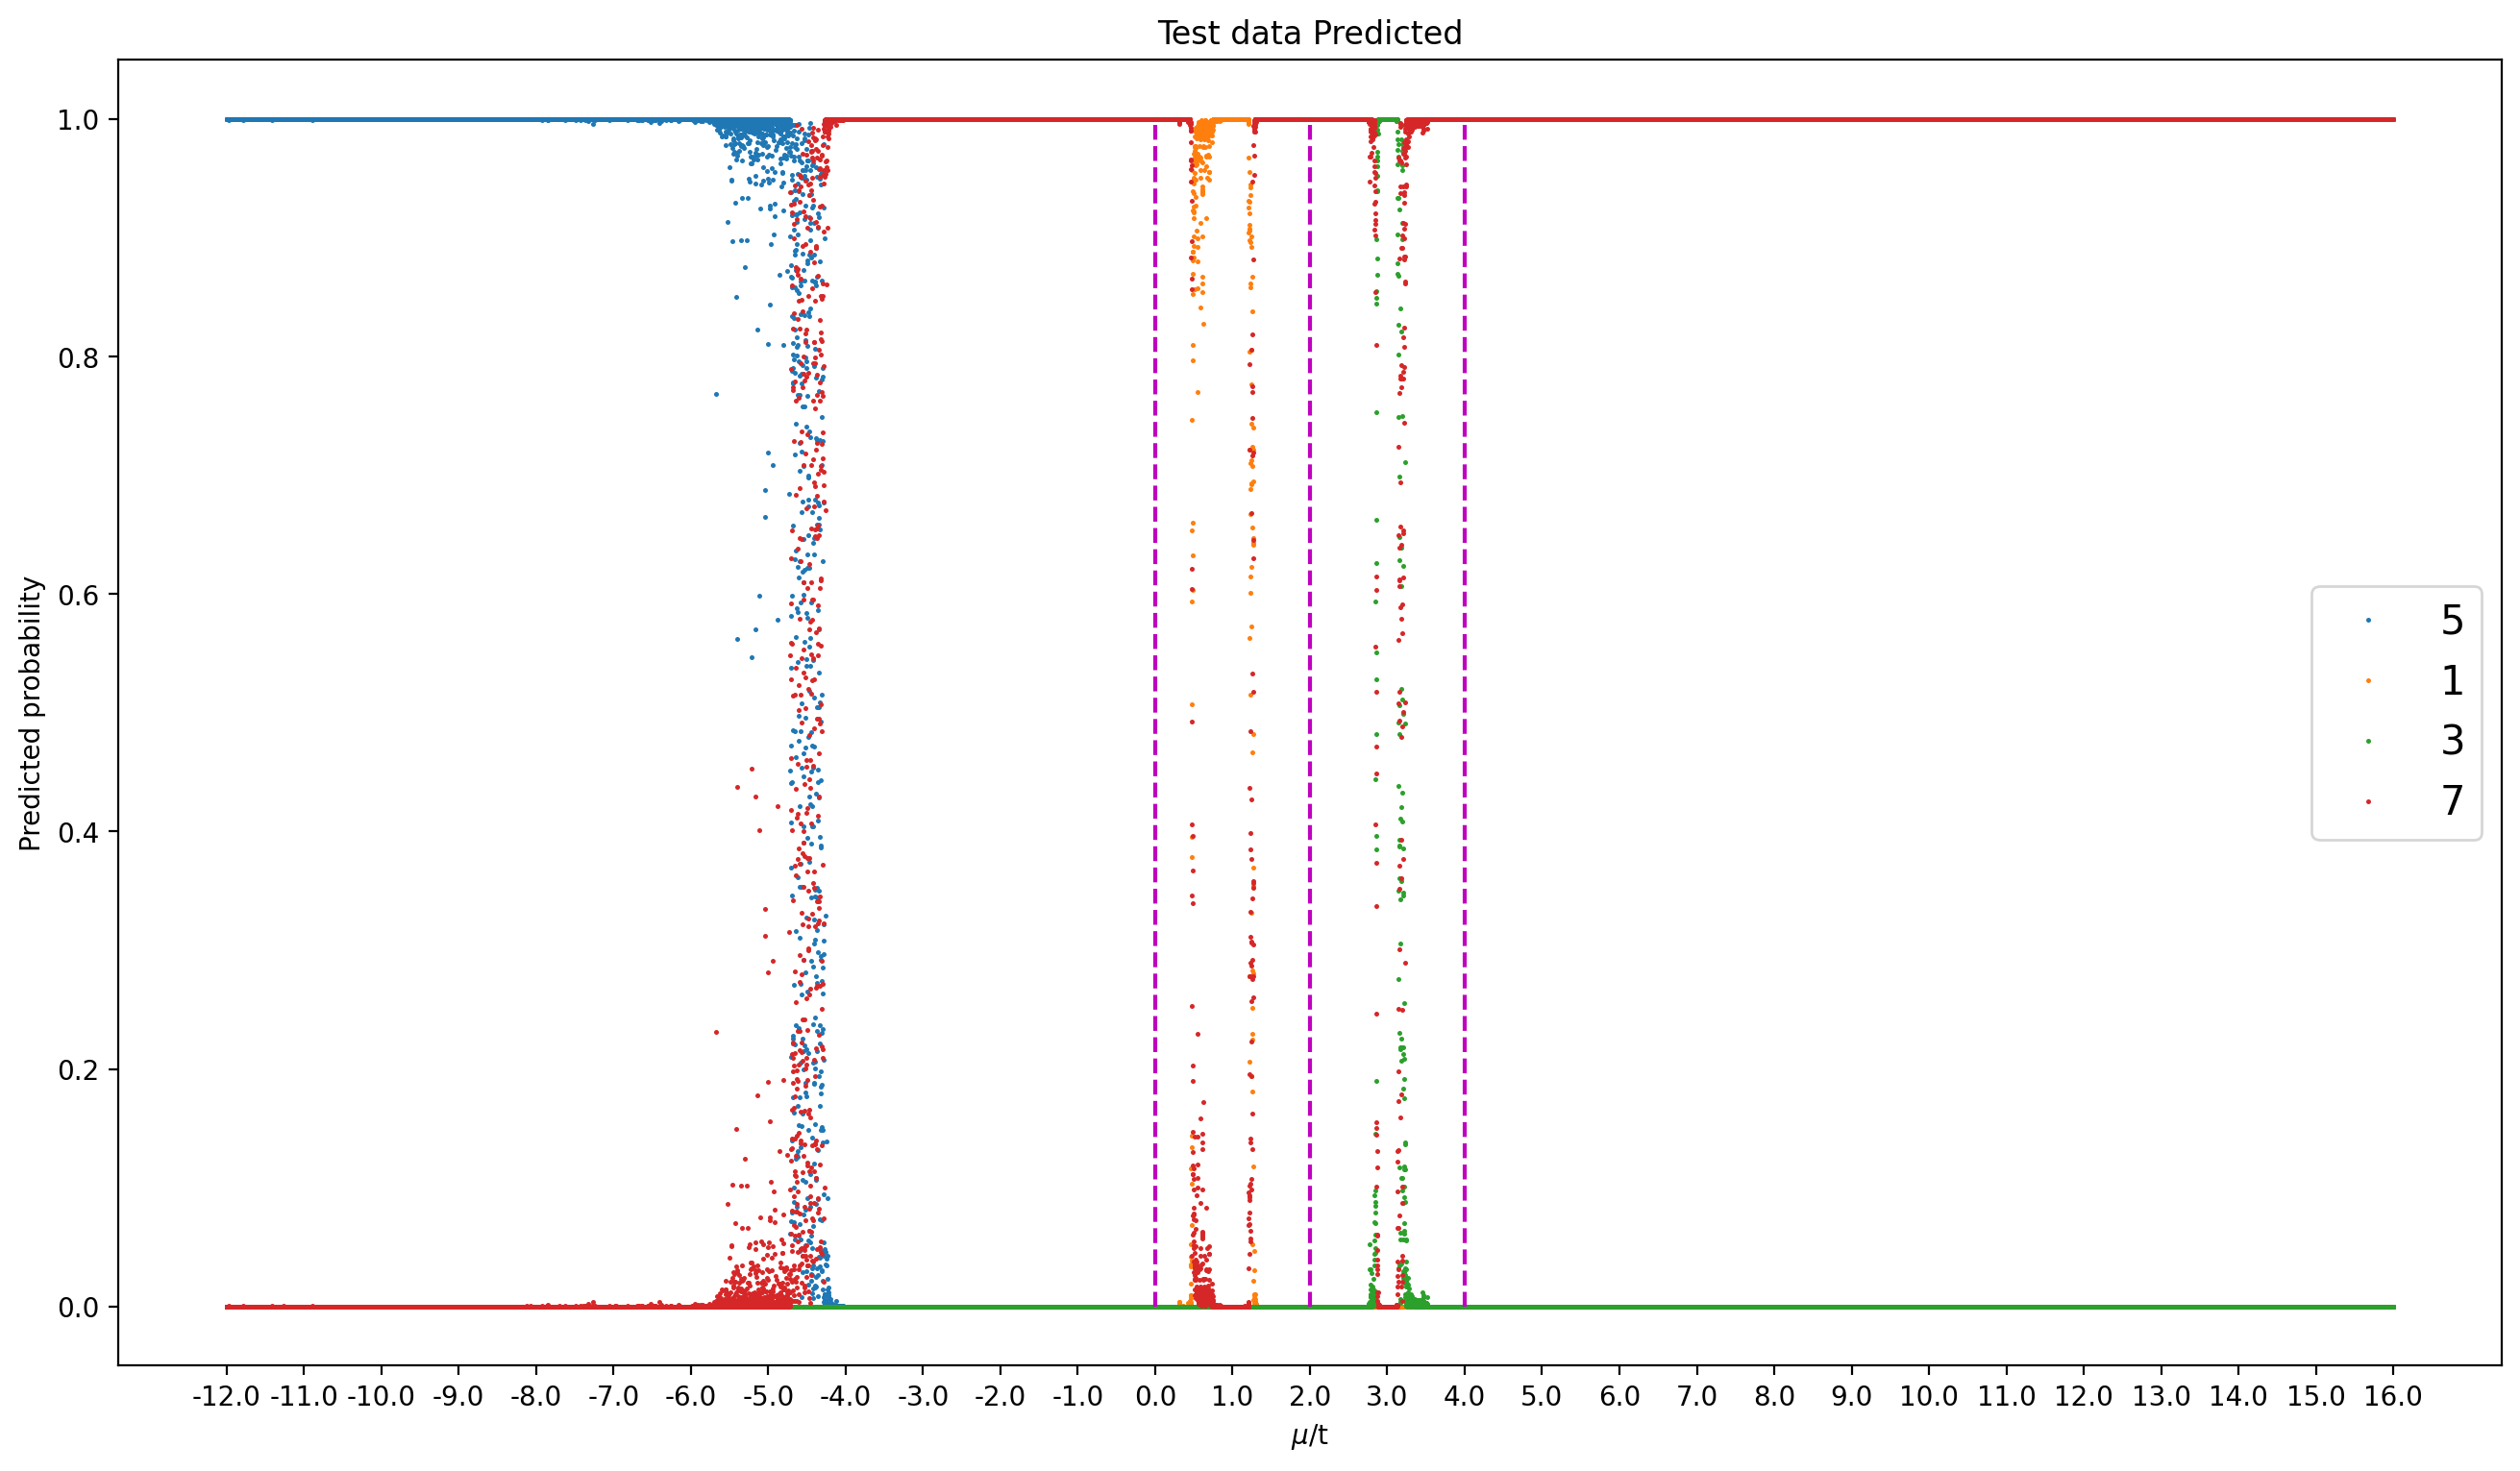

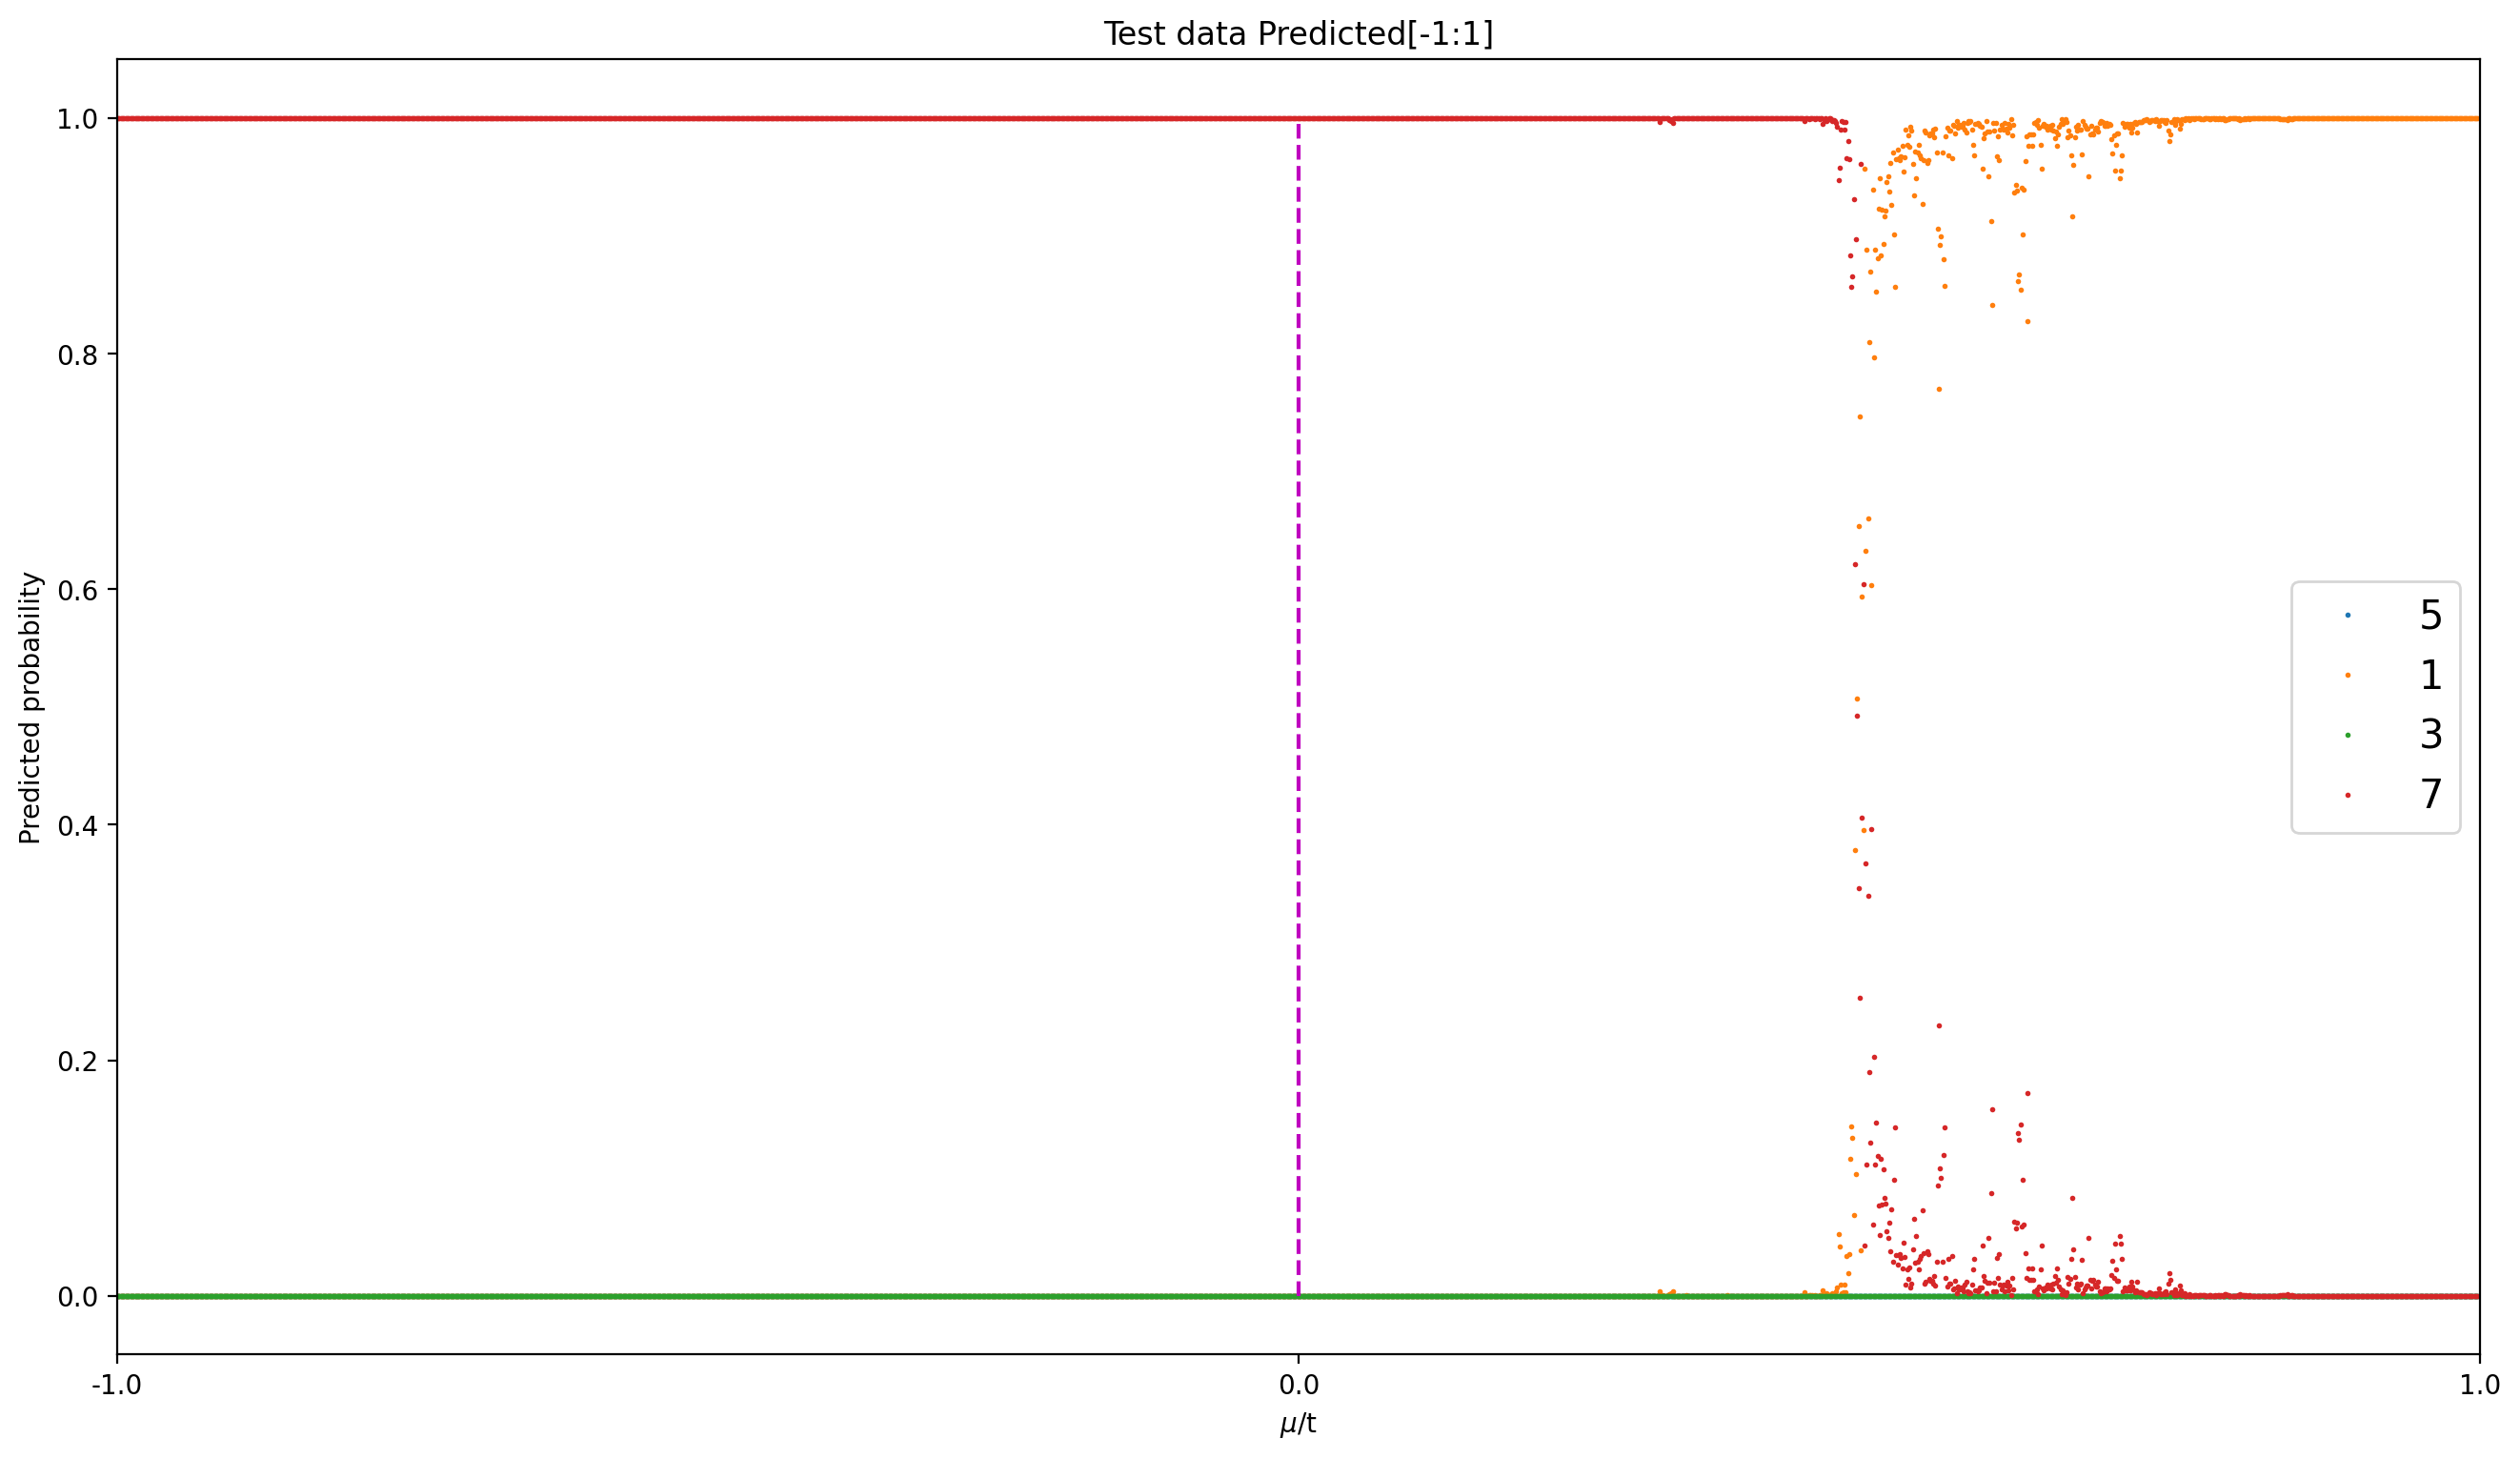

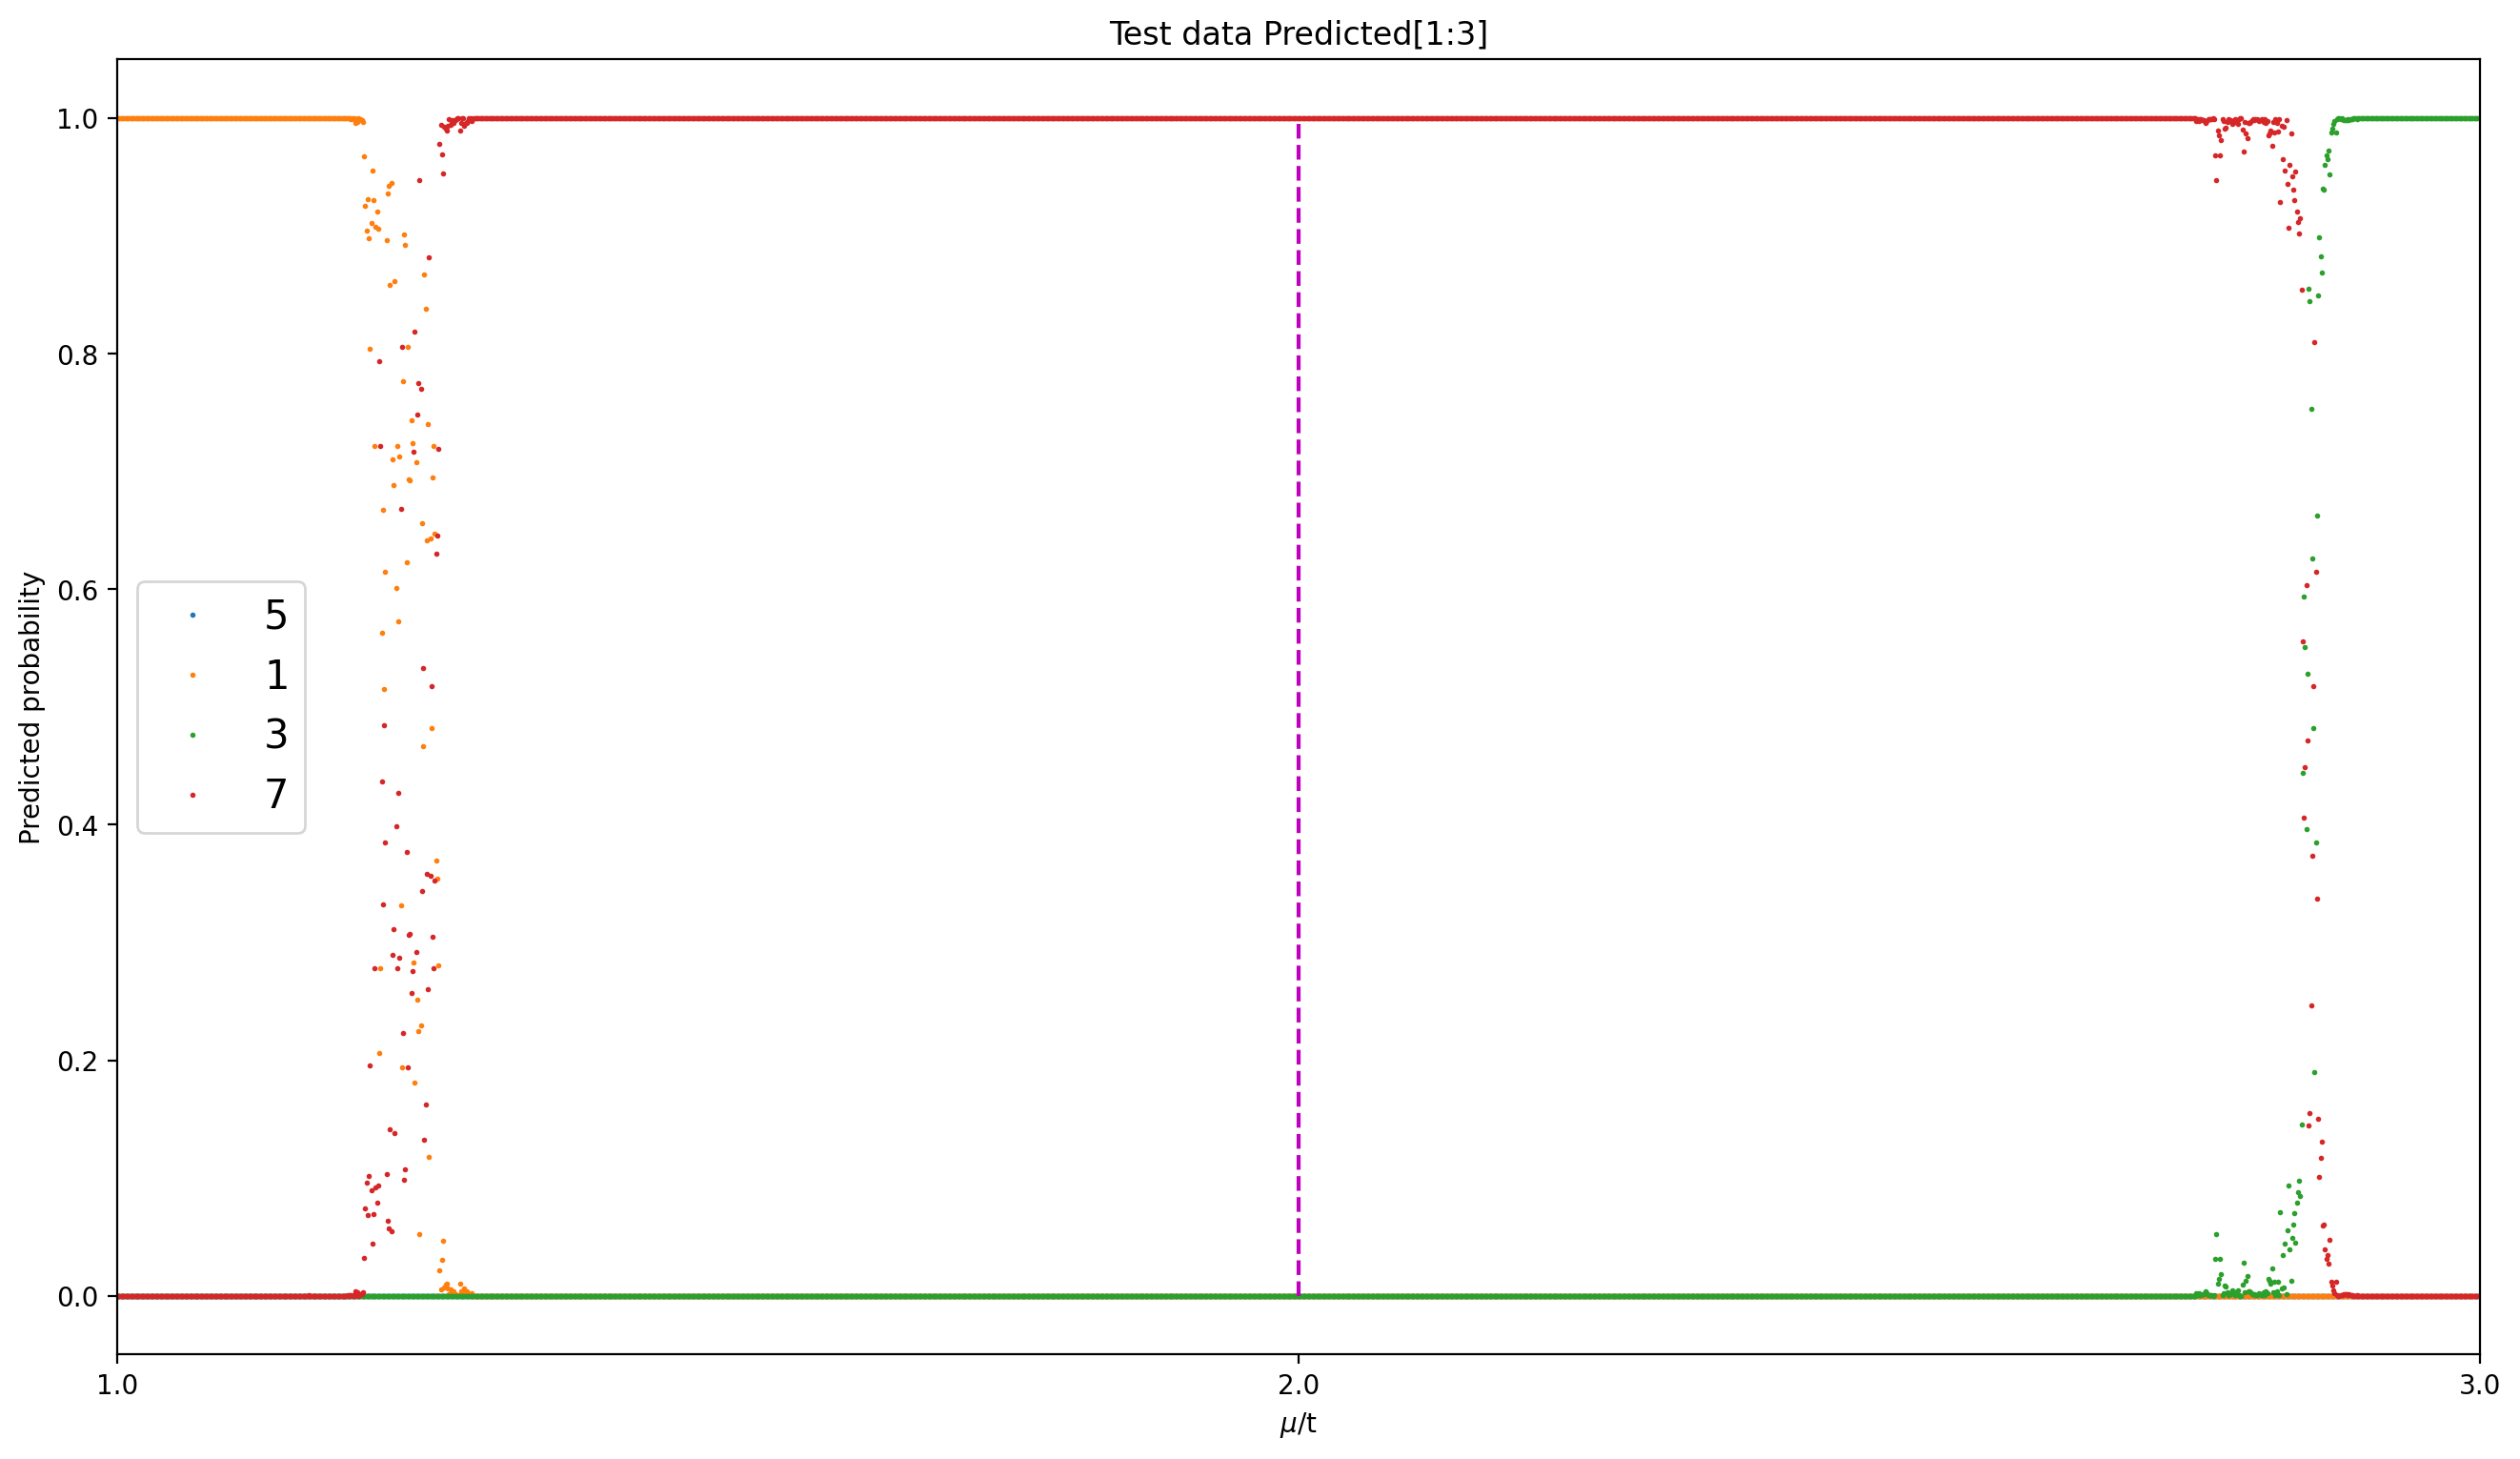

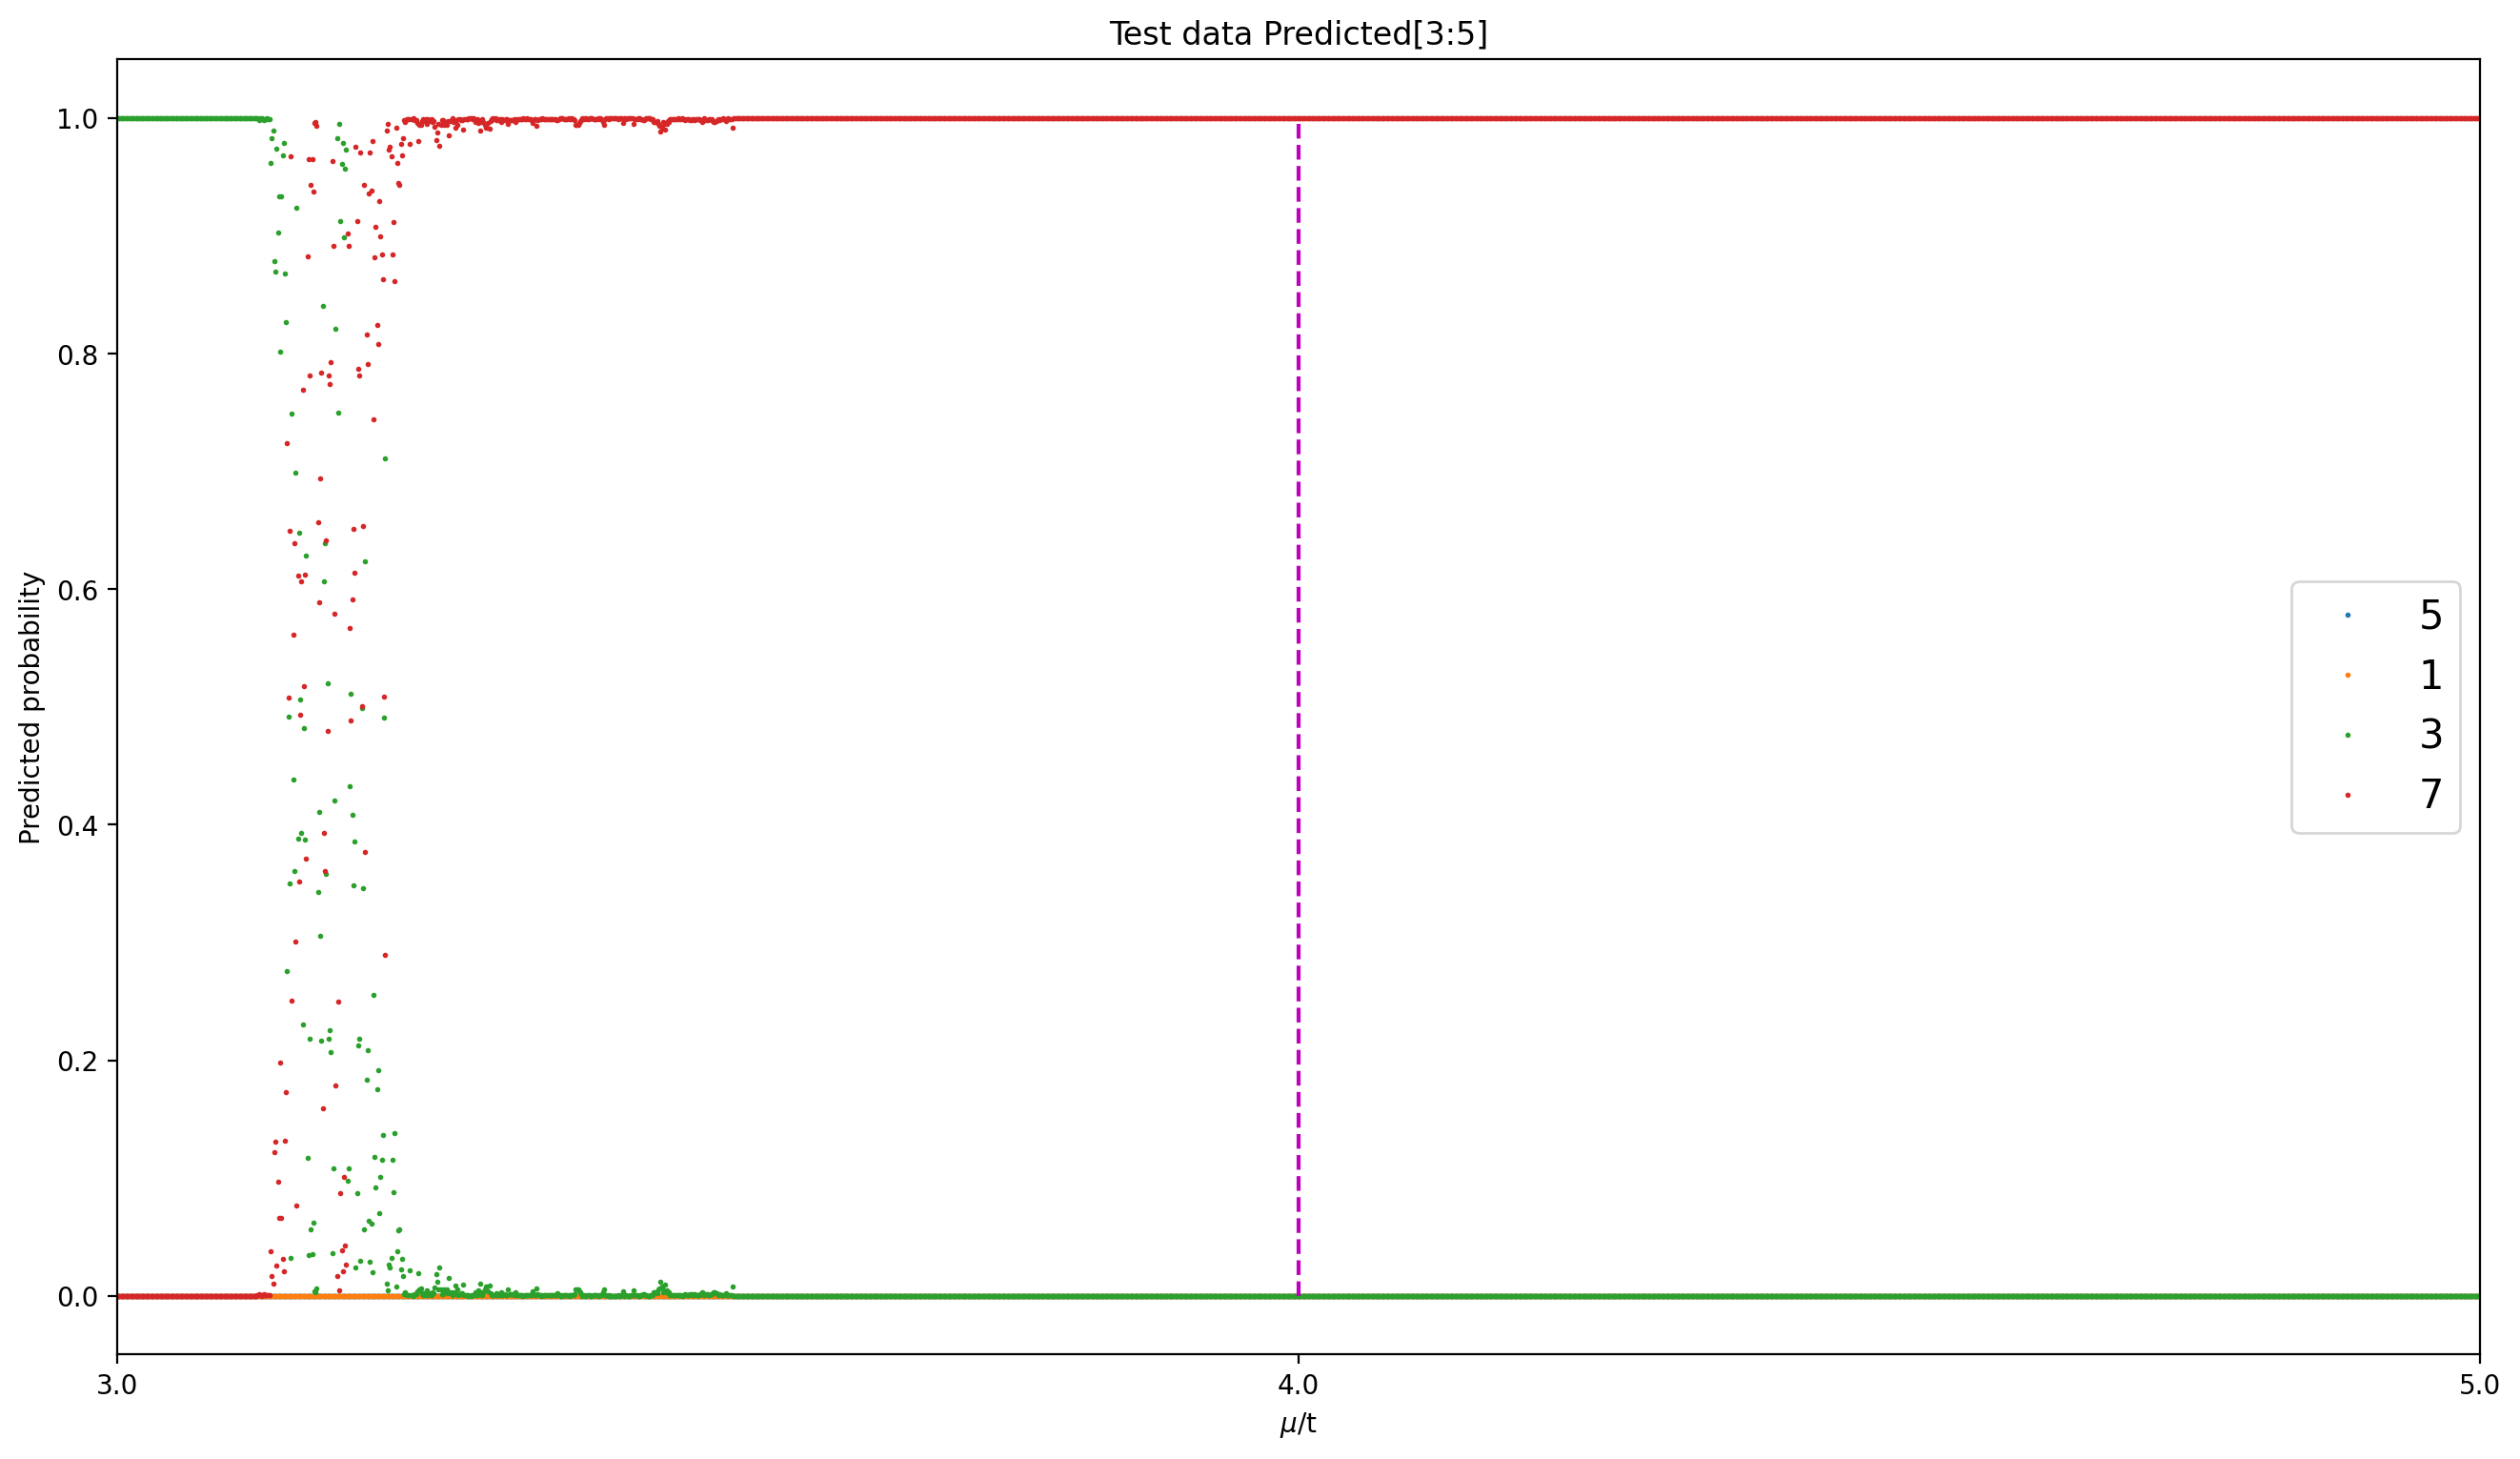

In [109]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# Resnet_eigenvector_r_theta_3D 抽中間兩根eigenvector

開始獲取eigenvector_r_theta_3D的資料，並抽出中間兩根eigenvector，並將phase轉成label  
並印出形狀確認是否正確

In [110]:
draw_out_parameters = int(((2*(NN**2)/2)-1)*3)

train_data = get_train_data(train_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)
print('draw_out_parameters = ' + str(draw_out_parameters))

(4000, 6, 8, 8)
(4000,)
(4000, 4)
(28001, 6, 8, 8)
(28001,)
(28001, 4)
draw_out_parameters = 189


將train data, train_one_hot_label 同步打亂

In [111]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [112]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 6, 8, 8)
(4000, 4)
Number of real trian data = 
(3200, 6, 8, 8)
(3200, 4)
Number validation data = 
(800, 6, 8, 8)
(800, 4)


開始架構網路

In [113]:
def resnet(input_shape):
    
    channel = 6
    
    inputs = Input(shape=input_shape)
    
    x = Convolution2D(batch_input_shape = (None, channel, NN, NN, 3), 
                      filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(inputs)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = Convolution2D(filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(x)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = keras.layers.add([x,inputs])
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(4)(x)
    
    outputs = Activation('softmax')(x)
    
    return Model(inputs=inputs,outputs=outputs)

channel = 6
model = resnet((channel, NN, NN))

In [114]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 6, 8, 8)      0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 6, 8, 8)      330         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 6, 8, 8)      32          conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 6, 8, 8)      0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [115]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [116]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 360us/step - loss: 0.2146 - accuracy: 0.9206 - val_loss: 0.1383 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 179us/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0914 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 180us/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0498 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 180us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 178us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 177us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [==============================] - 1s 179us/step - loss:

訓練完成  
開始提取模型資料

In [117]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


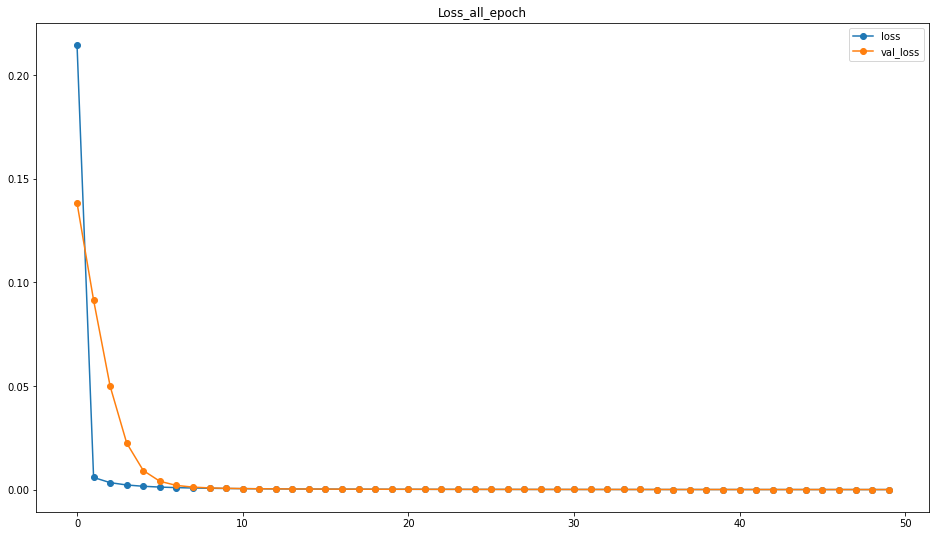

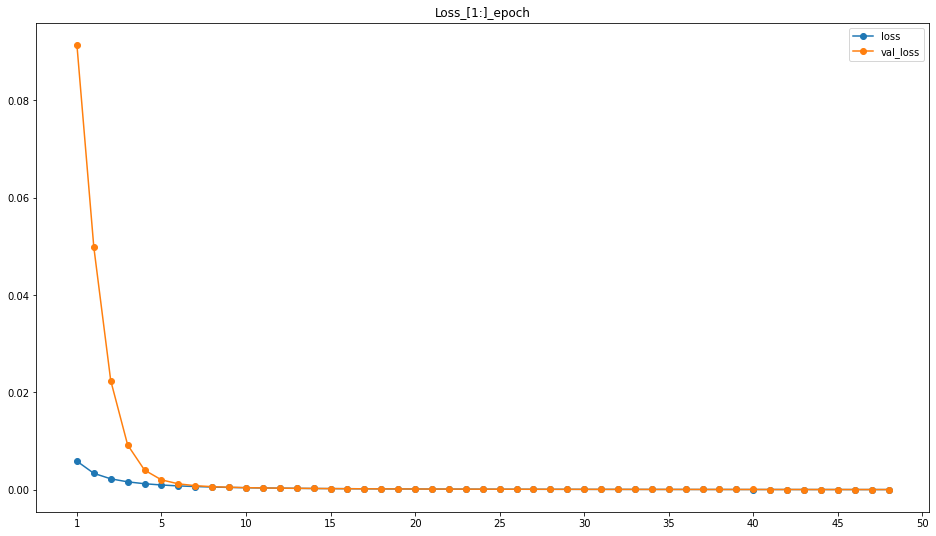

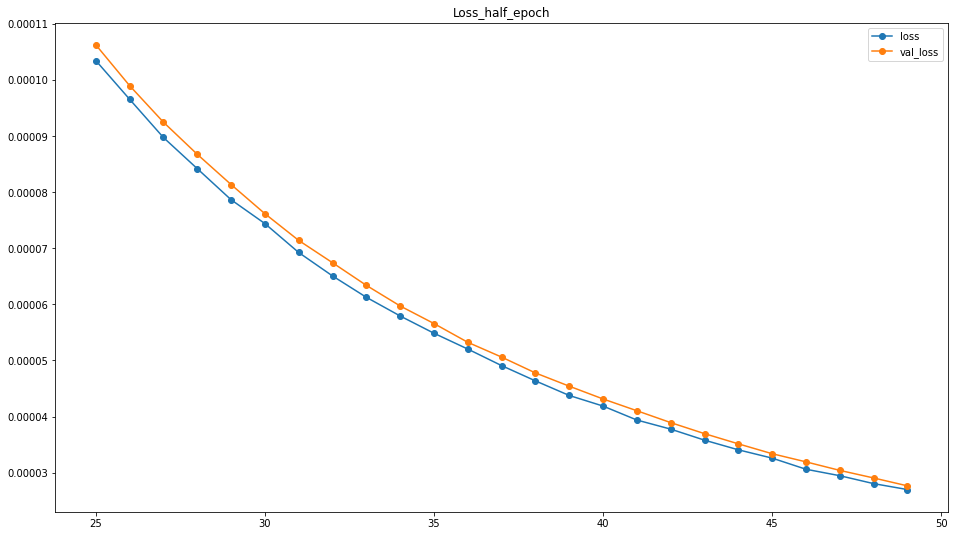

In [118]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [119]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 78us/step


In [120]:
print (scores)

[0.4869689729854142, 0.9316452741622925]


In [121]:
prediction = model.predict(test_data)

In [122]:
print(prediction)

[[9.9997878e-01 3.8626968e-06 8.4274161e-06 8.9924633e-06]
 [9.9997878e-01 3.8628109e-06 8.4276089e-06 8.9922396e-06]
 [9.9997878e-01 3.8629364e-06 8.4277617e-06 8.9920259e-06]
 ...
 [9.0197464e-06 4.7088306e-06 3.1404720e-06 9.9998319e-01]
 [9.0199192e-06 4.7088847e-06 3.1404898e-06 9.9998319e-01]
 [3.5610697e-06 1.5484499e-06 3.8661601e-06 9.9999106e-01]]


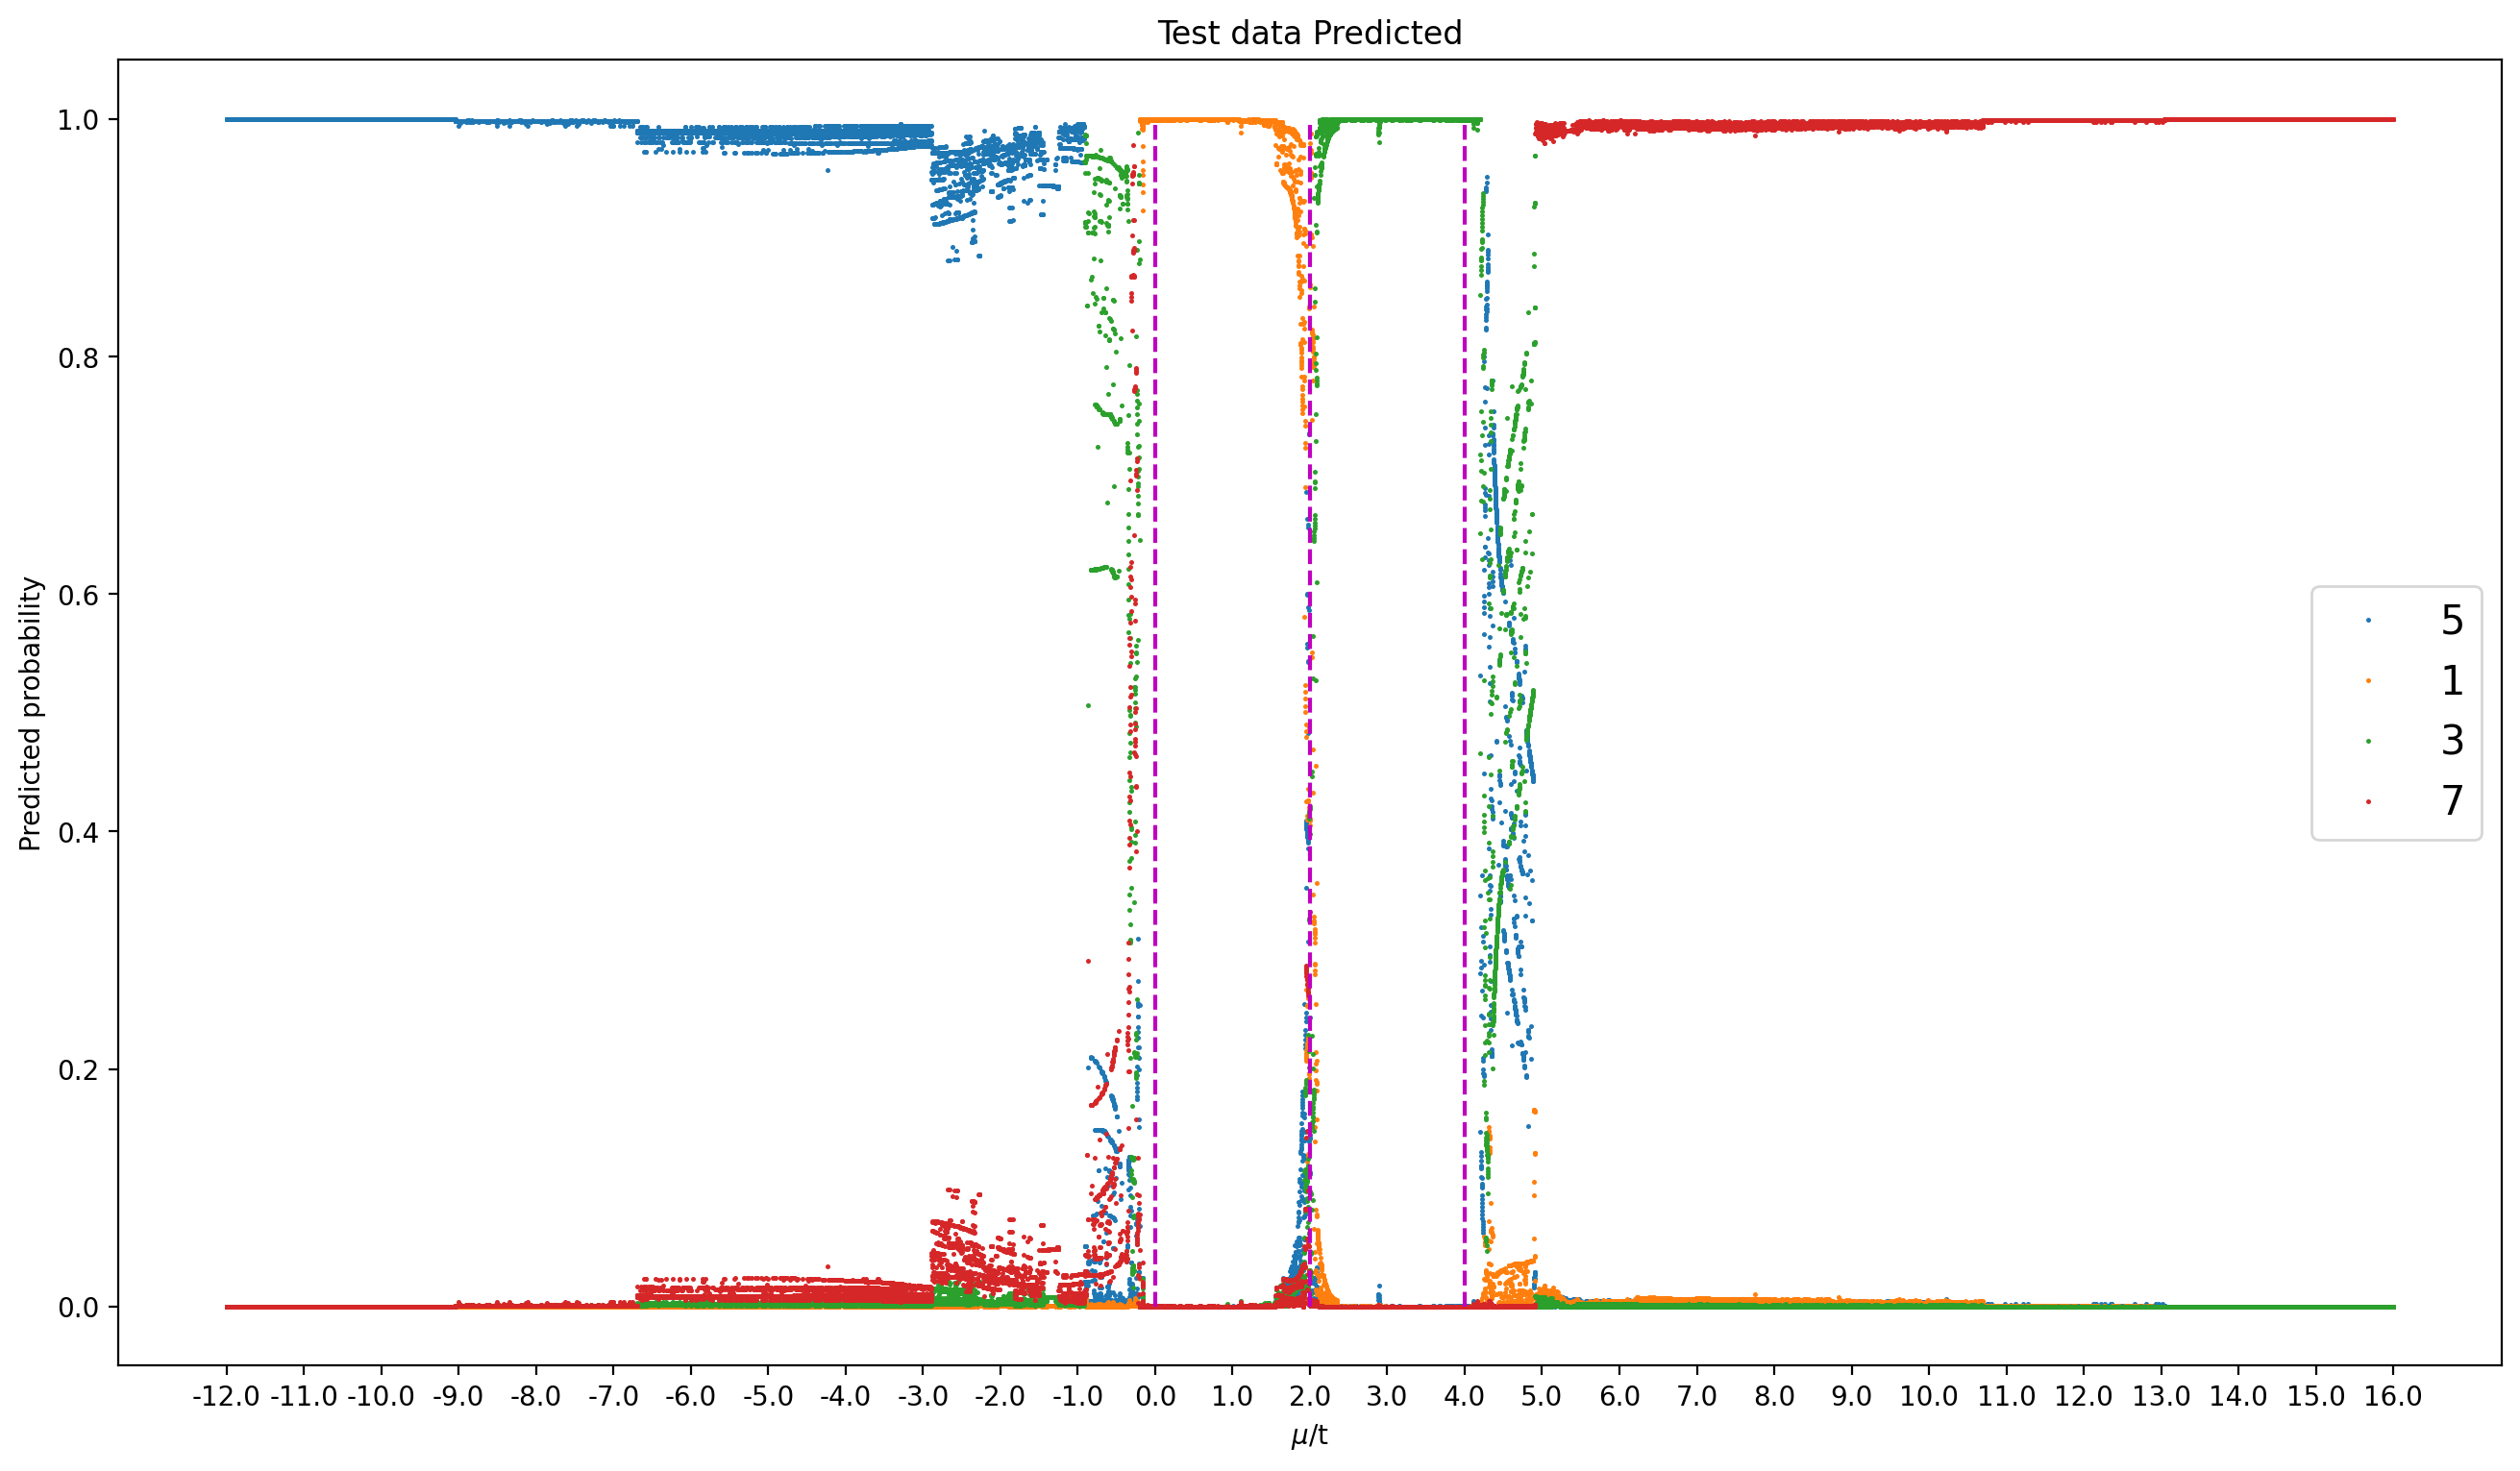

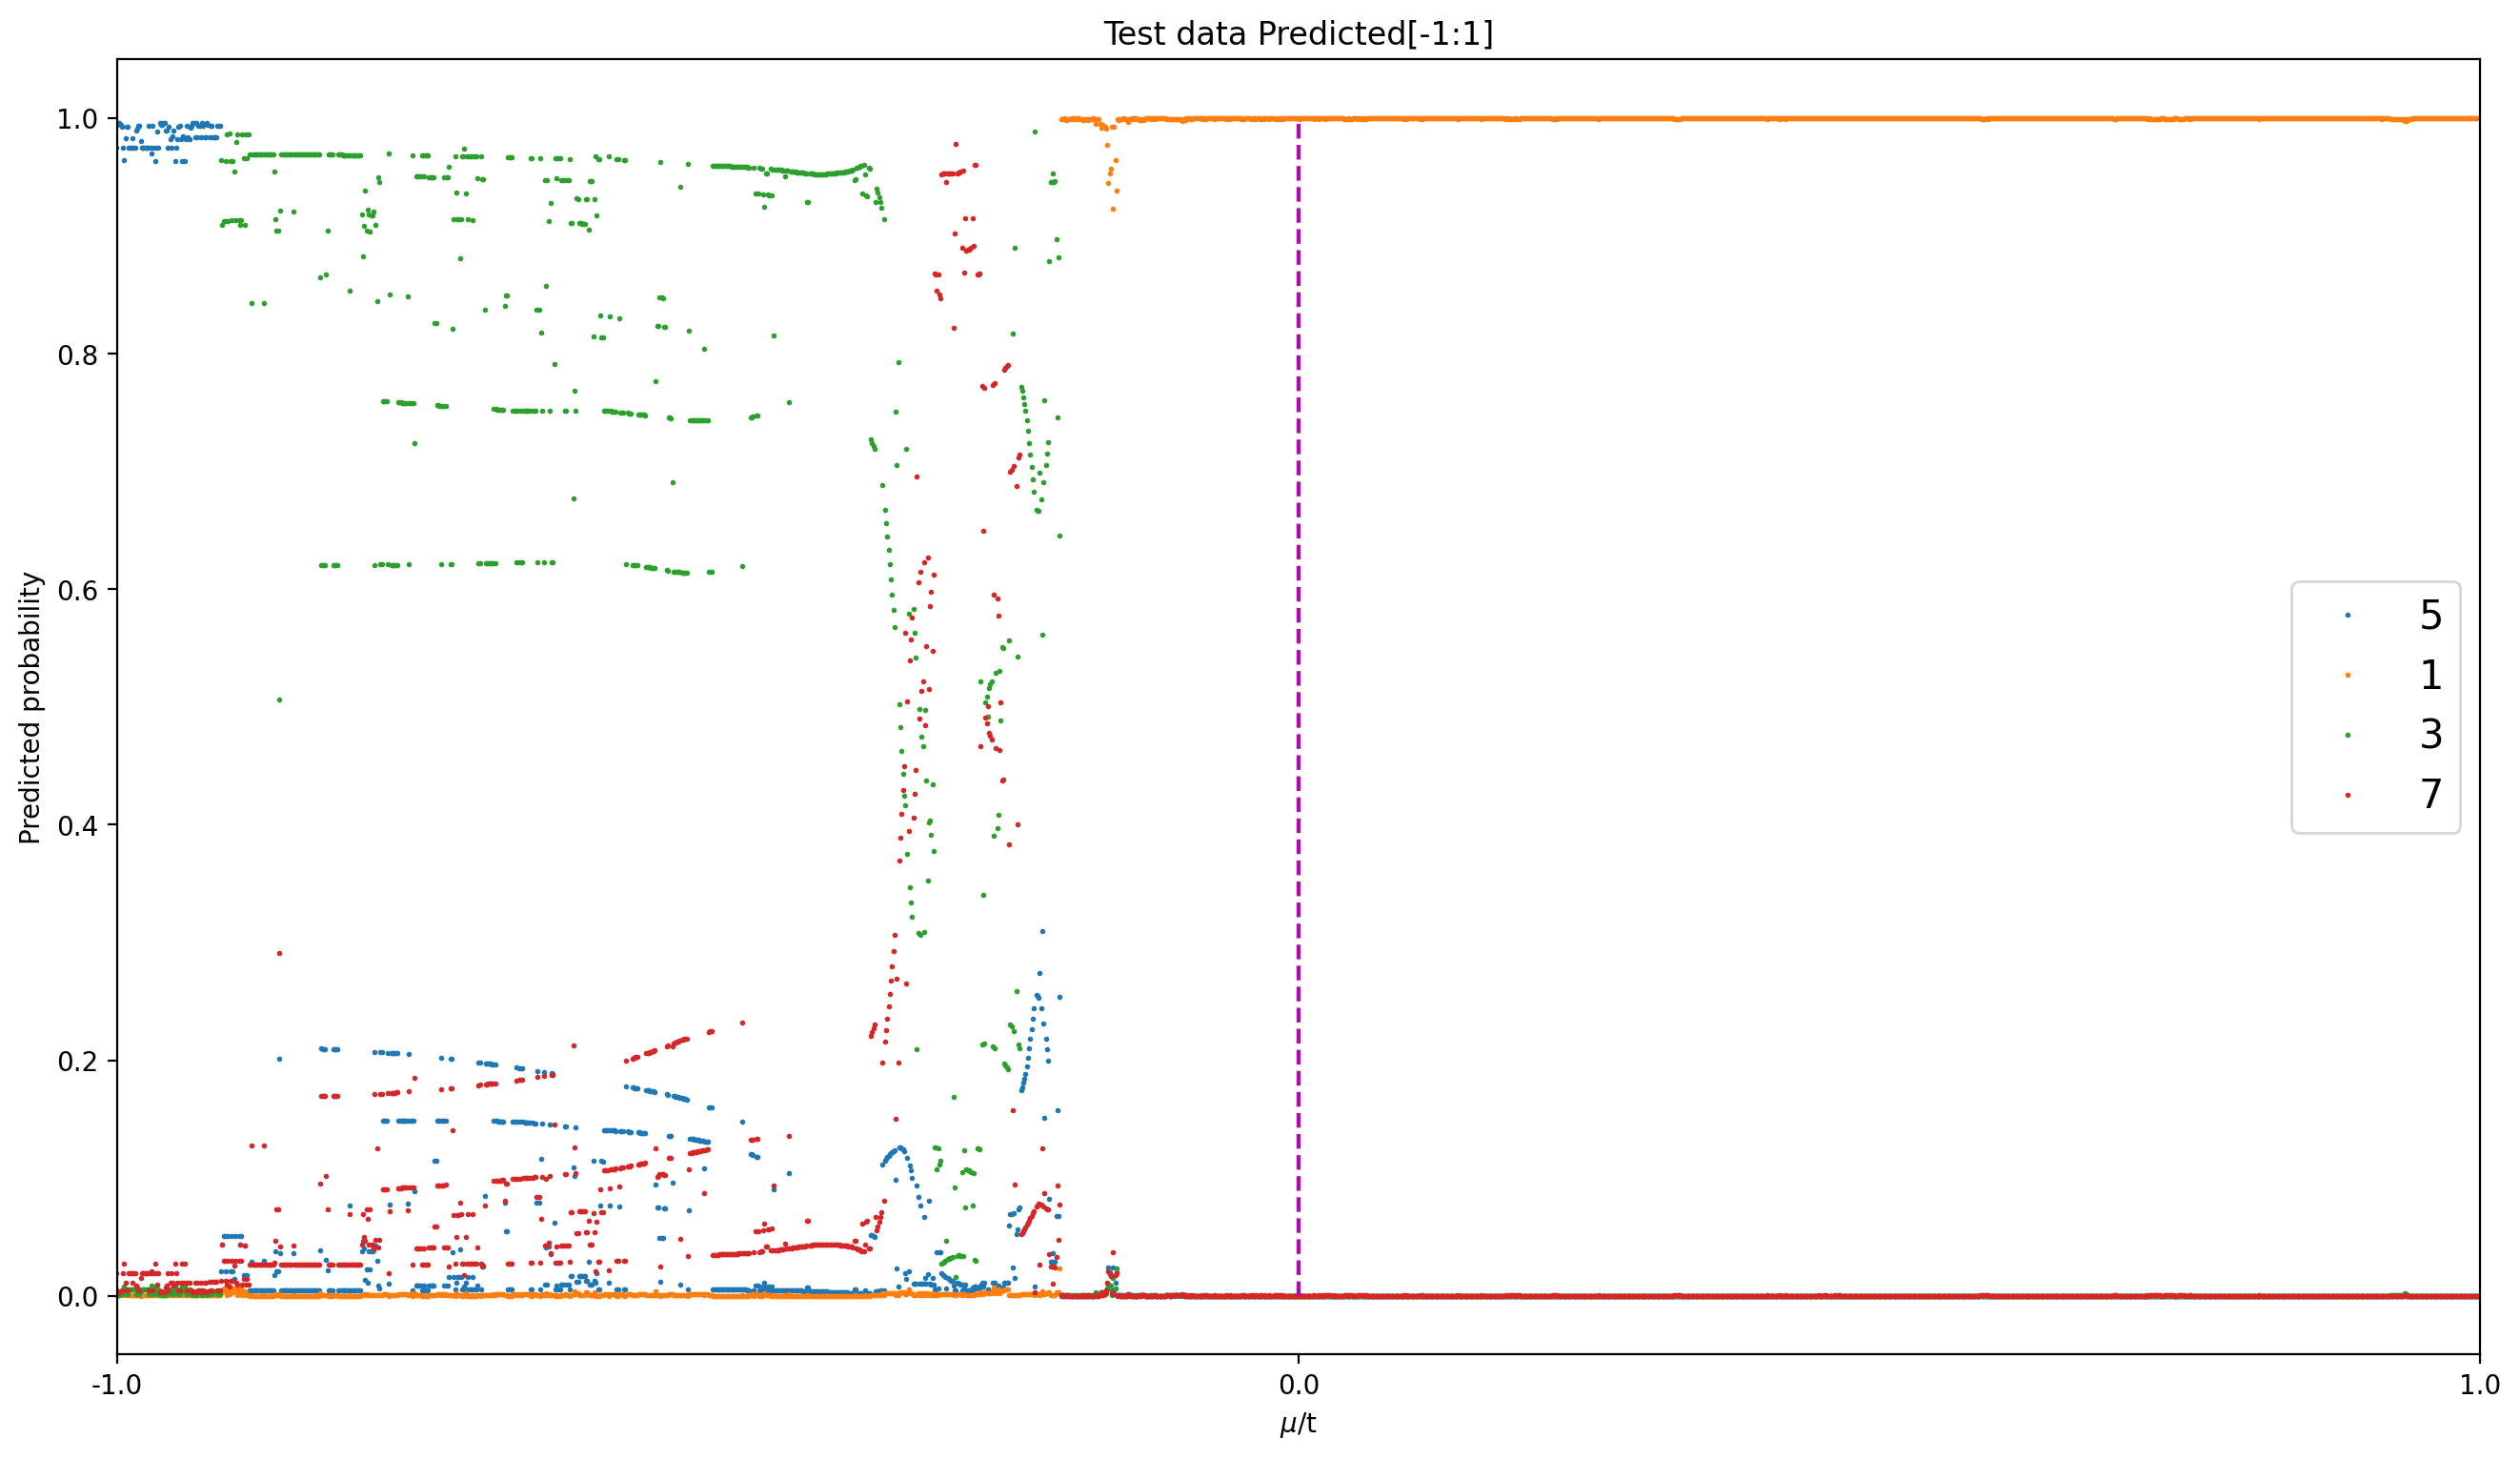

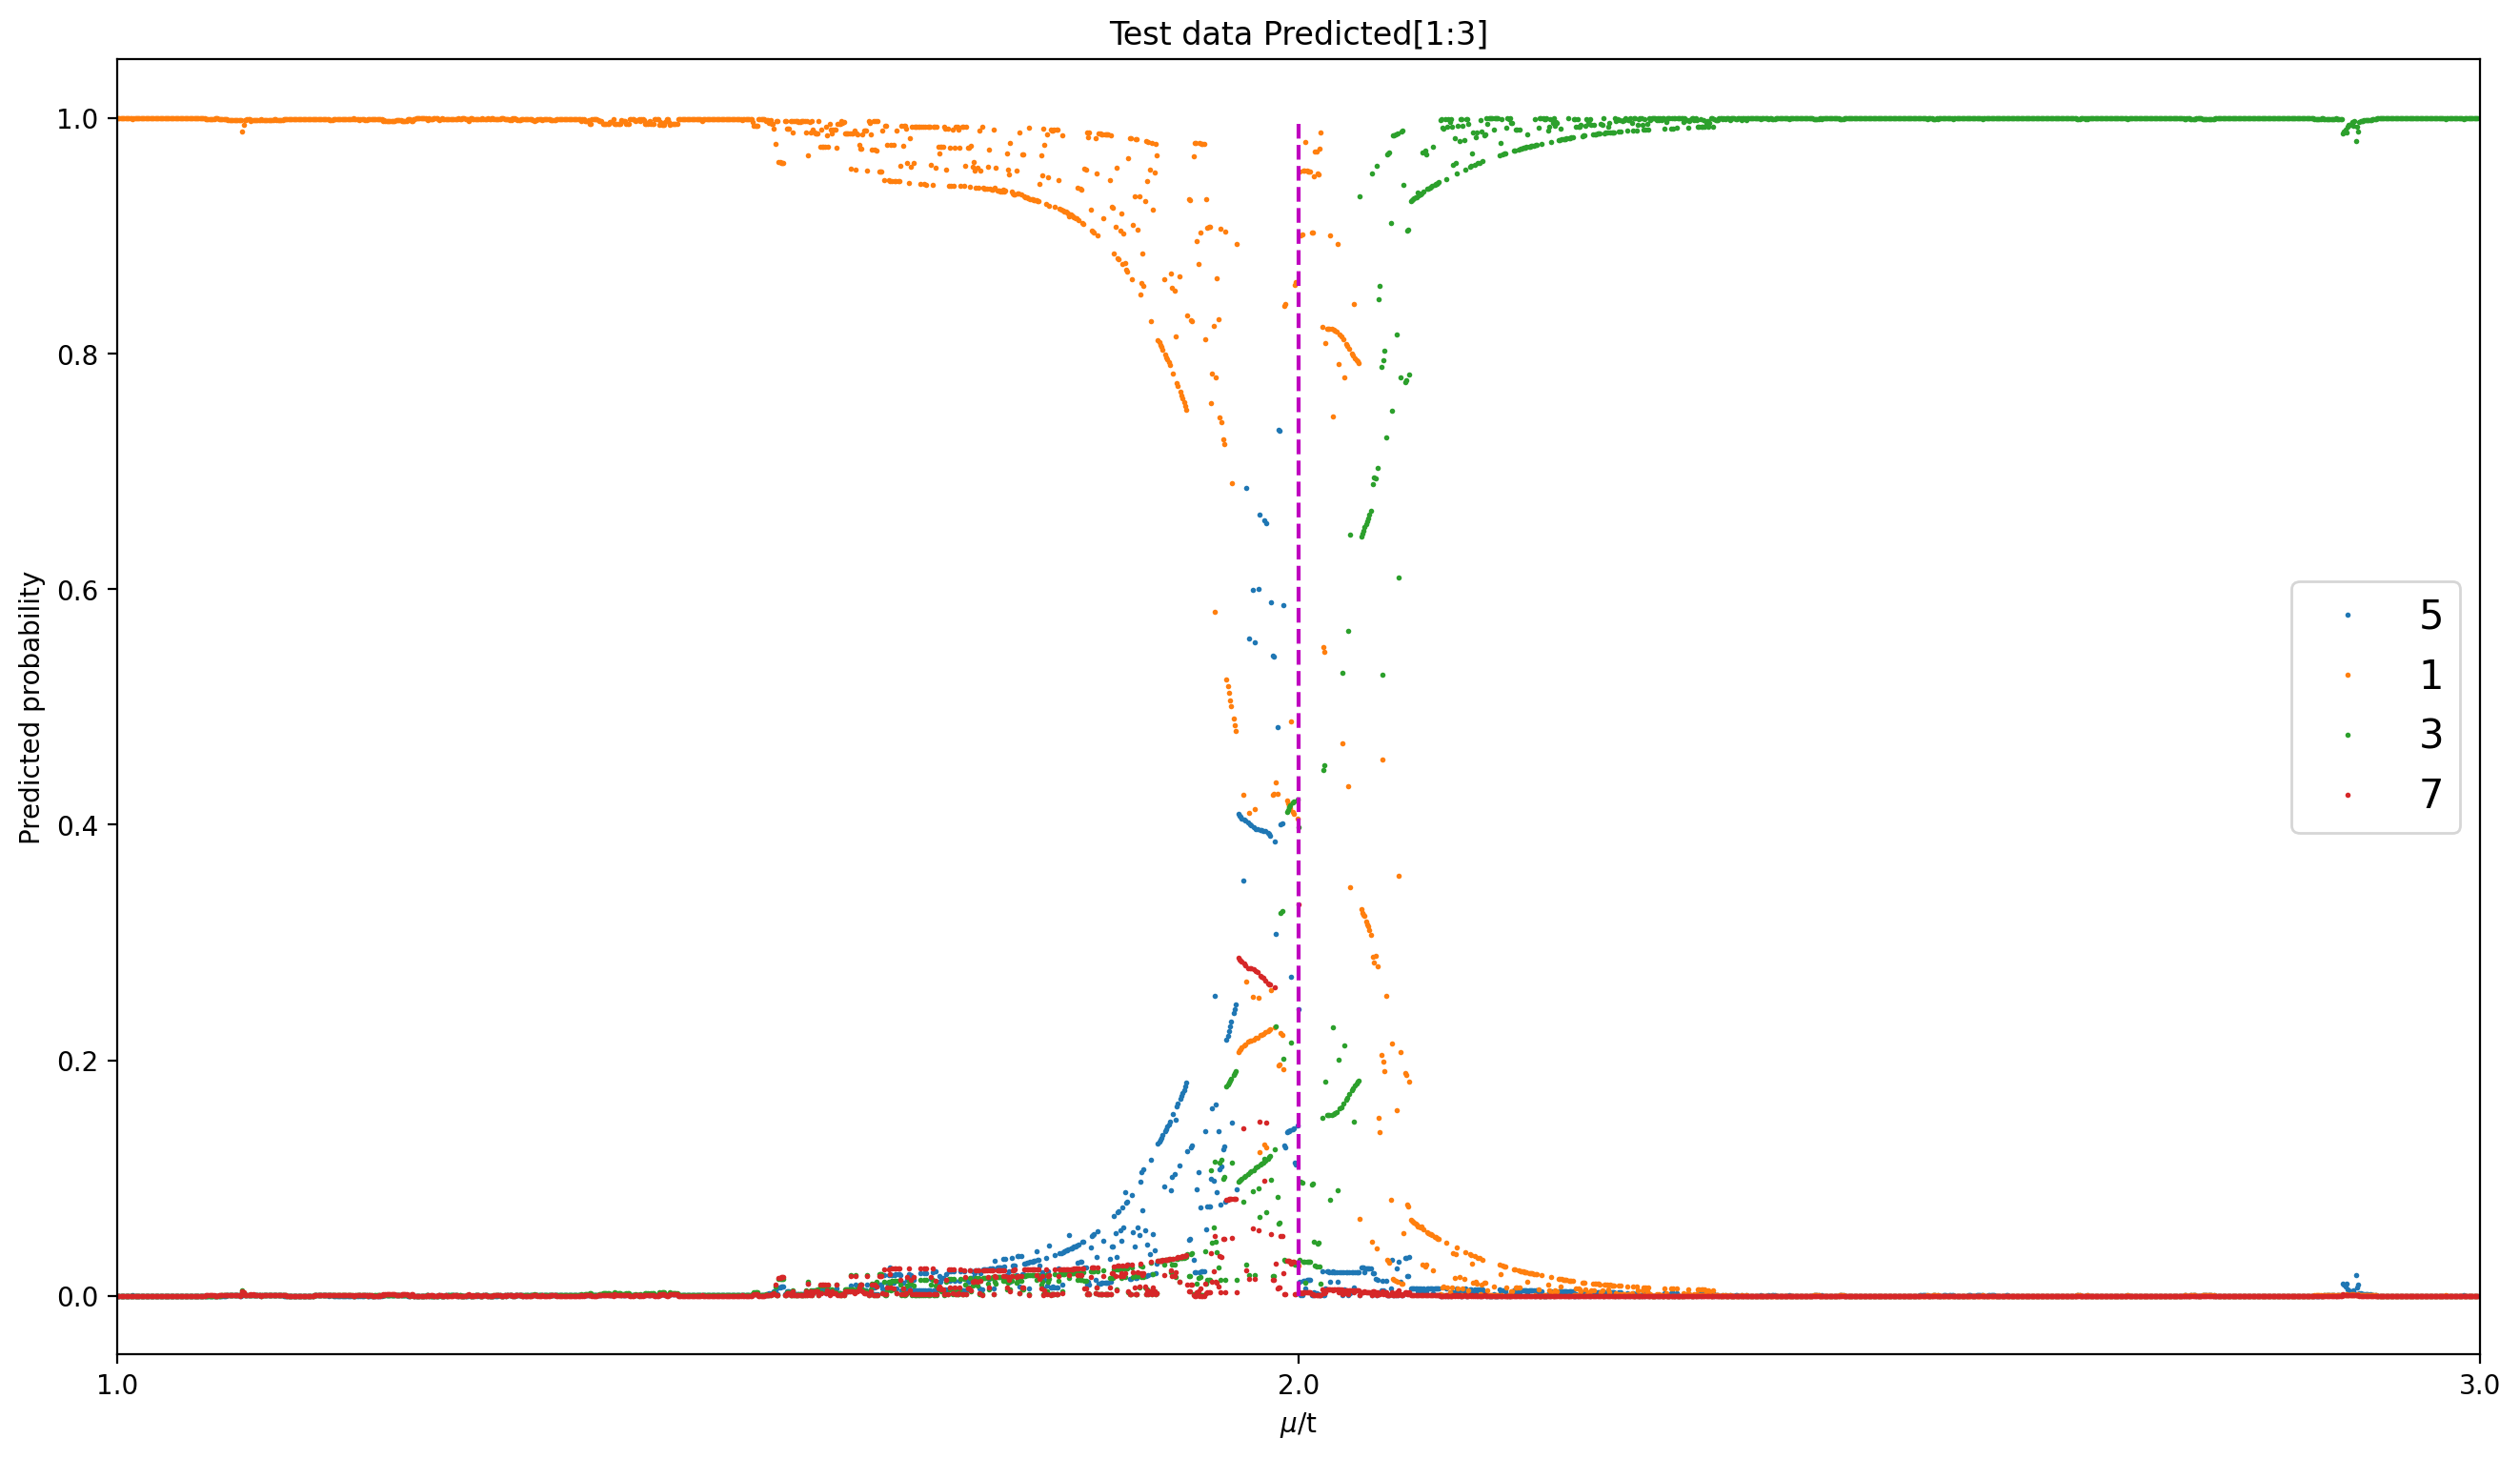

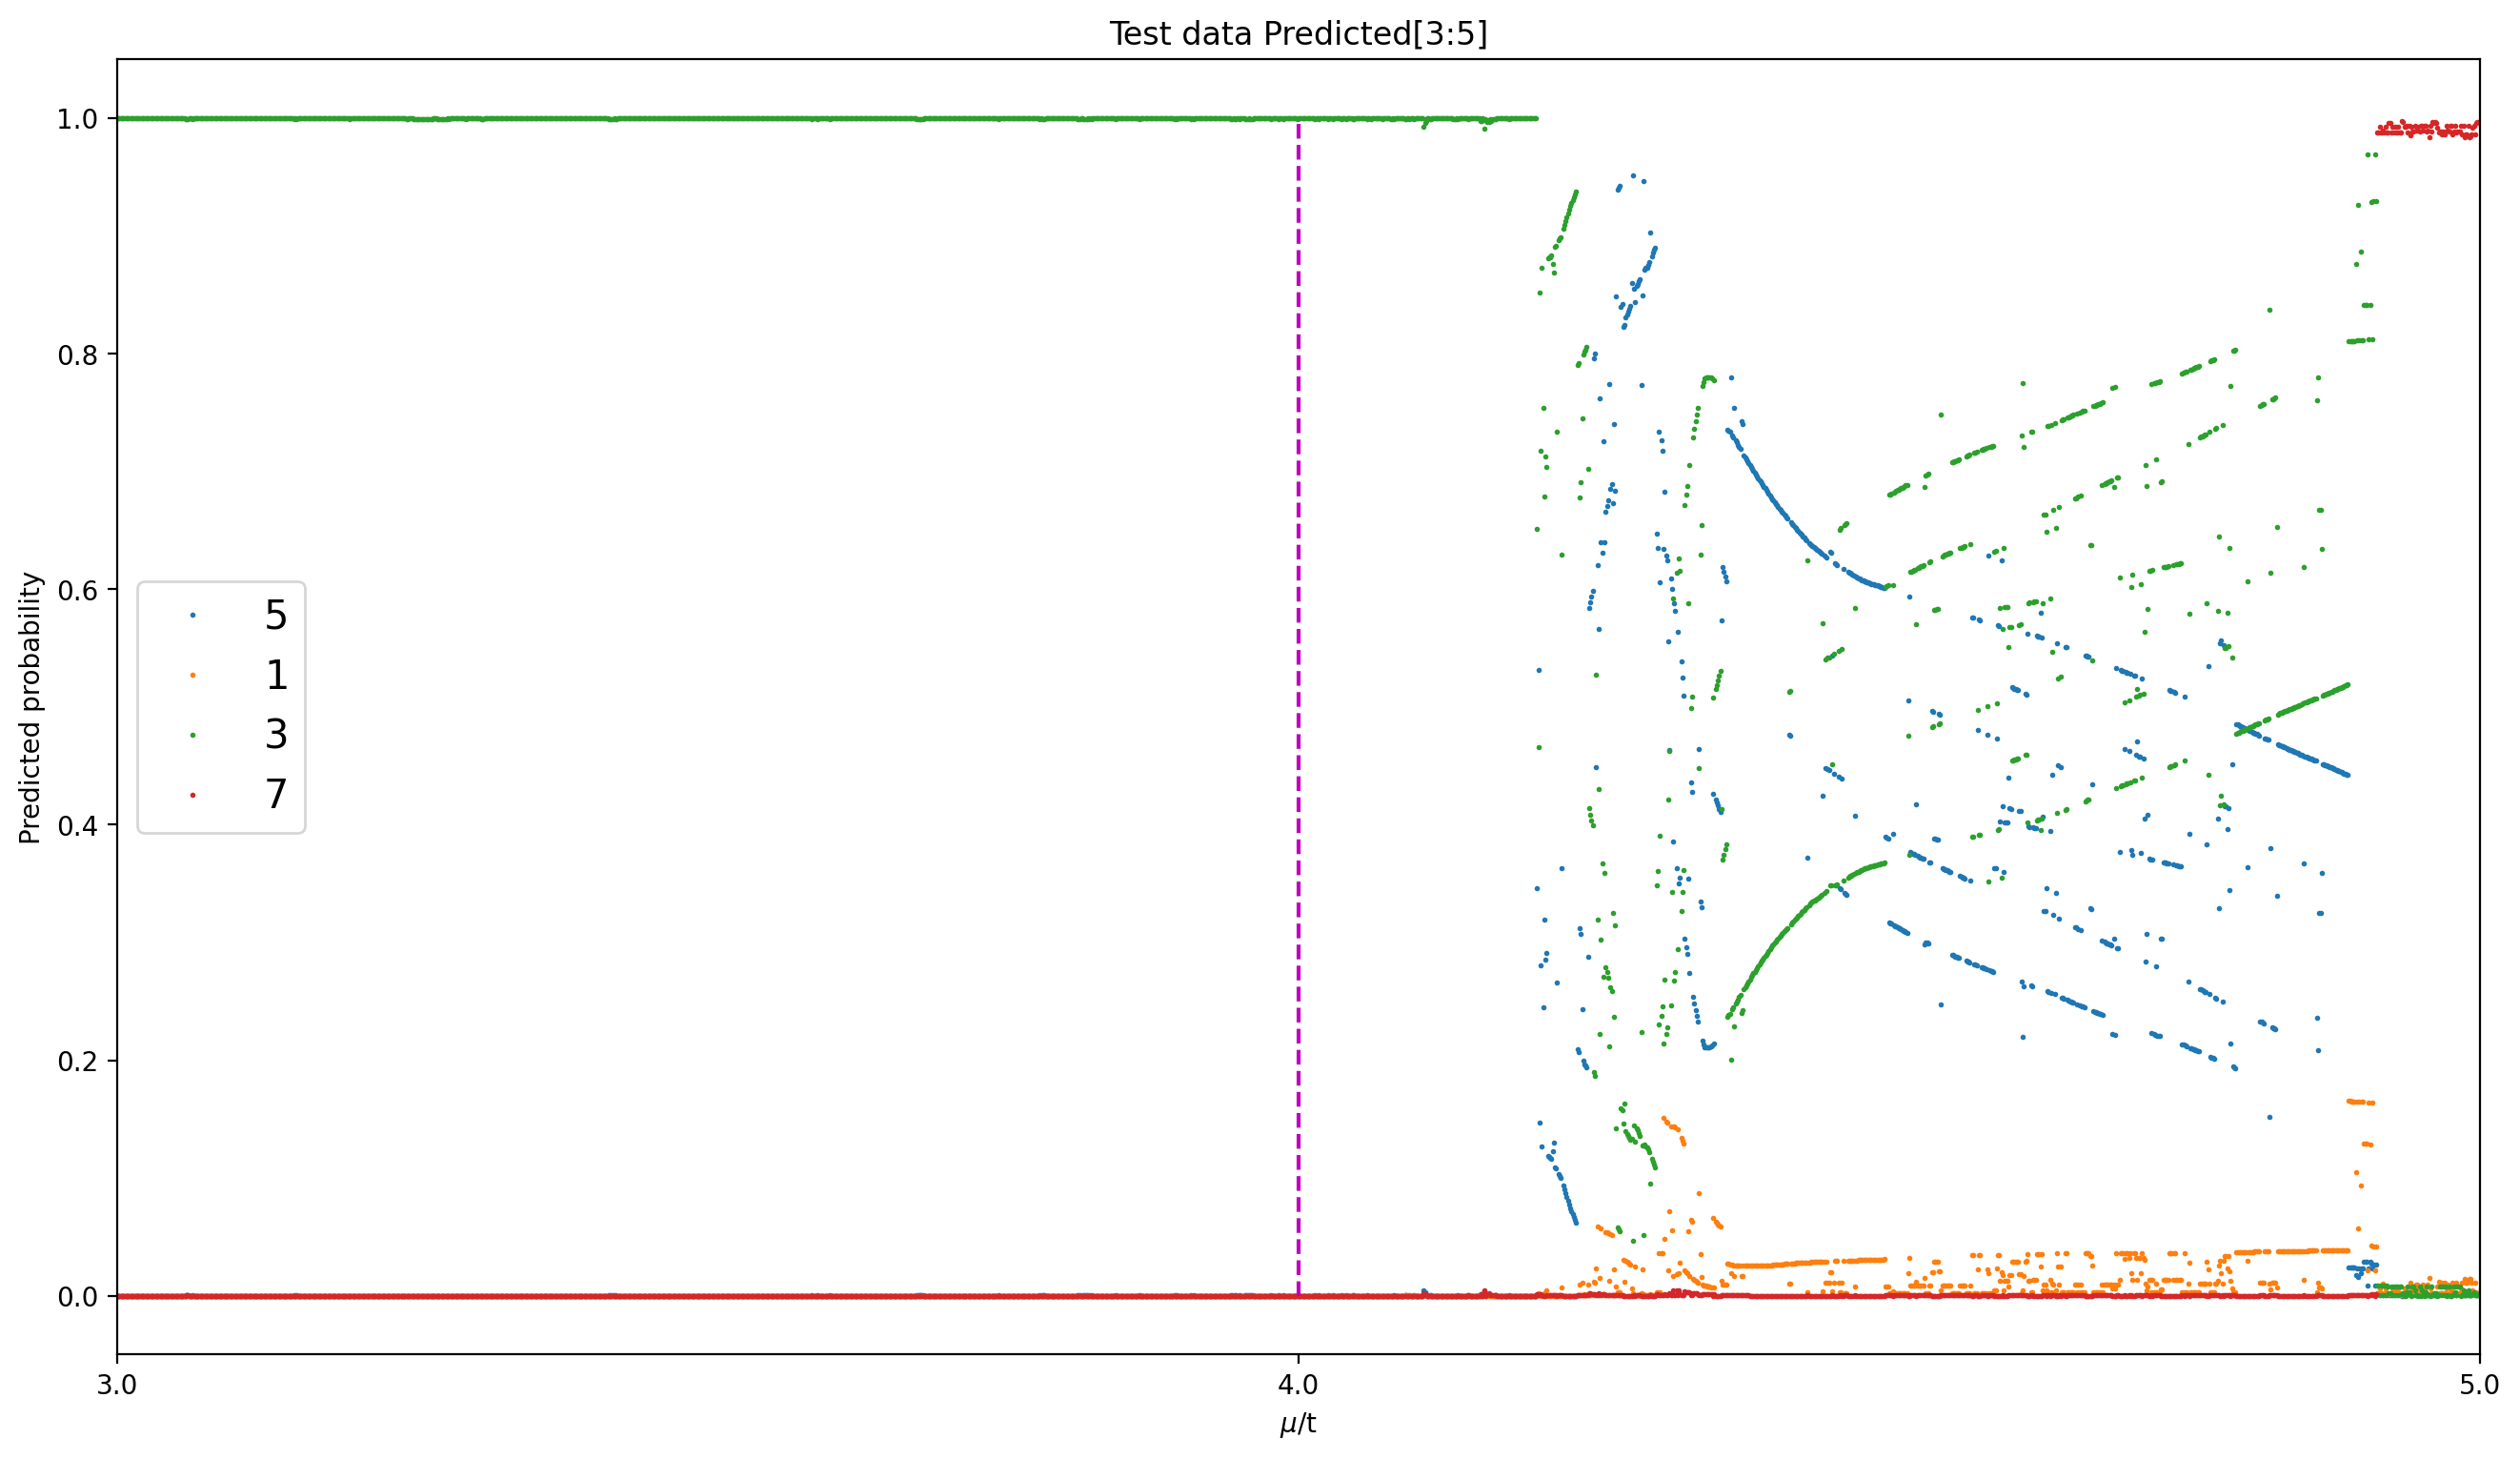

In [123]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()